In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
import json
from ensemble_boxes import *
import copy

In [2]:
#config_file = '../configs/detectors/dent_detector_latest_segm.py'
#checkpoint_file = '../models/dent_model_detestoRS/epoch_13.pth'

#config_file = '../models/loose/loose.py'
#checkpoint_file = '../models/loose/epoch_9.pth'

#config_file = '../models/crack_mosaic/crack_mosaic.py'
#checkpoint_file = '../models/crack_mosaic/epoch_7.pth'

config_file = '../models/scrach_mosaic_5k/scratch_mosaic_detectors.py'
checkpoint_file = '../models/scrach_mosaic_5k/epoch_9.pth'

In [3]:
model = init_detector(config_file, checkpoint_file, device='cuda:0')

2021-06-25 02:49:44,462 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.conv2.weight_diff, layer2.0.conv2.switch.weight, layer2.0.conv2.switch.bias, layer2.0.conv2.pre_context.weight, layer2.0.conv2.pre_context.bias, layer2.0.conv2.post_context.weight, layer2.0.conv2.post_context.bias, layer2.0.conv2.offset_s.weight, layer2.0.conv2.offset_s.bias, layer2.0.conv2.offset_l.weight, layer2.0.conv2.offset_l.bias, layer2.0.rfp_conv.weight, layer2.0.rfp_conv.bias, layer2.1.conv2.weight_diff, layer2.1.conv2.switch.weight, layer2.1.conv2.switch.bias, layer2.1.conv2.pre_context.weight, layer2.1.conv2.pre_context.bias, layer2.1.conv2.post_context.weight, layer2.1.conv2.post_context.bias, layer2.1.conv2.offset_s.weight, layer2.1.conv2.offset_s.bias, layer2.1.conv2.offset_l.weight, layer2.1.conv2.offset_l.bias, layer2.2.conv2.weight_diff, layer2.2.conv2.switch.weight, layer2

In [4]:
path = Path('../data/scratch')

In [5]:
test = json.load(open(path/'annotations'/'test.json'))
#test = json.load(open('test.json'))
print(test['info'])
print(len(test['images']),len(test['annotations']))

{'description': 'Car Parts Dataset', 'url': 'http://cocodataset.org', 'version': '1.0', 'year': 2017, 'contributor': 'COCO Consortium', 'date_created': '2017/09/01'}
3774 19445


In [6]:
total_yolo_bboxes = json.load(open('yolo_merimen_15_6_scratch.json'))

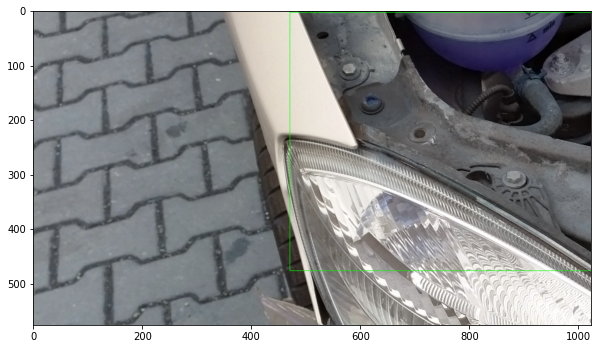

In [44]:
img = cv2.imread(str(path/'images'/test['images'][0]['file_name']))
h,w,_ = img.shape
img = img[:int(h/2),:int(w/2)]
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [49]:
pred_segms.sum()

446549

In [46]:
mask = pred_segms[0].astype(np.uint8)
contours,_ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#img_ = cv2.drawContours(img_,contours,-1,(0,255,0),2)
#plt.imshow(img_)
print(contours)
for i, contour in enumerate(contours):
    print(i)
    contours[i] = contours[i].tolist()
#print(contours)

[array([[[501,   2]],

       [[500,   3]],

       [[488,   3]],

       ...,

       [[717,   3]],

       [[698,   3]],

       [[697,   2]]], dtype=int32)]
0


In [49]:
for i,countour in enumerate(contours):
    contours[i] = np.array(contours[i],dtype=np.int32)
print(contours)

[array([[[501,   2]],

       [[500,   3]],

       [[488,   3]],

       ...,

       [[717,   3]],

       [[698,   3]],

       [[697,   2]]], dtype=int32)]


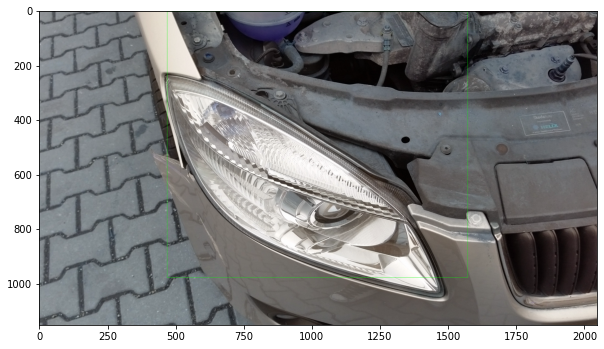

In [45]:
img = cv2.imread(str(path/'images'/test['images'][0]['file_name']))
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [ ]:
result = inference_detector(model,img)
img_,pred_boxes,pred_segms,pred_labels,scores = show_result_pyplot(model, img.copy(), result,score_thr=0.4)
plt.figure(figsize=(10,10))
plt.imshow(img_)

In [7]:
def normolize_box(boxes,height,width):
    new_boxes = []
    for b in boxes:
        new_b = []
        for p in b:
            new_b.extend(np.array(p)/(width,height))
        new_boxes.append(new_b)
    
    return new_boxes

def get_data_box(img,idx,name,boxes,segms,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    #print(boxes)
    i_boxes = total_yolo_bboxes[str(idx)]['boxes']
    yolo_boxes = copy.deepcopy(i_boxes)
    h,w = img.shape[:2]
    for j in range(len(yolo_boxes)):
        yolo_boxes[j][0] = int(yolo_boxes[j][0]*w)
        yolo_boxes[j][1] = int(yolo_boxes[j][1]*h)
        yolo_boxes[j][2] = int(yolo_boxes[j][2]*w)
        yolo_boxes[j][3] = int(yolo_boxes[j][3]*h)
        yolo_boxes[j] = [(yolo_boxes[j][0],yolo_boxes[j][1]),(yolo_boxes[j][2],yolo_boxes[j][3])] 
    #print(yolo_boxes)
    check_boxes = [0 for i in yolo_boxes]
    check_pred = [0 for i in boxes]
    out_boxes = []
    for i,b in enumerate(boxes):
        ious = [cal_iou(img,b,j) for j,check in zip(yolo_boxes,check_boxes) if check == 0]
        
        if len(ious) == 0:
            break
        max_id = np.argmax(ious)
        
        if ious[max_id] >= 0.25 : 
            out_boxes.append(b)
            check_boxes[max_id] = 1
            check_pred[i] = 1
    #print('out:',out_boxes)
    data_box['boxes'] = normolize_box(out_boxes,*img.shape[:-1])
    
    segm_masks = []
    #print('check',segms.sum())
    for i,segm in enumerate(segms) :
        if check_pred[i] == 0:
            continue
        segm = segm.astype(np.uint8)
        contours, _ = cv2.findContours(segm, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours = [c.tolist() for c in contours]
        segm_masks.append(contours)
        
    data_box['segms'] = segm_masks
    data_box['labels'] = labels.tolist()
    #print('scores :',scores)
    #print('check :',check_pred)
    data_box['scores'] = [float(s) for s,c in zip(scores,check_pred) if c ==1]
    
    return data_box

def get_data_box_flip(img,name,boxes,labels,scores):
    data_box = OrderedDict()
    data_box['image'] = name
    
    boxes = normolize_box(boxes,*img.shape[:-1])
    for i in range(len(boxes)):
        boxes[i][0] = 1-boxes[i][0]
        boxes[i][2] = 1-boxes[i][2]
    data_box['boxes'] = boxes
    
    data_box['labels'] = labels.tolist()
    data_box['scores'] = scores.tolist()
    
    return data_box

In [69]:
data = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.25)
    data[i['id']] = get_data_box(image,i['id'],i['file_name'],pred_boxes,pred_segms,pred_labels,pred_scores)
    #break
with open('new_and_ensemble_scratch.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|██████████| 3774/3774 [54:48<00:00,  1.15it/s]  


In [103]:
data_flip = OrderedDict()

for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    image = np.fliplr(image)
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.4)
    data_flip[i['id']] = get_data_box_flip(image,i['file_name'],pred_boxes,pred_labels,pred_scores)

with open('detector_pred_flip.json', 'w', encoding='utf-8') as f:
    json.dump(data_flip, f, ensure_ascii=False, indent=4)

100%|██████████| 738/738 [06:12<00:00,  1.98it/s]


In [18]:
#pred_data = json.load(open('detector_pred.json'))
#
'''
#es = json.load(open('./merimen/yolo_pred_crack.json')) 
#yolo_pred.json
detector_pred
es = json.load(open('./yolo_pred.json'))
'''
pred_data = json.load(open('./detector_pred.json'))
pred_data_flip = json.load(open('./merimen/yolo_pred_crack.json'))

In [19]:
def remove_ovelap(boxes):
    idx = [True for b in boxes]
    for i1 in range(len(boxes)-1) :
        for i2 in range(i1+1,len(boxes)):
            if idx[i1] == True and boxes[i1][0] < boxes[i2][0] and boxes[i1][1] < boxes[i2][1] and boxes[i1][2] > boxes[i2][2] and boxes[i1][3] > boxes[i2][3] :
                idx[i1] = False
                break
            
            if idx[i2] == True and boxes[i1][0] > boxes[i2][0] and boxes[i1][1] > boxes[i2][1] and boxes[i1][2] < boxes[i2][2] and boxes[i1][3] < boxes[i2][3] :
                idx[i2] = False
                continue
    return boxes[idx]
            
es = OrderedDict()
for i in test['images']:
    boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
    scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
    labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]
    
    if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = []
        i_data['labels'] = []
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[0]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[1]
        i_data['labels'] = labels_list[1]
        es[str(i['id'])] = i_data
        continue
    
    if len(boxes_list[1]) == 0 :
        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes_list[0]
        i_data['labels'] = labels_list[0]
        es[str(i['id'])] = i_data
        continue
    
    weights = [2,1]
    iou_thr = 0.36
    skip_box_thr = 0.0001
    sigma = 0.1
    
    boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

    i_data = OrderedDict()
    i_data['name'] = i['file_name']
    i_data['boxes'] = boxes.tolist()
    i_data['labels'] = labels.tolist()
    es[str(i['id'])] = i_data
    #print(len([a for a in test['annotations'] if a['image_id']==i['id']]))
    #img = cv2.imread(str(path/'images'/i['file_name']))
    #plot(img,boxes,scores)
    #break
with open('./merimen/ensemble_crack_d_y.json', 'w', encoding='utf-8') as f:
    json.dump(es, f, ensure_ascii=False, indent=4)

In [15]:
def plot(idx, boxes):
    image = cv2.imread(str(path/'images'/es[str(idx)]['name']))
    img = image.copy()
    h,w, _ = img.shape
    for i in range(len(boxes)):
        img = cv2.rectangle(img,(int(boxes[i][0]*w),int(boxes[i][1]*h)),(int(boxes[i][2]*w),int(boxes[i][3]*h)),(255,255,0),2)
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['name']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,0,0),2)
    
    plt.figure(figsize=(20,10))
    plt.imshow(np.hstack((img,image)))
    #return np.hstack((img,image))

def plot_fp(idx,i_boxes):
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
    
    pred_labels = [0 for i in boxes]
    
    pred_tp = [0 for i in boxes]
    gt_tp = [0 for i in gt_boxes]
    
    for i in range(len(boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            #print(boxes[i],i_gt_boxes[j])
            iou = cal_iou(img,boxes[i],i_gt_boxes[j])
            if iou > 0.25:
                idx = gt_boxes.index(i_gt_boxes[j])
                gt_labels[idx] = -1
                pred_tp[i] = 1
                gt_tp[idx] = 1
                break
    
    for i in range(len(pred_tp)):
        #print(i)
        #print(boxes[i][0])
        if pred_tp[i]:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2)
        else:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    
    #print(img_out.shape,img.shape)
    return np.hstack((img_out,img))

def plot_fp_v2(idx,i_boxes):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth
    check_fp = False
    for i in range(len(boxes)):
        ious = [cal_iou(img,boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        idx = np.argmax(ious)
        
        if gt_tp[idx] == 1 :
            continue
        
        if ious[idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            check_fp =True
            
    
    # draw TP, FP, FN
    #print(pred_tp)
    for i in range(len(pred_tp)):
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
        else:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            
    return np.hstack((img_out,img)), check_fp



def cal_iou(img,box1,box2):
    #input 
    # img : cv2 image
    # box1, box2 is [(x1,y1),(x2,y2)]
    # output : iou of box1 and box2
    
    mask1 = np.zeros_like(img[:,:,0])
    mask1[box1[0][1]:box1[1][1],box1[0][0]:box1[1][0]] = 1
    
    mask2 = np.zeros_like(img[:,:,0])
    mask2[box2[0][1]:box2[1][1],box2[0][0]:box2[1][0]] = 1
    
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())

def cal_iou_mask(img,contour1,contour2):
    #print(contour1)
    #print(contour2)
    #print(img.shape[:2])
    mask1 = np.zeros(img.shape[:2])
    mask2 = np.zeros(img.shape[:2])
    #print(mask1.shape,mask2.shape)
    
    mask1 = cv2.fillPoly(mask1,contour1,1)
    mask2 = cv2.fillPoly(mask2,[contour2],1)
    
    plt.imshow(np.hstack([mask1,mask2]))
    intersect = np.logical_and(mask1,mask2)
    
    if intersect.sum() == 0:
        return 0
    
    return intersect.sum() / (mask1.sum()+mask2.sum()-intersect.sum())
    #pass

def cal(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name):
    tp = 0
    
    for i in range(len(pred_boxes)):
        i_gt_boxes = [m for (m,n) in zip(gt_boxes,gt_labels) if n == pred_labels[i]]
        for j in range(len(i_gt_boxes)):
            iou = cal_iou(img,pred_boxes[i],i_gt_boxes[j])
            if iou > 0.25 :
                tp += 1
                idx = gt_boxes.index(i_gt_boxes[j])
                #gt_labels[idx] = -1
                break
            
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    
    return tp,fp,fn 

#global check_dense = 0
def cal_v2(img,pred_boxes,pred_labels,gt_boxes,gt_labels, name,check_dense):
    fp = 0
    tp = 0
    fp_boxes = []
    
    for i in range(len(pred_boxes)):
        ious = [cal_iou(img,pred_boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))]
        
        if len(ious) == 0:
            return 0,0,0,fp_boxes
        
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 :
            continue

        if ious[idx] >= 0.25:
            gt_labels[idx] = -1
            tp += 1
        else:
            fp += 1
            fp_boxes.append(pred_boxes[i])

    fn = len(gt_boxes) - tp
    
    if len(gt_boxes) >= 8 and tp/len(gt_boxes) >= 0.6:
        check_dense += 1
        
        print('dense cases :',check_dense)
        fp = 0
    
    return tp,fp,fn, fp_boxes,check_dense

In [9]:
def plot_fp_v2_with_segm(idx,i_boxes,i_segms):
    #get predict boxes and groudtruth_box 
    img = cv2.imread(str(path/'images'/es[str(idx)]['image']))
    img_out = img.copy()
    
    h,w, _ = img.shape
    
    i = [i for i in test['images'] if i['file_name']==es[str(idx)]['image']][0]
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]
    gt_labels = [0 for i in gt_boxes]
    
    boxes = copy.deepcopy(i_boxes)
    for j in range(len(boxes)):
        boxes[j][0] = int(boxes[j][0]*w)
        boxes[j][1] = int(boxes[j][1]*h)
        boxes[j][2] = int(boxes[j][2]*w)
        boxes[j][3] = int(boxes[j][3]*h)
        boxes[j] = [(boxes[j][0],boxes[j][1]),(boxes[j][2],boxes[j][3])] 
        
    segms = copy.deepcopy(i_segms)
    for i,segm in enumerate(segms):
        segms[i] = [np.array(s).astype(np.int32) for s in segms[i]]
        
    ## boxes and gt_boxes are list of [[(x1,y1),(x2,y2)],.....]
    ## gt_labels of coressponding gt_boxes
    
    # calculate iou of predict and grouthtruth base on AP25
    pred_tp = [0 for i in boxes]  # to mark tp in predict
    gt_tp = [0 for i in gt_boxes] # to mark tp in grouth truth

    for i in range(len(boxes)):
        #print([(boxes[i],gt_boxes[j]) for j in range(len(gt_boxes))])
        if len(gt_boxes)==0:
            pred_tp = [-1 for i in boxes]
            break
        ious = [cal_iou_mask(img,segms[i],gt_segms[j]) for j in range(len(gt_boxes))]
        idx = np.argmax(ious)
        
        if gt_tp[idx] == 1 :
            continue
        
        if ious[idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[idx] = 1         # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            
    
    # draw TP, FP, FN
    #print(pred_tp)
    for i in range(len(pred_tp)):
        #print(segms[i])
        if pred_tp[i]==1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(255,255,0),2) #TP
            img_out = cv2.drawContours(img_out,segms[i],-1,(255,255,0),2)
        elif pred_tp[i]==-1:
            img_out = cv2.rectangle(img_out,boxes[i][0],boxes[i][1],(0,0,255),2)   #FP
            img_out = cv2.drawContours(img_out,segms[i],-1,(0,0,255),2)
    
    
    for i in range(len(gt_tp)):
        if gt_tp[i]:
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)  #TP
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(255,255,0),2)
        else:
            #print(gt_segms[i])
            img = cv2.rectangle(img,gt_boxes[i][0],gt_boxes[i][1],(0,0,255),2)    #FN
            img = cv2.drawContours(img,np.array([gt_segms[i]]),-1,(0,0,255),2)
            
    return np.hstack((img_out,img))

In [17]:
#es = json.load(open('./merimen/yolo_pred_crack.json')) 
#yolo_pred.json
es = json.load(open('detector_scratch_pred_03.json')) 
total_tp = 0
total_fn = 0
total_fp = 0
#c = 0
#for i in es.keys():
#    c += len(es[i]['scores'])
#print(c)
fp_cases = OrderedDict()
check_dense = 0
for i in tqdm(test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    h,w,_=image.shape
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    #gt_segms = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==i['id']]    
    gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
    
    
    pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
    for j in range(len(pred_boxes)):
        pred_boxes[j][0] = int(pred_boxes[j][0]*w)
        pred_boxes[j][1] = int(pred_boxes[j][1]*h)
        pred_boxes[j][2] = int(pred_boxes[j][2]*w)
        pred_boxes[j][3] = int(pred_boxes[j][3]*h)
        
        pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
    
    #pred_segms = copy.deepcopy(es[str(i['id'])]['segms'])
    #for idx,segm in enumerate(pred_segms):
    #    pred_segms[idx] = [np.array(s).astype(np.int32) for s in pred_segms[idx]]
    
    #print(i['id'])
    #print(es[str(i['id'])])
    pred_labels = es[str(i['id'])]['labels']
    
    print(i['id'],i['file_name'])
    old_check = check_dense
    tp,fp,fn, fp_boxes,check_dense = cal_v2(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'],old_check)
    #tp,fp,fn, fp_boxes = cal_v2(image,pred_segms,pred_labels,gt_segms,gt_labels, i['file_name'])
    if check_dense - old_check == 1:
        dense_path = Path('dense_scratch')
        dense_path.mkdir(parents=True,exist_ok=True)
        idx = i['id']
        out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])
        cv2.imwrite(str(dense_path/(str(idx)+'.jpg')),out)
    total_tp += tp
    total_fp += fp
    total_fn += fn
    
    if len(fp_boxes) > 0:
        fp_cases[i['file_name']] = fp_boxes
    
    
    print(tp,fp,fn)
    #break
    #print(pred_boxes)
    #break 1439 1 0 0
print(total_tp,total_fp,total_fn,check_dense)

  0%|          | 4/3774 [00:00<02:19, 27.09it/s]

2021 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7149_vehicle_additional_docs_21749_medium_15559750008971833159462424792505.jpg
1 5 1
11083 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20138.99%20-%2025.09.2018_z1123978942787_defcf41b41cc4e11dca160bc5b250072.jpg
1 0 0
2596 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0145_front_left_view_29182_medium_1132205F-80EF-4FD0-875F-FA964C03435B.jpeg
1 1 2
12766 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20292.32%20-%2003.10.2018_z1132025237064_64536bf7b9a46c691b726714f229407a.jpg
2 2 1
18139 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_196_IMG-20180904-WA0038.jpg


  0%|          | 5/3774 [00:01<29:13,  2.15it/s]

9 0 11
6217 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915410_img3187124.jpg


  0%|          | 8/3774 [00:02<19:52,  3.16it/s]

2 0 1
1664 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4205_vehicle_additional_docs_41656_medium_70070684-3CF6-4108-BEAD-2064BEF616E9.jpeg
1 0 1
7754 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906631_img2922214.jpg
2 0 0
9829 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TD%2014A%20-%20086.15%20-%2001.07.2018_z1037954890617_6f9b05cdd75734c337e6e5dbead0203e.jpg
1 1 0
8081 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903640.jpg
1 0 0
16683 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1285_100_3917.JPG


  0%|          | 14/3774 [00:04<19:16,  3.25it/s]

5 1 6
4351 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_rear_left_view_32925_medium_931E2332-47B9-4350-A074-803139A15108.jpeg
1 0 1
4901 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8534_detail_damage1_22956_medium_image.jpg
2 0 0
8356 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817675_img2056811.jpg
1 0 0
6359 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907572_img2948975.jpg


  0%|          | 16/3774 [00:04<15:02,  4.16it/s]

2 0 1
9990 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_a9bbf1e09a91dd776f99c7a054a7911c.JPG
1 2 5
4872 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3921_detail_damage2_31102_medium_IMG_20191009_172732858.jpg
4 1 0
21301 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_803_IMG_4563.JPG


  1%|          | 20/3774 [00:04<10:32,  5.93it/s]

6 0 8
18341 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_249_IMG-20181129-WA0027.jpg
3 0 3
12175 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_NA%2014C%20-%20216.74%20-%2009.04.2018_14C%20-%20216.74_z955799903558_38a0435ff35111a6c54f9f695e4a3fdf.jpg
0 1 3


  1%|          | 23/3774 [00:04<08:08,  7.68it/s]

4885 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8767_detail_damage1_22881_medium_image.jpg
1 2 1
2846 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2726_rear_right_view_51071_medium_image.jpg
2 2 1
7660 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000005_316292866_DSCF8616.JPG
2 5 0
17334 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_6_DSCN9483.JPG


  1%|          | 27/3774 [00:05<08:20,  7.49it/s]

2 0 0
14303 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1896_detail_damage2_18558_medium_image.jpg
1 0 0
21783 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_889_IMG_3149.JPG
2 0 2
18445 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_282_IMG-20181212-WA0046.jpg
2 0 0
22097 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_37c68c8a2526fd937267d863d8b50d529509583b.jpg
0 2 2
15188 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_993_IMG_20180806_174411.jpg
1 2 0
11556 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_fe28ab34e8c09447ae84425e523e115d.JPG


  1%|          | 30/3774 [00:12<50:43,  1.23it/s]

15 6 13
20103 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_591_IMG_3118.JPG
1 0 0
20893 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_731_IMG_3330.JPG
2 0 0
7396 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901385_img2899401.jpg


  1%|          | 35/3774 [00:13<27:49,  2.24it/s]

6 7 13
21789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1255.JPG
0 4 1
20197 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_608_TimePhoto_20180508_161027.jpg
3 1 2
9961 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20066.66%20-%2006.09.2018_z1106724030414_a2579d81067873e7289e14005174235c.jpg


  1%|          | 41/3774 [00:13<15:03,  4.13it/s]

5 0 1
21356 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_813_IMG_0372.JPG
2 1 1
1908 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8447_vehicle_additional_docs_33288_medium_0A975B57-C76C-4922-9FA5-1BCC66C9F2E8.jpeg
2 0 0
2226 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4338_front_left_view_p3-32.jpg
0 2 1
7868 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900578_img2793817.jpg
0 1 1
5018 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7568_detail_damage2_22053_medium_15563050845167329424675929348784.jpg
2 0 2
10646 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629635744_df775990eb24125b56572380752ed6bc.jpg
1 3 0


  1%|          | 45/3774 [00:13<11:17,  5.50it/s]

9923 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20106.00%20-%2018.09.2018_z1118959372018_fae1306f9849dce4564806d3fafa0ef2.jpg
1 0 0
14331 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_detail_damage1_18800_medium_15513866766764738720391700077242.jpg
1 1 0
4819 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4624_detail_damage1_31336_medium_image.jpg
3 3 2
18427 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_277_IMG-20181229-WA0041.jpg
1 0 0
11564 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_0bb9f3ad0b82191456db98a177c52fa6.JPG
4 2 3
12620 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_ab890c0b1bc258b58b48e4964e59b3bb.JPG


  1%|▏         | 50/3774 [00:14<09:53,  6.28it/s]

4 0 2
3052 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1795_vehicle_additional_docs_12794_medium_image.jpg
1 0 0
19515 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_486_IMG_5526.JPG
5 5 7
16975 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7844.JPG
dense cases : 1
7 0 3
15995 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1143_IMG_8865mark+(6).JPG
dense cases : 2


  1%|▏         | 55/3774 [00:28<1:33:35,  1.51s/it]

8 0 1
21403 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_821_IMG_0257.JPG
0 0 1
11098 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711465_358cd83dd6ac3178362c9c8117f0f652.jpg
1 4 3
13312 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20241.13%20-%2020.08.2018_z1089198548381_a0bc9b6574f1ff391fd875413f56c75a.jpg
1 0 0
17233 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1492_IMG-20181102-WA0050mark+(3).jpg


  1%|▏         | 56/3774 [00:29<1:36:39,  1.56s/it]

5 5 8
7634 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457853_IMG_0102.JPG


  2%|▏         | 57/3774 [00:30<1:12:43,  1.17s/it]

5 7 1
22210 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_4bd955ad442576d8cae73f648ab60d4e8ca8c33e.jpg
2 0 0
8148 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906212_img2909618.jpg
dense cases : 3


  2%|▏         | 59/3774 [00:31<1:01:04,  1.01it/s]

8 0 0
18652 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_326_IMG_5338.JPG
2 2 0
18734 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_345_DSCN0402.JPG


  2%|▏         | 63/3774 [00:33<45:44,  1.35it/s]  

2 1 6
10616 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20205.56%20-%2016.06.2018_z1022279724599_0cb169ec877e9d1fcbaa5a240eed1776.jpg
0 3 1
16129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1168_IMG-20181214-WA0023mark+(1).jpg
3 0 1
13909 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1102_detail_damage1_12316_medium_30479DF0-8783-444D-9795-EFB958D9F098.jpeg
1 1 4
1222 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9157_front_left_view_17199_medium_20190121_150033.jpg
2 4 2
16408 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1230_IMG_20180808_162400.jpg


  2%|▏         | 66/3774 [00:33<32:45,  1.89it/s]

1 3 3
8222 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907752_img2954618.jpg
3 0 6
19386 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_461_IMG_5355.JPG
dense cases : 4


  2%|▏         | 70/3774 [00:34<20:52,  2.96it/s]

7 0 1
7068 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803077_img2000220.jpg
0 2 2
14688 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_482_IMG_2785.JPG
3 1 3
605 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_front_right_view_16409_medium_BA2C5764-AE9B-4F53-AC06-C39211622F45.jpeg
0 1 1


  2%|▏         | 73/3774 [00:34<15:39,  3.94it/s]

12696 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20282.17%20-%2030.10.2018_z1161033037301_af30f5a583bc90d091484f111567161d.jpg
2 0 4
5973 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611802430_img1923712.jpg
1 0 0
3577 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1454_rear_left_view_18232_medium_15503320303513523904679285766700.jpg
2 6 2
15585 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104255.jpg


  2%|▏         | 77/3774 [00:35<11:42,  5.27it/s]

4 4 11
3648 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_vehicle_additional_docs_21257_medium_15551076040627941719920290167180.jpg
5 0 0
8359 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817675_img2056814.jpg
1 0 3
18098 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_185_IMG_7971MARK+(5).jpg
3 0 2
7794 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906665_img2922887.jpg
dense cases : 5


  2%|▏         | 79/3774 [00:37<31:11,  1.97it/s]

8 0 2
12458 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20249.57%20-%2004.10.2018_z1126041779000_a28e62ae974626e34c6b26d2dc900b4a.jpg
2 0 0
13258 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476469749_2310257d6cd66e67dacc4c7cdd717be2.jpg


  2%|▏         | 82/3774 [00:38<24:56,  2.47it/s]

13 3 16
8242 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907774_img2955296.jpg
3 0 0
10697 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1089218976179_d6aa13b81742ad6ebec1ef62f78fece2.jpg


  2%|▏         | 86/3774 [00:39<17:09,  3.58it/s]

5 6 2
2431 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6181_vehicle_additional_docs_26883_medium_IMG_20190717_120729.jpg
2 0 0
5663 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908614_IMG_20190320_153706.jpg
1 0 0
7078 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803284_img2025470.jpg
1 2 3
18707 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3737.JPG


  2%|▏         | 87/3774 [00:39<21:53,  2.81it/s]

3 0 1
1409 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1416_rear_left_view_25191_medium_20190606_083037.jpg
1 1 2
15049 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_966_IMG_8793.JPG
1 8 1
19644 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0318.JPG


  2%|▏         | 90/3774 [00:40<17:26,  3.52it/s]

dense cases : 6
5 0 3
5592 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000091_315371719_IMG_8110.JPG
1 2 5
17077 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1377_DSCN8062.JPG


  2%|▏         | 94/3774 [00:42<25:03,  2.45it/s]

3 0 3
16361 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1221_IMG20181029_1708501539270436.jpg
4 0 1
21888 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9eaf099e587ae4c488e5ffdeb6ec412a039de9e1.jpg
0 1 2
17182 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5340.JPG


  3%|▎         | 98/3774 [00:43<17:45,  3.45it/s]

4 1 1
2886 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7220_front_right_view_22066_medium_IMG_4498.JPG
2 0 0
1598 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4281_vehicle_additional_docs_42918_medium_8A964766-9656-4D08-B992-4E78C17BC666.jpeg
2 0 0
20802 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_716_IMG_9649.JPG
4 1 4
13718 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9793_detail_damage1_6482_medium_IMG_20180619_160924652.jpg
1 0 0
3546 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2367_rear_left_view_13167_medium_image.jpg
1 1 2
19975 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_174758.jpg
dense cases : 7


  3%|▎         | 103/3774 [00:44<15:38,  3.91it/s]

12 0 8
8381 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058916.jpg
1 0 0
22208 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_53091dc70feb9d844024231b16ec1c4ec4b02c82.jpg
2 0 0
22117 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9b2ad6a19a6214df4571ee62a3082002b9746c78.jpg
2 0 1
7699 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906415_img2916274.jpg
dense cases : 8


  3%|▎         | 108/3774 [00:45<13:38,  4.48it/s]

6 0 2
11199 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661451996_2c21defec7bb566af930c6e15b7f37ca.jpg
0 1 3
21255 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_795_IMG_5092.JPG
3 0 1
12816 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446682077_68aee16f6da5cc8c3ad6b0f2c5115e97.jpg
1 1 1
12322 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014C%20-%20013.18%20-%2021.06.2018_z1024241493073_d5b2cc245a735f03699b888e6815b6e7.jpg


  3%|▎         | 110/3774 [00:45<10:42,  5.70it/s]

2 0 2
12003 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474033262_328442c2d67f030ab722f0aa486fb85c.jpg
1 0 3
12061 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TL%2014A%20-%20221.42%20-%2007.10.2018_z1136981774894_eb4d79ffdad171c952bd1d5ee091e684.jpg
2 0 0
11928 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20284.51%20-%2029.05.2018_z1003858351534_ffe46afd60c19a9ad1a3d350a8bc314a.jpg
1 0 2
22427 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c647d70acc4a182aa43641952598f32387f7b23.jpg


  3%|▎         | 113/3774 [00:45<08:49,  6.91it/s]

1 2 5
19237 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_437_TimePhoto_20180505_140915.jpg
6 3 8
10357 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164068384_7ab8f37e2da5c0f87c7581f7d9b32a9c.jpg
dense cases : 9


  3%|▎         | 117/3774 [00:46<11:14,  5.42it/s]

8 0 0
1178 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0578_front_left_view_19985_medium_image.jpg
2 2 5
19680 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_514_IMG_1768.jpg
2 1 0
17359 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_13_DSCN0070.JPG
2 4 4
10305 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20000.99%20-%2022.04.2018_14A%20-%20000.99_z967604048005_ecd5d8d0985f53982b8df0851d739f03.jpg


  3%|▎         | 121/3774 [00:49<21:18,  2.86it/s]

4 0 2
8077 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903642.jpg
2 0 1
15072 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184829.jpg
2 1 5
10187 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20300.91%20-%2026.11.2018_z1176422815207_8ecc8948fd555e44988fae71115e6614.jpg
1 0 0
21056 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0520.JPG
1 0 0
11601 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_9e84b2216fd9ed044a9289110c9b978c.JPG


  3%|▎         | 129/3774 [00:50<14:11,  4.28it/s]

5 1 1
2728 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7164_vehicle_additional_docs_28269_medium_Photo_10.jpg
2 1 0
4871 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3227_detail_damage1_30776_medium_15700335927011225235807.jpg
2 0 0
1414 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2838_front_right_view_25365_medium_20190627_193025.jpg
2 0 2
1038 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3137_vehicle_additional_docs_30576_medium_15696202782121524604510243098589.jpg
1 2 0
18142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_196_IMG-20180904-WA0047.jpg
3 1 0
21241 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_791_TimePhoto_20180912_131539.jpg


  3%|▎         | 131/3774 [00:50<11:11,  5.43it/s]

4 1 1
5670 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908615_img2978741.jpg
1 0 0
13264 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476463435_12de1bca37ac3abeac19841f38ccfed1.jpg
dense cases : 10
26 0 16
15478 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1046_IMG_9045.jpg
dense cases : 11


  4%|▎         | 135/3774 [00:57<52:08,  1.16it/s]  

8 0 1
4555 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4555_detail_damage2_25819_medium_20190702_193455.jpg
5 2 4
17988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_156_IMG_20171012_155820.jpg
1 0 2
17172 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1482_IMG-20181123-WA0045.jpg
5 1 2
10678 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20247.42%20-%2019.08.2018_z1088243958652_8870c2af9646d52c00ba0cba758c4478.jpg


  4%|▎         | 137/3774 [00:58<40:09,  1.51it/s]

0 4 12
16717 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1297_20130415_124709.jpg


  4%|▎         | 140/3774 [00:59<33:20,  1.82it/s]

2 3 2
1900 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7309_vehicle_additional_docs_33666_medium_20191114_074029.jpg
1 0 0
11201 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661415391_17066cbd4ad68b5221da522fa00692d9.jpg
2 0 4
13811 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7799_detail_damage1_16183_medium_image.jpg
1 0 0
2900 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6380_vehicle_additional_docs_21200_medium_20190412_104236.jpg
2 0 0


  4%|▍         | 143/3774 [00:59<25:18,  2.39it/s]

16674 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1283_100_3555.JPG
1 1 3
10148 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20276.02%2004.05.2018_14A%20-%20276.02_z979454637231_9bb91b1b49be623650751d3e5ddac373.jpg


  4%|▍         | 145/3774 [00:59<19:05,  3.17it/s]

1 0 0
21264 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_797_IMG_4656.JPG
3 1 1
20324 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_632_TimePhoto_20180307_141904.jpg
1 1 1
9886 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20251.42%20-%2022.09.2018_z1122085652913_0b96897ffea974aa72645d9f444a1364.jpg
dense cases : 12


  4%|▍         | 147/3774 [01:00<19:18,  3.13it/s]

8 0 3
18677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_333_100_3589.JPG
dense cases : 13


  4%|▍         | 148/3774 [01:04<1:28:31,  1.46s/it]

7 0 2
3214 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage2_44156_medium_15967579684791519348925467453356.jpg
0 1 3
4348 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_vehicle_additional_docs_32962_medium_image.jpg
0 2 3
8341 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901491_img2913219.jpg
dense cases : 14


  4%|▍         | 154/3774 [01:09<1:03:35,  1.05s/it]

13 0 7
483 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_rear_right_view_22565_medium_IMG_20190507_092507.jpg
2 0 0
10519 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484253976_ee8185c130f50feffb89d28802d3c23e.jpg
1 0 2
21787 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_889_IMG_3142.JPG
4 0 0
1351 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25847_medium_6CFBBA73-0D33-4CE6-BDC5-F3338D8CAD10.jpeg
0 2 4


  4%|▍         | 157/3774 [01:09<45:42,  1.32it/s]  

21673 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_866_IMG_20171009_171808.jpg
1 2 0
10444 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20126.98%20-%2002.10.2018_z1130925661061_fce54efc047027ffcc01311a8bc09920.jpg
3 0 5
21907 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ab2a3edcb3c7a9a5663e2b3c838af5d513dec48.jpg
0 0 6
21187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_784_0+1279.jpg
1 1 1
8516 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542720_LZblatnik1.JPG


  4%|▍         | 164/3774 [01:09<24:35,  2.45it/s]

7 0 5
3755 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7672_front_right_view_23628_medium_DFB88EE4-FEA9-42B8-945E-40BD61480B1B.jpeg
1 5 1
14008 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3308_detail_damage2_4472_medium_image.jpg
2 0 0
8626 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034974_324286054_FOTO.jpg
0 1 1
19333 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_454_IMG_0739.JPG
3 2 3
7271 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835920_img2562812.jpg


  4%|▍         | 169/3774 [01:10<17:23,  3.45it/s]

1 1 6
10426 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PH%2014N%20-%208125%20-%2005.10.2018_z1135163600593_2a6caf1787cc2759dc54a6266ae984ba.jpg
1 0 0
11872 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20121.95%20-%2001.07.2018_z1035644781584_6c1d20a3933746c58a4645114a57a34a.jpg
1 2 2
1807 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6368_rear_left_view_44057_medium_2CF48E32-E7B4-446B-97C5-12E8B58708BB.jpeg
2 0 0
19960 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_563_IMG_9265.JPG
3 0 1
1732 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6856_vehicle_additional_docs_49620_medium_05B99B72-5CD8-49CE-BD2D-46AC51BD1DF8.jpeg
1 0 0


  5%|▍         | 171/3774 [01:11<14:11,  4.23it/s]

8589 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654998_IMG_0159.JPG
2 1 6
8710 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20299.46%20-%2020.07.2018_z1057369883263_493a275b341858c1c487d35507ad976a.jpg


  5%|▍         | 177/3774 [01:11<08:11,  7.32it/s]

1 1 1
10507 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484281905_b01b686fb838365df3324cbc1aa7b717.jpg
0 2 3
20933 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_738_IMG-20180623-WA0039.jpg
1 0 0
3276 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4947_detail_damage1_34407_medium_image.jpg
3 0 2
14133 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R2930_detail_damage2_p7-64.jpg
3 0 1
14139 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6362_detail_damage1_p5-48.jpg
1 0 0
682 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4280_vehicle_additional_docs_14136_medium_8FE687E4-75D9-4D0E-AC8D-91D46F1BFDE7.jpeg
1 1 1


  5%|▍         | 180/3774 [01:11<06:35,  9.09it/s]

11802 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840758994_b1fd2c310b14b9ccbca61f9e03c0f442.jpg
3 1 1
732 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5046_rear_right_view_14861_medium_89663A6D-2A73-46E9-8299-3A28FE02FC41.jpeg
0 2 6
21192 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_785_IMG_0693.JPG
3 5 1


  5%|▍         | 183/3774 [01:11<06:23,  9.36it/s]

22765 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_03bbc31a83b4902176c818046f23f955294397fd.jpg
2 5 3
11101 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711467_8f0515f0c216ff9fc59bdad8d33f795b.jpg
1 0 4
13465 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200.13%20-%2027.11.2018_z1190635703109_78288858f5d8d77d12e975bd6e93325d.jpg
dense cases : 15


  5%|▍         | 187/3774 [01:12<08:18,  7.19it/s]

6 0 2
13706 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9033_detail_damage2_6218_medium_Mary_Ann's_Car.jpg
2 4 0
16025 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1148_DSCN2316.JPG
1 0 0
11324 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149289047_9ee47411ba14cf3f746c2f947a3f59ba.jpg
3 3 3


  5%|▌         | 189/3774 [01:12<07:16,  8.22it/s]

8555 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657073_2174034871_5.JPG
2 0 1
5098 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7014_detail_damage2_21625_medium_15556918196641457520002060426018.jpg
5 0 6
15740 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(4).jpg


  5%|▌         | 191/3774 [01:12<06:40,  8.95it/s]

3 0 1
19642 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0322.JPG
3 2 0
5622 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974970.jpg


  5%|▌         | 193/3774 [01:13<11:44,  5.09it/s]

5 1 2
15174 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_991_IMG_20190305_121908.jpg
3 0 2
19546 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_492_IMG_0061.JPG
2 0 0


  5%|▌         | 196/3774 [01:13<09:02,  6.60it/s]

9579 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_17885eeb1933fa6da322.jpg
0 1 3
19451 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_473_IMG_9191.JPG
1 2 1
10968 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1130001548494_791c83d2b5a91b52ce6f68186cbcff6e.jpg
4 8 3
6144 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111904258_img2978111.jpg


  5%|▌         | 198/3774 [01:14<11:35,  5.14it/s]

1 3 2
1188 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4117_vehicle_additional_docs_19847_medium_image.jpg
0 1 1
2614 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6680_vehicle_additional_docs_28421_medium_image.jpg
1 0 2
17174 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1482_WhatsApp+Image+2018-11-23+at+9.40.07+AM.jpeg
dense cases : 16


  5%|▌         | 201/3774 [01:15<13:23,  4.45it/s]

8 0 3
4919 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9581_detail_damage2_23334_medium_image.jpg
0 1 1
21275 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_799_IMG_4784.JPG
1 0 0
6475 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801604_img1806508.jpg


  5%|▌         | 204/3774 [01:15<12:15,  4.85it/s]

5 1 12
10292 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664726410_40f149615bf3fed2b7c4e28546a8ea4c.jpg
1 2 2


  5%|▌         | 206/3774 [01:16<11:50,  5.02it/s]

15865 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1118_IMG_20180425_172157.jpg
0 6 1
6288 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907360_img2942501.jpg


  6%|▌         | 208/3774 [01:16<09:36,  6.18it/s]

2 0 2
5891 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531801516_img1870340.jpg
0 0 2
2449 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7225_vehicle_additional_docs_p8-72.jpg
1 0 0
6859 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433409_22.JPG
0 0 1
14003 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9880_detail_damage1_17514_medium_47D59EC7-8327-4732-9229-2BC8432C9610.jpeg
0 5 1
13131 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470307688_fa4b7e62aaa1d169274cc08f396b55d7.jpg


  6%|▌         | 214/3774 [01:16<07:32,  7.86it/s]

2 6 14
18536 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_304_DSCN1245mark+(3).JPG
6 0 0
15016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_959_IMG_4485.JPG
5 1 1


  6%|▌         | 215/3774 [01:16<07:06,  8.34it/s]

8044 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905869_img2899586.jpg
2 1 0
7230 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111833837_img2502338.jpg


  6%|▌         | 216/3774 [01:17<24:28,  2.42it/s]

1 6 6
16702 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1292_DSCN9057.JPG
1 2 3
13257 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014C%20-%20189.54%20-%2019.08.2018_z1088476481637_529e9de66f39eb510f09f856e614811c.jpg
1 0 1
9889 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20251.42%20-%2022.09.2018_z1122085658437_eb3ef1a9f7be7f421a783623718dcc4b.jpg


  6%|▌         | 220/3774 [01:18<15:59,  3.70it/s]

4 3 5
5912 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800123_img1660508.jpg
2 0 0
9952 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20272.77%20-%2012.09.2018_z1112790214776_28b43725c62403436cd27207802f4944.jpg


  6%|▌         | 221/3774 [01:18<13:46,  4.30it/s]

3 1 1
21573 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_849_TimePhoto_20180322_163743.jpg
dense cases : 17


  6%|▌         | 222/3774 [01:18<17:40,  3.35it/s]

6 0 4
9307 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038018820839_e21255ffe47b4c7e5e8a2cf8b1536c89.jpg


  6%|▌         | 226/3774 [01:19<16:49,  3.52it/s]

7 2 16
14629 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4464_front_left_view_8894_medium_15326371334832026850304898079250.jpg
0 0 1
318 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_front_right_view_14363_medium_image.jpg
3 0 0
6515 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2930559.jpg
0 0 1
3752 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8312_front_right_view_22787_medium_0E777165-9147-4006-89C6-7A3AB9EF4439.jpeg
0 0 7
8753 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420754955_9b94db33045f68c14f63257574fef50b.jpg
0 1 1
4747 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1944_detail_damage2_29945_medium_633C0D5A-E813-4A75-A0D8-23CC450AFDAE.jpeg
2 0 2
3058 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1570_rear_right_view_13667_medium_image.jpg


  6%|▌         | 233/3774 [01:19<09:11,  6.43it/s]

3 0 0
111 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1954_rear_right_view_39557_medium_0B30D317-5ED3-4807-9F6A-99160D3DB5F7.jpeg
1 5 1
648 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7856_rear_left_view_16397_medium_27F30884-E959-46CD-BEBA-B9911632B04D.jpeg
1 0 0
10396 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20104.91%20-%2029.09.2018_z1130326493107_8c39a7514c103b39c3de3e5050c36483.jpg
0 1 3
16374 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1223_IMG20180924_113543200729518.jpg
dense cases : 18


  6%|▋         | 236/3774 [01:20<09:21,  6.31it/s]

6 0 2
581 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7148_vehicle_additional_docs_16037_medium_image.jpg
1 0 6
15796 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1108_IMG-20180906-WA0031.jpg
1 0 0
9546 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_815eacddea05095b5014.jpg


  6%|▋         | 238/3774 [01:20<09:54,  5.95it/s]

2 3 4
12974 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1184118949930_bf269b70d7bebe72651343847c75bc8e.jpg
5 0 0
19580 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_498_IMG_3692.JPG
2 1 5
19307 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_450_IMG_7684.JPG


  6%|▋         | 242/3774 [01:21<07:07,  8.26it/s]

4 2 2
4477 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7977_detail_damage1_33041_medium_1574442254761-2131001803.jpg
4 3 2
18328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_244_IMG-20181015-WA0061.jpg
2 2 1
9653 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TD%2014A%20-%20101.90%20-%2016.12.2018_z1203363222576_a998367f5375487dcaa71a79e9e49caa.jpg
2 0 0


  7%|▋         | 249/3774 [01:21<04:25, 13.30it/s]

9211 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20227.73%20-%2019.08.2018_z1088491007421_1f34e8c5161cf7b92b7732dd8fe19fb3.jpg
1 0 0
14777 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6716.JPG
0 1 1
14013 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4075_detail_damage1_4454_medium_1525649030305201869731.jpg
1 0 0
15879 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1121_DSCN2073.JPG
2 0 2
13275 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20198.94%20-%2001.08.2018_z1069811153849_7720205e67026227c47b09b4c813cc2c.jpg
0 0 3
781 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2895_rear_right_view_19440_medium_20190312_124538.jpg
1 0 0
16911 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1341_DSCN3405.JPG
4 8 4
6842 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000012_315353676_DSCN6000.JPG


  7%|▋         | 252/3774 [01:27<40:28,  1.45it/s]

2 6 3
21804 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_892_IMG_8649.JPG
2 1 3
8609 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655061_IMG_0174.JPG
dense cases : 19
16 0 9
9916 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20287.49%20-%2020.09.2018_z1120752552383_d718d8d7bbb9b8571c24cd5c8cce2088.jpg


  7%|▋         | 254/3774 [01:34<1:29:45,  1.53s/it]

11 2 24
8042 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905869_img2899584.jpg
dense cases : 20


  7%|▋         | 256/3774 [01:35<1:12:52,  1.24s/it]

5 0 3
22556 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a7d496c828edaf81c1e9a7b20383b05f30cce32.jpg
0 3 1
12906 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392911977_05e5810643164ac521481567b34bafa0.jpg
1 0 0
14018 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4152_front_right_view_4779_medium_1526404307926757782250.jpg
1 0 0


  7%|▋         | 259/3774 [01:36<52:29,  1.12it/s]  

15965 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1137_DSCN2739.JPG
0 0 1
7737 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921386.jpg
dense cases : 21


  7%|▋         | 261/3774 [01:37<45:02,  1.30it/s]  

10 0 4
9630 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z1204554331068_874ba8f40cf35a27e75623696c2f6755.jpg
2 0 2
8863 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_Originals_z1198107220938_ba8acfbc10d9409a503232bdde2ec634.jpg
4 0 1
19879 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_548_IMG_0112.JPG


  7%|▋         | 265/3774 [01:37<24:30,  2.39it/s]

6 0 0
20859 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_726_IMG_9746.JPG
3 2 0
20285 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_624_IMG_7465.JPG
5 2 0
14700 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_901_IMG_3636.JPG
3 1 5
10730 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1103505081673_45d775b44c5eb140427972025b9f659f.jpg


  7%|▋         | 269/3774 [01:38<17:03,  3.43it/s]

9 0 10
13903 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3551_detail_damage2_13723_medium_3B4AC1F3-7E8A-49A5-92FE-813E9F27A5F6.jpeg
0 1 1
10316 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_AMG%2014A%20-%20267.42%20-%2002.04.2018_14A%20-%20267.42_z948697337215_4c433d02ae918ff1a0cd7e068fc4f208.jpg
1 1 15
14521 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2855_detail_damage1_7660_medium_2B230360-1AFF-424D-9F15-B3D40692C44E.jpeg
0 4 1
11977 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20280.88%20-%2004.05.2018_14A%20-%20280.88_z979481252573_11cc673feaa61ba56481cf2754faffae.jpg
dense cases : 22


  7%|▋         | 273/3774 [01:40<17:47,  3.28it/s]

12 0 8
6099 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826571_img2298793.jpg
1 0 0
12947 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179859428203_aa657a0fde0b3b24ace4b8438e2a25aa.jpg
3 0 0
9571 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_27a37233a9ea47b41efb.jpg


  7%|▋         | 278/3774 [01:40<10:34,  5.51it/s]

2 0 13
16490 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0035.jpg
0 0 1
16310 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1212_05+10+18++(81).JPG
0 0 4
3306 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4490_detail_damage1_34309_medium_0310201510.jpg
dense cases : 23
8 0 0
4030 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7402_rear_left_view_32877_medium_20191117_201748.jpg
1 0 0
252 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5241_vehicle_additional_docs_26022_medium_image.jpg
0 1 2
7247 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835208_img2542645.jpg
1 0 0
18298 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_238_IMG-20181022-WA0020.jpg


  7%|▋         | 281/3774 [01:40<08:54,  6.53it/s]

5 0 2
6554 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818191_img2071507.jpg


  8%|▊         | 285/3774 [01:44<25:37,  2.27it/s]

8 10 6
2856 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6792_rear_left_view_21385_medium_image.jpg
0 1 1
1718 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42605_medium_64921649-FB4A-4004-9326-784A8BCF8BDD.jpeg
1 3 0
19201 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_430_IMG_4387.JPG
6 0 0
6248 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916244_img3215561.jpg


  8%|▊         | 288/3774 [01:46<27:47,  2.09it/s]

4 3 9
12681 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210374737_f8e3b1e93e28e5c4165b78a29376f5bd.jpg
1 0 14
11369 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HLAT%2014A%20268.04%20-%2019.11.2018_z1180850470003_779db5c296ab333d9ce770d207472429.jpg
2 4 6


  8%|▊         | 289/3774 [01:46<22:05,  2.63it/s]

10079 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20291.40%20-%2022.11.2018_z1184146993768_4eb10e89bd4cad7d240b58d867484653.jpg
3 1 5
1120 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6897_rear_right_view_15770_medium_6304D5F2-9A3E-4E45-82EC-21B60648CFDB.jpeg
0 2 2
22048 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_41b3fcd2f6d16d7a50a89e38c33643670419793a.jpg
2 0 2
13910 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0274_detail_damage2_12510_medium_image.jpg
1 0 1
16190 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1184_DSCN6553+mark+(3).JPG
dense cases : 24


  8%|▊         | 293/3774 [01:47<20:00,  2.90it/s]

7 0 1
5161 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8231_detail_damage2_33487_medium_20191212_140939.jpg
3 1 19
20448 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_655_IMG_7834.JPG
0 1 5
16260 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0022.jpg


  8%|▊         | 296/3774 [01:47<15:17,  3.79it/s]

6 0 1
10243 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20285.11%20%20-%2029.11.2018_z1191394953933_7118852236e427b98569de27daf909ba.jpg
dense cases : 25


  8%|▊         | 297/3774 [01:48<30:34,  1.90it/s]

8 0 3
18393 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_265_IMG-20181102-WA0050mark+(6).jpg


  8%|▊         | 301/3774 [01:49<23:20,  2.48it/s]

5 0 4
20824 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_720_IMG_8047.JPG
2 1 1
12147 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204492295_2823d9886366b4dc5d08daf094f7bdf9.jpg
1 1 4
14243 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1931_detail_damage1_p6-56.jpg
2 0 0
9765 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081903895_80b8f9fe7f1d5a006699a272d8bcb988.jpg
3 1 2
12636 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_db82f3b1de4db843a70d74fb49ef0ebe.JPG


  8%|▊         | 303/3774 [01:50<19:22,  2.98it/s]

2 0 0
20515 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_668_IMG_9493.JPG
0 0 3
21384 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2967.JPG
dense cases : 26


  8%|▊         | 305/3774 [01:50<16:34,  3.49it/s]

8 0 0
12829 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446665634_ff730a07ab95be94d7eac8d0de6b58ad.jpg
1 0 1
8170 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906335_img2913763.jpg
2 1 0
16136 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1171_IMG-20181228-WA0063.jpg


  8%|▊         | 311/3774 [01:51<14:06,  4.09it/s]

8 0 6
13137 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20215.64%20-%2020.09.2018_z1121098666107_86168d23ce1c5cc3b96795528182a4de.jpg
2 0 0
10324 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20257.45%20-%2002.04.2018_14A%20-%20257.45_z948737532106_0b874c589ae0b78a2b219339375e6924.jpg
1 0 0
22409 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0bdeae11a1b81543ed13360e2ba7a010b3863efe.jpg
1 0 1
10299 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20000.99%20-%2022.04.2018_14A%20-%20000.99_z967604006337_25185235cf91b793d46838afe9b809c9.jpg


  8%|▊         | 313/3774 [01:51<10:54,  5.29it/s]

4 0 0
19242 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_438_IMG_8773.JPG
2 0 1
17718 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_94_DSCN9340.JPG


  8%|▊         | 315/3774 [01:54<25:41,  2.24it/s]

1 10 4
13241 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20306.83%20-%2016.08.2018_z1085241379674_493a186194df10993f0d1091dd4da939.jpg
3 1 0
14831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_923_IMG_6764.JPG
1 1 7
5947 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1750550.jpg
2 0 2
19357 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_457_IMG_2729.JPG


  8%|▊         | 318/3774 [01:54<20:40,  2.79it/s]

dense cases : 27
10 0 3
16884 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1333_DSCN0758.JPG


  8%|▊         | 319/3774 [01:54<22:38,  2.54it/s]

1 0 3
8091 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906078_img2905139.jpg
1 0 0
20391 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_645_IMG_8124.JPG


  9%|▊         | 321/3774 [01:55<17:44,  3.24it/s]

6 5 6
5235 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3791_detail_damage1_25297_medium_image.jpg
0 1 1
16656 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1279_mark+photos+(2).jpeg
dense cases : 28


  9%|▊         | 326/3774 [01:56<13:54,  4.13it/s]

8 0 2
5444 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_detail_damage1_19801_medium_image.jpg
4 1 4
2270 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6361_vehicle_additional_docs_p9-80.jpg
1 0 3
16579 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1265_IMG_20190227_110114.jpg
1 0 0
19074 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_404_IMG_4736.JPG


  9%|▊         | 327/3774 [02:02<1:57:27,  2.04s/it]

6 5 1
10409 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014C%20-%20228.19%20-%2003.10.2018_z1132250534033_279591aef07ac12ea42b99a1d9b63739.jpg
1 0 0
20221 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7398.JPG
dense cases : 29


  9%|▊         | 329/3774 [02:02<1:26:17,  1.50s/it]

7 0 2
16440 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1240_DSCN5262mark+(2).JPG


  9%|▉         | 332/3774 [02:05<1:20:04,  1.40s/it]

4 0 1
14124 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0807_detail_damage2_p7-64.jpg
1 1 3
14946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_945_IMG_6673.JPG
5 3 0
4200 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0927_vehicle_additional_docs_48844_medium_20200818_170236.jpg
3 0 0


  9%|▉         | 334/3774 [02:06<57:56,  1.01s/it]  

7256 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548782.jpg
1 0 0
3941 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8943_rear_right_view_17132_medium_image.jpg
0 4 1
6000 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111822074_img2176808.jpg


  9%|▉         | 336/3774 [02:06<46:31,  1.23it/s]

3 1 2
18256 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_225_IMG-20181016-WA0038ARK+(5).jpg


  9%|▉         | 341/3774 [02:08<36:41,  1.56it/s]

6 0 5
700 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5950_rear_right_view_15023_medium_7C383557-BEFA-48FF-9C76-F6F0561E3F73.jpeg
1 0 0
20749 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7342.JPG
1 0 0
14554 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3572_detail_damage1_8358_medium_image.jpg
0 1 3
4086 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7307_detail_damage1_36216_medium_IMG_20200415_143907.jpg
5 1 6
16463 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1246_IMG_4785.JPG


  9%|▉         | 346/3774 [02:08<26:03,  2.19it/s]

1 0 0
2872 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5453_rear_left_view_20536_medium_30842E7C-417B-40A8-9EE3-A51BA8D30AA1.jpeg
2 0 2
22587 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b83569608f6b1a7202234130cace69e36710cfa.jpg
1 1 2
4537 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5048_detail_damage2_26024_medium_image.jpg
1 0 4
10956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129934387715_8019fa89a957e91c19a37d041050df31.jpg
0 3 1
21667 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_865_IMG_4802.JPG
1 0 1
14606 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4333_detail_damage2_8851_medium_image.jpg
dense cases : 30


  9%|▉         | 351/3774 [02:08<14:22,  3.97it/s]

5 0 3
13853 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1999_detail_damage1_12805_medium_image.jpg
2 6 1
13514 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5224_rear_right_view_9275_medium_image.jpg
1 0 3
1689 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_vehicle_additional_docs_40751_medium_85C16434-3E44-4A38-8A3D-BDA27B79BC49.jpeg
2 0 1
18835 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6944.JPG
5 0 0


  9%|▉         | 354/3774 [02:08<11:29,  4.96it/s]

8931 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c1eda81c19084cbcbe396d0d928479df.JPG
7 0 0
19789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_534_IMG_0099.JPG
1 1 0
13840 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6897_detail_damage2_15720_medium_CB63F0C4-3E5C-43C6-B12B-E67721DE2661.jpeg
1 1 3
5017 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0121_detail_damage1_23928_medium_MVIMG_20190531_073325.jpg


  9%|▉         | 358/3774 [02:08<08:40,  6.56it/s]

1 0 2
16910 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1340_IMG_20180824_143435.jpg
1 0 0
13083 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20302.93%20-%2027.09.2018_z1126043237592_64c578e744125356425cf58633970415.jpg
3 0 0
2337 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8509_vehicle_additional_docs_23437_medium_5949C7C4-81DD-4A4E-A56B-8892C06E4C7F.jpeg
0 1 2
19866 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175209.jpg


 10%|▉         | 361/3774 [02:09<07:11,  7.92it/s]

3 5 3
9351 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20019.87%20-%2004.05.2018_14A%20-%20019.87_z979475897387_eb72d7bbe8c8eb8d09cc10f8dc7215f1.jpg
1 1 3
15430 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1038_IMG_5193.jpg
1 0 1
9851 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20195.68%20-%2030.07.2018_1%20%2852%29.jpg


 10%|▉         | 363/3774 [02:09<06:52,  8.27it/s]

3 5 1
16454 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1243_DSCN0418.JPG
0 2 3
17717 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_94_DSCN9337.JPG


 10%|▉         | 368/3774 [02:12<23:05,  2.46it/s]

0 9 9
14433 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4509_detail_damage2_14257_medium_image.jpg
6 0 1
20095 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_590_IMG_1629.JPG
2 0 1
4585 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7043_detail_damage2_27124_medium_64E82A5E-2AD0-496A-BD43-7059D5F9E512.jpeg
1 0 8
12672 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg
4 4 9
7666 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000005_316292877_DSCF8631.JPG
dense cases : 31


 10%|▉         | 372/3774 [02:13<15:59,  3.55it/s]

7 0 2
17831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_123_IMG_20180119_104524mark+(3).jpg
4 0 4
15343 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1022_DSCN3571.JPG
dense cases : 32
6 0 3
13841 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6897_detail_damage1_15719_medium_1E32896E-6065-4BA0-9040-EFE64FCC605E.jpeg


 10%|▉         | 375/3774 [02:13<12:12,  4.64it/s]

1 0 0
22260 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_82dea28ce15faf2662b081897da3ee77b98aa292.jpg
1 0 0
12335 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20158.60%20-%2009.06.2018_z1015160638918_6fd74bfd8e69b01b8f9e3fde75883ac6.jpg
3 1 1
21060 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0530.JPG


 10%|▉         | 377/3774 [02:13<09:58,  5.68it/s]

3 0 0
9956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20272.77%20-%2012.09.2018_z1112790218328_b9845a1acc73a74c0de0022716436d38.jpg
3 0 1
15267 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1005_100_3308.JPG
4 0 6
21374 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2972.JPG
dense cases : 33


 10%|█         | 379/3774 [02:16<26:05,  2.17it/s]

14 0 2
17542 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_54_DSCN0678.JPG


 10%|█         | 383/3774 [02:17<31:57,  1.77it/s]

1 2 3
20444 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_655_IMG_7844.JPG
2 0 0
22357 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_1aaec8cda475a7346ead53720358f5acccec9fc1.jpg
1 0 1
12019 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20227.41%20-%2006.12.2018_z1200250702729_44c693253d4a9a0dbfbd147290f92e82.jpg
3 0 1
14764 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_912_IMG_7361.JPG
2 0 1
128 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0052_front_right_view_11667_medium_image.jpg
1 0 2
20290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_624_IMG_7462.JPG
dense cases : 34


 10%|█         | 387/3774 [02:18<20:32,  2.75it/s]

9 0 3
11464 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661464315_9d9fd052717b526b7b8fb3ced4f679da.jpg
5 0 1
2679 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4692_rear_left_view_31433_medium_E6E93233-5376-4249-9E92-CF145D287CCA.jpeg
2 0 1
18078 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_DSCN1385.JPG
2 0 1
9192 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Td%2014A%20-%20313.97%20-%2021.08.2018_z1090492551129_c068c4a7a35bf7e62fe4ee3df55e2738.jpg


 10%|█         | 390/3774 [02:19<18:26,  3.06it/s]

4 3 34
21224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_789_IMG_7204.JPG
6 0 0
17051 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1373_DSCN8109.JPG


 10%|█         | 393/3774 [02:21<25:27,  2.21it/s]

2 1 7
7556 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907102_img2935674.jpg
dense cases : 35
7 0 3
20770 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_711_IMG_1221.JPG
2 5 0
16043 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1152_IMG_20180407_113844.jpg
0 0 2
20557 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_677_IMG_3676.JPG
0 0 1
10862 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014A%20-%20169.51%20-%2020.10.2018_z1152291055268_351b8bdbbe36fa878709c7da02466b02.jpg


 11%|█         | 397/3774 [02:22<19:06,  2.94it/s]

5 1 7
3498 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6695_front_right_view_15651_medium_image.jpg
0 0 4
4692 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1778_detail_damage1_30119_medium_IMG_20190911_162509.jpg
5 1 2
6469 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801490_img1793976.jpg


 11%|█         | 402/3774 [02:22<13:03,  4.30it/s]

5 2 15
5515 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3472_detail_damage1_19418_medium_image.jpg
0 5 1
3248 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9472_detail_damage2_48426_medium_image.jpg
5 3 0
1356 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_front_right_view_25848_medium_EB7BF3AF-A6D4-4F27-AA2A-568899CDF0D8.jpeg
1 1 3
20601 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_682_TimePhoto_20180424_134729.jpg
1 0 0


 11%|█         | 405/3774 [02:23<11:14,  5.00it/s]

17578 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_64_IMG_20170816_154509.jpg
1 1 1
14933 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_943_IMG_5957.JPG
4 0 1
15223 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8078.JPG


 11%|█         | 410/3774 [02:25<16:22,  3.42it/s]

3 0 5
22373 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5d0b344b58776b3865b904428e010af8672ef4a5.jpg
1 0 1
22796 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04e009fe215fd36c69dfb1e8b1f84ffaaaf89d9a.jpg
0 0 1
3746 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8038_vehicle_additional_docs_11126_medium_image.jpg
1 0 0
10626 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354854753_c8d5d95c40771aa99ac1d6df2507dc41.jpg


 11%|█         | 414/3774 [02:25<10:05,  5.55it/s]

3 0 1
13916 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2878_detail_damage1_13930_medium_B3ADD441-DC4F-4E53-A8DF-87D45E15C4AF.jpeg
2 1 1
12446 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20233.82%20-%2003.10.2018_z1128350264541_82a880e296111cdbe111cffb8abfd4ab.jpg
3 0 3
5006 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9608_detail_damage2_23360_medium_15583704126688404010256686145468.jpg
3 0 8
17682 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_87_DSCN4801mark+(3).JPG


 11%|█         | 416/3774 [02:26<18:08,  3.08it/s]

3 1 1
14160 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2895_detail_damage1_p4-40.jpg
1 3 1
18854 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_366_DSCN6863.JPG
dense cases : 36


 11%|█         | 417/3774 [02:28<36:03,  1.55it/s]

14 0 3
11638 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_be7983fe2aa65d34eec7a58d01418a75.JPG
3 0 1
2471 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3076_vehicle_additional_docs_p14-120.jpg
1 0 0
6324 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907444_img2945406.jpg


 11%|█         | 420/3774 [02:28<26:36,  2.10it/s]

1 2 3
11358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20123.79%20-%2012.11.2018_z1174341260564_dca15d3d9d97645029686072fefb411c.jpg
1 2 1
21491 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_833_IMG_3995.JPG


 11%|█         | 422/3774 [02:28<20:24,  2.74it/s]

5 0 1
21879 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_8fcf8d9eb0b344fee041b0c8732183a30fcb3fbe.jpg
0 5 3
9647 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20247.37%20-%2023.12.2018_z1216088364433_8ed3fa90f6b775eb97e033366292a81a.jpg


 11%|█▏        | 425/3774 [02:34<43:50,  1.27it/s]  

9 1 57
10584 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20068.35%20-%2010.06.2018_z1016617031238_4bc4f44cf7907822ac3c9efad19fa711.jpg
3 0 1
21452 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_827_IMG_3892.JPG
2 1 2
1796 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8399_front_right_view_49083_medium_image.jpg
1 0 1
17572 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1113.JPG


 11%|█▏        | 430/3774 [02:40<45:09,  1.23it/s]  

5 2 9
21363 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0961.JPG
4 1 1
21857 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_72d17605e4791479427405cf0f6440c458f8b2c8.jpg
1 0 0
9981 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_a75f87fbcf33a6864c832be04d1c0163.JPG
1 2 1
20124 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_595_IMG_3283.JPG
dense cases : 37


 12%|█▏        | 435/3774 [02:41<27:53,  2.00it/s]

9 0 3
2653 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2443_rear_left_view_40163_medium_image.jpg
1 1 0
9527 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20172.95%20-%2030.09.2018_z1130914030548_b816da65e5f590b5fcccc401bbc89d88.jpg
3 0 0
4297 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5674_front_right_view_32761_medium_image.jpg
2 0 3
4850 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5142_detail_damage2_31614_medium_IMG_20191021_081034.jpg
1 0 0
20128 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_596_IMG_0201.JPG
0 3 1
10406 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014C%20-%20228.19%20-%2003.10.2018_z1132266582998_17a7b3d569f9a3794bd8390b7d9ad800.jpg
1 0 1


 12%|█▏        | 439/3774 [02:41<20:03,  2.77it/s]

4825 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_detail_damage2_31241_medium_3CFD3089-918C-46B0-8DE8-FBC4B8490D51.jpeg
4 0 1
10038 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20099.02%20-%2023.11.2018_z1186204609598_b3ebb84b1cafac8934f90fb996c525c9.jpg
2 0 0
6177 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111906723_img2924478.jpg


 12%|█▏        | 441/3774 [02:41<16:04,  3.46it/s]

4 0 5
12148 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204514795_33ce8111cf3cee40b15071579ab4b1f7.jpg


 12%|█▏        | 446/3774 [02:41<10:35,  5.24it/s]

5 0 10
3053 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1795_front_left_view_12777_medium_image.jpg
2 0 0
17998 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_159_IMG_4932.JPG
3 0 1
10706 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20200.72%20-%2021.08.2018_z1089218974792_4b1ff793cfb732fa32292efd04d80a6b.jpg
1 0 5
13604 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7617_detail_damage1_10677_medium_9FC6C940-14D2-4201-ADE0-86D6E3BF3D17.jpeg
1 2 2
5055 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9567_detail_damage1_20557_medium_8B312AEA-8857-4544-A20A-DC13FE14EF69.jpeg
1 1 2
15265 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1005_100_3304.JPG
dense cases : 38


 12%|█▏        | 451/3774 [02:47<38:06,  1.45it/s]

7 0 1
15195 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8268+MARKED+(3).JPG
1 0 0
11228 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20271.84%20-%2005.06.2018_z1009352703995_b961661c105d2880bb17970e6edd9649.jpg
0 1 3
9544 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_3d0c457d02a5e1fbb8b4.jpg
1 1 4
19114 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_412_IMG195.jpg
0 0 3
9012 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20294.11%20-%2025.04.2018_14A%20-%20294.11_z970881512273_5df23063bf54faea7d78183684f30893.jpg


 12%|█▏        | 453/3774 [02:47<29:36,  1.87it/s]

7 2 0
13108 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20249.38%20-%2024.09.2018_z1125269834530_3e8ad62149e21fc1fd7cb7d8043ed856.jpg
0 1 2
17674 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(5)MARK.jpeg
0 0 1
1790 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0698_vehicle_additional_docs_42230_medium_C33FD79F-75E6-4E66-825D-46CF21036CF3.jpeg
0 0 1
5553 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000071_315365932_IMG_3388.JPG


 12%|█▏        | 457/3774 [02:48<21:46,  2.54it/s]

3 2 2
16878 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3290.JPG


 12%|█▏        | 459/3774 [02:49<23:34,  2.34it/s]

2 0 1
12903 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392912713_3adbb9d6e4949145ec64b62451713c48.jpg
2 1 0
17797 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0083.jpg
1 0 0


 12%|█▏        | 461/3774 [02:49<19:55,  2.77it/s]

17071 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1376_DSCN7771.JPG
1 0 0
5628 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975658.jpg


 12%|█▏        | 466/3774 [02:49<11:05,  4.97it/s]

1 0 0
4975 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_detail_damage2_22578_medium_IMG_20190507_092517.jpg
0 2 5
2807 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3680_vehicle_additional_docs_51329_medium_130079EE-6FDA-491E-B462-02E3E92BD4C5.jpeg
1 0 3
16088 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1162_DSCN2169mark+(4).JPG
2 0 0
4805 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4536_detail_damage2_31570_medium_00C1F9AD-5506-4BAB-A30C-44F3B3C107B7.jpeg
1 2 0
6761 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000098_315383099_15.JPG


 12%|█▏        | 470/3774 [02:50<07:09,  7.70it/s]

1 2 2
1843 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9886_front_right_view_p2-24.jpg
1 2 0
9450 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20116.89%20-%2029.09.2018_z1131170276075_2dce870e0f5fce9b6a990f2a59bc57c0.jpg
2 0 2
22647 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4ffce0334b918d235f7a5d4ab40baaf11c3982c8.jpg
1 0 0
12350 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141450582_897c605043f9efef5f201905d1ff4c4c.jpg


 13%|█▎        | 472/3774 [02:50<06:28,  8.51it/s]

1 2 0
8368 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817727_img2058117.jpg
2 1 0
11151 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420683893_9543a25827f9483fe7cf2cf3075fec51.jpg


 13%|█▎        | 474/3774 [02:50<05:27, 10.08it/s]

2 1 1
4264 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6008_rear_left_view_32110_medium_20191104_144144.jpg
0 3 3
17789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_112_DSCN0796.JPG
4 2 1
17765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_106_IMG_20170602_165428.jpg
dense cases : 39


 13%|█▎        | 476/3774 [02:56<50:42,  1.08it/s]

8 0 3
22340 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_6cc98defe1929fa5e4e0cb5973213f5e7f3d3626.jpg
0 3 2
11179 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723294822_7a6fdb51a00f6c34e8f2ea769d336295.jpg
dense cases : 40


 13%|█▎        | 479/3774 [02:56<29:33,  1.86it/s]

8 0 2
2793 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9472_rear_right_view_48423_medium_image.jpg
5 2 9
16621 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1273_IMG_20180814_133339.jpg
3 1 2


 13%|█▎        | 483/3774 [02:56<16:00,  3.43it/s]

22207 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_038a57c1908d5f3543d7011800abb3a13515598c.jpg
1 0 0
15132 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_983_IMG_20180201_170529.JPG
1 1 0
10859 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014A%20-%20169.51%20-%2020.10.2018_z1150658572828_da769ec18ca600f66c86bdff19b9c898.jpg
1 2 3
5386 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9114_detail_damage1_29049_medium_20190828_090429.jpg
4 0 0


 13%|█▎        | 485/3774 [02:57<14:27,  3.79it/s]

17323 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_3_DSCN9180.JPG
1 1 0
1380 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1328_front_left_view_24175_medium_42591FE0-E50C-4C08-AF4D-721EED1CAF82.jpeg
2 0 0


 13%|█▎        | 489/3774 [02:57<10:40,  5.13it/s]

7055 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961897.jpg
1 1 1
2481 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0228_vehicle_additional_docs_40116_medium_7175EB24-DB39-4ADB-AFB4-AFA836E8E8B0.jpeg
0 1 1
12944 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179860379910_4f611e864d5768c2124cbf22d5547357.jpg
2 0 1
2017 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7154_vehicle_additional_docs_21837_medium_26E26D1C-8042-44CD-9160-DCB042C6E262.jpeg


 13%|█▎        | 491/3774 [02:57<10:14,  5.34it/s]

5 4 2
7384 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901375_img2896807.jpg
6 3 1


 13%|█▎        | 494/3774 [02:57<07:54,  6.91it/s]

21859 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_045eae980a63d47a085381f8f4875d172ec3cf43.jpg
0 0 1
16869 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1330_IMG_20180817_143054.jpg
3 0 0
8257 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908009_img2962108.jpg
1 0 0
9882 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20171.69%20-%2004.09.2018_z1104277606954_c5c3aeff78ac00eaa7b986fcc1300d56.jpg
0 1 1
21272 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7558.JPG
1 0 2
5682 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908671_img2980684.jpg


 13%|█▎        | 497/3774 [02:58<06:33,  8.33it/s]

1 7 1
15232 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_999_DSCN2334.JPG
dense cases : 41
8 0 3
12604 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_4035f1d6453f2d5ac6012e9c64df980d.JPG
dense cases : 42


 13%|█▎        | 499/3774 [02:58<11:19,  4.82it/s]

6 0 4
8858 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107220938_ba8acfbc10d9409a503232bdde2ec634.jpg
2 0 3
19037 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5182.JPG


 13%|█▎        | 503/3774 [02:59<07:46,  7.02it/s]

1 0 2
5752 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826097_img2285332.jpg
1 0 0
11078 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20138.99%20-%2025.09.2018_z1123978899631_45b8a62d70b81793be0fe7a9ad739f7f.jpg
1 0 0
21328 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_808_IMG_8516.JPG
3 1 0
2844 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1298_rear_right_view_39145_medium_image.jpg
0 1 1
7421 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901415_img2903394.jpg
1 0 0


 13%|█▎        | 507/3774 [02:59<06:19,  8.62it/s]

13433 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Mazda%2014A%20-%20289.67%20-%2021.11.2018_z1183020368702_f9b6c30d57c5f9564d4315797ee428e5.jpg
2 0 3
1887 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6566_front_right_view_21395_medium_image.jpg
2 1 1
7962 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901024_img2852647.jpg
0 2 15


 14%|█▎        | 510/3774 [02:59<05:02, 10.79it/s]

19190 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_428_IMG_5067.JPG
1 1 0
10467 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20127.87%20-%2030.09.2018_z1130162108033_0fd379abf082836ac3a59cd1edbc4356.jpg
4 1 1
7352 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901294_img2886322.jpg


 14%|█▎        | 515/3774 [03:00<07:06,  7.63it/s]

1 1 12
2118 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9156_front_left_view_33708_medium_20191220_093537.jpg
0 0 4
3258 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7829_detail_damage2_44968_medium_F50EAC24-2703-4036-9CC4-A257FC2B6D86.jpeg
3 1 0
13041 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253118507_978217231e4bef1ed32d03562c60ac1f.jpg
1 2 1
13104 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840958042_19b68500fbecbadb801a46188a26ca35.jpg
1 0 6
16437 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1239_IMG_20180810_175803.jpg


 14%|█▎        | 517/3774 [03:00<06:09,  8.81it/s]

5 0 0
16721 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1298_100_3758.JPG
dense cases : 43


 14%|█▍        | 519/3774 [03:04<39:50,  1.36it/s]

5 0 3
9352 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20019.87%20-%2004.05.2018_14A%20-%20019.87_z979475895438_a42aae8fc283f0783669322094299baa.jpg
2 0 1
17102 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1383_DateCamera0610112205.jpg
1 0 1


 14%|█▍        | 521/3774 [03:05<29:09,  1.86it/s]

14798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_918_IMG_9918.JPG
1 0 2
18418 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_273_IMG-20181110-WA0072+mark+1+(4).jpg


 14%|█▍        | 523/3774 [03:05<22:41,  2.39it/s]

2 1 1
9471 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20106.00%20-%2006.10.2018_z1136300727920_623e004cc774b0a60f415bf1f394dba5.jpg
1 4 2
20345 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8377.JPG
1 0 1
3662 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5074_vehicle_additional_docs_20522_medium_1E7F0F8E-40D9-4ABF-A013-3B450641B16E.jpeg
1 5 0
7490 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906954_img2931280.jpg


 14%|█▍        | 528/3774 [03:05<13:19,  4.06it/s]

2 9 3
8978 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_ddfbbf07674be0552aa11dff31272d6d.JPG
0 2 1
21429 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_824_IMG_9825.JPG
4 1 2
8757 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420761325_5bba3aa17e17a144007a9ccbf44ef47d.jpg
0 1 1
3883 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8680_rear_left_view_12405_medium_IMG_2743.JPG
0 3 3
9714 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NA%2014A%20-%20014.92%20-%2007.12.2018_Originals_z1201340182711_3ecbdf99f30949e433aca0bef0aeb47f.jpg


 14%|█▍        | 531/3774 [03:06<10:01,  5.39it/s]

1 1 5
15293 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1012_100_4156.JPG


 14%|█▍        | 533/3774 [03:06<13:22,  4.04it/s]

2 0 8
11285 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20038.31%20-%2011.06.2018_z1017194998352_3986d8cb99bddb8fa1d142b15fb4f989.jpg
2 3 2
7221 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111832702_img2468974.jpg
2 0 0


 14%|█▍        | 535/3774 [03:06<10:46,  5.01it/s]

9422 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196508830_7a579795ca2b807e55cc4c24841168ea.jpg
2 1 22
5653 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908609_img2978497.jpg
1 0 0


 14%|█▍        | 540/3774 [03:07<06:30,  8.29it/s]

6957 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801041_img1747112.jpg
0 1 3
3118 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3156_detail_damage2_50842_medium_image.jpg
2 2 6
8947 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_dc43d079054f19937052e44e1c6028cc.JPG
0 3 2
13897 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2796_detail_damage1_13432_medium_IMG_20181023_164717667.jpg
2 2 3
10307 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20000.99%20-%2022.04.2018_14A%20-%20000.99_z967603793145_383cb96628f3cb86ca46fa308cd39c04.jpg
2 0 0
15263 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1005_100_3301.JPG


 14%|█▍        | 544/3774 [03:08<09:12,  5.85it/s]

3 1 3
7684 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906380_img2915292.jpg
4 1 1
7851 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900540_img2787127.jpg
1 0 0
7826 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925119.jpg
dense cases : 44
20 0 13
20151 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_600_IMG_2555.JPG
dense cases : 45


 14%|█▍        | 546/3774 [03:17<1:24:53,  1.58s/it]

8 0 3
9992 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_1ced6369044a28bf290bb62e6bccb809.JPG


 14%|█▍        | 547/3774 [03:18<1:03:36,  1.18s/it]

2 0 1
9294 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041875074487_688af51496b79723c4bcaed17965d1e5.jpg
0 0 8
20923 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_736_IMG_8391.JPG
0 0 2
4310 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_vehicle_additional_docs_32865_medium_image.jpg
dense cases : 46


 15%|█▍        | 553/3774 [03:18<32:39,  1.64it/s]  

6 0 3
17445 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_30_IMG-20181110-WA0031mark+(4).jpg
2 0 0
6808 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000416_315427118_IMG_0387.JPG
0 1 2
12975 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903131776_a239b0fd7ca54f181cc68102d106387f.jpg
2 0 2
10677 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1082213383354_c586823efbb01f563da51826080c277a.jpg
1 1 5
15988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1141_IMG_8864mark+(3).JPG
1 1 0
13126 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470308592_909fb55acb7040aa5045ab4bb9bef8e3.jpg


 15%|█▍        | 558/3774 [03:21<25:52,  2.07it/s]

20 3 14
21037 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_760_IMG_6188.JPG
5 0 1
3685 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1007_vehicle_additional_docs_17946_medium_image.jpg
1 1 3
6519 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900498_img2780741.jpg
0 1 6
18874 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7327.JPG


 15%|█▍        | 560/3774 [03:22<31:10,  1.72it/s]

2 0 2
11518 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316749334_b3be7f5187f3235c42a5410d2c2bb766.jpg


 15%|█▍        | 563/3774 [03:22<18:30,  2.89it/s]

2 4 2
7463 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901440_img2907088.jpg
0 0 1
15919 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1130_DSCN2575mark+(3).JPG
2 0 1
15690 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1087_IMG-20180904-WA0038.jpg


 15%|█▍        | 565/3774 [03:24<22:39,  2.36it/s]

6 1 7
18644 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0034mark+(5).jpg
3 3 2
19129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_415_DSCN1148.JPG


 15%|█▍        | 566/3774 [03:43<5:18:32,  5.96s/it]

8 4 7


 15%|█▌        | 567/3774 [03:43<3:47:27,  4.26s/it]

15830 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1113_DSCN2731.JPG
0 2 1
11597 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_be3ac9b359feb0ca7877de31a351cf13.JPG


 15%|█▌        | 570/3774 [03:43<1:57:40,  2.20s/it]

10 2 16
16521 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1254_IMG_5055.JPG
2 0 0
12865 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153531270_1ee0138a69b938aba06d4f39e3aa3a5f.jpg
5 0 1
20383 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_644_IMG_3561.JPG


 15%|█▌        | 571/3774 [03:44<1:25:15,  1.60s/it]

dense cases : 47
8 0 2
12855 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20294.11%20-%2007.05.2018_z982353137881_11855d0bd1d435fe0462ae8720031322.jpg
0 1 1
19728 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2147.jpg
dense cases : 48


 15%|█▌        | 573/3774 [03:44<1:03:13,  1.19s/it]

7 0 2
17625 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_74_IMG_20170812_120405.jpg


 15%|█▌        | 574/3774 [03:46<1:14:49,  1.40s/it]

3 1 7
659 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6675_front_right_view_16650_medium_154661829941192085753.jpg
0 3 1
18075 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_20171114_121130.jpg
0 0 1
15094 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7879.JPG
1 0 5
11255 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017152074170_169fabcb08b55846d9426ea2c7a908b0.jpg


 15%|█▌        | 580/3774 [03:46<38:05,  1.40it/s]  

4 2 3
752 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3753_rear_right_view_19538_medium_image.jpg
0 0 1
5980 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111821583_img2163383.jpg
3 0 1
2225 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4338_rear_right_view_p4-40.jpg
0 0 1
18268 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_229_IMG-20181029-WA0116mark+(5).jpg


 15%|█▌        | 582/3774 [03:47<29:29,  1.80it/s]

2 1 1
8572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324629941_IMG_5685.JPG
2 0 1
21151 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_779_IMG_2558.JPG
5 0 4
19042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_398_100_4015.JPG


 16%|█▌        | 586/3774 [03:49<23:23,  2.27it/s]

6 0 12
7773 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906656_img2922630.jpg
3 1 3
22747 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c2ade09ca79f01362908521b40e20e0b38ed80f.jpg
0 2 1
6466 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801490_img1793977.jpg
0 1 1
12978 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903136996_b802be0158794142bad9dbc223f82c0e.jpg


 16%|█▌        | 592/3774 [03:49<13:22,  3.97it/s]

3 0 4
22430 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5dde85271cadd1f224f6ef2a468b585645acea5e.jpg
1 0 4
21186 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_784_0+1282.jpg
1 0 0
17555 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_58_IMG-20170123-WA0024.jpg
3 1 5


 16%|█▌        | 594/3774 [03:49<11:12,  4.73it/s]

15314 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1016_100_4276.JPG
0 5 1
12798 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20230.89%20-%2005.05.2018_14A%20-%20230.89_z979609315913_c34f9d422e4f2aebaff2bd84e1082107.jpg
1 1 1
3420 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7977_vehicle_additional_docs_27671_medium_received_495228114561213.jpeg
1 0 0
18749 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_348_100_3246.JPG


 16%|█▌        | 594/3774 [04:00<11:12,  4.73it/s]

dense cases : 49


 16%|█▌        | 599/3774 [04:10<2:02:23,  2.31s/it]

18 0 4
14305 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1896_detail_damage1_18557_medium_image.jpg
1 0 0
5213 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1195_detail_damage2_24168_medium_00D21F6A-71A6-4DE0-B573-8FF68A6DF000.jpeg
3 0 0
7955 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901009_img2850187.jpg
1 0 4
5024 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6558_detail_damage1_21453_medium_22772836-ACFB-44B9-ADDE-5F6ECE6956A8.jpeg
0 5 2
3964 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_vehicle_additional_docs_32584_medium_20191024_184801_1_.jpg
1 2 7
5516 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4938_detail_damage2_20127_medium_image.jpg
1 0 0
11921 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551068732_6b7450da6a7574ad831342e744cfb94b.jpg
dense cases : 50


 16%|█▌        | 606/3774 [04:11<1:02:41,  1.19s/it]

7 0 2
20698 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_698_IMG_0103.JPG
2 0 0
7440 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901416_img3078179.jpg
0 1 1
4760 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5034_detail_damage2_31567_medium_2911.jpeg
3 4 0
6528 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900509_img2782438.jpg
dense cases : 51


 16%|█▌        | 608/3774 [04:12<52:14,  1.01it/s]  

6 0 3
7968 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511901025_img2852683.jpg
4 0 2
17041 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1369_DSCN7512.JPG
dense cases : 52


 16%|█▌        | 611/3774 [04:40<5:30:33,  6.27s/it]

9 0 4
21967 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_20e9e0f304e672d0db59fa77d7eeb306434ff680.jpg
0 0 1
1491 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9493_detail_damage1_37817_medium_image.jpg
6 0 7
1714 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42619_medium_08A486BF-BD2B-4530-83CF-1BAB3E7B3B37.jpeg
1 0 0
11892 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%200345%20-%2004.05.2018_14P%20-%200345_z941203871887_ceee795d13e27d49176358f5cd160af2.jpg


 16%|█▌        | 613/3774 [04:40<3:53:34,  4.43s/it]

0 3 15
4682 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1807_detail_damage1_29808_medium_20190912_172904.jpg
1 0 0
7203 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111830695_img2414960.jpg
2 1 7
18345 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_250_IMG-20181119-WA0081.jpg


 16%|█▋        | 616/3774 [04:41<2:44:44,  3.13s/it]

2 0 2
5985 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111821885_img2172164.jpg


 16%|█▋        | 622/3774 [04:49<2:53:17,  3.30s/it]

4 3 27
317 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_front_right_view_14370_medium_image.jpg
1 8 0
19862 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175352.jpg
0 3 1
2313 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9204_rear_left_view_23007_medium_image.jpg
1 0 0
1444 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8299_rear_right_view_28250_medium_D0A23D2B-DDBF-427B-9F5C-0DAEA66A4081.jpeg
2 0 0
2942 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14714_medium_IMG_4288.JPG
1 1 0
13760 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3705_detail_damage1_13825_medium_1540992221186472048795.jpg
2 1 0
21755 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_884_IMG_5845.JPG


 17%|█▋        | 625/3774 [04:49<2:01:50,  2.32s/it]

3 1 1
2143 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8441_front_left_view_33245_medium_image.jpg
1 1 3
2059 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3359_vehicle_additional_docs_40809_medium_image.jpg
2 0 0
16617 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1272_IMG_20180814_125706.jpg
2 1 1
6979 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000473_323824709_IMG_1377.JPG


 17%|█▋        | 630/3774 [04:50<1:01:33,  1.17s/it]

3 0 3
9062 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014C%20-%205578%20-%2003.07.2018_z1040017263480_62db4dfd7ad9877ec522bfa516f6bc94.jpg
3 0 0
6058 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111825766_img2437249.jpg
0 3 1
2038 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5908_rear_left_view_43464_medium_FE638004-936D-4EE5-AC2B-71A8E665B258.jpeg
1 0 0
14363 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8975_detail_damage1_11133_medium_20180910_182124.jpg
3 0 0
20398 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_646_IMG_20171026_134113.jpg
dense cases : 53


 17%|█▋        | 633/3774 [04:51<51:19,  1.02it/s]  

11 0 4
21158 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8770.JPG
dense cases : 54


 17%|█▋        | 635/3774 [04:52<42:10,  1.24it/s]

11 0 4
7630 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457861_IMG_0110.JPG
5 0 5
3173 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7037_detail_damage1_51363_medium_image.jpg
2 0 2


 17%|█▋        | 637/3774 [04:52<31:26,  1.66it/s]

7601 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387113_2162029799_17.JPG
4 1 9
21739 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_883_IMG_1556.JPG
dense cases : 55


 17%|█▋        | 642/3774 [04:53<19:08,  2.73it/s]

8 0 1
206 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8092_vehicle_additional_docs_37063_medium_20200428_153117.jpg
1 8 1
20965 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_743_IMG_3682.JPG
2 0 0
6310 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907386_DSCN2723.JPG
3 0 0
10875 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014P%20-%203358%20-%2026.10.2018_z1156171828255_5579c52f43db6d5b469dcbf25b0df9bc.jpg
1 1 0
8287 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908295_img2970230.jpg
0 0 3
15849 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1115_IMG_0082.JPG
0 1 1
2816 https:__s3.amazonaws.com_mc-imt_vehicle_2020C7829_front_right_view_44959_medium_1259D499-141C-4DE1-93F1-2BCF1588FD61.jpeg
0 0 1


 17%|█▋        | 646/3774 [04:53<14:17,  3.65it/s]

16152 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1176_IMG-20181228-WA0003.jpg
3 2 0
19665 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_512_IMG_8840.JPG
0 5 3
5069 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7374_detail_damage1_21969_medium_image.jpg


 17%|█▋        | 649/3774 [04:53<11:00,  4.73it/s]

3 0 1
11734 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699766523_15c05aff35cd88054fbdf539d01a5213.jpg
3 1 3
16718 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1297_20130415_124631.jpg
4 4 3
18253 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_224_DSCN4719mark+(1).JPG
dense cases : 56


 17%|█▋        | 654/3774 [04:55<17:08,  3.03it/s]

7 0 2
22051 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_58cf46ead657f389aee2d9588f1b18d66c5dc57b.jpg
1 0 0
12381 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_dC%2014A%20-%20253.21%20-%2021.06.2018_z1027421134991_ff5aa4ae75eb9c993b9d6d645f0cd24a.jpg
0 1 1
4023 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6273_rear_left_view_32222_medium_15729926756873766378046799940393.jpg
0 3 2
8549 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000407_315780964_DSCF9300.JPG
1 0 2
10923 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20198.55%20-%2020.10.2018_z1152056923027_809001fb2e4c56efc4afffac4231cdb2.jpg
2 0 2


 17%|█▋        | 657/3774 [04:55<12:57,  4.01it/s]

7380 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901375_img2896804.jpg
4 1 3
10201 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405764076_e3319e2f69b63929ade8d3b39eed4f8e.jpg
3 1 0
17019 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7800.JPG


 18%|█▊        | 661/3774 [05:03<48:30,  1.07it/s]  

4 2 3
4316 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_front_left_view_32935_medium_image.jpg
6 0 17
10064 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884135108_b9598741d4f897306d912986d2e0f084.jpg
1 0 0


 18%|█▊        | 664/3774 [05:03<34:30,  1.50it/s]

5846 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295450.jpg
1 0 0
3239 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2771_detail_damage2_50700_medium_D5EAE467-2E9A-476C-9A76-4EAE4678A4E5.jpeg
4 0 0
2062 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3359_front_left_view_40802_medium_image.jpg
1 0 0
4520 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_detail_damage2_27100_medium_D1C18513-5137-4A05-AF44-8F7D2FA6AFB4.jpeg
3 7 2
8973 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f84ad54eda386c16da8981b552aea77c.JPG


 18%|█▊        | 666/3774 [05:03<25:16,  2.05it/s]

3 1 5
12701 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20282.17%20-%2030.10.2018_z1161033022362_7f06407b2eb33a78cc28caea9a56f4c6.jpg
10 1 18
12531 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50799574_761534230870689_8615506492272934912_n.jpg


 18%|█▊        | 670/3774 [05:05<23:50,  2.17it/s]

3 0 3
7729 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906600_img2921225.jpg
3 0 1
11276 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014245948830_f01ad21ce4b955d8d8241d6787260c8a.jpg
1 0 0
22490 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0b3bb0834fa0812aa64bec98a8ff88edda2ac894.jpg
0 2 5
9676 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20245.22%20-%2024.12.2018_z1219875283132_8971650b1a1f57e2e31edc3f937b04f4.jpg


 18%|█▊        | 674/3774 [05:06<17:27,  2.96it/s]

5 2 39
12630 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3200.JPG
3 1 2
8453 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064385.jpg
1 0 4
19662 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_511_IMG_6639.JPG


 18%|█▊        | 676/3774 [05:06<13:06,  3.94it/s]

7 0 0
10783 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PH%2014D%20-%20010.21%20-%2016.06.2018_z1022335703477_67b246597c0ac793e714d3fa6c4e9e3f.jpg
2 0 0
21111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_774_IMG_3605.JPG


 18%|█▊        | 678/3774 [05:07<10:39,  4.84it/s]

5 4 2
1200 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9370_front_right_view_18241_medium_image.jpg
1 0 1
21512 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_838_IMG_9566.JPG
1 4 1
2229 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9772_rear_right_view_p3-32.jpg
dense cases : 57


 18%|█▊        | 680/3774 [05:07<09:10,  5.62it/s]

6 0 3
3575 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0508_vehicle_additional_docs_18550_medium_IMG_1761.JPG
1 0 0
5320 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8775_detail_damage1_28179_medium_4E2CA50B-A0A0-4AAB-8768-E36A73F1878D.jpeg
0 1 4
13218 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20037.13%20-%2012.08.2018_z1078925031723_4b6ef8ad7bb895dbfa31f21357d55636.jpg


 18%|█▊        | 683/3774 [05:07<08:19,  6.19it/s]

10 0 10
10203 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405792790_080b9dd9824c0f7657ada431f15c5be0.jpg
1 0 0
16753 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1305_100_3804.JPG
dense cases : 58


 18%|█▊        | 685/3774 [05:10<28:44,  1.79it/s]

6 0 2
10665 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896635999_e86243cf8f6bcc3d51e696e5b8c2567a.jpg
1 0 1
5922 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800385_img1696971.jpg


 18%|█▊        | 691/3774 [05:13<28:52,  1.78it/s]

9 2 9
5571 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000076_315385524_039.JPG
1 0 3
21270 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7568.JPG
1 0 0
2705 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4624_rear_right_view_31339_medium_image.jpg
1 2 1
856 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1386_detail_damage2_39156_medium_70978FEB-4D50-4E4C-85B3-B1DA1ACF811A.jpeg
1 0 0
6553 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818191_img2071506.jpg
0 2 1
5617 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908473_img2974724.jpg


 18%|█▊        | 695/3774 [05:14<20:35,  2.49it/s]

9 3 7
19581 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_498_IMG_3697.JPG
dense cases : 59
7 0 1
14222 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0146_detail_damage2_p7-64.jpg
1 0 0
549 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1262_front_right_view_18052_medium_image.jpg
2 0 0


 18%|█▊        | 697/3774 [05:14<16:16,  3.15it/s]

6981 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000473_323824699_IMG_1387.JPG
3 0 0
11806 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840802299_4c7d0be7f70aaf98c28d3bc23094d997.jpg


 19%|█▊        | 701/3774 [05:15<13:37,  3.76it/s]

10 2 15
16442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1241_IMG_20180811_141254.jpg
1 0 0
4151 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7454_detail_damage1_36728_medium_image.jpg
1 1 9
13511 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5165_detail_damage2_9312_medium_C75EB8B7-C678-4824-BFAD-820BC4B7B450.jpeg
3 5 1
22066 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_09da0411835f5b68b1ae7b7ee8441013eaaa0b5e.jpg
1 0 1


 19%|█▊        | 707/3774 [05:16<07:43,  6.62it/s]

2686 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3035_vehicle_additional_docs_30940_medium_6350D2F2-ACC4-43B5-B4A8-952C2F904CED.jpeg
1 5 14
13023 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20003.29%20-%2006.11.2018_z1168067551786_316f1dcd149c98b1c45068030854092b.jpg
1 0 1
13717 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9776_rear_right_view_6675_medium_IMG_20180621_193918645.jpg
2 0 0
13722 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9982_detail_damage1_6564_medium_20180620_174038.jpg
3 0 0
5165 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_detail_damage2_33588_medium_DCA6D2C4-D748-4109-943E-2DB2117BBAC1.jpeg
0 1 1
2678 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5620_front_right_view_32595_medium_image.jpg
0 5 1
14695 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_484_IMG_3048.JPG
1 2 4
11636 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_9d7ba934ba15a0bbda635291a8b1626a.JPG


 19%|█▉        | 710/3774 [05:17<15:05,  3.38it/s]

3 3 8
6602 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818442_img2077665.jpg
0 2 1
9896 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014D%20-%20011.26%20-%2009.09.2018_z1109842022035_dff40ec5dcf3e5902798d40d04b2e8e9.jpg


 19%|█▉        | 712/3774 [05:18<12:08,  4.20it/s]

7 0 0
148 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9390_rear_left_view_17252_medium_image.jpg
2 2 2
1848 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_vehicle_additional_docs_p8-72.jpg
0 1 1
6495 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900312_img2757210.jpg


 19%|█▉        | 718/3774 [05:18<07:26,  6.84it/s]

2 0 3
22412 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0d4dc3e50ed62c87d479a8128707291778654910.jpg
1 0 0
22379 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0e2ec51e606dc7d560ccbb3cbfdc8871d6f605f7.jpg
0 1 1
3120 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3156_detail_damage1_50846_medium_image.jpg
3 5 2
14905 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_936_20180315-104325_p6-1843x1382.jpg
0 0 2
20889 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0635.JPG


 19%|█▉        | 720/3774 [05:18<06:12,  8.21it/s]

4 1 1
6748 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000045_315367015_54.JPG
1 1 4
11112 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2099C-%20138.14%20-%2018.09.2018_z1119022723537_bb9ba880a9d0f27c85e3ff118978de15.jpg


 19%|█▉        | 722/3774 [05:19<06:54,  7.36it/s]

5 4 7
9740 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20239.92%20-%2029.07.2018_z1066646426653_4de4083ffaecb1b86dc11b6fe14cba0f.jpg
1 2 6
21706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_874_DSCN4345.jpg


 19%|█▉        | 724/3774 [05:19<07:06,  7.15it/s]

dense cases : 60
9 0 1
12577 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51024288_363008174535470_2940042561655406592_n.jpg


 19%|█▉        | 726/3774 [05:20<15:02,  3.38it/s]

2 1 10
6825 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000711_315452727_DSC08074.jpg
2 1 2
276 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_front_left_view_26761_medium_image.jpg
0 2 2
10113 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20274.67%20-%2004.05.2018_14A%20-%20274.67_z978312139351_860d646c57f273fd5ad582a638963625.jpg
1 4 0
18801 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_358_DSCN6939.JPG
dense cases : 61


 19%|█▉        | 729/3774 [05:21<15:19,  3.31it/s]

11 0 4
21712 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_875_IMG_5560.JPG
4 0 2
5321 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_detail_damage2_28790_medium_0845CEC3-792E-48FF-A85E-EE112ED7E83A.jpeg
dense cases : 62


 19%|█▉        | 732/3774 [05:22<11:26,  4.43it/s]

7 0 4
11178 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723223771_d328f6f2af3f0f86cb7c9cd9f8350efa.jpg
1 3 0
17880 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_133_IMG-20180514-WA0016mar+(3).jpg


 20%|█▉        | 736/3774 [05:22<09:27,  5.35it/s]

2 1 5
21582 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_851_IMG_4141.JPG
4 0 5
12269 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071871530364_88b9aa9d54b032268ad6d9fee9dec8a1.jpg
1 1 0
13097 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840960390_1fee36bbabeb130fec46ac991387dd46.jpg
2 0 3
16379 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1224_IMG20190224_1305276039486029310511275.jpg
dense cases : 63


 20%|█▉        | 737/3774 [05:23<15:42,  3.22it/s]

6 0 2
6079 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826078_img2284556.jpg


 20%|█▉        | 740/3774 [05:24<18:36,  2.72it/s]

2 2 3
19786 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_533_IMG_0329.JPG
0 1 1
4918 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8407_detail_damage2_22523_medium_0506191452a_Burst01.jpg
4 0 19
2058 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3358_front_left_view_40699_medium_image.jpg
0 3 2
2371 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0790_vehicle_additional_docs_12153_medium_1FE901FF-F326-4105-BA44-8F946B9105AA.jpeg
3 4 0


 20%|█▉        | 743/3774 [05:24<13:31,  3.74it/s]

20613 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_684_IMG_5551.JPG
0 3 1
9708 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NA%2014A%20-%20014.92%20-%2007.12.2018_Originals_z1201340197828_7713dd0b268ebe0dbe1d12118949e9d5.jpg
2 0 0
10272 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014A%20-%20032.68%20-%2026.11.2018_z1119680794667_a84c6283f08332205358cd8a87c8a254.jpg


 20%|█▉        | 747/3774 [05:25<12:29,  4.04it/s]

9 5 8
12410 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20013.57%20-%2006.06.2018_z1012642220400_4912dba35725fa6a6efdad6549c93f3c.jpg
1 0 1
11233 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20271.84%20-%2005.06.2018_z1009352700636_3a32cfb7b147c145ceb0422a8c66c972.jpg
2 0 1
22791 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2cc8bf87d366f5a2601e7d78d5212749b4de93e4.jpg
0 4 1
20436 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_654_IMG_0387.JPG
1 0 1
18802 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_358_DSCN6937.JPG
dense cases : 64


 20%|█▉        | 750/3774 [05:26<14:06,  3.57it/s]

15 0 3
2821 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3754_vehicle_additional_docs_51598_medium_20200828_180641.jpg
1 0 2
13005 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025907038_73a0dc1d288c9a81a345c17ec729816a.jpg
1 1 1
15869 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1118_IMG_20180425_172242.jpg


 20%|█▉        | 753/3774 [05:27<17:46,  2.83it/s]

5 0 0
15977 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1140_IMG_20180407_114314.jpg
1 1 5
6050 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2222942.jpg


 20%|██        | 757/3774 [05:28<11:30,  4.37it/s]

2 0 0
19634 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_507_photo+002.jpg
2 0 4
4784 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5869_detail_damage1_32005_medium_image.jpg
1 1 0
17994 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(3).JPG


 20%|██        | 759/3774 [05:28<09:33,  5.26it/s]

6 0 13
20907 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_733_IMG_6819.JPG
1 2 1
18236 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0064.jpg


 20%|██        | 761/3774 [05:29<12:04,  4.16it/s]

10 1 7
4463 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8097_detail_damage2_33186_medium_image.jpg
1 17 3
19 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_front_right_view_25159_medium_image.jpg
1 0 0
1194 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5174_rear_right_view_20281_medium_image.jpg
1 0 0
13713 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9768_front_right_view_6283_medium_20180618_161854.jpg
0 1 1
22655 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5f48d67c8941c4424faaab9206a3efbbcac08b8d.jpg
0 1 1


 20%|██        | 766/3774 [05:29<09:11,  5.45it/s]

7399 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901385_img2899407.jpg
5 0 7
122 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8208_vehicle_additional_docs_10800_medium_image.jpg
2 2 2
61 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2736_vehicle_additional_docs_30408_medium_BB292695-0A2A-4F52-A035-8DA2B579B542.jpeg
1 0 1


 20%|██        | 769/3774 [05:29<07:10,  6.98it/s]

12050 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495321283_eb2238e2c5a8bb30595450197757737a.jpg
2 1 2
3243 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2771_detail_damage1_50706_medium_image.jpg
4 0 0
19461 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_475_IMG_0716.JPG
dense cases : 65


 20%|██        | 773/3774 [05:30<07:18,  6.84it/s]

10 0 2
6773 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000217_315471633_P1098431.JPG
2 2 1
17516 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_48_IMG_20171016_170949.jpg
2 1 1
10858 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577171221_af0450c2d516d2543e546e1fa39c93f3.jpg
9 0 15
7575 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907124_img2936504.jpg


 21%|██        | 776/3774 [05:31<08:38,  5.78it/s]

4 0 1
15657 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1081_IMG-20180924-WA0038.jpg
0 1 1
5624 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974968.jpg


 21%|██        | 779/3774 [05:32<12:09,  4.11it/s]

3 6 6
13018 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20003.29%20-%2006.11.2018_z1168067545003_d686f72a0c168cb5d0e527e0513adc99.jpg
2 0 1
12246 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089812919_76ffb7b1b935eedd13ef175636f17f61.jpg
2 0 1
9393 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_14C%20-%20139.15%2002.05.2018_14c%20-%20139.15_z968652256510_bf96d6804678342cceebdc1c0b8b3c55.jpg


 21%|██        | 780/3774 [05:32<11:34,  4.31it/s]

4 1 3
17703 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_91_mark+(5).JPG
dense cases : 66


 21%|██        | 781/3774 [05:44<3:18:42,  3.98s/it]

9 0 6
11748 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699845241_503b7f205b686486d0ca77abf9e6a74c.jpg


 21%|██        | 782/3774 [05:45<2:22:35,  2.86s/it]

4 1 4
4459 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6316_detail_damage2_32198_medium_20191105_140647.jpg
1 0 1
22101 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ffd6a6d5163a1e0db3c4aa570aea6a373c5293d.jpg
0 0 1
18077 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_DSCN1379.JPG
2 0 0
16776 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1310_20130415_123459.jpg


 21%|██        | 788/3774 [05:45<1:12:20,  1.45s/it]

1 1 6
4603 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5787_detail_damage1_26417_medium_image.jpg
2 2 0
15317 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1017_100_4287.JPG
0 1 1
3087 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0747_front_left_view_12452_medium_20180925_182440.jpg
5 3 0
18275 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_231_IMG-20181016-WA0051.jpg


 21%|██        | 794/3774 [05:46<37:55,  1.31it/s]  

6 1 9
20209 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_609_IMG_7179.JPG
0 2 1
4768 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5171_detail_damage2_31753_medium_image.jpg
3 0 5
957 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3505_vehicle_additional_docs_25330_medium_image.jpg
1 1 2
8098 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906079_img2905146.jpg
1 0 0
20742 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_707_IMG_2187.JPG
3 1 1
19912 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_553_IMG_1022.jpg
dense cases : 67


 21%|██        | 796/3774 [05:47<32:32,  1.53it/s]

9 0 1
9124 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20252.03%20-%2027.08.2018_z1095221524405_b9a16d397038a95d97fa5166857c6eb9.jpg


 21%|██        | 797/3774 [05:47<27:01,  1.84it/s]

7 4 0
10636 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_NA%2014A%20-%20282.85%20-%2021.06.2018_z1027453733132_414ca2e31332c15745290326a20def77.jpg
0 1 8
18290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_236_DSCN4297.JPG


 21%|██        | 799/3774 [05:50<43:48,  1.13it/s]

5 2 2
15346 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1023_20130704_133734.jpg


 21%|██        | 800/3774 [05:51<46:05,  1.08it/s]

4 0 0
14742 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_908_IMG_6796.JPG
dense cases : 68


 21%|██▏       | 804/3774 [05:52<29:53,  1.66it/s]

15 0 3
20688 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_697_IMG_2474.JPG
3 0 1
22381 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a43c4af1f2c217b14b510bf862ca39f0b1fb2e0.jpg
0 0 1
12457 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20249.57%20-%2004.10.2018_z1126041799345_481fe100b180215527e989a0c972f1a4.jpg
1 0 3
19166 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_422_100_3411.JPG


 21%|██▏       | 807/3774 [05:53<21:36,  2.29it/s]

4 1 2
19208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_432_IMG_0873.JPG
2 0 1
6644 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079054.jpg
1 2 3
21748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_883_IMG_1565.JPG
3 4 0
19159 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_420_100_3334.JPG


 21%|██▏       | 809/3774 [05:55<29:49,  1.66it/s]

5 2 5
8254 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907955_img2960772.jpg
0 3 2
18072 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_177_IMG-20170523-WA0068.jpg


 21%|██▏       | 811/3774 [05:55<24:23,  2.02it/s]

5 2 8
7500 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906957_img2931291.jpg
0 0 3
17054 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1373_DSCN8116.JPG


 22%|██▏       | 813/3774 [05:57<26:15,  1.88it/s]

2 2 1
21651 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_863_IMG_2451.JPG
1 0 2
4332 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7386_vehicle_additional_docs_32841_medium_C34E6B42-BF86-4876-9F15-F0A4EE389AA2.jpeg
0 0 3
12972 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Td%2014A%20-%20317.72%20-%2018.11.2018_z1180504867260_6de0dbc4ab2a2810f2451d7dfcd4a49d.jpg
dense cases : 69


 22%|██▏       | 816/3774 [05:57<21:35,  2.28it/s]

5 0 3
14697 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_484_IMG_3050.JPG
2 0 2
22063 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9f2fe2d52dbc1003c874302877bee6831b8b3e49.jpg
1 0 1
9096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919874815_7f3ba97338f0b15939ca8e6775b6600e.jpg
dense cases : 70


 22%|██▏       | 819/3774 [06:01<32:50,  1.50it/s]

19 0 10
21996 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_74b859c0f7e36c3abae9c3e28e3613e41400072c.jpg
0 2 5
15756 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1100_IMG-20180921-WA0010.jpg


 22%|██▏       | 821/3774 [06:01<24:27,  2.01it/s]

4 0 0
15807 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1109_IMG-20180910-WA0026.jpg


 22%|██▏       | 824/3774 [06:02<17:50,  2.76it/s]

3 2 5
1186 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2875_front_right_view_19066_medium_32F321E2-93F6-4963-BDD5-F966C28A9025.jpeg
3 2 3
12826 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446656333_fb498ee8bf48dafb4c2c10873cfdc0b1.jpg
2 0 0
19009 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5137.JPG
dense cases : 71


 22%|██▏       | 825/3774 [06:18<4:14:26,  5.18s/it]

15 0 9
5222 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2583_detail_damage2_24692_medium_image.jpg
4 0 2
20140 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_598_IMG_2751.JPG
1 2 1
15773 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1105_IMG-20180903-WA0044.jpg
dense cases : 72


 22%|██▏       | 828/3774 [06:19<3:03:55,  3.75s/it]

8 0 1
14406 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9217_detail_damage1_11386_medium_image.jpg
2 2 0
14779 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6715.JPG
2 1 1
20555 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_676_IMG_4254.JPG
dense cases : 73


 22%|██▏       | 833/3774 [06:20<1:33:17,  1.90s/it]

9 0 3
19565 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_495_IMG_3929.JPG
2 2 2
9480 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20192.10%20-%2029.09.2018_z1131021830528_b3f2d1aeead52e75f421a9753af9c515.jpg
2 3 3
19212 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_432_IMG_0875.JPG
4 0 0


 22%|██▏       | 835/3774 [06:20<1:06:15,  1.35s/it]

8052 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905873_img2899597.jpg
1 0 0
1869 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7345_rear_right_view_21892_medium_20190424_120738.jpg
1 0 1
4019 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6539_front_left_view_32296_medium_20191029_113241.jpg
1 0 1
20315 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_631_IMG_9497.JPG


 22%|██▏       | 838/3774 [06:21<48:02,  1.02it/s]  

dense cases : 74
6 0 2
10652 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629473579_2fd7a27d9c6e3de4e9673dd2639c7f52.jpg


 22%|██▏       | 843/3774 [06:21<24:48,  1.97it/s]

2 1 1
6557 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818211_img2071968.jpg
1 0 5
11859 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607621079_38be7084b390f694088fba6a8a0b7c56.jpg
1 1 1
19059 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_401_IMG_4538.jpg
1 1 0
19962 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_563_IMG_9267.JPG
3 0 1


 22%|██▏       | 847/3774 [06:21<17:55,  2.72it/s]

13589 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7182_detail_damage2_10444_medium_C8BBA135-EFD8-4B5D-A83F-8C51129C123B.jpeg
1 2 1
6130 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111839861_img3086350.jpg
0 2 1
22645 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4afb5a8704343ab4a3f3a2313b2680205aea6012.jpg
0 1 3
10653 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20251.64%20-%2010.06.2018_z1016629668695_4f544688759e2131775e9bb6342209a9.jpg
2 0 4
1891 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6249_vehicle_additional_docs_21280_medium_20190413_140235.jpg
1 0 0
9026 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667359246_54ac9b2b1339c241921071ebc3fd0c54.jpg
2 0 0
20900 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_733_IMG_6844.JPG
dense cases : 75


 23%|██▎       | 853/3774 [06:22<10:53,  4.47it/s]

9 0 1
11722 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f07eebf0bd47a6c2d67889f59b38ee66.JPG
1 0 0
461 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_vehicle_additional_docs_14547_medium_6A091AAB-516F-46E8-B0F9-DCD289E8B884.jpeg
0 2 1
10882 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20246.28%20-%2029.09.2018_z1130932206558_e2751f4661f60239ac93351d31fe80f6.jpg
0 5 1


 23%|██▎       | 855/3774 [06:22<08:52,  5.48it/s]

7262 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548775.jpg
0 1 2
3725 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9352_rear_right_view_11298_medium_0913181507.jpg
1 0 0
21042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_761_TimePhoto_20180305_144603.jpg
dense cases : 76


 23%|██▎       | 857/3774 [06:24<19:09,  2.54it/s]

18 0 0
13096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893673652_e8294f14eb1103f7c699fb59dbdc32d9.jpg
0 0 2
8760 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420618387_b48b0eab67aa73e5f686a0f0416bbaf2.jpg
3 3 3
18118 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_191_IMG-20180920-WA0007.jpg


 23%|██▎       | 861/3774 [06:24<11:08,  4.36it/s]

2 0 0
1208 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9082_vehicle_additional_docs_17236_medium_image.jpg
0 3 1
12524 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2098A%20-%20170.45%20-%2014.10.2018_z1137061218389_de3136ea7b50d757172ed967a3e04058.jpg
3 0 1
3726 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9352_rear_right_view_11395_medium_1537130622387990771385.jpg
1 0 0
21093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_771_DSCN0149.jpg
1 0 0
13920 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0800_detail_damage2_12683_medium_image.jpg
1 0 1
7932 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900786_img2822183.jpg
0 2 1


 23%|██▎       | 866/3774 [06:24<08:06,  5.98it/s]

1648 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4002_vehicle_additional_docs_42428_medium_C73B0EC0-C151-4A99-9C42-FF16F353FD5F.jpeg
1 0 0
4460 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6316_detail_damage1_32197_medium_20191105_140640.jpg
1 0 2
3296 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4928_detail_damage2_34397_medium_BDC021F4-1684-4516-9F1F-8EB18867ACF6.jpeg
2 1 9
8037 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905864_img2902020.jpg


 23%|██▎       | 869/3774 [06:25<11:37,  4.16it/s]

3 0 1
21047 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_762_IMG_6687.JPG
dense cases : 77


 23%|██▎       | 871/3774 [06:26<10:35,  4.57it/s]

9 0 4
9098 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919896502_47ce5a5b76c27f334eb929c1783abfb3.jpg
4 0 0
20004 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_571_IMG_0040.JPG
4 0 0
6300 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907379_img2943055.jpg
dense cases : 78


 23%|██▎       | 873/3774 [06:29<30:34,  1.58it/s]

16 0 2
15239 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1000_IMG_20180807_143539.jpg
1 0 0
5897 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531803824_img2011390.jpg


 23%|██▎       | 877/3774 [06:29<18:42,  2.58it/s]

4 5 1
22071 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_49cbd411f5f4ed87e154474529684caa9df181df.jpg
1 0 0
13386 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564832537_241087936c7cdbd559165132c9fc5158.jpg
1 3 1
17366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_14_DSCN1040.JPG


 23%|██▎       | 879/3774 [06:31<26:27,  1.82it/s]

2 0 2
21605 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_854_IMG_0786.JPG
2 10 2
18026 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_167_DSCN0774mark+(5).JPG


 23%|██▎       | 880/3774 [06:32<25:07,  1.92it/s]

1 1 1
15098 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_977_IMG_20190218_094628.jpg


 23%|██▎       | 885/3774 [06:38<1:14:18,  1.54s/it]

7 0 17
4808 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3056_detail_damage2_30732_medium_94291B9B-A8B6-4821-83FE-4AFC6FEC16E2.jpeg
1 0 0
16392 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1227_IMG20190307_111749615781091056276447.jpg
1 1 0
8168 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906335_img2913769.jpg
1 0 0
7443 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901416_img2903457.jpg
0 0 4
19595 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_501_IMG_5006.JPG
5 2 2
12563 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50539514_354074072082092_8779404252469526528_n.jpg


 24%|██▎       | 887/3774 [06:46<1:51:42,  2.32s/it]

5 4 28
7494 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906954_img2931278.jpg
3 2 2
14914 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_938_IMG_3761.JPG


 24%|██▎       | 891/3774 [06:47<57:26,  1.20s/it]  

5 2 6
7141 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901689_img2960976.jpg
5 1 1
12904 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392925441_e0f448951828e19a5e7d2f1b9e198fd9.jpg
1 0 1
21616 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_857_IMG_3721.JPG


 24%|██▎       | 893/3774 [06:47<41:53,  1.15it/s]

4 3 1
5858 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826438_img2295766.jpg
4 0 0


 24%|██▎       | 894/3774 [06:47<31:30,  1.52it/s]

7071 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803077_img2000228.jpg
2 2 1
12646 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101641135_99379eb3acf01605a36cf5e7f70c66a2.jpg


 24%|██▎       | 895/3774 [06:48<32:26,  1.48it/s]

6 6 15
13370 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029C%20-%20458.23%20-%2009.09.2018_z1080887060706_f55aa6ce6f8534cfa6da043b9ccd3c6e.jpg
1 0 1
18711 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3739.JPG


 24%|██▍       | 897/3774 [06:50<37:12,  1.29it/s]

6 7 0
8525 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542730_naraznikpred2.JPG


 24%|██▍       | 898/3774 [06:53<1:16:40,  1.60s/it]

19 2 27
15224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8089.JPG


 24%|██▍       | 899/3774 [06:54<1:08:11,  1.42s/it]

2 0 7
1805 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6368_vehicle_additional_docs_44064_medium_A5E976BF-65A5-46C7-ADFE-6FB831B739F0.jpeg
3 0 0
16591 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_DSCN8477.JPG


 24%|██▍       | 901/3774 [06:55<51:19,  1.07s/it]  

2 0 0
12769 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20292.32%20-%2003.10.2018_z1132025178164_8500680891d3ebe893d61e9edbb9eb6c.jpg
1 0 3
16949 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1353_DSCN3446.JPG


 24%|██▍       | 905/3774 [07:01<58:22,  1.22s/it]  

8 0 10
16514 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4725.JPG
5 2 4
3049 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7276_rear_right_view_p4-40.jpg
2 0 0
9466 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20317.72%20-%2021.10.2018_z1152070620571_04595506f00e0691b84dd17597702932.jpg
2 1 2
8742 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20267.16%20-%2031.07.2018_z1068546523997_b80ceda55ec821dcbbadbc4344b11067.jpg


 24%|██▍       | 907/3774 [07:02<41:41,  1.15it/s]

2 0 0
8083 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906020_img2903643.jpg
2 0 1
6509 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2930555.jpg


 24%|██▍       | 911/3774 [07:02<22:28,  2.12it/s]

2 0 0
15843 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1114_IMG_20180409_140417.jpg
3 3 2
20456 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_657_IMG_4221.JPG
1 0 0
2320 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_vehicle_additional_docs_22670_medium_456C6762-A86B-463B-ABC2-20776631653C.jpeg
1 0 2
19898 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7783.JPG


 24%|██▍       | 913/3774 [07:02<16:48,  2.84it/s]

7 1 0
3764 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8948_front_right_view_22854_medium_image.jpg
0 0 2
22612 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e212d0944654c2839138ff85fd1ae9e50e133db.jpg
0 2 1
19747 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_527_IMG_8435.JPG
dense cases : 79


 24%|██▍       | 916/3774 [07:02<12:50,  3.71it/s]

6 0 3
12937 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20245.79%20-%2018.11.2018_z1180934075624_7b19be7c14fb60eab720c7e97310feb1.jpg
2 0 1
9716 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-193.36%20-%2012.12.2018_2%20%2811%29.jpg


 24%|██▍       | 918/3774 [07:03<10:35,  4.49it/s]

2 3 5
22233 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_6c575b4a7ef505407546919a01bb647596e986a2.jpg
1 1 0
12496 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20158.60%20-%2002.10.2018_z1132400803783_a579dbe5b71931811d7c4eec73376942.jpg


 24%|██▍       | 921/3774 [07:03<08:28,  5.61it/s]

6 0 0
14762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_912_IMG_7352.JPG
4 1 7
437 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4509_vehicle_additional_docs_14263_medium_image.jpg


 24%|██▍       | 922/3774 [07:03<09:23,  5.06it/s]

9 6 15
18969 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_385_DSCN5914.JPG
dense cases : 80


 25%|██▍       | 926/3774 [07:04<10:25,  4.55it/s]

9 0 4
3507 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7654_vehicle_additional_docs_16287_medium_IMG952018122795181517031.jpg
1 0 0
5725 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908860_img3089952.jpg
1 0 0
11138 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20312.67%20-%2009.09.2018_z1109701889197_db4217664f01f859af7ec5494e376df0.jpg
1 0 0
7622 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457749_IMG_0072.JPG


 25%|██▍       | 928/3774 [07:04<08:15,  5.74it/s]

2 2 3
14624 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4460_front_right_view_8825_medium_20DA50C7-4243-454E-B1DB-5D0788E77F86.jpeg
1 0 0
17149 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1479_IMG-20181113-WA0045.jpg
1 1 3
17351 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_11_IMG_20170926_141416.jpg


 25%|██▍       | 932/3774 [07:05<10:03,  4.71it/s]

2 0 0
839 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0682_detail_damage1_38653_medium_15912934876188575893234217285653.jpg
3 0 0
6334 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907446_img2945432.jpg
4 0 2
12860 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153539812_43223bd4b45ae580850fe8033f249dc7.jpg
3 0 0
6183 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111910175_img3024223.jpg


 25%|██▍       | 935/3774 [07:06<09:05,  5.21it/s]

1 0 1
8567 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324559346_IMG_2565.JPG
5 0 1


 25%|██▍       | 937/3774 [07:06<07:21,  6.43it/s]

10213 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014C%20-%20227.73%20-%2025.11.2018_z1188416624250_ecfc0552798f1683352a82141678ca43.jpg
2 0 2
15409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+014+(3).jpg
4 0 1
15164 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2350.JPG


 25%|██▍       | 938/3774 [07:06<07:00,  6.75it/s]

4 1 4
16961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1356_DSCN7743.JPG


 25%|██▍       | 941/3774 [07:09<30:35,  1.54it/s]

4 0 3
21002 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_753_IMG_7382.JPG
4 1 3
16069 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1157_IMG-20180412-WA0024.jpg
3 0 0
1406 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3044_vehicle_additional_docs_24835_medium_image.jpg


 25%|██▌       | 944/3774 [07:09<22:18,  2.12it/s]

1 4 2
10366 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164089297_771ea4c291c6cc1ca865dfd85d95c4a9.jpg
1 2 6
10855 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577167928_5d36ca76da64c84be000d068a862a6e5.jpg
3 0 1
8046 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905873_img2899595.jpg


 25%|██▌       | 947/3774 [07:09<16:18,  2.89it/s]

0 3 1
16049 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1153_IMG_20180405_165711.jpg
0 1 2
971 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_vehicle_additional_docs_35571_medium_15863022199115796350494348727983.jpg
5 2 1
22319 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_63c26119bba785e0905a8cebc78b23db3a237535.jpg
1 0 0
11130 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857618404_eb4005ee5e43b8550fc6de2e69597478.jpg
0 0 1
22522 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e1b1946058911e356c062a9131c8ffe686ba838.jpg
1 0 4


 25%|██▌       | 951/3774 [07:09<11:52,  3.96it/s]

3136 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0345_detail_damage2_49351_medium_20200815_125631.jpg
3 5 3
7002 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862163_IMG_7607.JPG
0 1 1
7497 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906954_img2931281.jpg
dense cases : 81


 25%|██▌       | 953/3774 [07:10<17:06,  2.75it/s]

5 0 3
11698 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_1517c49402bc8ce04cb26a83c77311b8.JPG
1 0 0
19141 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_417_100_5164.JPG


 25%|██▌       | 959/3774 [07:11<11:22,  4.12it/s]

3 0 1
14348 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9871_detail_damage1_11496_medium_15372976135847568234869857437109.jpg
2 3 1
2201 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5850_rear_right_view_26533_medium_BF9F8551-A4AE-4DB1-A422-8EBC55FA528D.jpeg
0 3 2
11272 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014246238161_3ec3e3e5a8ffe9ff28a6cc38fd917c97.jpg
1 0 0
21922 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_70b5fe49f17283714e5d376e0e959658c3fcce16.jpg
0 2 8
20529 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_672_IMG_4852.JPG
1 0 0
1440 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6376_vehicle_additional_docs_28872_medium_15666011808511670301938281394769.jpg
4 2 0
17677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_86_IMG_20170420_165542.jpg


 26%|██▌       | 964/3774 [07:14<16:08,  2.90it/s]

6 3 10
11796 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840738530_c05c7f38d36a2fd2b88a555a042ef0f5.jpg
0 0 3
7541 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907094_img2935404.jpg
1 0 4
22290 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_4516dd6ae962c2c7a0f957df5d9f81ab3f6a5017.jpg
0 2 2
21207 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_787_IMG_7974.JPG


 26%|██▌       | 968/3774 [07:14<09:12,  5.08it/s]

3 0 3
11186 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817017914_18c27800dd3831c928f90ae47feb010d.jpg
1 1 4
5381 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9795_detail_damage1_28703_medium_image.jpg
0 0 1
4441 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_detail_damage1_33000_medium_image.jpg
1 0 0
8488 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818173_img2070850.jpg
dense cases : 82


 26%|██▌       | 973/3774 [07:15<09:17,  5.03it/s]

7 0 4
5311 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3072_detail_damage2_24907_medium_15609019638545416390385015225997.jpg
0 0 1
13919 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0747_detail_damage2_12454_medium_20180925_182440.jpg
6 1 0
20828 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_721_IMG_9662.JPG
2 1 2
16409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1231_IMG_20181103_152933mark+(1).jpg
0 0 1


 26%|██▌       | 976/3774 [07:15<06:58,  6.69it/s]

10901 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014D%20-%202368%20-%2005.10.2018_z1135128432190_25732eafd75f0b7cb9ec7b7954932df5.jpg
2 0 1
1191 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5174_vehicle_additional_docs_20303_medium_image.jpg
0 0 1
7893 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808456.jpg
2 0 2


 26%|██▌       | 978/3774 [07:16<06:14,  7.46it/s]

16765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1308_20130415_130730.jpg
0 0 3
22190 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_ad7f4a848bee15b260436dcd46ab790fb84a88f7.jpg
1 0 1
15194 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8268+MARKED+(9).JPG


 26%|██▌       | 980/3774 [07:16<09:26,  4.93it/s]

12 1 18
4955 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_detail_damage1_22975_medium_image.jpg
1 0 0
15532 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1055_IMG_2156.jpg


 26%|██▌       | 982/3774 [07:17<08:56,  5.21it/s]

2 0 0
6090 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285362.jpg
2 0 1
18024 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_166_DSCN0507.JPG
dense cases : 83


 26%|██▌       | 987/3774 [07:41<2:04:28,  2.68s/it]

12 0 2
6794 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000256_315409879_IMG_0784.JPG
2 0 0
7930 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900782_img2822171.jpg
2 0 1
19814 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140013.jpg
1 0 1
22213 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_18f7873d0db4612f096a12ba01a2954659f2c907.jpg
1 0 0
12483 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014C%20-%208188%20-%2018.10.2018_z1148666316254_556e9e8f40c812edd9dbad9e484d772d.jpg


 26%|██▋       | 993/3774 [07:42<1:02:06,  1.34s/it]

4 0 0
10967 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129918230340_3ec3051b0ae8e774058f46f93d7f4ae2.jpg
0 0 1
16493 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0019.jpg
2 0 1
4069 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2693_vehicle_additional_docs_p14-120.jpg
1 2 0
2960 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5395_front_left_view_14802_medium_20181120_121028.jpg
6 2 0
20850 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_725_IMG_6488.JPG
dense cases : 84
6 0 2
11190 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817009000_0d84d997310ff8bdba58cadff5e3e114.jpg


 26%|██▋       | 995/3774 [07:42<46:32,  1.00s/it]  

4 0 2
17432 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_27_WhatsApp+Image+2018-07-27+at+12.57.27+PM+MARK+(2).jpeg
2 2 0
11431 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20225.03%20-%2018.08.2018_z1084161156464_e34d051050faa0a588081a3d75342bae.jpg


 26%|██▋       | 1000/3774 [07:42<24:35,  1.88it/s]

4 0 3
7153 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611902023_img3008497.jpg
2 0 0
13850 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2597_detail_damage1_13409_medium_image.jpg
1 0 0
21439 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6988.JPG
7 1 0
712 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_vehicle_additional_docs_14649_medium_4D44A796-DCCD-46C1-B4E1-2093F351AEBA.jpeg
1 0 1
8575 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324629947_IMG_5689.JPG
3 0 0
12482 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014C%20-%208188%20-%2018.10.2018_z1148666291637_13969cad27b971128db5920340fb7a12.jpg


 27%|██▋       | 1003/3774 [07:43<19:14,  2.40it/s]

6 1 6
7525 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907033_img2934187.jpg
4 0 1
20525 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_671_IMG_6112.JPG


 27%|██▋       | 1008/3774 [07:43<10:57,  4.21it/s]

2 2 0
9358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_14A%20-%20276.02%20-%2028.05.2018_z1002388115079_846b6a4be197f4782878cf954d810da3.jpg
2 0 1
6061 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111825766_img2275186.jpg
0 0 1
9174 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_z1075735819461_80d07d6d4e5c9bf2f2b54bc6e7b17286.jpg
1 1 1
19486 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_478_IMG_4866.JPG
1 1 1
5852 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826438_img2295767.jpg


 27%|██▋       | 1012/3774 [07:44<09:09,  5.02it/s]

8 1 9
12768 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20292.32%20-%2003.10.2018_z1132025182058_8141e8fcd63cd2c0f5d2459c2e00d177.jpg
0 1 2
13668 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8278_detail_damage1_5551_medium_image.jpg
3 2 1
7645 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457520_IMG_0052.JPG
2 1 1
13929 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3380_detail_damage1_13799_medium_image.jpg


 27%|██▋       | 1015/3774 [07:44<07:01,  6.54it/s]

2 1 2
13752 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0958_detail_damage1_7011_medium_CF568464-9285-40D4-A423-234397FED5AA.jpeg
3 1 1
18146 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_196_IMG-20180904-WA0041.jpg
dense cases : 85
9 0 3
17846 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_126_DSCN3005mark+(3).JPG
dense cases : 86


 27%|██▋       | 1017/3774 [07:56<1:24:26,  1.84s/it]

7 0 2
17497 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_43_DSCN4684mark+(4).JPG
dense cases : 87


 27%|██▋       | 1022/3774 [08:07<2:25:30,  3.17s/it]

8 0 2
17210 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1488_IMG_0235.JPG
1 1 1
226 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39249_medium_4D2E1975-E22E-434E-A7AB-80FB045FBFF1.jpeg
1 0 0
14669 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_291_WhatsApp+Image+2019-04-03+at+7.12.12+PM+(1).jpeg
2 0 2
8531 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000393_315485180_DSCN3855.JPG
2 0 2


 27%|██▋       | 1024/3774 [08:07<1:42:45,  2.24s/it]

21659 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_864_IMG_2386.JPG
0 2 3
7087 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803931_img2111129.jpg
2 0 0
19794 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_534_IMG_0095.JPG


 27%|██▋       | 1025/3774 [08:07<1:13:26,  1.60s/it]

4 2 1
19348 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5595.JPG
1 1 1
21600 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_IMG_8172.JPG
2 1 0
19050 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1160.JPG
dense cases : 88


 27%|██▋       | 1028/3774 [08:27<2:23:53,  3.14s/it]

7 0 3
15479 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1046_IMG_9061.jpg


 27%|██▋       | 1030/3774 [08:28<1:16:11,  1.67s/it]

5 0 0
21290 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_801_IMG_6091.JPG
4 0 0
19215 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_433_IMG_2130.JPG
5 1 2
17629 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_76_DSCN5796.JPG


 27%|██▋       | 1033/3774 [08:31<52:54,  1.16s/it]  

4 3 4
9267 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014A%20-%20196.45%20-%2023.07.2018_z1060218052055_6ba05a3a568ec036c11af9347131175f.jpg
2 1 1
10830 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20258.04%20-%2004.10.2018_z1114892974993_b4f15972859591b2f1d06b332eda287d.jpg


 27%|██▋       | 1034/3774 [08:31<39:59,  1.14it/s]

4 1 2
15206 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_996_IMG-20190304-WA0015.jpg
4 0 0
8309 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901468_img2911176.jpg
1 0 1
18110 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_188_DSCN3096mark+(6).JPG


 27%|██▋       | 1037/3774 [08:34<40:36,  1.12it/s]

4 1 3
8482 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818154_img2070640.jpg
1 1 1
12464 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20249.57%20-%2004.10.2018_z1126041749087_b2fb8eab3c57bbd16bc8b6119ca19708.jpg


 28%|██▊       | 1039/3774 [08:34<29:52,  1.53it/s]

4 2 4
1754 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_vehicle_additional_docs_45739_medium_FAF8093A-3098-4525-A98D-44DEE890301B.jpeg
4 1 1
20032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_579_IMG_5902.JPG
dense cases : 89


 28%|██▊       | 1043/3774 [08:34<18:09,  2.51it/s]

7 0 2
22524 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4e80056ada7e6bb63c0d6a22a77ba204fffc75b4.jpg
1 2 1
14380 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0096_detail_damage1_12284_medium_20180918_074246.jpg
5 1 0
9942 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559846210_970de1c6052b3a41cf84f55a40c25f4b.jpg


 28%|██▊       | 1046/3774 [08:35<13:18,  3.41it/s]

1 0 0
6626 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818472_img2078426.jpg
0 1 1
20244 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_615_IMG_5048.JPG
1 0 5
21982 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_40d1c425817e263d2f0423d32443b42dacd34391.jpg
1 0 2
11113 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2099C-%20138.14%20-%2018.09.2018_z1119022709098_b8d2cf80307a9705333dc80a5a9b91d7.jpg


 28%|██▊       | 1050/3774 [08:35<08:35,  5.29it/s]

3 0 3
20473 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_661_IMG_4751.JPG
3 0 1
11578 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_44d2eaf13a813c940b86c92eb3f39944.JPG
3 7 6


 28%|██▊       | 1052/3774 [08:35<07:23,  6.14it/s]

6809 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000689_316067826_CIMG5931.JPG
0 0 3
7005 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000502_323860654_2184000502_IMG_5156.JPG
3 2 1
1742 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1717_vehicle_additional_docs_48730_medium_20200818_152957.jpg
1 0 0


 28%|██▊       | 1054/3774 [08:35<07:20,  6.17it/s]

18001 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_161_DSCN0529.JPG
1 0 0
21344 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_811_IMG_8331.JPG
2 0 0
13437 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Mazda%2014A%20-%20289.67%20-%2021.11.2018_z1182846483216_ebdb6f5a0ff221126318462bf9da492a.jpg


 28%|██▊       | 1056/3774 [08:36<09:15,  4.90it/s]

5 1 2
13296 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20247.37%2016.08.2018_z1087473205660_b260c99927beca0b3b547015fbcd11f0.jpg


 28%|██▊       | 1059/3774 [08:36<07:19,  6.18it/s]

3 4 7
10205 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405727726_d30e870001cb13475c4216c2f68c324e.jpg
2 0 0
10401 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20104.91%20-%2029.09.2018_z1130326511621_731bcb29fbdf31eefa66cf76aa68a3b9.jpg
2 0 0
12732 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367026285_cf9e6f22d1b7509ed974393d4a3774b7.jpg
1 0 2


 28%|██▊       | 1061/3774 [08:37<05:48,  7.79it/s]

15012 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_958_IMG_5609.JPG
1 2 2
14955 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_947_IMG_4327.JPG
4 1 3
11891 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%200345%20-%2004.05.2018_14P%20-%200345_z941203871996_27b7287961b6507ad7f02cbb2dff1b2d.jpg


 28%|██▊       | 1063/3774 [08:37<05:43,  7.88it/s]

4 0 5
18621 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_320_DSCN7668.JPG
1 1 1
18314 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_241_DSCN4206.JPG
0 5 5
20195 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_608_TimePhoto_20180508_161009.jpg
dense cases : 90


 28%|██▊       | 1066/3774 [08:38<08:21,  5.40it/s]

12 0 8
19724 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_524_DSCN2143.jpg
dense cases : 91


 28%|██▊       | 1070/3774 [08:38<10:46,  4.18it/s]

10 0 5
11815 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20179.95%20-%2015.07.2018_z1052255419414_6ee451432af1da9a21e59dc7a63a581b.jpg
1 0 0
4837 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1101_detail_damage2_30870_medium_C0137A91-33CE-45D2-86DF-A4410EF613E9.jpeg
5 0 0
11967 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_DC%2014A%20-%20014.68%20-%2010.05.2018_z984236736810_9c3a49441a1d4985019489b9ae14d261.jpg
1 3 0
7410 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899425.jpg


 28%|██▊       | 1072/3774 [08:39<08:59,  5.01it/s]

3 4 10
9949 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20272.77%20-%2012.09.2018_z1112790216123_8fbffbaa754f1f4577146d3f23a47c73.jpg
1 0 0
17240 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1493_IMG-20181128-WA0045+mark+(3).jpg
0 1 1
19876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_548_IMG_0124.JPG


 28%|██▊       | 1074/3774 [08:39<07:52,  5.72it/s]

3 13 2
14776 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_914_IMG_6711.JPG
1 0 2
21364 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0965.JPG
1 1 0
19820 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140157.jpg


 29%|██▊       | 1077/3774 [08:39<07:23,  6.08it/s]

3 21 1
14009 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3308_front_left_view_4467_medium_image.jpg
1 0 0
3834 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5678_front_left_view_31881_medium_image.jpg
0 1 1
16619 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1273_IMG_20180814_133501.jpg
1 0 1
10321 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20257.45%20-%2002.04.2018_14A%20-%20257.45_z948737818689_50f62e507ebeb352c6b51d2ac580f0b1.jpg


 29%|██▊       | 1081/3774 [08:40<05:51,  7.67it/s]

2 0 3
11764 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2029T%20-%209098%20-%2006.07.2018_z1043892844333_d22dae351878dec0e50955cf62dc4a18.jpg
1 3 1
13125 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20%20-%20291.96%20-%2012.09.2018_z1111470307060_1b043a557618f85c8e75013c27fe2bd4.jpg
dense cases : 92


 29%|██▊       | 1085/3774 [08:41<10:32,  4.25it/s]

12 0 5
10976 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_hs%2014A%20-%20230.24%20-%2024.10.2018_z1154399457490_e1df55369ecf249eaff05327ad7f1595.jpg
1 0 0
20762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_709_IMG_3749.JPG
3 1 0
5000 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9678_detail_damage2_23350_medium_image.jpg
1 6 2
21283 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_800_IMG_5233.JPG
1 4 0
15216 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8095.JPG


 29%|██▉       | 1090/3774 [08:44<15:09,  2.95it/s]

2 3 11
12776 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_Toy%2014A%20-%20253.73%20-%2015.05.2018_14A%20-%20253.73_z990390053232_baae9c9d8efd492cba125f5b8191bbbe.jpg
2 2 0
2445 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2418_vehicle_additional_docs_p8-72.jpg
1 1 1
12842 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365303439_d302b49781aa2f1c1313d834bf1602e0.jpg


 29%|██▉       | 1092/3774 [08:45<13:25,  3.33it/s]

3 1 14
9371 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2014A%20-%20066.66%2023.05.2018_z998451832716_418f7f56f001e32b28903fed8f802228.jpg
5 1 1
9260 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2029.07.2018_z1062756757554_c1a244cec6193365cb196be14b9e8dfd.jpg


 29%|██▉       | 1097/3774 [08:45<08:13,  5.43it/s]

3 3 4
6151 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111905896_img2900350.jpg
0 1 3
21695 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_871_TimePhoto_20180328_155217.jpg
0 0 8
10008 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_abc56838d0e50087d0c08367efb7b369.JPG
2 0 0
19544 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_491_IMG_4509.JPG
1 0 1
20125 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_595_IMG_3271.JPG


 29%|██▉       | 1099/3774 [08:45<06:58,  6.39it/s]

4 0 3
2146 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9075_front_right_view_33457_medium_image.jpg
1 0 2
21769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_887_IMG_4126.JPG
1 0 0
19929 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_556_IMG_2841.JPG
dense cases : 93


 29%|██▉       | 1101/3774 [08:46<11:05,  4.02it/s]

15 0 7
10168 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TD%2030A%20-%20011.68%20-11.11.2018_z1171222139998_b6fadf1e11392f8f29f819bf94092a71.jpg
5 0 0
7598 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387112_2162029799_16.JPG


 29%|██▉       | 1103/3774 [08:46<11:01,  4.04it/s]

9 1 12
8487 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818173_img2070843.jpg
2 0 1
18067 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_176_IMG-20170929-WA0022.jpg
dense cases : 94


 29%|██▉       | 1108/3774 [08:48<12:09,  3.65it/s]

9 0 6
11187 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817022308_9f3636188d55a52d2aafa500956e34f5.jpg
1 0 3
21856 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27e8943b1c5beeba720976e46b67842d14941fd8.jpg
0 2 1
13639 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7659_front_right_view_5336_medium_1527869272440872241627.jpg
1 5 1
5199 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8730_detail_damage1_33228_medium_image.jpg
4 0 6


 29%|██▉       | 1110/3774 [08:48<10:03,  4.42it/s]

11676 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_8253e31d2e7dec822ef320d2c15d3485.JPG
1 5 0
326 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5968_detail_damage2_43667_medium_20200729_123605.jpg
1 1 0
17570 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1104.JPG


 30%|██▉       | 1115/3774 [08:51<20:12,  2.19it/s]

3 0 3
14290 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9759_detail_damage2_p7-64.jpg
1 0 0
13043 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253043324_50f102f64e0c4fb8e12497904731c8c7.jpg
1 0 1
12871 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20184.84%20-2%20%20-%2006.05.2018_14A%20-%20184.84_z958389402466_56a453cd7c03f946af7507a502f19111.jpg
2 0 0
18432 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_279_DSCN5985.JPG
2 0 0
4314 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_rear_right_view_32936_medium_image.jpg
1 0 6
13460 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20328.16%20-%2013.11.2018_z1174609815600_f5272b7472c0d4bff3fa72a012a65cdc.jpg


 30%|██▉       | 1119/3774 [08:52<14:49,  2.98it/s]

1 0 0
20915 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_735_IMG_6244.JPG
2 2 3
5937 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800671_img1727476.jpg


 30%|██▉       | 1123/3774 [08:52<09:19,  4.74it/s]

5 1 8
2532 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8880_vehicle_additional_docs_10970_medium_image000000(20).jpg
1 0 0
20587 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_680_TimePhoto_20180110_161957.jpg
2 8 3
1066 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_rear_left_view_29670_medium_image.jpg
2 0 0
15025 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_960_IMG_8811.JPG
1 2 9
16550 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141441MARK+(2).jpg


 30%|██▉       | 1125/3774 [08:54<20:50,  2.12it/s]

3 1 3
6046 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2323567.jpg


 30%|██▉       | 1126/3774 [08:55<24:25,  1.81it/s]

0 4 5
12901 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392920253_637518f2b919dc3f9109eb2616bc42c4.jpg
1 2 3
19051 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1155.JPG


 30%|██▉       | 1130/3774 [08:56<15:40,  2.81it/s]

1 0 5
4644 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1167_detail_damage1_29537_medium_B2D6044E-56DB-4338-A3DD-493D38A9CCC9.jpeg
2 0 7
7760 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906634_img2922219.jpg
1 0 4
5680 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908650_IMG_20190320_154821.jpg
1 1 1
15819 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1111_mark+(3).jpg
0 3 2


 30%|███       | 1133/3774 [08:56<11:35,  3.80it/s]

10025 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20172.33%20-%2011.11.2018_z1173656306074_fbd6bfb86d500c9c23870a633408a42a.jpg
2 1 2
12642 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101678623_76eb57e141cc71b6dd838c98dad56d19.jpg
1 0 3


 30%|███       | 1135/3774 [08:56<10:25,  4.22it/s]

7162 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111828049_img2339815.jpg
1 1 0
10575 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20258.78%20-%2024.06.2018_z1030758535013_0fb8a0682d992fd647b1445d7eddf37c.jpg
1 0 0
17574 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_63_DSCN1103.JPG


 30%|███       | 1138/3774 [09:00<21:49,  2.01it/s]

3 0 7
4142 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_detail_damage1_35567_medium_15863021538315525946999515275865.jpg
6 1 9
518 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8631_front_left_view_22762_medium_08ADB8ED-494D-4AFF-95DD-8012ADE646EC.jpeg
1 0 2
4878 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4744_detail_damage1_31390_medium_image.jpg
0 4 4
7331 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901270_img2883152.jpg


 30%|███       | 1144/3774 [09:00<11:59,  3.66it/s]

0 2 2
1965 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8709_rear_left_view_47754_medium_19B5ABF8-27B0-45CB-9ED3-C9303428349C.jpeg
1 0 0
1730 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3755_front_right_view_41122_medium_2989096F-88F2-4AD3-8041-E724B577B839.jpeg
0 0 5
18544 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_306_DSCN1959mark+(4).JPG
2 6 1
256 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7599_vehicle_additional_docs_27423_medium_84F7C8E6-F8F4-4CBB-A669-C61CD780D84F.jpeg
4 1 7


 30%|███       | 1146/3774 [09:00<11:41,  3.75it/s]

18783 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_355_DSCN6168.JPG
1 0 0
4435 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6864_detail_damage2_32992_medium_image.jpg
1 0 1
8084 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906059_img2904726.jpg
1 1 1
7205 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111830695_img2414961.jpg


 31%|███       | 1152/3774 [09:01<06:57,  6.29it/s]

2 0 1
1326 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5680_front_left_view_26399_medium_20190711_172456.jpg
0 1 3
8499 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818187_img2071265.jpg
0 0 4
13248 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534560175_3fabf5e0924c787504fa19f7b0b24d28.jpg
1 3 9
18176 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_204_IMG-20180907-WA0031MARK+(4).jpg


 31%|███       | 1154/3774 [09:01<06:03,  7.21it/s]

3 0 9
21366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_815_IMG_8080.JPG
1 0 0
11281 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014245692614_3898e8d33b98edd3948bf2325d75d9a0.jpg
dense cases : 95


 31%|███       | 1156/3774 [09:02<08:36,  5.07it/s]

8 0 2
9807 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20189.85%20-%2023.07.2018_z1060351910921_b6292bf0859b0bb25486d381e43dbdb5.jpg
2 2 2
11665 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_13b9274776f7379b24abde89fc8a66f6.JPG
3 0 1
16876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1331_DSCN0799.JPG


 31%|███       | 1158/3774 [09:06<32:40,  1.33it/s]

5 1 1
11320 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149210408_24192abe131e89f9fa3101f8adc8ae9a.jpg
2 0 5
8624 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034974_323795836_IMG_7266.JPG


 31%|███       | 1163/3774 [09:06<18:22,  2.37it/s]

5 1 6
1127 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7365_vehicle_additional_docs_15894_medium_image.jpg
1 0 0
13101 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840964056_64635c6618765bccfdb9cc014d07bf13.jpg
1 1 2
13030 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20003.29%20-%2006.11.2018_z1168067536457_786db52bc8cb6fbbbc78791d6cbb786f.jpg
1 0 0
11539 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f84af0dfc7d21483f07a00ed61f1a49d.JPG
2 2 3
3889 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1402_vehicle_additional_docs_12640_medium_41A1D498-A04B-48E2-B557-B637E477DDCE.jpeg


 31%|███       | 1165/3774 [09:06<13:31,  3.22it/s]

2 4 3
19498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_480_IMG_7983.JPG


 31%|███       | 1169/3774 [09:07<08:45,  4.96it/s]

5 1 2
21956 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_34a4269afec0ae25272499d2a74b31fb001beeba.jpg
0 1 2
9841 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20312.67%20-%2029.07.2018_z1066495982569_469966c5de535340a0bf0080afe04ba5.jpg
2 0 1
12484 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014C%20-%208188%20-%2018.10.2018_z1148666253828_9471a2c3d56a751b7ef6003c93e361bb.jpg
1 1 2


 31%|███       | 1172/3774 [09:07<07:03,  6.14it/s]

724 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5636_front_right_view_15078_medium_245CCC6F-D18C-40BF-AB9C-360293B74346.jpeg
1 0 0
9112 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20298.35%20-%2026.08.2018_z1095154543750_a65f5f98dcc9f86ebbeb24df7170fdf4.jpg
2 1 3
19028 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4873.jpg
dense cases : 96
6 0 4


 31%|███       | 1177/3774 [09:07<05:20,  8.11it/s]

13988 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8307_detail_damage1_16824_medium_20190109_132808.jpg
1 0 1
3386 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2112_vehicle_additional_docs_13262_medium_15551-Initial-R0043821-2018_10_09_13_52_54.JPG
3 1 0
22448 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5da6716516e9acba44bf4ff914ec4bbec10da845.jpg
1 0 0
5025 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5149_detail_damage1_21482_medium_33EA97C1-440C-47FC-99AA-9AD38963D73A.jpeg
1 0 0
8673 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696787953_844e4230e4a098d04e1ce3b03603f176.jpg
1 6 2
9415 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196230043_1fba37f3458326c86d04426df6b29d5f.jpg


 31%|███▏      | 1184/3774 [09:07<03:34, 12.09it/s]

4 0 0
2904 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6217_rear_left_view_21031_medium_20190409_190139.jpg
5 0 0
4224 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6735_rear_left_view_44226_medium_C398794E-5442-40DA-B3CF-6A275AF9447A.jpeg
0 0 6
16512 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1252_IMG_4729.JPG
3 1 0
20637 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_689_IMG_0173.JPG
2 0 2
6640 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079055.jpg
0 1 1
8557 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657082_2174034871_14.JPG
0 3 2


 31%|███▏      | 1187/3774 [09:07<02:56, 14.69it/s]

2898 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6380_vehicle_additional_docs_21199_medium_20190412_104252.jpg
1 1 1
5417 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9809_detail_damage2_28862_medium_image.jpg
2 0 3
16867 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1330_IMG_20180817_142815.jpg
2 1 3
15769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1102_DSCN2506.JPG
1 0 0
5711 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908748_img2982878.jpg
1 0 0
21341 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2267.JPG


 32%|███▏      | 1190/3774 [09:08<02:36, 16.48it/s]

4 1 0
19178 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_425_100_3442.JPG


 32%|███▏      | 1193/3774 [09:08<04:07, 10.43it/s]

2 0 2
13864 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1149_detail_damage1_12755_medium_953D1223-7B11-4F9C-BB0B-DFD95677534C.jpeg
1 0 0
4635 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1560_detail_damage1_29867_medium_image.jpg
6 0 5
4180 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2245_rear_right_view_39957_medium_15929190441294228202925650148540.jpg
1 0 0
22700 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3a02c6827fa25a5b513881ce2f9a6608e7b4b747.jpg
0 0 2
7028 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802483_img1930544.jpg


 32%|███▏      | 1198/3774 [09:09<03:53, 11.02it/s]

3 0 3
13627 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7003_front_right_view_6578_medium_image.jpg
0 2 2
7325 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901260_img2882718.jpg
0 1 5
13246 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534612637_fb9de470906c5c7422a945486cf3c5ef.jpg


 32%|███▏      | 1200/3774 [09:09<04:55,  8.70it/s]

6 0 5
3292 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4413_detail_damage2_34435_medium_21237124-AD46-494A-A8D3-EA80A18D29FC.jpeg
3 3 2
3688 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7968_vehicle_additional_docs_10781_medium_61643D12-5DEB-4A58-A757-81FD5B1D1E74.jpeg
1 2 0
4609 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7544_detail_damage1_27821_medium_B573C896-C2C6-4161-BEB7-48D3FEE194CF.jpeg


 32%|███▏      | 1202/3774 [09:09<05:24,  7.92it/s]

dense cases : 97
10 0 1
8171 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906337_img2913732.jpg


 32%|███▏      | 1204/3774 [09:10<06:18,  6.78it/s]

3 1 12
3813 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4530_front_left_view_31222_medium_image.jpg
0 1 2
14534 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3184_detail_damage1_8345_medium_CC8F32E7-577B-4863-8312-076BC5EF6C9B.jpeg
1 4 1
12292 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14C%20-%20156.94%20-%2008.08.2018_z1076807307150_e37dd60e8188dffb484c16d2cf5c1010.jpg
dense cases : 98


 32%|███▏      | 1206/3774 [09:11<13:41,  3.13it/s]

14 0 1
18646 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0041.jpg
2 0 0
22193 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_8db0068b5860564b334ab0e196728187fb9676c8.jpg
4 0 1


 32%|███▏      | 1208/3774 [09:11<10:52,  3.93it/s]

43 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0782_vehicle_additional_docs_29313_medium_219147F0-26C1-4B8B-89F4-75E9A614CE73.jpeg
0 5 1
1230 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2016_front_right_view_29906_medium_image.jpg
0 2 1
17658 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0115.JPG
dense cases : 99


 32%|███▏      | 1211/3774 [09:27<1:14:19,  1.74s/it]

10 0 5
21377 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2968.JPG
dense cases : 100


 32%|███▏      | 1215/3774 [09:27<41:02,  1.04it/s]  

9 0 2
6303 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907379_img2985747.jpg
0 2 1
18478 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_290_IMG-20180601-WA0003mark+(6).jpg
1 1 0
22253 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_7eaeb0e2bcc85b821e2ae69c4286e14a1b4cd4bb.jpg
2 1 1
11458 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661533350_8ed2ef4fcb5c5de4fa90ed39c82f5f15.jpg


 32%|███▏      | 1220/3774 [09:28<21:08,  2.01it/s]

2 2 1
20091 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_588_IMG_7702.JPG
2 0 0
4194 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0927_vehicle_additional_docs_48849_medium_20200818_170217.jpg
3 5 2
14027 https:__s3.amazonaws.com_mc-imt_vehicle_2018T4692_rear_left_view_4432_medium_IMG950449.jpg
1 2 0
16045 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1152_IMG_20180407_113913.jpg
0 7 5


 32%|███▏      | 1222/3774 [09:28<15:51,  2.68it/s]

7921 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900745_img2815872.jpg
1 0 0
18643 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_323_IMG-20190213-WA0062.jpg
2 0 0
11096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20155.16%20-%2009.09.2018_z1100356711916_183a122bf55e18a22d721955b4d44c96.jpg


 32%|███▏      | 1224/3774 [09:28<12:43,  3.34it/s]

1 10 5
16252 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0032.jpg
1 3 0
11855 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607601586_3df511307b13e205947b4f46ac512b50.jpg
2 0 0
7508 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906972_img2931933.jpg


 33%|███▎      | 1228/3774 [09:30<16:23,  2.59it/s]

15 1 16
18837 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6946.JPG
3 0 7
19411 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_466_IMG_3885.JPG
2 0 0
8134 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906166_img2908149.jpg
0 2 1


 33%|███▎      | 1231/3774 [09:30<11:55,  3.55it/s]

22558 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3a5b14fc272a81e08ebb2bfd4550dc9634d46d5d.jpg
1 0 0
14816 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_921_IMG_8192.JPG
0 1 1
12023 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20227.41%20-%2006.12.2018_z1200250719079_8b7b623815d7b52cae34b60a7e8ee952.jpg
2 1 4
15359 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1025_100_4578.JPG


 33%|███▎      | 1233/3774 [09:32<21:06,  2.01it/s]

6 1 5
14368 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9099_detail_damage1_12371_medium_3E816C34-2D40-4EC6-93A4-BBB40CC3A57C.jpeg
4 2 1
11607 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_9458cb470780a5563809d1636f5dc364.JPG
dense cases : 101


 33%|███▎      | 1236/3774 [09:33<14:03,  3.01it/s]

6 0 2
19694 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_518_IMG_1393.JPG
1 2 0
4750 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0364_detail_damage2_29669_medium_20190910_071013.jpg
2 1 4
15171 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2349.JPG
dense cases : 102


 33%|███▎      | 1238/3774 [09:33<13:05,  3.23it/s]

5 0 3
15676 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1084_IMG_20180920_171912.jpg


 33%|███▎      | 1241/3774 [09:34<09:34,  4.41it/s]

3 1 5
13624 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6519_detail_damage1_6130_medium_20180518_164026.jpg
0 6 1
5636 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975655.jpg
0 7 2
12327 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014C%20-%20013.18%20-%2021.06.2018_z1024241450397_c46780d7126d5b9525594112b65faf1d.jpg


 33%|███▎      | 1243/3774 [09:34<07:28,  5.64it/s]

2 2 5
4137 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6184_detail_damage1_35360_medium_900CCC93-E339-4D1A-946F-47B23AC19A15.jpeg
3 0 3
3669 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_front_right_view_22022_medium_20190424_124902.jpg
7 0 0
8459 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817968_img2064838.jpg


 33%|███▎      | 1245/3774 [09:34<07:26,  5.66it/s]

4 0 3
16554 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141218.jpg


 33%|███▎      | 1248/3774 [09:37<22:40,  1.86it/s]

4 3 1
10965 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20203.32%20-%2030.09.2018_z1129918130166_648f960a1479f6edfcccefbef194851a.jpg
1 0 0
12203 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014P%20-%205218%20-%2020.08.2018_z1089259415066_ffb40516b4338ed2358c4cf16db7efdd.jpg
1 1 6
20677 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_695_IMG_6542.JPG
1 1 3
11010 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_DC%2014A%20-%20011.89%20-%2021.09.2018_z1122101408794_8bea8348e5cb73ad4ffe5a516b07bfb0.jpg


 33%|███▎      | 1252/3774 [09:37<12:30,  3.36it/s]

4 2 4
12008 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014A%20-%20153.57_1%20%28125%29.jpg
0 2 1
12980 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903144562_619d9e815ecbbc7bb6f34751d9c9d874.jpg
3 0 3
20332 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_633_IMG_3316.JPG
1 2 0
13179 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20307.79%20-%2006.09.2018_z1106749135092_ab18711cf3543e609489467535f3de68.jpg


 33%|███▎      | 1254/3774 [09:37<09:32,  4.41it/s]

3 0 0
1712 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42577_medium_2A16D2CE-162D-43BD-A501-50B011B64BCB.jpeg
1 4 3
17075 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1377_DSCN8063.JPG


 33%|███▎      | 1256/3774 [09:39<21:17,  1.97it/s]

3 0 3
16505 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1251_IMG_20170418_130356.jpg


 33%|███▎      | 1258/3774 [09:40<20:58,  2.00it/s]

2 8 3
2194 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5911_front_left_view_26627_medium_IMG_20190716_135335507_HDR.jpg
4 0 0
12931 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20245.79%20-%2018.11.2018_z1180934012900_fcabc1d6fd1634504f131c50d1c854f5.jpg
1 1 0
17706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_92_DSCN0035.JPG
dense cases : 103


 33%|███▎      | 1260/3774 [09:52<1:29:24,  2.13s/it]

6 0 4
6911 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010121823594_img2215991.jpg


 33%|███▎      | 1263/3774 [09:53<47:48,  1.14s/it]  

1 1 0
8306 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908374_IMG_20190318_153929.jpg
4 0 0
15741 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(3).jpg
3 0 2
21730 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_880_IMG_9606.JPG


 33%|███▎      | 1264/3774 [09:53<35:39,  1.17it/s]

5 1 2
4090 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7645_detail_damage2_36698_medium_image.jpg
1 1 0
2748 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_vehicle_additional_docs_27828_medium_20190805_131653.jpg
2 0 0
6084 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826089_img2284951.jpg


 34%|███▎      | 1268/3774 [09:55<25:20,  1.65it/s]

3 2 3
5413 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2249_detail_damage1_28324_medium_91393284-868A-447E-B884-0329155272C5.jpeg
dense cases : 104
7 0 1


 34%|███▎      | 1271/3774 [09:55<18:09,  2.30it/s]

7938 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900981_img2846435.jpg
0 1 1
5572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000076_315385538_050.JPG
2 0 2
5239 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2037_detail_damage1_24362_medium_image.jpg
2 0 2
4904 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0630_detail_damage2_23893_medium_image.jpg
1 0 0
277 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_front_left_view_26764_medium_image.jpg
0 1 1
17021 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7802.JPG


 34%|███▍      | 1275/3774 [10:00<24:26,  1.70it/s]

5 0 0
11128 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857621438_f11fc277754f5c36f2c206586c8705fc.jpg
4 1 1
4295 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5674_rear_left_view_32759_medium_image.jpg
0 4 3
22703 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1a4378777e9ff5f44006314835a2b8f53c471266.jpg
0 0 3
11290 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20038.31%20-%2011.06.2018_z1017194982144_97ad904e7f1e73a8d1db98eee9a80f97.jpg
0 0 1
12534 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50870236_775580572796423_1413948902230458368_n.jpg


 34%|███▍      | 1282/3774 [10:04<21:33,  1.93it/s]

4 4 15
22405 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5da5d5a7b31b4895e690cd24c752d8b6b1745a8f.jpg
0 0 3
22007 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_67f8f48067867e83b857fa93b5155b9e49b49522.jpg
2 0 0
157 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8912_vehicle_additional_docs_16994_medium_15475928253281424604445330077139.jpg
1 0 0
6641 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079049.jpg
2 0 0
6973 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000473_323824695_IMG_1392.JPG


 34%|███▍      | 1284/3774 [10:05<17:45,  2.34it/s]

5 0 0
8631 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034974_323795927_IMG_7269.JPG


 34%|███▍      | 1286/3774 [10:05<15:40,  2.65it/s]

5 0 12
18150 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_197_0083_sk20180912_125620.jpg
4 1 1
10915 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014D%20-%202368%20-%2005.10.2018_z1135128487887_d4fb5d6dae0418820970559284d47b43.jpg
2 1 2


 34%|███▍      | 1288/3774 [10:05<11:56,  3.47it/s]

6705 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818625_img2082206.jpg
2 0 1
8140 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906172_img2908251.jpg
1 0 0
21968 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_40e2ebb7eb3446673e4d749f87564d09bfd19a71.jpg
1 0 1
17595 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_67_IMG_20181027_120836mark+(4).jpg
dense cases : 105


 34%|███▍      | 1292/3774 [10:07<11:32,  3.59it/s]

7 0 3
18038 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_169_DSCN6003mark+(4).JPG
5 1 1
2892 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3990_front_left_view_20585_medium_20190401_195255.jpg
0 2 5
18251 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_223_IMG-20181009-WA0004.jpg
1 2 1
18571 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_311_100_3991.JPG


 34%|███▍      | 1295/3774 [10:08<10:51,  3.81it/s]

3 0 2
7755 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906634_img2922220.jpg


 34%|███▍      | 1297/3774 [10:08<09:20,  4.42it/s]

3 0 3
8283 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908234_img2968635.jpg
3 0 0
8330 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901481_img2912603.jpg
0 1 2
20029 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_577_IMG_9883.JPG


 34%|███▍      | 1300/3774 [10:08<07:18,  5.64it/s]

2 4 0
21765 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_886_IMG_1934.JPG
4 0 6
2587 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0193_vehicle_additional_docs_29018_medium_IMG_20190823_114258099.jpg
1 1 0
16896 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1335_DSCN1143.JPG
dense cases : 106


 35%|███▍      | 1304/3774 [10:34<1:57:33,  2.86s/it]

11 0 3
7907 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900745_img2815871.jpg
1 0 0
735 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_vehicle_additional_docs_19794_medium_image.jpg
4 2 2
7874 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900681_img2807427.jpg
2 0 7
5108 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5074_detail_damage1_20517_medium_63CC57EE-3D3C-49E7-8761-3A6996304419.jpeg
1 0 1


 35%|███▍      | 1309/3774 [10:35<59:00,  1.44s/it]  

22485 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0bb560637e9ce733f30f382086e9da1d4893cae7.jpg
0 0 3
7306 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901222_img2876551.jpg
0 2 1
18257 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_226_IMG-20181001-WA0020.jpg
3 0 3


 35%|███▍      | 1312/3774 [10:35<41:53,  1.02s/it]

19271 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_443_IMG_9524.JPG
1 0 1
15640 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1076_IMG-20180821-WA0053.jpg
1 9 0
21201 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5108.JPG
5 1 1
8581 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654972_IMG_0170.JPG


 35%|███▍      | 1316/3774 [10:35<21:56,  1.87it/s]

1 1 0
4926 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9938_detail_damage1_23606_medium_image.jpg
1 0 0
7210 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111830695_img2414959.jpg
1 8 2
6516 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2769593.jpg
1 0 0
5944 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1727612.jpg
2 0 0
1267 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9877_front_left_view_28949_medium_20190819_175323.jpg
0 4 2
20219 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_611_IMG_8160.JPG
0 1 2
9600 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_0afe9333ed3e0c60552f.jpg


 35%|███▍      | 1320/3774 [10:36<17:19,  2.36it/s]

3 1 10
9559 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_2.jpg
1 0 13
15196 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_994_DSCN8253.JPG


 35%|███▌      | 1325/3774 [10:37<12:34,  3.25it/s]

11 1 14
5578 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000085_315365828_IMG_4524.JPG
1 1 1
12956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2002.11.2018_z1164040680855_73ca8d54b6cb38041a8418dacd53f67d.jpg
1 1 1
13776 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6761_detail_damage1_15728_medium_image.jpg
5 0 4
209 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7479_rear_right_view_36889_medium_IMG_20200424_120709095_HDR.jpg
1 1 0
18810 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_359_DSCN6496.JPG


 35%|███▌      | 1330/3774 [10:47<48:36,  1.19s/it]  

7 5 9
5941 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800672_img1727610.jpg
1 0 0
2861 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7077_front_right_view_21856_medium_000519F0-D85C-464A-A44F-EBA231FC1ACD.jpeg
0 0 1
12071 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20179.95%20-%2030.09.2018_z1130185541633_1cb5a4db4d746260efe8889598b0b4f7.jpg
2 0 2
21340 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_810_IMG_2280.JPG
1 0 0
21426 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_824_IMG_9829.JPG
dense cases : 107


 35%|███▌      | 1332/3774 [10:47<35:39,  1.14it/s]

6 0 4
18736 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_345_DSCN0407.JPG


 35%|███▌      | 1333/3774 [10:48<40:01,  1.02it/s]

2 1 2
3615 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1878_vehicle_additional_docs_p17-144.jpg
2 0 3
14420 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4812_detail_damage1_14402_medium_370160EE-D314-4002-A3BA-2622F36434D5.jpeg
1 0 0


 35%|███▌      | 1336/3774 [10:49<29:40,  1.37it/s]

16592 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_MARKED+(3).JPG
1 1 0
21549 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_846_IMG_8180.JPG


 36%|███▌      | 1341/3774 [10:49<16:00,  2.53it/s]

7 0 0
22143 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_010e9d9192631dce1c26d13cdf7562bd9c7656a7.jpg
0 0 3
14596 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4255_detail_damage2_8719_medium_1532461598300-2080224121.jpg
0 2 1
13528 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5559_rear_left_view_9589_medium_image.jpg
0 0 1
22325 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_2e99e9c4dac0f4cbd3059d0e3149d15e6a1f23a4.jpg
1 0 0
13633 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7031_rear_right_view_5764_medium_image.jpg
2 2 4
20149 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_600_IMG_2553.JPG
3 0 0
18685 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_334_100_3651.JPG
dense cases : 108


 36%|███▌      | 1346/3774 [10:54<21:43,  1.86it/s]

7 0 2
12225 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917190521_5cc9d1e189ef4a2231176adfe4e92c1d.jpg
4 2 3
15911 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1127_DSCN2762mammmrk+(1).JPG
1 0 0
18083 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_180_DSCN2944mark+(3).JPG


 36%|███▌      | 1349/3774 [10:55<17:11,  2.35it/s]

2 2 3
2947 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5112_vehicle_additional_docs_14715_medium_IMG_4289.JPG
1 0 0
15724 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1092_IMG_20180919_160435.jpg
5 0 0


 36%|███▌      | 1351/3774 [10:55<12:39,  3.19it/s]

20034 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_579_IMG_5899.JPG
3 0 0
9015 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014P%20-%201112%20-%2009.04.2018_14P%20-%201112_z955695241107_ff5b367693c6687cb95e8973dd7b6a10.jpg
1 2 2
8015 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827120_img2313187.jpg
3 0 1
16336 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1216_IMG20180830_163943112585978.jpg
dense cases : 109


 36%|███▌      | 1354/3774 [10:57<14:15,  2.83it/s]

8 0 2
12627 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c52c3902dc697c168525056a4d0e1514.JPG
7 1 0
21129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_776_IMG_3481.JPG


 36%|███▌      | 1356/3774 [10:57<10:52,  3.71it/s]

4 0 3
6494 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900312_img2757229.jpg
2 0 1
20412 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_649_IMG_6623.JPG
2 0 0
17734 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_99_DSC06854.JPG
1 1 1
11637 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3157.JPG
dense cases : 110


 36%|███▌      | 1359/3774 [10:59<18:19,  2.20it/s]

16 0 3
21382 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2977.JPG
dense cases : 111


 36%|███▌      | 1361/3774 [11:00<13:59,  2.87it/s]

8 0 4
19511 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_485_IMG_7800.JPG
5 2 5
18787 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_356_DSCN7443.JPG


 36%|███▌      | 1365/3774 [11:01<18:11,  2.21it/s]

1 3 5
4510 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8307_detail_damage2_33156_medium_659A8D26-9FF9-4E1B-A472-2AC12106B28A.jpeg
4 0 4
13526 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5559_detail_damage1_9590_medium_image.jpg
1 2 2
14920 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_939_IMG_5877.JPG
0 1 1
14870 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_929_DSCN8826.JPG
1 0 0
5929 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800671_img1727478.jpg
1 0 1
12634 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_8bbd5300a3b1378e496f97d512c2d196.JPG


 36%|███▌      | 1368/3774 [11:02<14:13,  2.82it/s]

2 0 2
15271 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1006_100_3324.JPG
dense cases : 112


 36%|███▋      | 1370/3774 [11:07<38:41,  1.04it/s]

6 0 2
7404 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899426.jpg
3 0 5
19008 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_392_100_5133.JPG


 36%|███▋      | 1372/3774 [11:07<22:24,  1.79it/s]

1 0 5
3278 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5774_detail_damage1_34980_medium_image.jpg
6 0 9
1596 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3266_front_left_view_40468_medium_3AC90A01-A8DD-4D32-9C93-668FECA72484.jpeg
0 0 1


 36%|███▋      | 1374/3774 [11:07<17:25,  2.30it/s]

17415 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_22_DSCN9288.JPG
0 1 2
7408 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899428.jpg
0 2 2
20716 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9522.JPG
2 0 0
12359 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018142027926_951a5ac09cbae819b9904078d52efce1.jpg


 37%|███▋      | 1380/3774 [11:08<10:25,  3.83it/s]

7 2 5
13244 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534459687_5e61c5379bd76819449167833b0c70dc.jpg
1 0 0
12825 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014P%20-%201112%20-%2003.05.2018_14P%20-%201112_z978446662998_fd072dcfb4610ba871f3343f9388828e.jpg
1 0 2
22188 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_57c9ae55bd98e8eaee4e1a277d16aa49fa134be1.jpg
1 1 1
3563 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2948_rear_left_view_13416_medium_20181023_150003.jpg
3 0 0
3902 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0934_vehicle_additional_docs_12421_medium_20180926_171533.jpg
1 1 0
20335 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_634_IMG_6000.JPG


 37%|███▋      | 1383/3774 [11:08<07:43,  5.16it/s]

4 1 2
17391 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_18_IMG-20180707-WA0008mark+(4).jpg
1 0 0
15184 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_992_DSCN8227mark+(2).JPG
dense cases : 113


 37%|███▋      | 1385/3774 [11:09<12:50,  3.10it/s]

18 0 6
9755 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20117.54%20-%2024.07.2018_z1061646762263_5b4b0bd61f8b447b657eda241e762a32.jpg
1 2 1
6251 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907288_img2940512.jpg
dense cases : 114


 37%|███▋      | 1387/3774 [11:10<14:42,  2.70it/s]

7 0 1
5390 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8691_detail_damage2_28076_medium_image.jpg
2 0 0
19134 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_415_DSCN1146.JPG


 37%|███▋      | 1389/3774 [11:14<32:55,  1.21it/s]

5 0 5
2707 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4624_front_left_view_31334_medium_image.jpg
4 3 2
15969 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1138_IMG_20180409_111637.jpg


 37%|███▋      | 1391/3774 [11:15<27:22,  1.45it/s]

0 3 5
11275 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20213.39%20-%2010.06.2018_z1014246354000_e217c2fa19e86d22636dd13cf69ea472.jpg
dense cases : 115


 37%|███▋      | 1395/3774 [11:16<21:47,  1.82it/s]

8 0 5
2410 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0868_front_left_view_48047_medium_20200811_125122.jpg
1 4 3
1072 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7798_vehicle_additional_docs_36965_medium_A5730CB3-D47D-4A55-BB6D-57916C746BB9.jpeg
0 2 1
8648 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000436_323780211_IMG_4737.JPG
2 0 5
11415 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_NA%2014A%20-%20336.87%20-%2024.11.2018_z1191806468836_295ebef7517ffea87cf2c4c5a99ae294.jpg


 37%|███▋      | 1396/3774 [11:16<19:08,  2.07it/s]

4 3 3
21181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_783_IMG_6689.JPG
2 0 0
15116 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_979_DSCN4628.JPG


 37%|███▋      | 1399/3774 [11:20<26:26,  1.50it/s]

6 1 5
12104 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PAGS%2014A%20-%20303.02_Originals_z1132561305986_09b7cafd1ddb932ede20b493bfefd27b.jpg
3 2 2
21551 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_847_IMG_9706.JPG
dense cases : 116


 37%|███▋      | 1401/3774 [11:21<19:32,  2.02it/s]

8 0 2
12143 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204496894_bbed2daee3cb2edf6fb2ba3679be87b5.jpg
4 2 3
8451 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064383.jpg
0 3 1
14097 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7298_rear_left_view_5244_medium_image.jpg
1 0 

 37%|███▋      | 1406/3774 [11:21<10:42,  3.68it/s]

1
20748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7339.JPG
3 0 0
8321 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901481_img2912601.jpg
1 1 2
8187 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906353_img2914267.jpg
1 0 1


 37%|███▋      | 1410/3774 [11:21<07:52,  5.00it/s]

6774 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000217_315471624_P1098357.JPG
1 0 3
18200 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_211_4976_20180910_164124mark+(5).jpg
1 0 0
8565 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034908_324163885_IMG_20180102_112142.jpg
1 1 0
9474 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014C%20-%20106.00%20-%2006.10.2018_z1136300729292_ce2e2a4698c7c58bb1019829f97f1de8.jpg
0 7 1
17056 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1374_DSCN1099.JPG
3 2 2
5609 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908473_img2974723.jpg


 37%|███▋      | 1412/3774 [11:23<19:20,  2.03it/s]

5 3 7
7738 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921397.jpg


 37%|███▋      | 1414/3774 [11:24<15:24,  2.55it/s]

4 1 2
12735 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367029561_4154395b3c3a0213e03d8423d0fb1ac7.jpg
0 2 1
14057 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5630_front_left_view_4646_medium_image.jpg
0 0 1
8527 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000393_315485295_DSCN3879.JPG
1 0 0
17637 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0056.jpg


 38%|███▊      | 1417/3774 [11:25<15:15,  2.57it/s]

19 2 19
21109 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_774_IMG_3612.JPG
1 0 0
20199 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_608_TimePhoto_20180508_160912.jpg
1 1 0
5003 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8753_detail_damage1_22716_medium_20190507_081634.jpg
1 0 0
6492 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900312_img2757211.jpg


 38%|███▊      | 1421/3774 [11:25<11:22,  3.45it/s]

1 3 4
4138 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6052_detail_damage2_35568_medium_15863021683123210920177941262475.jpg


 38%|███▊      | 1423/3774 [11:25<09:20,  4.20it/s]

6 1 14
14987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_952_IMG_6870.JPG
0 5 5
3098 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3564_detail_damage2_51312_medium_20200826_141718.jpg
2 0 1
8768 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HP%2014A%20-%20184.52_z1160311741492_afc77fcae7fb4198019f5fc54aadc7c8.jpg
2 0 2


 38%|███▊      | 1426/3774 [11:26<07:58,  4.91it/s]

6052 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2222940.jpg
2 0 0
18872 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7329.JPG


 38%|███▊      | 1427/3774 [11:39<2:43:36,  4.18s/it]

8 4 6
18319 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_242_IMG-20181009-WA0089.jpg
dense cases : 117


 38%|███▊      | 1428/3774 [11:40<2:02:03,  3.12s/it]

8 0 0
2785 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_rear_left_view_13612_medium_E7151945-FF82-4A62-9068-8B130807D3EF.jpeg
2 0 0
10159 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14A%20-%20108.33%20-%2002.11.2018_14A%20-%20017.17%20-%2001.11.2018_z1162300524120_ba761b1a41d5af17715c23b5925570a0.jpg
dense cases : 118


 38%|███▊      | 1433/3774 [11:41<1:04:36,  1.66s/it]

8 0 0
18320 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_243_DSCN4532mark+(4).JPG
2 1 3
1791 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0698_vehicle_additional_docs_42239_medium_E7B39FF3-3ED1-45F8-9D25-AFA9F191F3CC.jpeg
3 2 0
298 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15707_medium_CB9F2FA7-5EC8-4A0D-ADB2-76FF9DE93E03.jpeg
0 1 1
14806 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_919_IMG_9400.JPG
1 0 1
20481 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_663_IMG_9743.JPG


 38%|███▊      | 1435/3774 [11:41<45:51,  1.18s/it]  

4 0 1
4458 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7067_detail_damage2_32609_medium_image.jpg
4 0 2
15273 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1006_100_3322.JPG


 38%|███▊      | 1439/3774 [11:42<25:49,  1.51it/s]

3 3 0
4491 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5587_detail_damage1_32578_medium_20191024_182830_1_.jpg
2 0 0
4243 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1655_vehicle_additional_docs_49173_medium_8ACE53E3-03E8-4869-BFAF-9CE73AFC5A16.jpeg
3 0 5
9492 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20192.53%20-%2004.10.2018_z1134407265467_98cf343b9a740e9498c1f73189127439.jpg
1 3 3
11029 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20252.03%20-%2009.09.2018_z1109686233586_11b51c17781bed606c8ed1dfa728537b.jpg
1 0 3
6163 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111906723_img2924472.jpg


 38%|███▊      | 1445/3774 [11:43<14:35,  2.66it/s]

7 8 9
17468 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_35_DSCN0666mark+(3).JPG
1 0 0
1923 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8954_front_right_view_33393_medium_20191211_150909.jpg
2 0 0
20778 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_712_IMG_0780.JPG
5 0 0
1224 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0857_front_left_view_29324_medium_image.jpg
1 0 2
2734 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3158_rear_left_view_28446_medium_1565900461853982081561532807113.jpg
0 2 1
2998 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7846_front_right_view_33086_medium_image.jpg
4 0 0
7831 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925109.jpg


 38%|███▊      | 1449/3774 [11:45<16:21,  2.37it/s]

12 4 19
15755 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1099_IMG-20180929-WA0034.jpg
2 0 3
5876 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012511903270_img3125920.jpg


 38%|███▊      | 1451/3774 [11:45<13:03,  2.96it/s]

2 1 1
17284 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1502_100_4078.JPG


 39%|███▊      | 1455/3774 [11:46<13:03,  2.96it/s]

2 3 4
4011 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4270_vehicle_additional_docs_32456_medium_image.jpg
3 0 0
17479 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_39_IMG-20170601-WA0021.jpg
1 0 1
10764 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20092.88%20-%2009.08.2018_z1077891559167_73f6e1f39d4889d27c3289ac2aac2210.jpg
1 5 0
11902 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20036.29%20-%2004.05.2018_14A%20-%20036.29_z888275040382_4e51f95fc10f39920750788d18086c5f.jpg
2 2 3
19048 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_399_DSCN1162.JPG


 39%|███▊      | 1458/3774 [11:54<40:12,  1.04s/it]

6 0 12
4088 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7644_detail_damage2_36792_medium_20200422_123627.jpg
3 2 14
21925 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_061fed2fd2bac33ca74bf85a71fb8d23acc007df.jpg
0 2 2


 39%|███▊      | 1460/3774 [11:54<30:03,  1.28it/s]

18704 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_339_100_3564.JPG
2 0 0
8334 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901491_img2913223.jpg


 39%|███▊      | 1461/3774 [11:56<42:41,  1.11s/it]

11 5 9
21472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_830_IMG_9787.JPG
dense cases : 119


 39%|███▉      | 1465/3774 [11:58<34:49,  1.10it/s]

11 0 3
8541 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000402_316008232_DSCN5365.jpg
1 0 0
3798 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3838_front_left_view_30911_medium_IMG_20191005_180525758_HDR.jpg
2 0 1
20520 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_669_IMG_9911.JPG
7 0 0


 39%|███▉      | 1467/3774 [11:58<24:59,  1.54it/s]

10994 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20072.13%20-%2002.10.2018_z1131190602861_9916f1782aa2edeba3e4e29c8bfaffe1.jpg
0 1 3
12047 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495310730_a2805c88b38d7732cdc9d77af94db264.jpg
2 1 5
13649 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8155_detail_damage1_6213_medium_15291922457172116911466519207454.jpg
3 0 0
19775 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_531_IMG_6520.JPG
2 1 1
9295 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874806447_6ecb4736864aead1fc2bf9507d4695c2.jpg


 39%|███▉      | 1470/3774 [11:58<18:12,  2.11it/s]

1 2 0
3900 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0934_vehicle_additional_docs_12422_medium_20180926_171524.jpg
1 2 2
22548 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5dfd20921b13bdb446c88eced9e422cbcdc08bf7.jpg
2 0 0
11699 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3163.JPG


 39%|███▉      | 1473/3774 [11:59<14:14,  2.69it/s]

dense cases : 120
6 0 2
8611 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034954_324167691_IMG_6369.JPG


 39%|███▉      | 1475/3774 [11:59<13:47,  2.78it/s]

8 0 6
2429 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4592_vehicle_additional_docs_25665_medium_E2A15FE9-716F-419C-B046-F53CD4F84E2F.jpeg
1 0 0
17799 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_115_IMG-20171114-WA0095.jpg
2 0 4
14525 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2907_rear_right_view_7794_medium_image.jpg
1 0 0
1547 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9770_detail_damage2_49834_medium_image.jpg


 39%|███▉      | 1478/3774 [12:00<10:35,  3.61it/s]

9 1 11
12096 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888188240_0c63f83a3d394de130c785862d384dd4.jpg
2 0 3
7614 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836497_20170323_173117.jpg


 39%|███▉      | 1483/3774 [12:02<15:57,  2.39it/s]

7 5 51
12067 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20156.05%20-%2026.10.2018_z1156250297289_22d5af6652243dee4c448c1553afdff0.jpg
1 1 1
11744 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699693961_9a8906cb81de410cb04831bdf29f7ff3.jpg
1 0 1
7941 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900981_img2846395.jpg
3 1 0
15798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1109_IMG-20180910-WA0025.jpg
dense cases : 121
14 0 6
7517 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907012_img2933390.jpg
dense cases : 122


 39%|███▉      | 1487/3774 [12:08<30:29,  1.25it/s]

10 0 5
20942 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_740_IMG_0093.JPG
1 1 4
19217 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_434_IMG_0756.JPG
3 1 3
11048 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20176.43%20-%2009.09.2018_z1109723261161_8615d4abd3b0e8b3e8ad373ddae77f31.jpg
0 5 1


 39%|███▉      | 1489/3774 [12:08<22:24,  1.70it/s]

15950 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1135_DSCN2330mark+(4).JPG
5 1 1
10715 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20257.45%20-%2001.08.2018_z1069851674003_c97c3331878561d45e19945b51dfe3c1.jpg
2 1 0
13393 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20013.87%20-%2003.09.2018_z1103218563835_c894608ce0cfd2d80fd2683dc2f59c89.jpg


 40%|███▉      | 1491/3774 [12:08<16:17,  2.34it/s]

2 0 1
20231 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_613_IMG_3595.JPG
dense cases : 123
7 0 1
13329 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1082213363928_63f0d5c8a6af9e96fe455fcd402cad72.jpg


 40%|███▉      | 1493/3774 [12:08<12:40,  3.00it/s]

0 3 5
15063 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_970_IMG_20180802_140049.jpg
dense cases : 124


 40%|███▉      | 1495/3774 [12:09<12:07,  3.13it/s]

8 0 5
9044 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_PC%2014C%20-%20097.72%20-%2001.12.2018_z1193816552372_c3dc1cf3013ca13def6900541bb08ba8.jpg
1 1 1
18502 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_296_DSCN1133mark+(3).JPG


 40%|███▉      | 1496/3774 [12:09<13:34,  2.80it/s]

2 0 0
21367 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_815_IMG_8076.JPG
4 1 3
16460 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1245_DSCN9134.JPG


 40%|███▉      | 1502/3774 [12:10<09:40,  3.91it/s]

2 1 1
13982 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8542_detail_damage2_17523_medium_image1_4.jpeg
1 1 0
14150 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0766_detail_damage2_p7-64.jpg
1 0 0
5096 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6454_detail_damage1_21243_medium_image.jpg
1 4 9
5597 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000091_315371711_IMG_8103.JPG
0 0 3
12405 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TL%2014A%20-%20230.75%20-%2010.06.2018%20-2_z1016192359482_6348f4385c4e66ea55934adbac23bac6.jpg
0 5 2


 40%|███▉      | 1506/3774 [12:10<07:14,  5.22it/s]

2536 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8743_rear_right_view_10899_medium_image.jpg
0 5 1
1084 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_rear_left_view_20039_medium_BD97BFFC-5ECB-4155-A9C1-40A98E8B026F.jpeg
1 1 0
1388 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1927_rear_right_view_24512_medium_20190516_200142.jpg
5 0 0
13447 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Mazda%2014A%20-%20289.67%20-%2021.11.2018_z1182846490156_5edfaa4ad535a276d359590b3ef435f9.jpg
3 0 1
16603 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1269_IMG-20190311-WA0018.jpg
dense cases : 125


 40%|███▉      | 1508/3774 [12:11<07:40,  4.92it/s]

7 0 3
18982 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_387_IMG_0381.jpg
dense cases : 126


 40%|████      | 1510/3774 [12:11<07:35,  4.97it/s]

6 0 2
12983 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903132864_44905e8bf3c2d9b50c263bbe35812bf7.jpg
3 1 3
10222 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20162.01%20-%2019.11.2018_z1180571429448_1c5fd2c7f4daf13071b6d93f380ab03e.jpg
1 0 1
22598 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3ea9a41c7b47f2c1d63bc1e3dc93c1e92d9800d1.jpg


 40%|████      | 1512/3774 [12:11<05:59,  6.29it/s]

1 1 1
10723 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096045598923_52042e3e256945a8e60dc18d03586051.jpg


 40%|████      | 1514/3774 [12:12<09:34,  3.94it/s]

4 0 11
17312 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4098.JPG
1 0 0
6156 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111905896_img2900344.jpg
1 0 0


 40%|████      | 1518/3774 [12:13<07:04,  5.31it/s]

6815 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000689_316067881_DSCN2815.JPG
0 1 2
1464 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_rear_left_view_28783_medium_1BE7F491-4E66-41F7-8BD0-DF805BA0A28D.jpeg
1 2 0
21855 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_23bff6e11764e616eb3877e9af0b43435c54d568.jpg
1 0 0
3760 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8948_vehicle_additional_docs_22853_medium_image.jpg


 40%|████      | 1523/3774 [12:13<05:01,  7.47it/s]

7 2 15
3538 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2728_front_left_view_13358_medium_4B13E293-FB5A-4BA8-BDBC-69FFA80A77D6.jpeg
1 0 0
9910 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681843608_bb326b0c7f29ba00c909f07a2101ffbe.jpg
1 0 2
7891 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900691_img2808437.jpg
0 1 2
20304 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_629_IMG_3579.JPG
1 0 0
19705 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_521_IMG_1533.JPG
0 2 1
8956 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_b60a626966e6c35624df121559cc605c.JPG
1 0 0


 40%|████      | 1528/3774 [12:13<03:46,  9.90it/s]

3921 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8248_front_left_view_16613_medium_FBF7FDDB-E1B4-47E1-BF92-EC7E4CBC4D6C.jpeg
1 0 0
11055 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20079.52%20-%2009.09.2018_z1109763156772_1407830749d7ff3fec4df3d9ccfd1d91.jpg
1 0 0
5453 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5073_detail_damage1_20431_medium_8DDC1A4A-CCDA-4F88-B898-613B363919E2.jpeg
1 0 3
6563 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818211_img2071964.jpg
dense cases : 127


 41%|████      | 1531/3774 [12:14<05:46,  6.48it/s]

6 0 3
13659 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8239_front_left_view_5669_medium_image.jpg
1 1 0
21598 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_0+2095.jpg
3 0 0
7048 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961888.jpg


 41%|████      | 1536/3774 [12:14<04:19,  8.63it/s]

6 3 18
22643 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a7061ea0e9854f57d99b2b634d973c2458df3d0.jpg
0 1 2
13193 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20225.03%20-%2012.09.2018_z1111477147309_9ab5e532244ff3eddb1a733b744d4172.jpg
1 1 2
5448 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_detail_damage2_20041_medium_8B853D34-B276-4A88-9D0D-27810E95A63E.jpeg
1 1 1
6993 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862188_IMG_7627.JPG
1 1 0
17616 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_72_DSCN0805MARK+(4).JPG


 41%|████      | 1541/3774 [12:15<04:44,  7.86it/s]

1 1 2
17755 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_104_3798_sk20180905_152844mark+(3).jpg
0 2 2
6752 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000096_315752240_DSCN5926.JPG
0 1 2
4370 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7482_front_right_view_32913_medium_15741762594412689644179723270535.jpg
0 2 1
9548 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_6.jpg
0 0 2
16945 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1352_DSCN1149.JPG


 41%|████      | 1543/3774 [12:17<14:01,  2.65it/s]

3 0 0
9261 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2029.07.2018_z1062756732403_b62dbaf0f99a8ae73789aec045c6f609.jpg
2 0 3
20538 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_673_DSCN7089.JPG
3 0 9
2754 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8234_front_right_view_27826_medium_20190804_103735.jpg
1 1 0
11215 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915855824_28e2c7d4625f570ec3c0b8cc823d17c0.jpg


 41%|████      | 1549/3774 [12:17<07:38,  4.85it/s]

1 2 4
10763 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20092.88%20-%2009.08.2018_z1077891596201_58d8e25a5f69ea83a49631f47827370e.jpg
0 1 1
12866 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153535476_795137f4e34c6981ef86c028fbc3c70a.jpg
1 0 0
21979 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_8f456502aa3c7e9949391896e27e20b8fe62e172.jpg
0 3 1
8656 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HThu%2014A%20-%20225.64%20-%2023.07.2018_z1060563253364_0234330257374dcd385abd032b72007f.jpg
dense cases : 128


 41%|████      | 1551/3774 [12:19<13:09,  2.81it/s]

9 0 4
14949 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0049.jpg
2 0 5
3001 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8008_vehicle_additional_docs_33096_medium_20191124_134419.jpg
5 4 5


 41%|████      | 1553/3774 [12:19<11:31,  3.21it/s]

12553 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50644827_518402872015982_3512264078158462976_n.jpg
0 1 6
9694 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20233.82%20-%2018.12.2018_z1213120171444_c4fc259cbe0edbaef4547ee16bef3952.jpg


 41%|████      | 1555/3774 [12:19<08:44,  4.23it/s]

3 0 3
6224 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915435_img3187961.jpg
1 1 0
19169 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_423_100_3357.JPG
0 1 1


 41%|████▏     | 1557/3774 [12:19<07:25,  4.98it/s]

7461 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901440_img2907092.jpg
2 0 5
22060 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_32ea7301b1b0ed01be4d9e7b57ce22d72bd0204c.jpg
1 0 0
2365 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0895_rear_right_view_12229_medium_2F0EC9A8-A56B-4236-A5BF-5249C0F5BA91.jpeg
1 1 0
15065 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_971_IMG_20180802_162505.jpg


 41%|████▏     | 1560/3774 [12:19<05:53,  6.27it/s]

5 0 2
21282 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_800_IMG_5218.JPG
dense cases : 129
7 0 2
8601 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655071_IMG_0167.JPG


 41%|████▏     | 1562/3774 [12:21<10:45,  3.43it/s]

9 0 9
21291 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_802_IMG_0890.JPG
3 0 1
1434 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0515_rear_right_view_29126_medium_image.jpg
0 1 2
16795 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1313_DSCN7389.JPG


 41%|████▏     | 1566/3774 [12:24<13:35,  2.71it/s]

5 1 0
9760 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081870295_0b86eacde6b4d7a30c9200b5549a67c3.jpg
2 0 0
21066 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_765_IMG_6885.JPG
3 10 1
22491 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3d6caff15066170aa86e98d568289c1fb3c7469d.jpg
0 0 2


 42%|████▏     | 1569/3774 [12:24<10:39,  3.45it/s]

6065 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111825824_img2276808.jpg
1 0 0
17943 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_149_IMG_20180916_134238MARK+(3).jpg
2 1 1
16633 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0030.jpg
dense cases : 130


 42%|████▏     | 1571/3774 [12:25<13:34,  2.70it/s]

14 0 0
7076 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803268_img2023796.jpg


 42%|████▏     | 1572/3774 [12:25<12:53,  2.85it/s]

3 0 3
16111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1166_IMG-20180412-WA0049.jpg
dense cases : 131


 42%|████▏     | 1575/3774 [12:26<13:08,  2.79it/s]

13 0 1
1123 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6634_rear_left_view_15666_medium_1544814303842.jpg
1 0 0
16332 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1215_IMG20180925_130402491439667.jpg
5 2 1
8556 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657070_2174034871_2.JPG
0 1 2


 42%|████▏     | 1578/3774 [12:26<09:56,  3.68it/s]

5727 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908860_img2986004.jpg
1 1 4
12049 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495311958_5acfd4c787c2d311600c2c97e75b714c.jpg
4 0 1
15768 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1102_DSCN2513.JPG
2 0 2
17834 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_124_DSCN1763.JPG


 42%|████▏     | 1581/3774 [12:27<07:33,  4.84it/s]

3 1 0
7526 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907033_img2934186.jpg
1 0 4
5865 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908928_img2988096.jpg
3 0 8
4716 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0808_detail_damage1_29509_medium_20190906_165618.jpg
dense cases : 132


 42%|████▏     | 1586/3774 [12:27<06:07,  5.95it/s]

5 0 3
1626 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3644_rear_right_view_41342_medium_20200714_120629.jpg
1 0 0
6284 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907346_img3133985.jpg
0 3 1
15725 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1092_IMG_20180919_160406.jpg
0 2 3
15632 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1074_IMG_20180901_130422+-+Copy.jpg
1 0 0
9020 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667449230_83efd3bfbc60012b280212059fdea58c.jpg


 42%|████▏     | 1590/3774 [12:28<04:13,  8.61it/s]

3 0 0
21921 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_69a7988aa6047a095c7d243c86950d64b49c710b.jpg
1 0 3
21894 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_69b2510d113653ef4376d9f130b07586a684b62a.jpg
2 0 2
5166 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_detail_damage1_33587_medium_68E1F42F-AAE0-4E39-BF09-A12E69AEF9D8.jpeg
2 2 0
9862 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20283.80%20-%2009.09.2018_z1109684074897_259488e6471d0c71fc506b727c56e140.jpg


 42%|████▏     | 1592/3774 [12:28<05:59,  6.07it/s]

8 1 7
10996 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20072.13%20-%2002.10.2018_z1131190643441_9251d49fa05b0747dfa0942f7058b226.jpg
0 1 6
1309 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_front_right_view_22751_medium_image.jpg
0 3 1
7481 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906898_img2929656.jpg


 42%|████▏     | 1595/3774 [12:28<04:55,  7.37it/s]

3 0 0
16560 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1262_DSCN8411.JPG
1 5 1


 42%|████▏     | 1597/3774 [12:29<09:18,  3.90it/s]

19135 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_416_DSCN1226.JPG
1 0 2


 42%|████▏     | 1599/3774 [12:29<07:16,  4.98it/s]

3753 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7672_rear_right_view_23627_medium_8875C864-2425-4A1B-9F9B-D05B7B01814A.jpeg
2 4 13
5518 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4911_detail_damage2_20312_medium_image.jpg
4 0 0
12400 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TL%2014A%20-%20230.75%20-%2010.06.2018%20-2_z1016192365045_8666aad5d1fc206930b117e2637840ad.jpg
1 0 0
12884 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20174.46%20-%2004.05.2018_14A%20-%20174.46_z979043452939_f46dad3c8627b0c0ec781c287f730bd3.jpg
2 0 0
19969 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_174823.jpg


 42%|████▏     | 1602/3774 [12:31<09:40,  3.74it/s]

18 1 14
20142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_599_IMG_4641.JPG
4 0 0
17456 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_32_IMG_20171007_163053.jpg


 43%|████▎     | 1605/3774 [12:32<11:48,  3.06it/s]

3 1 3
19656 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_511_IMG_6629.JPG
7 5 8
3599 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1919_rear_left_view_18513_medium_image.jpg
0 0 3
18199 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_211_4976_20180910_163857.jpg


 43%|████▎     | 1609/3774 [12:33<07:14,  4.98it/s]

4 0 5
15703 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1088_IMG-20180904-WA0063.jpg
3 1 1
2150 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_vehicle_additional_docs_33592_medium_46ADCD24-D1D8-4A96-84A6-66184FABD080.jpeg
2 2 1
1081 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_vehicle_additional_docs_20045_medium_11A4079A-6DEE-41BB-9CB4-D262E8A46324.jpeg
0 1 2
4048 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1594_rear_right_view_p3-32.jpg
3 1 2
9977 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c451d9f344525f1bec3250fa9241cb11.JPG
dense cases : 133


 43%|████▎     | 1614/3774 [12:36<12:18,  2.92it/s]

6 0 2
21489 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_833_IMG_3987.JPG
4 0 1
457 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_vehicle_additional_docs_14550_medium_8DDB25BD-96BF-4092-B21A-D6811775B3AF.jpeg
3 1 5
855 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0295_detail_damage2_38384_medium_20200602_120500.jpg
1 1 0
18538 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_304_DSCN1245mark+(1).JPG
3 0 0


 43%|████▎     | 1621/3774 [12:36<06:39,  5.39it/s]

13741 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0686_detail_damage1_6851_medium_20180625_125447.jpg
3 8 1
20963 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_743_IMG_3680.JPG
2 0 2
8253 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907955_img2960762.jpg
0 0 7
13771 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_detail_damage1_16414_medium_A93D528C-8859-4C02-8F1C-D6CAB3AB868D.jpeg
1 0 2
17813 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_118_DSCN0802.JPG
0 4 3
6873 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916346_img3218342.jpg
1 0 2
14386 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8190_detail_damage2_10889_medium_15362396521481342643886.jpg
2 0 0
16773 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1309_20130415_131250.jpg
dense cases : 134


 43%|████▎     | 1624/3774 [12:41<19:40,  1.82it/s]

5 0 3
6055 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823810_img2222941.jpg
dense cases : 135
10 0 1
15855 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1116_DSCN2690mark+(3).JPG


 43%|████▎     | 1629/3774 [12:49<40:45,  1.14s/it]

1 0 3
2738 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0305_front_right_view_29007_medium_3967911A-3BCA-4D1E-AE2D-4C3E3D9E14E2.jpeg
3 1 2
20810 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_717_IMG_4086.JPG
3 0 0
13873 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8680_detail_damage1_12397_medium_4R7A9391.JPG
0 4 1
12673 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210367545_35aa3665a4e4161f365aadf50809baa1.jpg


 43%|████▎     | 1631/3774 [12:49<29:13,  1.22it/s]

4 3 3
8383 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058912.jpg
0 2 1
7264 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548778.jpg


 43%|████▎     | 1633/3774 [12:49<22:59,  1.55it/s]

2 0 0
22431 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1d073a662b613707c6573f2b983bc3b86a0e79f6.jpg
2 0 0
20117 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_593_IMG_1197.JPG
1 0 2
13406 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20134.55%20-%2012.11.2018_z1174527558534_baf827f4e4328f8841834ecfd6085a19.jpg
0 0 12
7503 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906957_img2931295.jpg


 43%|████▎     | 1636/3774 [12:50<16:44,  2.13it/s]

1 0 5
20160 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_602_IMG_1433.JPG
2 0 1
7647 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000005_316348465_DSCF8625.JPG
2 3 0
18786 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_356_DSCN7449.JPG


 43%|████▎     | 1639/3774 [12:56<33:11,  1.07it/s]

7 2 5
17472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_36_DSCN9259.JPG


 43%|████▎     | 1640/3774 [12:57<32:39,  1.09it/s]

2 0 2
11648 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f4661b4d2f0a93efdcde8c88c0e1c48c.JPG


 44%|████▎     | 1642/3774 [12:57<21:37,  1.64it/s]

14 1 10
16748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1304_100_3755.JPG
1 0 0


 44%|████▎     | 1644/3774 [12:57<15:46,  2.25it/s]

7844 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906814_img2927283.jpg
0 1 1
13057 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14A%20-%20108.33%20-%2002.11.2018_z1164011524944_86bbbf684a6df125c389d4edbc94b818.jpg
2 1 1
18897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_374_DSCN5894.JPG
2 0 0
13412 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20134.55%20-%2012.11.2018_z1174527560131_588ed71263555af962ad14a8676f825d.jpg


 44%|████▎     | 1646/3774 [12:57<11:48,  3.00it/s]

1 8 3
7094 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803931_img2111139.jpg


 44%|████▎     | 1651/3774 [12:59<09:41,  3.65it/s]

5 4 8
13658 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8200_rear_right_view_5507_medium_85344A86-CD3C-4A79-92CB-DDC4C49A0EB2.jpeg
2 0 0
13603 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7568_rear_right_view_10532_medium_F7C07E45-868B-4780-A6FE-E012828C5196.jpeg
0 3 1
20229 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7427.JPG
3 0 0
17965 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_153_IMG_20180920_172137.jpg
0 1 2
18518 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_300_DSCN1541mark+(3).JPG
dense cases : 136


 44%|████▍     | 1653/3774 [12:59<10:54,  3.24it/s]

8 0 2
12999 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025918271_88d2605f8d069232f601b9d7449111b4.jpg
1 0 0
17911 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_142_IMG_20170726_162242.jpg


 44%|████▍     | 1655/3774 [13:01<18:38,  1.89it/s]

3 0 4
5537 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2852_detail_damage2_18955_medium_7DFC87D2-5EC1-433D-980D-D86ECB019E67.jpeg
1 3 1
14049 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5519_front_left_view_4593_medium_B781D903-FD83-448F-88C6-8F890922B72D.jpeg
2 3 2
15762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1101_WhatsApp+Image+2019-03-12+at+11.33.55+AM+(1).jpeg
dense cases : 137


 44%|████▍     | 1658/3774 [13:02<12:26,  2.84it/s]

9 0 1
7988 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827021_img2310740.jpg
0 1 17
12954 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179859386019_e08089345c72d25387eab3bf5ebc6aee.jpg
1 0 0
14359 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage2_10893_medium_20180830_074507.jpg


 44%|████▍     | 1660/3774 [13:02<09:46,  3.60it/s]

dense cases : 138
5 0 3


 44%|████▍     | 1661/3774 [13:03<09:28,  3.72it/s]

6909 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010121822338_img2183852.jpg
1 3 0
9885 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20251.42%20-%2022.09.2018_z1121932038682_80aaf6050f7d6522ad2aa9706b9b02ad.jpg


 44%|████▍     | 1663/3774 [13:03<06:51,  5.13it/s]

0 12 6
17321 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_2_2168_SK20180720_155119MARK+(7).jpg
1 6 2
13011 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20265.96%20-%2005.11.2018_z1167028738438_36fbec8ed2a39f658553c050ca003c69.jpg


 44%|████▍     | 1666/3774 [13:03<05:17,  6.64it/s]

3 2 0
17606 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_70_IMG_6298.JPG
3 2 7
12214 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917421126_e4d18acccffc4f8549814af053c8980a.jpg
1 1 4
5634 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975647.jpg


 44%|████▍     | 1667/3774 [13:03<05:10,  6.79it/s]

1 2 5
22421 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c91f8311099b2488028af96aed7f68b9a59d493.jpg
1 0 13
12560 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50992494_2295045627485287_3108196986629652480_n.jpg


 44%|████▍     | 1669/3774 [13:07<25:37,  1.37it/s]

2 17 6
17446 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_30_IMG-20181110-WA0031mark+(3).jpg
dense cases : 139


 44%|████▍     | 1670/3774 [13:09<33:33,  1.05it/s]

12 0 2
16378 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1224_IMG20190224_1305412566339440803823910.jpg
dense cases : 140


 44%|████▍     | 1674/3774 [13:10<22:15,  1.57it/s]

6 0 2
22334 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_4f335b0aa203b898b2452c45c92631a261b44543.jpg
0 0 2
13704 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9013_detail_damage2_6005_medium_793_1528890111015.jpeg
4 2 3
5424 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8174_detail_damage2_27862_medium_15650370284992941734577621077998.jpg
dense cases : 141
5 0 3
19021 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_394_100_5097.JPG


 44%|████▍     | 1675/3774 [13:10<18:59,  1.84it/s]

1 0 2
17865 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_131_IMG-20180604-WA0037mark+(6).jpg
1 6 2
20818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_719_IMG_5554.JPG
dense cases : 142


 44%|████▍     | 1679/3774 [13:11<11:29,  3.04it/s]

8 0 2
10250 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20285.11%20%20-%2029.11.2018_z1191707872477_176221317b820977072f40736facd3f9.jpg
2 0 5
9228 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_DC%2014A%20-%20262.87%20-%2022.07.2018_z1059773488396_0530eeb8d83e7d2b1c773aec205e6156.jpg
4 0 2


 45%|████▍     | 1680/3774 [13:11<09:47,  3.56it/s]

22147 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27efc3281196e1ff1f1f83f7f75548044144a299.jpg
3 0 1
13103 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840949341_9b9e1770e0f994febb28782960fe241f.jpg
1 0 0
3400 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9061_vehicle_additional_docs_28234_medium_20190813_115158.jpg
1 0 3
15364 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1026_100_4573.JPG


 45%|████▍     | 1683/3774 [13:12<09:15,  3.77it/s]

3 1 2
11724 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_f0f8eacee9006a150652980553dbf89d.JPG


 45%|████▍     | 1685/3774 [13:12<07:40,  4.53it/s]

1 0 6
19230 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_436_IMG_9794.JPG
4 0 1
7409 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901386_img2899418.jpg
1 0 0


 45%|████▍     | 1687/3774 [13:12<06:10,  5.63it/s]

13013 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20265.96%20-%2005.11.2018_z1167028730250_2b0b18b24c53f4edabcde399b2100924.jpg
2 1 1
15491 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1047_IMG-20180825-WA0050.jpg


 45%|████▍     | 1688/3774 [13:12<06:03,  5.74it/s]

6 3 1
7519 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907016_img2933501.jpg


 45%|████▍     | 1689/3774 [13:12<07:10,  4.85it/s]

2 3 2
4903 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8631_detail_damage1_22768_medium_395194E6-2C99-44C6-883D-A67451F698E6.jpeg
1 0 0
16977 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1359_DSCN7836.JPG


 45%|████▍     | 1691/3774 [13:17<27:36,  1.26it/s]

4 2 8
14653 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5006_rear_right_view_9145_medium_image.jpg
0 3 1
4552 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6921_detail_damage2_27232_medium_image.jpg
3 1 6
2252 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R8673_vehicle_additional_docs_p8-72.jpg
1 0 1
21041 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_761_TimePhoto_20180305_144546.jpg
dense cases : 143


 45%|████▍     | 1698/3774 [13:18<15:51,  2.18it/s]

14 0 0
2591 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9606_vehicle_additional_docs_28852_medium_20190819_075004.jpg
0 9 1
2779 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_vehicle_additional_docs_13601_medium_B2654CAF-CF39-4835-AF84-D62A0CE7F51E.jpeg
1 1 1
3580 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2001_vehicle_additional_docs_18537_medium_image.jpg
3 0 0
15146 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_987_IMG-20190305-WA0020.jpg
0 2 3


 45%|████▌     | 1700/3774 [13:18<11:47,  2.93it/s]

17433 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_27_WhatsApp+Image+2018-07-27+at+12.57.27+PM+MARK+(3).jpeg
2 0 0
12315 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469649590_b79994a5487bfcb700261883fcb9aa7e.jpg


 45%|████▌     | 1702/3774 [13:18<09:36,  3.60it/s]

4 0 4
832 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0626_detail_damage1_38614_medium_image.jpg
4 0 0
21568 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_849_TimePhoto_20180322_163801.jpg
5 0 9
10111 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20274.67%20-%2004.05.2018_14A%20-%20274.67_z978312151695_bd9a4f7d379a59454f0a65517d58e65b.jpg


 45%|████▌     | 1704/3774 [13:19<08:12,  4.21it/s]

6 0 1
2976 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6735_front_left_view_32423_medium_20191107_154414.jpg
1 0 0
9644 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20247.37%20-%2023.12.2018_z1216088329667_3581e0ac558f150e52348a1d3532bb64.jpg


 45%|████▌     | 1708/3774 [13:19<05:28,  6.30it/s]

0 1 23
9213 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20257.72%20-%2010.04.2018_14A%20-%20257.72_z949502922867_99ca4d42b879ef73afc6bbabe945850f.jpg
4 0 0
18126 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_193_IMG_20180920_172137.jpg
0 1 2
16036 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1151_DSCN2016mark+(4).JPG
1 0 0
4193 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0927_vehicle_additional_docs_48829_medium_20200818_170548.jpg


 45%|████▌     | 1710/3774 [13:19<04:24,  7.81it/s]

4 0 15
9084 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919879555_0c94a094186e19eab38587f104c169db.jpg
5 0 1


 45%|████▌     | 1712/3774 [13:19<04:11,  8.19it/s]

580 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6894_front_left_view_15468_medium_image.jpg
1 1 2
8821 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20111.62%20-%2016.12.2018_z1210532299287_b10ef915dc08ce21bf7be304c94abccb.jpg


 45%|████▌     | 1716/3774 [13:20<03:33,  9.63it/s]

5 2 2
20252 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_616_IMG_1274.JPG
0 1 1
4470 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6291_detail_damage1_32240_medium_IMG_20191105_140858469.jpg
1 0 1
10564 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20284.28%20-%2016.06.2018_z1024187757713_610704f9999e413a1ff24e7af0f95051.jpg
4 0 1
15771 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1104_IMG-20180919-WA0016mark+(3).jpg


 46%|████▌     | 1718/3774 [13:20<04:01,  8.51it/s]

2 0 0
10223 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20162.01%20-%2019.11.2018_z1180571424363_4c204a25c924876379f74910d5a4bd7d.jpg
1 2 10
12069 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20156.05%20-%2026.10.2018_z1156250294009_ac297c3bcd468c962d38dc83315d8653.jpg
0 1 3
19338 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_454_IMG_0735.JPG


 46%|████▌     | 1721/3774 [13:20<03:36,  9.47it/s]

3 6 1
6628 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818472_img2078430.jpg
1 0 4
10311 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_AMG%2014A%20-%20267.42%20-%2002.04.2018_14A%20-%20267.42_z948697329158_40b338521741e26b479b688d81b9b4dd.jpg
0 2 1
4769 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5171_detail_damage1_31752_medium_image.jpg


 46%|████▌     | 1724/3774 [13:20<02:57, 11.55it/s]

5 0 1
16005 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1477.jpg
2 0 0
18514 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_299_DSCN0854mark+(6).JPG
5 1 2
5894 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012531801516_img1800919.jpg


 46%|████▌     | 1726/3774 [13:22<08:51,  3.85it/s]

5 0 17
12879 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20230.88%20-2%20%20-%2006.05.2018_14A%20-%20230.88_z979197202875_cdca6648fd1e44b3a09fba0e6c0f228a.jpg
6 7 12
17368 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_15_IMG_20170728_173458.jpg


 46%|████▌     | 1730/3774 [13:25<16:23,  2.08it/s]

5 0 5
8579 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323654990_IMG_0163.JPG
1 0 0
14377 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8638_detail_damage2_10835_medium_20180905_151235.jpg
3 3 2
3955 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6907_front_right_view_32524_medium_image.jpg
1 0 0
21117 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_775_IMG_4432.JPG


 46%|████▌     | 1733/3774 [13:25<11:50,  2.87it/s]

2 0 3
6946 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801000_img1741766.jpg
1 0 0
3910 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_front_left_view_12852_medium_22E2E714-C0F1-4C4A-92DC-711EB8DAE7CC.jpeg
0 6 2
1404 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2037_front_right_view_24364_medium_image.jpg
0 0 2
12087 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HThu%2014A%20-%20225.64%20-%2029.10.2018_z1159888259991_d123eb2b52189a3cf496170923cd6f62.jpg


 46%|████▌     | 1740/3774 [13:25<06:31,  5.19it/s]

5 2 0
12449 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20312.67%20-%2023.10.2018_z1152605220066_21f06068790fd8f4f236c3cb12766a6e.jpg
0 3 1
12169 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PH%2014N%20-%208125%20-%2002.04.2018_14N%20-%208125_z949134028227_38046f8f2b11f82c69b6b188d7db23f0.jpg
0 2 1
22523 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5cff2e32c2ab526065c9c2e22a3c63870ad93ea5.jpg
1 2 1
1249 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2382_vehicle_additional_docs_30098_medium_20190918_105450.jpg
1 3 1
16155 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1177_IMG-20181226-WA0008+mark+(1).jpg
0 3 3
2848 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1749_vehicle_additional_docs_50381_medium_91E5CA37-FE36-4856-B3CE-D7D5DE30FC91.jpeg
2 0 0


 46%|████▌     | 1743/3774 [13:26<05:31,  6.12it/s]

13015 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20265.96%20-%2005.11.2018_z1165578857790_bf648b355a379061701d42fd5a9fc2af.jpg
1 0 4
8719 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.91%2006.07.2018_z1043873434759_42b277bfb156e8871188e65c51e1858d.jpg


 46%|████▋     | 1746/3774 [13:26<04:16,  7.91it/s]

2 1 1
4923 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9872_detail_damage2_23453_medium_1558462093953138725940529748871.jpg
4 0 3
8955 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_816efdd15dcf9c89288cababf8ba4111.JPG
1 1 0
18748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_348_100_3248.JPG
dense cases : 144


 46%|████▋     | 1747/3774 [13:40<2:29:58,  4.44s/it]

12 0 1
3574 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9370_front_left_view_18242_medium_image.jpg
1 0 0
15972 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1138_IMG_20180409_111613.jpg


 46%|████▋     | 1751/3774 [13:41<1:17:09,  2.29s/it]

0 12 2
6866 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916346_img3218324.jpg
1 0 1
6216 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915410_img3187119.jpg
0 0 1
19865 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_546_TimePhoto_20180314_175230.jpg
dense cases : 145


 46%|████▋     | 1753/3774 [13:42<42:57,  1.28s/it]  

9 0 4
7906 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808453.jpg
1 1 8
19033 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4877.jpg
2 0 6
18452 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_284_IMG-20181214-WA0010MARK+(1).jpg
dense cases : 146


 47%|████▋     | 1755/3774 [13:44<38:05,  1.13s/it]

12 0 2
18970 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_385_DSCN5919.JPG
dense cases : 147


 47%|████▋     | 1756/3774 [13:44<31:31,  1.07it/s]

9 0 2
17508 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_46_4976_20180910_164124mark+(3).jpg
0 1 3
7602 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029799_315387120_2162029799_27.JPG
1 0 8
9346 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474026164_12a4100831a6dc8a98ffe061dcda68f8.jpg


 47%|████▋     | 1762/3774 [13:45<16:34,  2.02it/s]

1 8 8
12847 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20114.03%20-%2016.05.2018_14A%20-%20114.03_z990410335977_bb9385c022eedd545b4220c653852a82.jpg
0 3 3
7222 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111832702_img2468973.jpg
1 0 0
20759 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_709_IMG_3751.JPG
2 3 1
3898 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3734_front_right_view_13836_medium_7D5B75A7-7C4A-4CF9-B803-E781153177A5.jpeg
3 3 1
21161 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8766.JPG
dense cases : 148


 47%|████▋     | 1767/3774 [13:45<10:10,  3.29it/s]

8 0 0
21987 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_38bb05f779c66d48c139346ba90f5b743ef39395.jpg
0 1 4
17108 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09378.JPG
1 0 0
20670 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_694_IMG_3182.JPG
3 5 3
876 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40234_medium_30538F6C-79B0-4908-8389-550B4CA939FD.jpeg


 47%|████▋     | 1769/3774 [13:46<08:47,  3.80it/s]

12 0 14
478 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9076_front_left_view_22949_medium_20190501_110207.jpg
0 1 7
17738 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_99_DSC06852.JPG
0 2 5
20793 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_714_TimePhoto_20180427_153056.jpg
dense cases : 149


 47%|████▋     | 1774/3774 [13:46<07:41,  4.33it/s]

13 0 7
2351 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7909_vehicle_additional_docs_10927_medium_20180831_093137.jpg
3 0 0
5295 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_detail_damage1_24443_medium_3B0F4C68-8E5D-4AB1-8FB2-2AF92D80EC22.jpeg
1 0 1
21705 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_874_DSCN4342.jpg
5 0 6
22278 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_80875ad1d50f512368f927a98478d572b6c8be7d.jpg
0 0 1
11457 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661665456_b8e54663ecd0df42026b216faa5b10b3.jpg


 47%|████▋     | 1779/3774 [13:47<04:38,  7.17it/s]

4 0 2
20849 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_725_IMG_6484.JPG
1 0 0
15576 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1063_IMG-20180824-WA0000.jpg
1 0 1
14192 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6396_detail_damage1_p6-56.jpg
3 0 0
10244 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20285.11%20%20-%2029.11.2018_z1191707897265_5c5c437d1f4597773081fe7429482403.jpg


 47%|████▋     | 1781/3774 [13:47<04:49,  6.89it/s]

6 0 0
19098 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_409_100_3474.JPG
0 0 2
12127 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20231.26%20-%2008.04.2018_14A%20-%20231.26_z953628070249_b17b712d8b958746726b5fda3523ec79.jpg
9 1 14
19452 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_474_IMG_6844.JPG
dense cases : 150


 47%|████▋     | 1783/3774 [13:48<10:14,  3.24it/s]

10 0 2
2917 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6346_front_left_view_21305_medium_4124F91E-86AD-4144-AB9F-EF16A2B1CFD7.jpeg
2 2 3
18419 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_273_IMG-20181110-WA0072+mark+1+(5).jpg


 47%|████▋     | 1785/3774 [13:49<09:00,  3.68it/s]

3 0 1
4130 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8092_detail_damage1_37061_medium_20200428_153018.jpg


 47%|████▋     | 1787/3774 [13:49<09:19,  3.55it/s]

7 4 34
20235 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_613_IMG_3594.JPG
8 4 8
19092 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_408_IMG_4727.JPG
dense cases : 151


 47%|████▋     | 1791/3774 [14:06<1:56:07,  3.51s/it]

10 0 3
15739 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1096_IMG-20180926-WA0103MARK+(2).jpg
1 2 0
22644 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5dd658b545014b0167cf6fd9dd1a25ec32bd7d73.jpg
1 1 2
1347 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4656_vehicle_additional_docs_25731_medium_20190702_095437.jpg
2 0 1
2434 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5628_front_left_view_35014_medium_15851536205424116397628224543535.jpg
1 1 0
21978 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_50e8a87fb950a423ef3f37107cc405f1ef849c03.jpg


 48%|████▊     | 1795/3774 [14:06<58:19,  1.77s/it]  

5 1 4
20526 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_671_IMG_6110.JPG
2 0 4
7390 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901385_img2899399.jpg
2 2 3
1134 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7702_vehicle_additional_docs_16375_medium_350C1917-4017-4069-A78A-AD2BD98C8653.jpeg
1 0 0
15664 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0005.jpg
0 2 1


 48%|████▊     | 1798/3774 [14:06<41:16,  1.25s/it]

13436 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Mazda%2014A%20-%20289.67%20-%2021.11.2018_z1182846488285_b7c80a0a01f1f6f5666ef6d01dbdce18.jpg
4 0 3
11256 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20184.81%20-%2011.06.2018_z1017152055606_d05cd71936a2b2a63416bb619422e6b6.jpg


 48%|████▊     | 1800/3774 [14:06<29:48,  1.10it/s]

3 1 2
914 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3271_rear_left_view_26368_medium_20190711_170544.jpg
2 1 2
983 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7849_rear_left_view_37051_medium_IMG_20200428_140108.jpg
2 0 1
684 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4647_rear_right_view_14329_medium_image.jpg
2 0 6
8918 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_c472d52e5f5485a84e1148881328b6db.JPG


 48%|████▊     | 1803/3774 [14:07<22:58,  1.43it/s]

4 1 2
9628 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z1204554337959_d1e0d43d553125a12e664c4a56d93a75.jpg


 48%|████▊     | 1804/3774 [14:07<19:36,  1.67it/s]

5 0 5
16357 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1220_IMG-20181026-WA0034.jpg
2 0 0
13501 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4863_rear_right_view_9196_medium_IMG_20180727_131625397.jpg
1 1 1
6089 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285344.jpg


 48%|████▊     | 1807/3774 [14:08<14:51,  2.21it/s]

2 0 1
6867 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916346_img3218330.jpg
1 0 0
21100 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_773_IMG_4034.JPG
4 1 1
8378 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058923.jpg


 48%|████▊     | 1813/3774 [14:08<08:21,  3.91it/s]

9 2 12
3841 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7968_vehicle_additional_docs_p10-88.jpg
1 0 0
19264 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_442_IMG_5460.JPG
2 0 0
17143 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1478_IMG_20181128_151700.jpg
1 0 4
18104 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_187_DSCN2884mark+(1).JPG
2 0 0
20798 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_715_IMG_0759.JPG
0 1 3


 48%|████▊     | 1819/3774 [14:08<04:52,  6.69it/s]

19442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_473_IMG_9181.JPG
1 0 3
14616 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4357_front_right_view_8791_medium_6572A4DF-C958-40DD-A1C9-FBB1AF5A19A8.jpeg
2 1 0
15074 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184750.jpg
1 0 3
11506 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081191601752_7106338373bbb7aa8e22f8d6a3f1bc89.jpg
1 0 3
18700 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_338_100_3601.JPG
2 0 0
5452 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5073_detail_damage2_20435_medium_499B0B1F-87E2-45FC-BA00-F44A46A0574D.jpeg


 48%|████▊     | 1821/3774 [14:09<05:10,  6.29it/s]

2 0 16
20662 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_692_IMG_8462.JPG
0 1 2
6572 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818225_img2072318.jpg
0 0 2
14358 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8632_detail_damage2_10911_medium_IMG_20180903_194248.jpg
3 5 1
22114 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_41e317747ee50c73fef3238a4e1e45637405d91c.jpg


 48%|████▊     | 1825/3774 [14:09<04:11,  7.74it/s]

2 1 8
19985 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_567_IMG_5311.JPG
dense cases : 152


 48%|████▊     | 1827/3774 [14:09<04:33,  7.11it/s]

6 0 2
11488 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20209.78%20-%2030.08.2018_z1081175111873_c278a6e5ef0f322058a1e6decc47bdc4.jpg
2 0 1
16371 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1223_IMG20180924_1136151938015400.jpg
3 1 0
22292 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_2c7cb3e8e3476dad8b83731a15c0bb99757a76d5.jpg


 49%|████▊     | 1832/3774 [14:10<03:03, 10.57it/s]

1 0 1
17299 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1504_MH05AS2891-SKarpe+015.jpg
1 1 2
21917 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_20c15cc1308da10db0b68b52f129ec3393d2541c.jpg
0 1 1
22397 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6b29e20235c5bc584a7ae6430df15c3530e88f40.jpg
1 0 1
13502 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4880_detail_damage1_9218_medium_DAF23994-18D2-4817-96D6-96C3C8C9ECF4.jpeg
1 0 0
47 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3039_front_right_view_30588_medium_20190923_175115.jpg
5 1 1
5326 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8318_detail_damage2_28086_medium_9A27D738-2D7E-4061-A599-6D962CCEBFC9.jpeg


 49%|████▊     | 1836/3774 [14:10<02:39, 12.14it/s]

0 3 1
1593 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3266_vehicle_additional_docs_40473_medium_99126876-E456-481A-A938-58E2E4C057AE.jpeg
dense cases : 153
5 0 3
18016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_164_IMG-20170203-WA0024.jpg
4 0 0


 49%|████▊     | 1838/3774 [14:10<02:29, 12.92it/s]

3274 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5480_detail_damage2_34899_medium_5677C1C9-F79F-4A1A-ACC0-F7FFFEB2DCEC.jpeg
2 1 11
5261 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3244_detail_damage2_24986_medium_E81C99E9-DF53-4005-94C2-A2D6E0414303.jpeg
dense cases : 154


 49%|████▉     | 1840/3774 [14:11<04:48,  6.70it/s]

12 0 5
10001 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_86f31ca8869473d352cae6a515562764.JPG
2 0 2
21814 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_894_IMG_5793.JPG
3 3 0
1421 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28617_medium_6E5B2860-4532-4689-BDF9-E980D08B4412.jpeg
1 0 0
9053 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014C%20-%205578%20-%2003.07.2018_z1040017269439_4a7e6ea97de967072b38766b62e9f763.jpg


 49%|████▉     | 1843/3774 [14:11<04:00,  8.02it/s]

6 0 0
16524 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1255_DSC08128.JPG
dense cases : 155


 49%|████▉     | 1845/3774 [14:12<07:20,  4.38it/s]

13 0 5
8233 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907771_img2955108.jpg
2 0 2
7693 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906380_img2915291.jpg
4 0 0
12358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141590703_3e48c31d97f974d04bbdeaddc45e4482.jpg


 49%|████▉     | 1847/3774 [14:12<07:50,  4.09it/s]

5 6 6
16879 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1332_DSCN3291.JPG


 49%|████▉     | 1848/3774 [14:14<24:37,  1.30it/s]

5 0 1
3229 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1584_detail_damage1_48364_medium_20200818_071354.jpg
dense cases : 156


 49%|████▉     | 1851/3774 [14:15<14:07,  2.27it/s]

6 0 2
13069 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029A%20-%20793.30%20-%2006.09.2018_z1106760202140_7c67c5d9343afe33f0a90c2fd1524d78.jpg
1 1 3
9049 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014C%20-%205578%20-%2003.07.2018_z1040017257865_2eb2a050bc8394af18cc5c633d702bb6.jpg
0 4 1
7080 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803284_img2025472.jpg


 49%|████▉     | 1852/3774 [14:15<13:28,  2.38it/s]

3 2 4
17851 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_127_IMG-20180604-WA0102.jpg
dense cases : 157


 49%|████▉     | 1853/3774 [14:16<17:10,  1.86it/s]

12 0 3
22478 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4faedc9e85bd5c5b897f83de863ba84ec7ca49f5.jpg
2 2 1
20392 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_646_IMG_20171026_134055.jpg


 49%|████▉     | 1855/3774 [14:16<12:59,  2.46it/s]

4 0 2
18329 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(3).JPG


 49%|████▉     | 1858/3774 [14:19<27:25,  1.16it/s]

2 5 6
20660 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_692_IMG_8471.JPG
5 0 4
8400 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817786_img2059547.jpg
0 0 5
2008 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5441_vehicle_additional_docs_20880_medium_00394A5D-8189-496B-B2B1-344F1BBEC98C.jpeg
1 0 0


 49%|████▉     | 1860/3774 [14:19<20:17,  1.57it/s]

8913 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_1e5f9bd0b8dfa5af5773f6327d3bfd83.JPG
2 0 0
22351 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_9274b021e537a7e777f1eed25dce2bfad5c94ed3.jpg
1 0 0
19802 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_536_IMG_1966.JPG


 49%|████▉     | 1862/3774 [14:19<14:45,  2.16it/s]

2 4 5
98 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1432_front_left_view_39264_medium_5F9934BE-334C-4D95-B12E-C23D370BDAFB.jpeg
3 1 0
14236 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1080_detail_damage2_p7-64.jpg
0 2 1
18187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_208_IMG_20180828_102833MARK+(3).jpg
1 5 3
10218 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20162.01%20-%2019.11.2018_z1180571379383_09dcda84376a6c0427c1ad47b59f8d6b.jpg


 49%|████▉     | 1866/3774 [14:20<11:35,  2.74it/s]

8 2 6
8379 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058917.jpg
1 0 0


 49%|████▉     | 1868/3774 [14:20<09:25,  3.37it/s]

15378 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1029_DSCN0627.JPG
0 0 2
11165 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014N%20-%203333%20-%2001.07.2018_z1037723242166_6b535767e3c7d7c9db98d6fa020d69bb.jpg
1 0 0
16738 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1302_100_3774.JPG


 50%|████▉     | 1870/3774 [14:21<08:09,  3.89it/s]

2 0 1
150 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_rear_right_view_16403_medium_73618C55-DCF7-4F15-A6E1-8681D10A5E24.jpeg
1 0 0
8320 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901481_img2912614.jpg
0 0 3
10264 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20205.57%20-%2011.11.2018_z1173646987913_d815184379e189dd3cdd722bcf43de0f.jpg


 50%|████▉     | 1873/3774 [14:22<08:33,  3.70it/s]

7 0 5
20917 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_735_IMG_6241.JPG
4 0 1
15916 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1128_IMG_20180423_44149.jpg


 50%|████▉     | 1878/3774 [14:22<05:52,  5.38it/s]

2 0 0
10852 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577186054_f0e58ddbfcd42ff3015e0d699e98be48.jpg
1 2 5
3923 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8999_front_left_view_17122_medium_1547763751003432062745.jpg
2 0 0
2487 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3513_vehicle_additional_docs_38526_medium_image.jpg
1 0 0
17618 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_73_DSCN1078.JPG
1 1 3
15278 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1009_100_3389.JPG
dense cases : 158


 50%|████▉     | 1882/3774 [14:26<17:02,  1.85it/s]

5 0 3
19658 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_511_IMG_6624.JPG
1 1 6
15639 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1076_IMG-20180821-WA0052mark+(1).jpg
6 1 1


 50%|████▉     | 1884/3774 [14:26<12:29,  2.52it/s]

13558 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5995_detail_damage1_9797_medium_20180809_160547.jpg
5 1 1
2648 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1812_vehicle_additional_docs_39495_medium_15923193641171551826034454565548.jpg
3 2 1
4577 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4503_detail_damage2_25651_medium_image.jpg
1 0 0
14187 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9175_detail_damage2_p7-64.jpg
3 0 0
7052 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961895.jpg


 50%|█████     | 1887/3774 [14:27<09:26,  3.33it/s]

6 0 1
18847 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6153+-+Copy.JPG
dense cases : 159


 50%|█████     | 1889/3774 [14:27<10:35,  2.96it/s]

8 0 4
471 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9678_front_right_view_23345_medium_image.jpg
4 5 6
12235 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089820123_43b085beaf6dc6b345a42871103ad3b9.jpg
dense cases : 160


 50%|█████     | 1890/3774 [14:29<19:04,  1.65it/s]

12 0 2
13136 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20215.64%20-%2020.09.2018_z1121098652683_1cf2ac29b74d1ba0a49bd9424012d3e5.jpg
3 0 3
6029 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823397_img2210804.jpg
dense cases : 161


 50%|█████     | 1892/3774 [14:36<46:37,  1.49s/it]

8 0 4


 50%|█████     | 1893/3774 [14:36<35:55,  1.15s/it]

18464 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_287_DSCN3056mark+(3).JPG
1 0 0
2259 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2404_vehicle_additional_docs_p9-80.jpg
2 0 0


 50%|█████     | 1895/3774 [14:36<26:18,  1.19it/s]

16759 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1306_20130415_123856.jpg
1 1 2
5824 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826409_img2295161.jpg


 50%|█████     | 1897/3774 [14:37<15:51,  1.97it/s]

2 0 0
6424 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1808690.jpg
2 1 1
16998 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1363_DSCN1049.JPG


 50%|█████     | 1901/3774 [14:38<13:51,  2.25it/s]

2 1 0
19993 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_569_IMG_4182.JPG
1 2 4
21908 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_00055f1452b85755311a6ee6795115bc971a3d7d.jpg
0 1 1
14271 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1407_detail_damage2_p7-64.jpg
1 0 2
17932 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_147_DSCN0534.JPG


 50%|█████     | 1903/3774 [14:39<17:27,  1.79it/s]

4 0 1
9687 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TT%2014M%20-%20004.26%20-%2017.12.2018_Originals_z1211920440308_acb52b0b3f02f81f091f00528e6b5882.jpg
2 1 3
11362 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014A%20-%20298.50%20-%2029.11.2018_z1192522733951_902c4590d381da5aa2c557f9aa4d5f05.jpg
0 2 5
2727 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7164_vehicle_additional_docs_28274_medium_Photo_15.jpg
1 0 1
6959 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801041_img1747105.jpg


 51%|█████     | 1908/3774 [14:40<09:26,  3.29it/s]

1 0 1
22136 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_33bf203dcd1ae85c6c4ac76a2309435ba7fc5d6d.jpg
1 0 3
6371 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951243.jpg
0 2 1
4589 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5175_detail_damage1_26169_medium_image.jpg
2 1 0
6630 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818472_img2078429.jpg
0 0 1
19977 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7952.JPG
dense cases : 162


 51%|█████     | 1914/3774 [14:40<05:46,  5.37it/s]

7 0 4
11123 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%20-%2014M%20-%205536%20-%2012.09.2018_z1112857604997_c8e50a52948c7222c72cae8c8344aceb.jpg
1 1 0
1484 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9561_detail_damage2_37838_medium_20200520_112022.jpg
1 0 3
3184 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4612_detail_damage2_48701_medium_image.jpg
2 3 2
13735 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0583_detail_damage2_6841_medium_A2360D2A-5671-4AA5-8829-1CDE8190AE87.jpeg
1 0 0
16255 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0026.jpg
dense cases : 163


 51%|█████     | 1918/3774 [14:41<07:08,  4.33it/s]

10 0 3
696 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3450_vehicle_additional_docs_13913_medium_15411727910843805856700075478208.jpg
0 1 4
19996 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_570_IMG_7927.JPG
6 2 6
4846 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4505_detail_damage2_31282_medium_52835422-430B-4F29-8319-CE661D6868AA.jpeg
1 0 0
19435 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2895.JPG
1 0 0
19117 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_412_IMG193.jpg


 51%|█████     | 1923/3774 [14:42<05:15,  5.87it/s]

4 0 2
3364 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1450_rear_right_view_12943_medium_image.jpg
1 0 0
7898 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808459.jpg
0 1 3
5664 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908614_IMG_20190320_153757.jpg
2 0 0
3375 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3501_rear_left_view_13690_medium_866F23FB-4866-4D2D-B916-D5C41828CD3B.jpeg
2 1 1
11407 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_NA%2014A%20-%20336.87%20-%2024.11.2018_z1191806466922_e1ba3af2c3de1a96f3350b41f44e61de.jpg
dense cases : 164


 51%|█████     | 1926/3774 [14:44<09:56,  3.10it/s]

14 0 6
10721 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Hyundai%2014A%20-%20300.46%20-%2027.08.2018_z1096201566106_0cd493a8ed516ef26205c02da3836acd.jpg
4 0 3
14803 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_919_IMG_9397.JPG


 51%|█████     | 1928/3774 [14:44<09:19,  3.30it/s]

dense cases : 165
9 0 1


 51%|█████     | 1931/3774 [14:44<06:54,  4.45it/s]

21838 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_899_IMG_9016.JPG
2 0 0
670 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5892_vehicle_additional_docs_15163_medium_2018120295083948.jpg
1 0 0
5343 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6376_detail_damage1_28868_medium_15666009054041115709237133482387.jpg
5 0 0
22580 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0f991f3ad2a9ca68370aee336f4ec24a725cac0b.jpg
1 0 1
19887 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_550_IMG_0946.JPG
1 0 0
14268 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4471_detail_damage2_p7-64.jpg
0 0 2


 51%|█████▏    | 1935/3774 [14:44<05:11,  5.91it/s]

9364 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2014A%20-%20066.66%2023.05.2018_z998451842635_19c23dd8799ebc907d5336b051a7f5ba.jpg
2 0 0
17498 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_44_IMG-20181228-WA0110+mark+(6).jpg


 51%|█████▏    | 1937/3774 [14:45<04:27,  6.86it/s]

5 2 4
3913 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1937_front_right_view_13075_medium_image.jpg
0 4 2
12152 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_DC%2014A%20-%20013.52%20-%2025.04.2018_14A%20-%20013.52_z970608103582_037aab5f0c7d2f6fabecb15602656801.jpg
1 3 0
13092 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893671894_5203ce0a8e76a827f59e9822ac87e783.jpg


 51%|█████▏    | 1942/3774 [14:45<03:15,  9.39it/s]

3 1 3
20347 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8382.JPG
1 2 2
22029 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_71a5d9ac8237f8857b7a165442f9f837d623599e.jpg
1 1 1
3032 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2895_vehicle_additional_docs_p6-56.jpg
2 3 2
4663 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6022_detail_damage1_29678_medium_4C3C3480-FFB0-4CBC-A48C-D8F0333EDEE1.jpeg
4 0 0
1241 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1811_front_left_view_30023_medium_MVIMG_20190917_114254.jpg
1 1 4
1779 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3503_rear_left_view_40896_medium_20200709_130845.jpg
2 0 0
19038 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_397_100_5178.JPG


 52%|█████▏    | 1946/3774 [14:46<03:49,  7.97it/s]

4 1 1
11220 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20307.79%20-%2002.07.2018_z1038739309183_4af8337b8bdbd77faf913fb4036c6745.jpg


 52%|█████▏    | 1948/3774 [14:46<05:13,  5.83it/s]

5 6 9
20731 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_704_IMG_3040.JPG
5 0 5
12987 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Ford%2014C%20-%20119.07%20-%2021.11.2018_z1183903131774_0fa61fef89daf88fa15fc7bc1f7a9f6e.jpg


 52%|█████▏    | 1950/3774 [14:46<05:01,  6.05it/s]

4 0 3
20317 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_631_IMG_9501.JPG
5 2 2
22010 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_28f8260ac5913bc81061acca13b9125a03369909.jpg
2 0 4


 52%|█████▏    | 1952/3774 [14:47<04:11,  7.25it/s]

21812 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_894_IMG_5791.JPG
3 3 1
10048 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20099.02%20-%2023.11.2018_z1186204571896_a964534b088b449e73fe538b9205672e.jpg
2 0 5
19297 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_448_IMG_1649.JPG
0 0 1
15941 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1133_DSCN2262mark+(4).JPG


 52%|█████▏    | 1955/3774 [14:47<04:31,  6.70it/s]

1 0 2
16726 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1299_20130415_125350.jpg


 52%|█████▏    | 1958/3774 [14:48<06:49,  4.43it/s]

4 0 1
5827 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826409_img2295157.jpg
1 0 1
1445 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0367_vehicle_additional_docs_29059_medium_15670118913433612848521492708025.jpg
1 2 0
12733 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2030A%20-%20792.30%20-%2018.10.2018_z1148367015827_c5bfa39ce9fadff4589fa53f9f893484.jpg
2 1 1


 52%|█████▏    | 1960/3774 [14:48<05:27,  5.54it/s]

18528 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_302_IMG-20180305-WA0068.jpg
3 0 0
4289 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6291_rear_left_view_32313_medium_IMG_20191106_120554717.jpg
0 0 3
20438 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_654_IMG_0393.JPG


 52%|█████▏    | 1966/3774 [14:48<03:55,  7.67it/s]

10 2 14
13657 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8200_rear_left_view_5509_medium_E060D3C4-339A-4950-8ACF-A25C8B36B6E3.jpeg
3 0 0
22400 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5a796220d6b4ec5bf18519f7537de8e2c79f0387.jpg
1 1 1
21606 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_854_IMG_0785.JPG
1 3 1
12237 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Nissa%2014D%20-%20007.28%20-%2012.08.2018_z1081089815947_e3f835b576b3ce9a82769f0406f7291e.jpg
2 1 0
22116 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9ffc504abb1794f75c7b71965be6f3716cf31deb.jpg
1 0 2
15827 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1112_DSCN2540.JPG


 52%|█████▏    | 1968/3774 [14:52<19:05,  1.58it/s]

5 1 2
16589 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_MARKED+(4).JPG


 52%|█████▏    | 1972/3774 [14:53<11:53,  2.52it/s]

2 0 1
11470 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_NA%2014A%20-%20148.41%20-%2022.08.2018_z1091294707409_ca3e79847cbdf390cf389bb05987926f.jpg
1 0 1
10192 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20066.67%20-%2004.11.2018_z1166352673960_701aa84c67a175203348765e13544a49.jpg
2 1 1
7606 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2162029807_315517244_K800_IMG_3363.JPG
0 3 1
2182 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6555_vehicle_additional_docs_44019_medium_image.jpg
1 0 1


 52%|█████▏    | 1974/3774 [14:53<10:16,  2.92it/s]

16588 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1267_MARKED+(6).JPG
0 1 2


 52%|█████▏    | 1977/3774 [14:53<07:29,  4.00it/s]

3948 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7195_rear_left_view_32744_medium_IMG_20191114_114158.jpg
0 2 2
12933 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20245.79%20-%2018.11.2018_z1180934030505_a0c0eee6adbc7aaea943df68543083cb.jpg
1 0 0
15176 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_991_IMG_20190305_121809mark+(1).jpg
0 0 2
5654 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908609_img2978494.jpg
1 0 0
5736 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908860_img2986003.jpg
1 0 2
19288 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_446_IMG_9604.JPG


 53%|█████▎    | 1983/3774 [14:54<04:23,  6.79it/s]

3 1 3
18092 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_183_DSCN2939mark+(4).JPG
1 0 0
9509 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20189.85%20-%2022.10.2018_z1152046272448_29130aeeedd54d280d93facff71c28df.jpg
1 0 1
22642 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3c9a00e3720087d389f66cde57774e6a415dd387.jpg
2 2 1
20751 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7360.JPG
2 0 0
6759 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000098_315383086_8.JPG
1 0 0
15336 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1020_DSCN0717.JPG


 53%|█████▎    | 1988/3774 [14:55<05:19,  5.58it/s]

3 0 1
9967 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014A%20-%20066.66%20-%2006.09.2018_z1106724015266_a9b7274be0eeee19db476c396810b2f2.jpg
2 3 1
17396 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_18_IMG-20180707-WA0008mark+(2).jpg
2 0 2
13374 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564895691_a3609bbc50ab0e3450680bde1d9a5d58.jpg


 53%|█████▎    | 1990/3774 [14:55<05:08,  5.77it/s]

4 0 5
14930 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_942_TimePhoto_20180418_153147.jpg
2 1 8
1312 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0121_rear_right_view_23931_medium_MVIMG_20190531_073353.jpg
1 0 0
18076 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_178_DSCN1387.JPG
2 1 3
19142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_417_100_5165.JPG


 53%|█████▎    | 1993/3774 [14:57<06:53,  4.31it/s]

7 0 0
3069 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2689_rear_left_view_13476_medium_92D0A0DF-C1AB-4088-B7E9-34FE3B256721.jpeg
1 0 0
7471 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928136.jpg


 53%|█████▎    | 1998/3774 [14:57<06:18,  4.70it/s]

7 1 10
17779 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_109_IMG_6664.JPG
3 0 2
5440 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2973_detail_damage1_19271_medium_20190310_145309.jpg
4 1 8
22636 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ae849251043db240bc8f30512919cdeaf5ad83a.jpg
1 0 0
7633 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029430_315457808_IMG_0086.JPG
2 0 0


 53%|█████▎    | 2001/3774 [14:58<04:50,  6.11it/s]

14251 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2355_detail_damage1_p6-56.jpg
1 0 0
6234 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916208_img3213800.jpg
4 1 1
7835 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925108.jpg


 53%|█████▎    | 2006/3774 [14:59<05:26,  5.41it/s]

8 1 13
19347 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_456_IMG_5596.JPG
2 0 0
12474 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142703396_301c7aed7fbb3a60bca013281b99e05b.jpg
0 0 2
18489 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_293_IMG_7160MARK+(6).jpg
1 0 0
9273 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.39%20-%2011.07.2018_z1047580513994_fd60c7e1520824ec29571e96750e7838.jpg
0 2 1
11739 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_dC%2014A%20-%20264.31%20-%2019.07.2018_z1056699829137_ed0922ad5a78d00be0f21d5708b87e47.jpg
2 2 4
21572 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_849_TimePhoto_20180322_164010.jpg


 53%|█████▎    | 2008/3774 [14:59<05:33,  5.29it/s]

9 2 7
6951 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801031_img1745906.jpg
2 0 1
9146 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20%20-%20294.11%20-%2005.08.2018_z1073837597147_47d0070b3f4325ad694b9c2ec56c5624.jpg


 53%|█████▎    | 2010/3774 [14:59<04:47,  6.13it/s]

2 0 0
17991 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_158_DSCN5940mark+(4).JPG
dense cases : 166
11 0 3
15376 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1028_DSCN0621.JPG


 53%|█████▎    | 2015/3774 [15:01<06:45,  4.34it/s]

1 1 1
4965 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8113_detail_damage1_22486_medium_20190502_153720.jpg
0 1 4
6758 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000096_315442610_P1051423.JPG
1 2 1
6108 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111827319_img2319353.jpg
1 0 0
12467 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142703150_ec5e524692870f7c1d705986c9abe6c9.jpg


 53%|█████▎    | 2017/3774 [15:01<05:31,  5.30it/s]

3 0 2
20139 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_598_IMG_2756.JPG
4 0 2
21963 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_42b47ba35900c4fc49c63b0b663ddbc6c6588b00.jpg
3 0 2


 53%|█████▎    | 2019/3774 [15:01<05:15,  5.56it/s]

19100 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_410_100_3512.JPG
1 0 0
12658 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210379098_b59c53ef8780fbfc761d60ad18840704.jpg


 54%|█████▎    | 2021/3774 [15:02<06:10,  4.74it/s]

3 5 29
11577 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_91ee87ef7a14f431a0448eb632a39a9c.JPG
1 6 1
7058 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1965549.jpg
1 0 0
11998 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521173718_c769bdfc6b1b5aad4c441a344cd52787.jpg


 54%|█████▎    | 2024/3774 [15:07<18:29,  1.58it/s]

20 14 15
8816 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20111.62%20-%2016.12.2018_z1210532322817_6834afb2d4ae4a9960eef72230a461af.jpg
3 2 1
9831 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TD%2014A%20-%20086.15%20-%2001.07.2018_z1037954802650_06b3ca18a0c95547229c6ab7cd916533.jpg
1 2 1
1348 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4500_vehicle_additional_docs_25846_medium_B0EA4201-7B1E-481D-951E-03109FBD566B.jpeg
2 3 5


 54%|█████▎    | 2027/3774 [15:07<13:45,  2.12it/s]

13250 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TH%2014A%20%20-%20198.73%20-%2024.08.2018_z1093534588605_a5878616e4ca8a316fdbd13d26268847.jpg
6 0 5
14134 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3183_detail_damage2_p7-64.jpg
3 3 2
19099 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_410_100_3509.JPG


 54%|█████▍    | 2029/3774 [15:09<17:47,  1.63it/s]

6 0 12
1468 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9718_detail_damage2_37964_medium_15901014755764557415494345496381.jpg
1 1 4
19816 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140219.jpg


 54%|█████▍    | 2031/3774 [15:09<14:49,  1.96it/s]

9 2 9
3215 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6738_detail_damage1_44155_medium_15967578627991261982749061500233.jpg
3 0 0
11446 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HN%2029C%20-%20668.64%20-%2008.08.2018_z1077248012222_6d861bdaf975f9b8cbca9368644450ac.jpg
0 0 1
5855 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826438_img2295779.jpg


 54%|█████▍    | 2034/3774 [15:10<11:17,  2.57it/s]

3 0 10
9441 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20116.89%20-%2029.09.2018_z1131170351442_6cf13852377dca7ba200900576460203.jpg


 54%|█████▍    | 2037/3774 [15:10<08:44,  3.31it/s]

7 2 0
2192 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6636_front_left_view_26971_medium_A92F0101-5381-4BB0-AE37-6141AAD0C8CB.jpeg
0 1 2
17237 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1493_IMG-20181128-WA0045+mark+(1).jpg
1 0 2
15966 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1138_IMG_20180409_111729.jpg


 54%|█████▍    | 2038/3774 [15:12<23:19,  1.24it/s]

3 0 2
5325 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9256_detail_damage2_28543_medium_1565996937405-2066420037.jpg
4 9 2
20763 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_710_IMG_9637.JPG
dense cases : 167


 54%|█████▍    | 2042/3774 [15:13<13:02,  2.21it/s]

6 0 3
17424 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_25_IMG-20180913-WA0008mark+(2).jpg
1 1 4
20422 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_650_IMG_9970.JPG
3 0 3
21167 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_781_IMG_9442.JPG
2 0 2


 54%|█████▍    | 2045/3774 [15:13<09:26,  3.05it/s]

22377 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4cee9ed7dcbbac992b901558db221e6960ab937e.jpg
2 0 0
5454 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4451_detail_damage2_19924_medium_image.jpg
1 1 0
10361 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164083309_76df5bac0aaf09d54d80757689f57c5f.jpg
1 2 0
22690 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2e634340ecb331805db52e314102be190f9f196d.jpg
1 2 2
15032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_961_IMG_0896.JPG
1 1 0
7782 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906656_img2922632.jpg


 54%|█████▍    | 2051/3774 [15:13<05:41,  5.04it/s]

4 0 1
1419 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1863_vehicle_additional_docs_28622_medium_12F34B8B-1BA7-460F-9CDA-F66F4446DADF.jpeg
1 0 0
15747 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1097_IMG-20180929-WA0016mark+(2).jpg
2 2 1
21383 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2969.JPG
7 0 0
18723 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_343_DSCN0429.JPG


 54%|█████▍    | 2053/3774 [15:20<31:32,  1.10s/it]

3 0 10
19563 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_495_IMG_3942.JPG
dense cases : 168


 54%|█████▍    | 2056/3774 [15:20<18:22,  1.56it/s]

8 0 1
15582 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1064_7220_sk20180816_152115.jpg
2 0 0
12314 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469652127_a9534dfc765d6b2643c03ebdb961f448.jpg
2 0 1
10056 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884131832_a8818d1554008245f3b07af3fa6241d4.jpg
2 0 1
4018 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6539_rear_left_view_32299_medium_20191029_112637.jpg


 55%|█████▍    | 2058/3774 [15:20<13:16,  2.15it/s]

3 3 3
7480 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906898_img2929655.jpg
3 0 5


 55%|█████▍    | 2063/3774 [15:21<07:41,  3.71it/s]

12144 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20184.84%20-%2025.04.2018_14A%20-%20184.84_z971204535874_b0037965e51494af8c0e31cbe895325d.jpg
1 0 2
1448 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0367_vehicle_additional_docs_29056_medium_156701183976238004537973753355.jpg
2 1 2
9526 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20172.95%20-%2030.09.2018_z1130914079226_2229cc95a74f8f318f3f6077ca3cc441.jpg
0 1 1
21845 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_900_IMG_4895.JPG
4 0 1


 55%|█████▍    | 2065/3774 [15:21<05:54,  4.82it/s]

8512 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542717_kapota.JPG
1 0 2
10269 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_VD%2014D%20-%206869%20-%2025.11.2018_z1188118938661_8b0c37c8d49de39e7c3a15343a69d45d.jpg
2 0 0
16213 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1188_IMG_20181227_102821.jpg


 55%|█████▍    | 2067/3774 [15:21<06:28,  4.40it/s]

3 2 2
6724 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826036_img2283345.jpg
2 0 2
3594 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0816_front_left_view_18786_medium_20190206_181902.jpg
1 0 1
21801 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_892_IMG_8653.JPG


 55%|█████▍    | 2069/3774 [15:21<05:26,  5.23it/s]

dense cases : 169
8 0 1
20704 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5758.JPG
dense cases : 170


 55%|█████▍    | 2071/3774 [15:22<06:47,  4.18it/s]

13 0 3
12333 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20158.60%20-%2009.06.2018_z1015160685735_8fb0d0433727fa28339481198e510115.jpg
1 0 0
2636 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0279_rear_right_view_38428_medium_20200602_155028_HDR.jpg
1 0 7
14477 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5204_detail_damage1_14851_medium_image.jpg


 55%|█████▍    | 2073/3774 [15:23<06:03,  4.67it/s]

dense cases : 171
8 0 1
16635 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1275_IMG-20190313-WA0021.jpg
2 0 1
15951 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1135_DSCN2330mark+(3).JPG


 55%|█████▌    | 2076/3774 [15:23<04:37,  6.12it/s]

2 0 3
13707 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9033_detail_damage2_6224_medium_Mary_Ann's_Car.jpg
4 2 0
3146 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8709_detail_damage2_47758_medium_image.jpg
2 0 0
11924 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551062313_e92163d4d9c26f718303c76596e746f9.jpg
0 4 1
7056 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961890.jpg


 55%|█████▌    | 2081/3774 [15:23<03:24,  8.28it/s]

1 2 8
17268 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1499_DSCN5270.JPG
0 1 3
11778 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20181.69%20-%2002.07.2018_z1039063976867_732253d760f616c5c1d509bf1d535bee.jpg
4 0 1


 55%|█████▌    | 2084/3774 [15:23<02:47, 10.06it/s]

3866 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1560_vehicle_additional_docs_p9-80.jpg
1 0 0
4843 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3522_detail_damage1_31012_medium_image.jpg
1 3 2
20116 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_593_IMG_1195.JPG
3 7 2
15904 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1126_DSCN2264.JPG
3 0 2
12495 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20158.60%20-%2002.10.2018_z1132400801722_dfec77be5a2c49ace53319987453f50f.jpg
dense cases : 172


 55%|█████▌    | 2089/3774 [15:25<07:47,  3.60it/s]

7 0 3
13070 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2029A%20-%20793.30%20-%2006.09.2018_z1106760205149_a035ab24de795b177178bbead0e5d0e4.jpg
2 0 4
14958 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_947_IMG_4330.JPG
1 0 0
11006 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20205.57%20-%2020.09.2018_z1121149520353_f34a0ffc6260d7dcfff592700c4f5012.jpg
1 1 2
11156 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20258.78%20-%2011.07.2018_z1037844617158_f551c74a5fdbd8637f1fe2e733b03545.jpg
0 1 2
22736 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_1e1f1a6820afa3d14bf07a1b80fe597b23bbf55e.jpg
0 0 1


 55%|█████▌    | 2092/3774 [15:26<06:03,  4.63it/s]

13405 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20109.49%20-%2026.11.2018_z1189094962943_15128eeac85429317d236af9d11f143c.jpg
3 0 0
7470 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906838_img2928133.jpg


 56%|█████▌    | 2096/3774 [15:26<04:36,  6.08it/s]

4 1 5
9436 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20013.57%20-%2015.10.2018_z1145195391943_326502e46873e6ed66315298e8e4c317.jpg
0 1 1
6658 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818577_img2229310.jpg
0 0 1
8448 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064390.jpg
2 0 1
2355 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8721_vehicle_additional_docs_10921_medium_image.jpg


 56%|█████▌    | 2099/3774 [15:26<03:33,  7.83it/s]

1 10 2
18123 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_192_IMG-20180906-WA0007.jpg
1 1 2
11350 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20123.79%20-%2012.11.2018_z1174341289148_27db8026da48ffec70535383d335e9ac.jpg
1 3 1
8795 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20197.72%20-%2005.12.2018_z1198050908154_75d073421e473bb64509eca2bd022089.jpg
2 0 1
12962 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2002.11.2018_z1164040675304_2cc0c6bbc8fe9feb4034f68c14d8bc61.jpg


 56%|█████▌    | 2104/3774 [15:26<02:26, 11.43it/s]

2 1 1
8724 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TL%2014A%20-%20144.12%20-%2016.07.2018_z1053335461266_fe2d278348af495cc3328b17ac1d4bba.jpg
2 0 1
14982 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_952_IMG_6856.JPG
0 2 1
14633 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4489_detail_damage2_8973_medium_image.jpg
1 2 0
9073 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919860896_a23d0b011f4843b41f51c0217dbcf7e4.jpg
0 2 6
4115 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7442_detail_damage1_36430_medium_image.jpg
2 0 0
16366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1222_IMG20181128_1149091992223326.jpg
dense cases : 173


 56%|█████▌    | 2110/3774 [15:28<04:00,  6.91it/s]

10 0 2
4124 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8056_detail_damage2_37156_medium_15882640791628192411434583919210.jpg
1 0 0
15212 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_996_IMG-20190304-WA0029.jpg
1 0 3
22350 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_209e1f2c50abbbe15bf432f7084086d6f4f35aa3.jpg
2 0 1
4737 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2865_detail_damage2_30528_medium_20190911_162400.jpg
4 0 1
9929 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20106.00%20-%2018.09.2018_z1118959370679_10992052d96104d68f8224e76bf36dba.jpg


 56%|█████▌    | 2113/3774 [15:28<03:10,  8.73it/s]

1 0 2
10845 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577181910_2fa44f714245ec6623d63898af3a2e84.jpg
1 7 0
18297 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_237_IMG-20181001-WA0044.jpg
dense cases : 174


 56%|█████▌    | 2115/3774 [15:29<05:38,  4.90it/s]

9 0 0
5849 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826432_img2295462.jpg
0 0 1
13484 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_NA%2014A%20-%20185.31%20-%2011.07.2018_z1048012071221_364812fe5763d8fca08adb22da632eb6.jpg
1 0 0
15352 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1024_100_4588.JPG


 56%|█████▌    | 2120/3774 [15:29<03:44,  7.37it/s]

1 1 0
8373 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817755_img2058915.jpg
1 0 0
7342 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901293_img2885894.jpg
0 3 1
22356 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_24fea973348f93c1bcdbbb91c6be3a2e6d867fef.jpg
0 2 3


 56%|█████▋    | 2124/3774 [15:29<02:44, 10.04it/s]

6001 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111822074_img2176806.jpg
0 0 1
18955 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_383_P_20151222_125540.jpg
1 0 3
18433 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_280_DSCN6498.JPG
1 1 1
3282 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5280_detail_damage1_34513_medium_IMG_20200317_094914625.jpg
1 0 0
9423 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196633223_7affc7dd3ba6d54ffe97102570147db1.jpg


 56%|█████▋    | 2126/3774 [15:30<04:45,  5.77it/s]

9 0 27
1060 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_vehicle_additional_docs_29675_medium_2183C9C9-F0A1-4402-84AB-BCB44F461691.jpeg
1 0 6
9198 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20014.68%20-%2009.08.2018_z1077909389159_d8d26e9aa3c7207b2f339bd657c863a6.jpg


 56%|█████▋    | 2128/3774 [15:30<04:33,  6.02it/s]

7 2 5
8701 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20052.58%20-%2019.07.2018_z1056619610419_d3625cd26014d160acdeaee5db622e5b.jpg
1 2 1
4246 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2586_vehicle_additional_docs_49724_medium_image.jpg
1 0 4
9092 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919882698_610f7460bbabddc3c6e39610af16be1c.jpg


 56%|█████▋    | 2130/3774 [15:31<04:23,  6.23it/s]

6 1 9
15040 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_962_IMG_5988.JPG
1 0 0
4461 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_detail_damage1_32863_medium_image.jpg
2 2 3
16988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7975.JPG


 57%|█████▋    | 2133/3774 [15:34<13:25,  2.04it/s]

6 0 1
3961 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7980_front_right_view_33136_medium_IMG_20191123_093930928_HDR.jpg
0 2 1
6145 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111904258_img2852839.jpg


 57%|█████▋    | 2138/3774 [15:35<08:40,  3.14it/s]

2 0 10
5369 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9588_detail_damage2_28815_medium_image.jpg
0 3 15
13960 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8393_detail_damage1_16845_medium_image.jpeg
1 2 1
10436 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PH%2014N%20-%208125%20-%2005.10.2018_z1135163725262_1a3fb28349b4232886af484e0e7ed863.jpg
2 1 2
19301 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9717.JPG
0 7 3
21029 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_760_IMG_6189.JPG


 57%|█████▋    | 2140/3774 [15:36<07:21,  3.70it/s]

dense cases : 175
8 0 1
9311 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2051C%20-%20710.74%20-%2001.07.2018_z1038019047407_f3cd62e95a2d4ab659a17b10525b135d.jpg


 57%|█████▋    | 2143/3774 [15:36<04:47,  5.68it/s]

2 0 2
13708 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9033_rear_right_view_6220_medium_IMG_20180617_143713039.jpg
1 0 1
7901 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900692_img2808450.jpg
1 1 11
11803 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068840721628_e21c79e943d33ca1fcad2374a7f60335.jpg
1 0 7
16324 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1214_IMG-20181204-WA0018.jpg
dense cases : 176


 57%|█████▋    | 2149/3774 [15:36<03:44,  7.24it/s]

5 0 3
2939 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4826_front_right_view_14407_medium_E399A2C7-49D0-4612-8A76-7CDB0733282B.jpeg
0 4 1
13724 https:__s3.amazonaws.com_mc-imt_vehicle_2018T9986_detail_damage1_6458_medium_image.jpg
2 0 0
1518 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9184_detail_damage2_37711_medium_FCE87D0B-E4D4-4800-8F0A-9F2B5123BD50.jpeg
0 2 2
12686 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210373747_ad0859b0b3aff870f83f8fdc49548b05.jpg
3 1 2
5441 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_detail_damage2_19802_medium_image.jpg
5 0 2
17635 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0045.jpg


 57%|█████▋    | 2151/3774 [15:37<03:52,  6.99it/s]

9 2 8
21836 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_899_IMG_9007.JPG
dense cases : 177


 57%|█████▋    | 2153/3774 [15:37<04:11,  6.46it/s]

7 0 1
9870 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2029A%20-%20512.68%20-%2009.09.2018_z1109657389771_d12db1a74f9a7dca01e14c50aaeb194b.jpg
1 0 1
13547 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5820_front_right_view_9657_medium_15337513141337381386544333727118.jpg
1 0 0
6609 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818456_img2077938.jpg
dense cases : 178


 57%|█████▋    | 2156/3774 [15:38<06:59,  3.86it/s]

17 0 6
17827 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_121_DSCN0413.JPG
4 2 5
4582 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5834_detail_damage2_26841_medium_image.jpg


 57%|█████▋    | 2157/3774 [15:39<07:56,  3.40it/s]

dense cases : 179
11 0 0


 57%|█████▋    | 2160/3774 [15:39<05:59,  4.49it/s]

20220 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_611_IMG_8148.JPG
0 0 1
18193 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_209_IMG-20180903-WA0016.jpg
1 0 0
20217 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_610_IMG-20171117-WA0086.jpg
2 1 1
15520 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1053_IMG-20180817-WA0011mark+(3).jpg


 57%|█████▋    | 2164/3774 [15:39<04:11,  6.41it/s]

4 2 4
19225 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_436_IMG_9801.JPG
1 0 0
11552 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3203.JPG
2 0 6
14818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_921_IMG_8187.JPG
4 0 1
11380 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20178.55%20-%2006.11.2018_z1168409533483_7ed37270f7852089bdcdaee3f93a1e72.jpg


 57%|█████▋    | 2166/3774 [15:40<03:52,  6.92it/s]

2 7 2
10069 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20151.56%20-%2022.11.2018_z1185167803199_3078f325a61bb6bb60544046ec007ee3.jpg
2 0 2
1068 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_front_left_view_29673_medium_0473D1B2-E811-4397-A52F-DD5A988E7FFC.jpeg
3 1 5
12481 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142706935_76f381d9dcb051dc71373d746bb6d4a6.jpg


 57%|█████▋    | 2170/3774 [15:40<02:43,  9.83it/s]

1 5 2
21462 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_829_IMG_8560.JPG
3 2 1
11905 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20036.29%20-%2004.05.2018_14A%20-%20036.29_z888275011791_9b681fe4ce44d6afaa08b06648a73691.jpg
1 0 0
6699 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818614_img2081885.jpg


 58%|█████▊    | 2172/3774 [15:40<03:13,  8.28it/s]

4 0 3
7447 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901427_img2905362.jpg
3 0 6
7806 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906711_img2924074.jpg
0 0 3
14531 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3181_detail_damage2_7997_medium_1531750617896523869681426725474.jpg
1 0 4


 58%|█████▊    | 2176/3774 [15:40<02:30, 10.61it/s]

2311 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8884_rear_left_view_23152_medium_image.jpg
0 0 1
11980 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20299.48%2015.05.2018_14A%20-%20299.48_z989657929719_6a637424ce6e68bab724b9b6a8941491.jpg
1 0 1
18987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_389_DSCN6722.JPG
dense cases : 180
8 0 2
2411 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0868_front_right_view_48048_medium_20200811_125331.jpg


 58%|█████▊    | 2178/3774 [15:50<41:49,  1.57s/it]

6 1 16


 58%|█████▊    | 2179/3774 [15:51<32:09,  1.21s/it]

17404 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_20_DSCN0088.JPG
1 0 0
20699 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_699_IMG_5724.JPG
0 2 4
14470 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2279_detail_damage1_14070_medium_15415456256682548785879225965247.jpg


 58%|█████▊    | 2182/3774 [15:51<22:47,  1.16it/s]

2 2 2
10235 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%203333%20-%2029.11.2018_z1192479171784_5378456f64dccf478df4f1c32327a428.jpg
1 1 1
3321 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5878_detail_damage1_35229_medium_20200401_084823.jpg
0 3 1
20450 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_656_IMG_2429.JPG
2 2 3
15761 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1100_IMG-20180921-WA0014.jpg
dense cases : 181


 58%|█████▊    | 2185/3774 [15:53<21:37,  1.22it/s]

11 0 3
19409 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_465_IMG_20180301_160738.jpg


 58%|█████▊    | 2189/3774 [15:54<14:31,  1.82it/s]

13 4 11
8139 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906172_img2908253.jpg
1 0 0
462 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4610_vehicle_additional_docs_14553_medium_D411DC6D-E0F8-4E59-9933-0B1B732CB8BB.jpeg
1 1 3
19623 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_505_IMG_0321.JPG
4 2 0
11688 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_cd02934f3644ebf05859cb379e0e5fae.JPG


 58%|█████▊    | 2193/3774 [15:55<11:39,  2.26it/s]

5 1 14
2756 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9556_vehicle_additional_docs_28680_medium_6DF3A3F6-BC20-4324-9092-E335762DB9C9.jpeg
1 0 0
9669 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014A%20-%20051.83%20-%2002.12.2018_z1195159085874_8e56b8d6c39fdebd873967dbba8f6e79.jpg
2 1 3
14645 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4829_detail_damage2_9032_medium_image.jpg
0 5 1
18382 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_263_IMG_20181101_120051MARK+(3).jpg
2 0 7
5525 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5089_detail_damage2_20465_medium_image.jpg
0 1 1
17636 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_77_IMG-20171026-WA0057.jpg
dense cases : 182


 58%|█████▊    | 2198/3774 [15:56<08:03,  3.26it/s]

14 0 4
21877 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35b604882354f933dd92b801a0c913ed559ab5be.jpg
0 0 2
17966 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_153_IMG_20180920_172059MARK+(5).jpg
2 0 3
6189 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111912550_img3097550.jpg


 58%|█████▊    | 2200/3774 [15:57<08:40,  3.02it/s]

1 2 0
17675 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_85_WhatsApp+Image+2018-07-27+at+2.26.03+PM+(6)MARK.jpeg
4 3 6


 58%|█████▊    | 2202/3774 [15:57<06:28,  4.04it/s]

10200 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20001.69%20-%2005.11.2018_z1167405758931_224106f74b25c56305fd70453aff806e.jpg
2 1 2
21875 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_26ee4c320567e2aeb6c22564c6e4d42787fb4646.jpg
0 0 1
4041 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7636_vehicle_additional_docs_p9-80.jpg
1 0 0
7020 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000505_324258643_IMG_6409.JPG


 58%|█████▊    | 2206/3774 [15:58<03:58,  6.58it/s]

2 0 0
16530 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1255_DSC08125.JPG
1 1 0
16254 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0020.jpg
4 2 3
15277 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1009_100_3386.JPG


 59%|█████▊    | 2208/3774 [15:58<05:17,  4.93it/s]

2 0 2
8010 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827079_img2312080.jpg
0 1 7
21362 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_814_IMG_0957.JPG


 59%|█████▊    | 2211/3774 [15:58<03:59,  6.52it/s]

3 2 2
4446 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6916_detail_damage2_32926_medium_197EBD01-D026-4973-8BE4-496E90076371.jpeg
1 1 2
4184 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38449_medium_3C6E0CAA-816A-4CF1-9477-DE73386B959C.jpeg
1 1 0
6426 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801259_img1808691.jpg
2 0 0
21353 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_813_IMG_0348.JPG
dense cases : 183


 59%|█████▊    | 2216/3774 [15:59<04:30,  5.76it/s]

9 0 1
4292 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6282_rear_left_view_32165_medium_image.jpg
1 1 5
7589 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907262_img2979526.jpg
0 1 3
8511 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542746_pohledL.JPG
0 1 1
1177 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0578_rear_left_view_19984_medium_image.jpg
1 1 2
10151 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2012.05.2018_14A%20-%20172.33_z989273391892_8cd5e9f6cd0e8c24e8a1f356465ac9bd.jpg


 59%|█████▉    | 2218/3774 [15:59<03:49,  6.78it/s]

2 11 2
15403 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1033_DSCN0689.JPG


 59%|█████▉    | 2220/3774 [16:01<08:11,  3.16it/s]

3 1 0
12052 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495312713_b0934e2e2e6e987c9520a10069452b56.jpg
1 5 6
22313 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_47882f409ccd2e272989f4efe33b0c60c3a70fcc.jpg
1 1 0
17586 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_66_DSCN0192.JPG


 59%|█████▉    | 2227/3774 [16:03<09:04,  2.84it/s]

2 4 2
14495 https:__s3.amazonaws.com_mc-imt_vehicle_2018W1908_detail_damage2_7246_medium_image.jpg
1 1 1
2633 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2612_front_left_view_40088_medium_0BB4C1AD-15E0-4216-9A67-5264999F5A52.jpeg
1 0 3
13918 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1100_detail_damage1_12344_medium_image.jpg
1 0 0
13655 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8200_front_left_view_5510_medium_59A2777C-DFCF-4029-B83E-C51D25DD3E8B.jpeg
2 0 0
5297 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_detail_damage1_24650_medium_20190613_155909.jpg
0 0 1
22332 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_03e98207a9bf6c46094ef0f2e58fdf7314133864.jpg
1 0 0
21231 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_790_IMG_9161.JPG
1 0 0
19272 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_443_IMG_9530.JPG


 59%|█████▉    | 2230/3774 [16:03<06:44,  3.82it/s]

6 0 1
7540 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907094_img2935401.jpg


 59%|█████▉    | 2232/3774 [16:03<06:06,  4.21it/s]

5 0 7
1488 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8859_detail_damage1_37388_medium_image.jpg
1 0 2
12516 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VD%2014C%20-%20248.97%20-%2012.10.2018_z1142189789515_5b6bc75745ad8e0aff96f6fcf0f4732b.jpg


 59%|█████▉    | 2234/3774 [16:04<06:41,  3.84it/s]

8 2 6
4533 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4341_detail_damage1_25781_medium_32EDF2E1-A3A2-4374-880D-C9E7A0DD73A8.jpeg
7 2 5
17313 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4091.JPG


 59%|█████▉    | 2236/3774 [16:05<07:17,  3.52it/s]

2 0 6
15311 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1015_DSCF3146.JPG
0 0 5
4865 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4527_detail_damage2_31300_medium_15709929972267686817054926041218.jpg
2 0 1
11034 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20298.85%20-%2025.09.2018_z1125209497570_cb19e42f3c492bf99e44c8d873d41e24.jpg
dense cases : 184


 59%|█████▉    | 2238/3774 [16:05<07:27,  3.43it/s]

8 0 0
6367 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951256.jpg


 59%|█████▉    | 2242/3774 [16:06<05:21,  4.77it/s]

5 1 0
837 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2395_detail_damage1_40015_medium_image.jpg
2 0 1
15925 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1131_DSCN2154.JPG
3 2 0
16006 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1144_IMG_1487.jpg
2 1 1
17725 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_96_IMG-20181127-WA0093+MARK+(7).jpg
dense cases : 185


 59%|█████▉    | 2244/3774 [16:08<13:37,  1.87it/s]

19 0 7
3055 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0972_rear_left_view_12666_medium_image.jpg
1 0 0
17042 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1369_DSCN7516.JPG


 60%|█████▉    | 2249/3774 [16:13<34:14,  1.35s/it]

5 2 2
3480 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6161_vehicle_additional_docs_15095_medium_image.jpg
4 1 0
17839 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_125_IMG_6318.JPG
1 1 0
1043 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2184_vehicle_additional_docs_30029_medium_8DC347F1-2E93-454C-8040-51F8E66D8295.jpeg
1 2 0
4791 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4659_detail_damage2_31524_medium_20191017_175611.jpg
1 0 2
12216 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917490289_48bec6f77571c215ad73aadff261da79.jpg


 60%|█████▉    | 2253/3774 [16:14<18:08,  1.40it/s]

3 5 11
1048 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0772_vehicle_additional_docs_29704_medium_15681620446438541710869260609835.jpg
4 0 0
2330 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9057_vehicle_additional_docs_23037_medium_image.jpg
1 0 1
9639 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20324.75%20-%2011.12.2018_z1204554332295_554e57037b9253759be56afb101b9eca.jpg
3 0 2
4524 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7464_detail_damage2_27614_medium_15645765097423979691113761522927.jpg
1 0 0


 60%|█████▉    | 2257/3774 [16:14<12:54,  1.96it/s]

14934 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_943_IMG_5956.JPG
1 1 2
1360 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5929_rear_right_view_26888_medium_image.jpg
1 1 1
18387 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_264_DSCN5590mark+(1).JPG
1 0 0
20356 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_638_IMG_7085.JPG
1 1 0
13078 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20302.93%20-%2027.09.2018_z1126043145687_3fad0031e667f759dfbe4cfedf6e5a3c.jpg


 60%|█████▉    | 2259/3774 [16:14<09:30,  2.65it/s]

3 0 2
13900 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3184_detail_damage2_13625_medium_D6024FD6-569B-478A-93D6-1D21C69F5DBC.jpeg
3 1 0
7059 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961886.jpg
dense cases : 186


 60%|█████▉    | 2261/3774 [16:15<11:14,  2.24it/s]

14 0 9
1069 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1245_front_right_view_29672_medium_667F5DC8-4597-4695-9F82-6C70B1B744FB.jpeg
0 1 1
9166 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_VD%2014P%20-%200884%20-%2006.07.2018_z1074717047700_e9e0dbefb90779fcd565cd136348c498.jpg


 60%|█████▉    | 2263/3774 [16:17<13:25,  1.88it/s]

14 3 14
13513 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5224_detail_damage2_9277_medium_image.jpg
1 0 0
8337 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901491_img2913221.jpg
dense cases : 187


 60%|██████    | 2267/3774 [16:20<13:59,  1.80it/s]

9 0 6
5485 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4748_detail_damage2_20081_medium_20190323_191258.jpg
0 3 1
21633 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_860_IMG-20180307-WA0065.jpg
3 0 4
18158 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_200_IMG-20180919-WA0009MARK+(3).jpg
4 1 3
21001 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_753_IMG_7389.JPG


 60%|██████    | 2269/3774 [16:20<12:43,  1.97it/s]

dense cases : 188
10 0 0
436 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9581_rear_left_view_23381_medium_image.jpg
0 2 1
16768 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1308_20130415_130543.jpg


 60%|██████    | 2275/3774 [16:21<07:19,  3.41it/s]

1 1 4
1849 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_vehicle_additional_docs_p10-88.jpg
1 0 0
8979 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20225.65%20-%2025.04.2018_14A%20-%20225.65_z970571259466_6b0f255bac5f9a4dbd7c1550bf5ed0e3.jpg
0 3 2
11206 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014P%20-%200884%20-%2016.07.2018_z1053521730158_58c21913a6c006118c0df86095be4855.jpg
0 1 1
8057 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905974_img2902339.jpg
1 1 1


 60%|██████    | 2277/3774 [16:21<05:51,  4.26it/s]

6940 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511800996_img1741282.jpg
2 4 1
16162 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1178_IMG-20181210-WA0111.jpg
1 2 1
8169 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906335_img2913762.jpg
1 0 0


 60%|██████    | 2279/3774 [16:21<04:31,  5.51it/s]

6682 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818589_img2158756.jpg
0 3 6
17348 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_11_IMG_20170926_141337.jpg
0 1 2
11335 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20305.48%20-%2012.11.2018_z1174258735004_cf21632f2e0c0558940e5541e2921e6c.jpg


 60%|██████    | 2281/3774 [16:24<13:48,  1.80it/s]

19 7 19
2687 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3035_rear_right_view_30932_medium_E2C0EB55-7899-429C-8212-3284880AA23C.jpeg
1 0 0
2057 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3358_rear_left_view_40701_medium_image.jpg
1 0 1
9155 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014N%20-%206818%20-%2020.08.2018_z1096530202557_ffb44c3259a509645239032727402db8.jpg
1 0 4
18842 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6159.JPG


 61%|██████    | 2286/3774 [16:29<13:46,  1.80it/s]

5 0 4
9598 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_6f0efbf587f866a63fe9.jpg
0 1 6
2043 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4204_rear_right_view_43380_medium_image.jpg
2 1 0
6615 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818456_img2077936.jpg
2 0 0
16278 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1203_DSCN1375.JPG


 61%|██████    | 2289/3774 [16:30<13:08,  1.88it/s]

3 0 1
18669 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_331_WhatsApp+Image+2018-07-27+at+12.55.27+PMMARK+(3).jpeg
2 0 1
16987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1361_DSCN7963.JPG


 61%|██████    | 2292/3774 [16:32<11:36,  2.13it/s]

4 0 1
21087 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_770_TimePhoto_20180307_165527.jpg
4 0 1
14643 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4737_rear_right_view_8891_medium_IMG_4119.JPG
2 0 0
12259 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1071862476740_8f957e228c811d96a255ab1fbe9ff96e.jpg
1 0 1
21380 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_817_IMG_2959.JPG


 61%|██████    | 2295/3774 [16:32<08:48,  2.80it/s]

dense cases : 189
6 0 3
1345 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4349_front_left_view_25605_medium_image.jpg
1 1 1
512 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8180_vehicle_additional_docs_22383_medium_36F4B9AD-CE9C-4CF3-9D31-52F9C2DBD062.jpeg
1 0 0
12885 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20174.46%20-%2004.05.2018_14A%20-%20174.46_z979043449509_1edf20ab59a2eb1bccbc79485269d5cf.jpg


 61%|██████    | 2300/3774 [16:33<04:52,  5.04it/s]

2 0 0
17168 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1482_IMG-20181123-WA0046MARK+(3).jpg
2 0 1
4550 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5186_detail_damage2_26321_medium_BCFF85F7-A5DC-45E7-967D-6A9A0A1019DC.jpeg
2 0 1
8518 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000392_315542749_pohledzad.JPG
0 1 1
9023 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20251.98%20-%2022.04.2018_14A%20-%20251.98_z967667480205_e357714231b8d1b2b77d3f3768903ce4.jpg


 61%|██████    | 2302/3774 [16:33<03:57,  6.19it/s]

4 0 0
19490 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7360.JPG
4 0 1
17181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5342.JPG


 61%|██████    | 2304/3774 [16:33<05:10,  4.73it/s]

5 0 1
4386 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32415_medium_92EC3569-6CFC-4F50-B994-2422D59E5480.jpeg


 61%|██████    | 2307/3774 [16:34<04:14,  5.76it/s]

9 5 8
14083 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6626_rear_right_view_5202_medium_20180529_074223.jpg
4 0 0
10294 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664729753_40093eaaa722b6676e2a26f5e89f6e95.jpg
4 1 4
21057 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0527.JPG
1 0 0


 61%|██████    | 2311/3774 [16:34<03:11,  7.63it/s]

6513 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900413_img2769584.jpg
0 0 1
2254 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7513_front_left_view_p2-24.jpg
1 0 5
13880 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0972_detail_damage2_12669_medium_image.jpg
2 1 0
18182 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_206_3798_sk20180905_153216.jpg
1 1 2


 61%|██████▏   | 2316/3774 [16:34<02:17, 10.60it/s]

12139 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014N%20-%203969%20-%2004.04.2018_14N%20-%203969_z929997143748_f305b68e204799a55f349d2c21c90085.jpg
1 0 0
6849 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433405_18.JPG
1 1 0
14733 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_907_IMG_6358.JPG
0 0 2
5580 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000089_315427418_DSCN3329.JPG
1 0 0
13539 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5704_rear_left_view_9994_medium_61861DBF-59B6-4FE9-9B26-F5A665D7ED3C.jpeg
2 1 0
11841 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607717627_2f3d67673c7409071be8cd4970effcde.jpg


 61%|██████▏   | 2318/3774 [16:34<02:03, 11.80it/s]

2 0 2
13666 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8265_rear_right_view_5531_medium_70E78BA9-F7F6-4D6E-8434-18D4009B898A.jpeg
5 0 0
19974 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_174810.jpg


 62%|██████▏   | 2323/3774 [16:35<02:55,  8.28it/s]

10 4 8
975 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7499_vehicle_additional_docs_36828_medium_20200423_141056.jpg
2 0 1
10775 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20092.88%20-%2009.08.2018_z1077891580065_d1331bfb4e180b80e2aaaadb67477e8a.jpg
2 0 2
4997 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9118_detail_damage1_23203_medium_1605EC26-9B50-4826-907C-976A724A111E.jpeg
2 0 0
14159 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1743_detail_damage1_p6-56.jpg
1 0 0
1599 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4281_vehicle_additional_docs_42909_medium_CB5A79B8-F7F5-4A72-B88B-D69437326EE4.jpeg
0 1 1
2134 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9646_vehicle_additional_docs_33704_medium_image.jpg


 62%|██████▏   | 2330/3774 [16:35<01:54, 12.58it/s]

4 1 8
19980 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_566_IMG_7947.JPG
4 0 0
13382 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564894981_8f6d11e66be8e7788ea058cb09ba67aa.jpg
1 0 3
454 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4545_rear_left_view_14576_medium_image.jpg
1 0 0
22459 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ffcf22b9475c6f5829262b1a856faf61d44d19b.jpg
1 2 1
5074 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4649_detail_damage2_20531_medium_1554130325266639837555.jpg


 62%|██████▏   | 2333/3774 [16:36<01:45, 13.62it/s]

4 1 2
13530 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5617_front_right_view_9432_medium_1D68E25A-9F1E-4764-BB42-EC3D275607EC.jpeg
0 2 1
9715 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-193.36%20-%2012.12.2018_2%20%2824%29.jpg
4 0 0
8126 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906111_img2906346.jpg


 62%|██████▏   | 2335/3774 [16:36<02:21, 10.17it/s]

dense cases : 190
7 0 3
18052 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_173_DSCN9345.JPG
1 2 1
5118 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7697_detail_damage1_22074_medium_20190426_151048.jpg


 62%|██████▏   | 2337/3774 [16:36<02:07, 11.31it/s]

3 16 3
1967 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0345_vehicle_additional_docs_49352_medium_20200815_125538.jpg
1 0 0
9508 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20315.79%20-%2014.10.2018_z1144103299728_eb6f846a11efeb8f96cb8dd299f1f9b6.jpg
dense cases : 191


 62%|██████▏   | 2339/3774 [16:37<03:45,  6.37it/s]

6 0 2
7125 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901592_img2945187.jpg
0 1 2
106 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1395_rear_left_view_39171_medium_image.jpg
2 0 0
20684 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_696_TimePhoto_20180216_165253.jpg
1 1 1
15324 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1018_100_4235.JPG


 62%|██████▏   | 2345/3774 [16:37<02:59,  7.97it/s]

2 1 0
16406 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1230_IMG_20180808_162355.jpg
2 0 1
20721 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_702_IMG_4908.JPG
1 3 3
13623 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6510_detail_damage2_5934_medium_image.jpg
4 1 0
368 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3503_rear_right_view_51187_medium_image.jpg


 62%|██████▏   | 2347/3774 [16:38<03:37,  6.57it/s]

10 5 11
835 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0276_detail_damage1_38346_medium_15910240224986484727271146000107.jpg
3 0 0
19302 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9721.JPG
2 0 0
17357 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_13_DSCN0072.JPG


 62%|██████▏   | 2349/3774 [16:39<05:50,  4.07it/s]

3 0 0
9502 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20036.35%20-%2023.10.2018_z1154243536199_32d8968ceb2a713a2177a88ac1a4b6a7.jpg


 62%|██████▏   | 2350/3774 [16:39<05:40,  4.18it/s]

5 7 1
11404 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20316.41%20-%2021.11.2018_z1183889209739_5af70f27f875069a3b8c585bbe0bfc0a.jpg
1 7 0
17112 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1385_DSCN3606.JPG


 62%|██████▏   | 2356/3774 [16:41<07:43,  3.06it/s]

2 2 5
21614 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_856_IMG_8102.JPG
2 0 0
4745 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0637_detail_damage2_29440_medium_15677753085024772443557606779233.jpg
1 0 4
3483 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7697_vehicle_additional_docs_16311_medium_37FEF2DD-5026-4A7B-ACE1-8DB97D379490.jpeg
1 0 3
15667 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1083_IMG-20180921-WA0011MARK+(3).jpg
1 0 0


 62%|██████▏   | 2358/3774 [16:41<05:50,  4.04it/s]

13451 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20183.94%20-%2013.11.2018_z1106461554700_f673b8cc910b68c058da2fbdd5fa5769.jpg
1 0 0
4674 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2049_detail_damage2_30139_medium_1568852136783762973239976854116.jpg
0 1 2
18848 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6151+-+Copy.JPG
dense cases : 192
5 0 3
18208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_213_IMG-20180926-WA0051MARK+(3).jpg
dense cases : 193


 63%|██████▎   | 2360/3774 [16:43<11:50,  1.99it/s]

13 0 4
16851 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1326_DSCN1343.JPG


 63%|██████▎   | 2361/3774 [16:44<15:28,  1.52it/s]

1 0 5
20099 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_591_IMG_3095.JPG
1 0 0
8065 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905977_img2902355.jpg
1 1 0
13454 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20328.16%20-%2013.11.2018_z1174609811537_8a1bfb3bf8273699324b2eca63dda812.jpg


 63%|██████▎   | 2364/3774 [16:45<11:20,  2.07it/s]

1 0 0
13087 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2030E%20-%20290.71%20-%2012.09.2018_z1112893652134_55a6088868e4ea35abb4d04fb5141084.jpg
1 0 3
16016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1146_IMG_20180502_145954mark+(4).jpg
dense cases : 194


 63%|██████▎   | 2367/3774 [16:46<09:50,  2.38it/s]

8 0 4
11883 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20239.92%20-%2029.07.2018_z1066646417503_1337b59b0d6dab5a3232fc04e029dfd3.jpg
2 3 5
16280 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1204_IMG_20180807_172857+-+Copy.jpg
2 0 1
22646 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_00cfa98fcebe280b081ffc8f981e21e9317f4742.jpg


 63%|██████▎   | 2374/3774 [16:46<05:17,  4.42it/s]

1 0 1
11504 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081191597767_7fb541d4ad69bdab719f0cb10efaef62.jpg
1 0 1
15812 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1110_DSCN2290.JPG
1 0 1
22744 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_03a475f40056962348a8bd00c0ac3ce6fefdc1a7.jpg
0 1 1
13527 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5559_detail_damage2_9591_medium_image.jpg
0 0 3
3650 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_vehicle_additional_docs_21263_medium_15551076892203118049332926136459.jpg
3 0 0
12300 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20298.35%20-%2026.08.2018_z1095154512669_98c7e5e0256365ba2c878158c2e7d27b.jpg
dense cases : 195


 63%|██████▎   | 2376/3774 [16:47<07:00,  3.33it/s]

8 0 4
22758 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2aa4ec6cc9052b52fe5686f91d969c6572d8f427.jpg
1 1 0
12841 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20120.37%20-%2010.05.2018_z984365308554_72c6da66547dffaa0dfe43c369a5e4e0.jpg
2 0 1
8394 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817776_img2059399.jpg


 63%|██████▎   | 2380/3774 [16:48<06:23,  3.63it/s]

9 2 16
15142 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_987_IMG-20190305-WA0046.jpg
2 1 0
22343 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_72d12a90542c01fb632e57908b289278511144d6.jpg
1 0 0
13761 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6440_detail_damage1_15279_medium_IMG_3173.jpg
0 0 1
5541 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3259_detail_damage1_20349_medium_image.jpg
5 0 1
18782 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_355_DSCN6175.JPG


 63%|██████▎   | 2385/3774 [16:53<11:18,  2.05it/s]

5 3 4
5807 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826307_img2291456.jpg
3 0 1
9911 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681835163_adb4bd679ac6c448f4d9822696fad5d5.jpg
2 0 1
20946 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_741_IMG_2614.JPG
2 3 0


 63%|██████▎   | 2389/3774 [16:54<06:13,  3.71it/s]

74 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4047_vehicle_additional_docs_41765_medium_55EE6E42-0472-4F3D-9C6D-4CE5452F6E21.jpeg
1 0 0
20717 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_701_IMG_9509.JPG
2 0 0
11397 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TD%2014A%20-%20252.03%20-%2027.11.2018_z1190235534340_430baf8cc1b82f78578d6acbf00cbe92.jpg
1 2 3
5936 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611800671_img1727475.jpg


 63%|██████▎   | 2391/3774 [16:54<04:51,  4.74it/s]

2 0 2
21909 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9e9c542248f8531c720237d47c44058c08229889.jpg
2 0 5
12796 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20230.89%20-%2005.05.2018_14A%20-%20230.89_z979609261237_db1c1297238c57f9761f6c75c5979226.jpg
2 0 1
4625 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0818_detail_damage1_29245_medium_KIMG2505.JPG
1 0 0
10319 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_AMG%2014A%20-%20267.42%20-%2002.04.2018_14A%20-%20267.42_z948697323266_b8f01ad8fa0edf5b3dd7ddb3c2a85efc.jpg
1 0 0


 63%|██████▎   | 2395/3774 [16:54<03:37,  6.34it/s]

5639 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908517_img2975713.jpg
0 0 1
18605 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_317_DSCN7652.JPG
dense cases : 196


 64%|██████▎   | 2397/3774 [16:55<05:18,  4.32it/s]

10 0 2
13695 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8603_front_right_view_6652_medium_7A0E0765-FEBA-4D7E-B0D2-F1A006644699.jpeg
2 0 0
9205 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20227.73%20-%2019.08.2018_z1088490991414_b1a940771e9d93560718075d733bb3a0.jpg
4 0 0
20322 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_632_TimePhoto_20180307_141729.jpg


 64%|██████▎   | 2399/3774 [16:55<04:20,  5.28it/s]

4 1 3
677 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5861_vehicle_additional_docs_15033_medium_IMG_9335.jpg
0 2 1
16416 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1232_IMG_20180809_143749.jpg
dense cases : 197


 64%|██████▎   | 2401/3774 [16:55<04:45,  4.82it/s]

6 0 4
10847 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20130.81%20-%2018.10.2018_z1146577164508_a7f70f13eccaf97a44a5b8ac29a6c3f7.jpg
1 1 6
17133 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1477_IMG-20181121-WA0077.jpg


 64%|██████▎   | 2405/3774 [16:56<03:23,  6.73it/s]

2 0 2
22773 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2ab7bfc151870621e5077ea564f26f1523a2b433.jpg
0 1 6
19554 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_493_IMG_9241.JPG
3 2 1


 64%|██████▍   | 2407/3774 [16:56<03:22,  6.76it/s]

7232 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111833837_img2502332.jpg
1 0 1
3387 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3566_vehicle_additional_docs_13839_medium_20181031_142211_HDR.jpg
2 0 0
4094 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6354_detail_damage2_35557_medium_image.jpg


 64%|██████▍   | 2409/3774 [16:56<03:30,  6.47it/s]

4 3 12
5487 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0578_detail_damage1_19987_medium_image.jpg
dense cases : 198
7 0 1
3249 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9472_detail_damage1_48425_medium_image.jpg


 64%|██████▍   | 2411/3774 [16:57<02:58,  7.62it/s]

1 0 1
8031 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905852_img2899027.jpg
2 0 1
14503 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2266_detail_damage2_8336_medium_20180718_092723.jpg
3 0 0
238 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_vehicle_additional_docs_26095_medium_15626902719202203975483496408718.jpg
0 3 2
4319 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7336_front_right_view_32934_medium_image.jpg


 64%|██████▍   | 2414/3774 [16:57<02:45,  8.19it/s]

dense cases : 199
6 0 3
8722 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.91%2006.07.2018_z1043873434926_07a7c18d8472d279a9e5d65963cd9251.jpg
2 0 2
19300 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_449_IMG_9724.JPG
dense cases : 200


 64%|██████▍   | 2416/3774 [16:57<03:10,  7.12it/s]

9 0 2
10879 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20246.28%20-%2029.09.2018_z1130276459130_81c09711d3a0eee029ec147dedfa70dc.jpg


 64%|██████▍   | 2417/3774 [16:58<05:15,  4.30it/s]

7 6 13
16090 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1162_DSCN2169mark+(5).JPG
4 0 0
6990 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862181_IMG_7621.JPG
0 1 1
10686 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20247.42%20-%2019.08.2018_z1088243963074_0495c43d241584d988cd8126ff4c5957.jpg


 64%|██████▍   | 2421/3774 [16:58<03:44,  6.02it/s]

3 2 5
15167 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_990_DSCN2365.JPG
5 3 0
21180 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_783_IMG_6705.JPG


 64%|██████▍   | 2422/3774 [16:58<03:33,  6.35it/s]

6 0 0
20690 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_697_IMG_2473.JPG
3 0 0
15093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_976_DSCN7884.JPG
dense cases : 201


 64%|██████▍   | 2427/3774 [16:59<03:16,  6.86it/s]

7 0 3
2572 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8528_vehicle_additional_docs_28292_medium_20190810_090842.jpg
3 0 0
5229 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_detail_damage2_25065_medium_IMG_20190621_105935736_HDR.jpg
3 0 0
22289 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_512860b5e872c66caabb7e133c588ec6f01718ab.jpg
1 0 0
810 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2051_detail_damage1_39817_medium_15925825614796767123581208125273.jpg
2 2 4
2581 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9809_vehicle_additional_docs_28740_medium_image.jpg
1 0 0
6595 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818280_img2073458.jpg


 64%|██████▍   | 2430/3774 [16:59<02:58,  7.54it/s]

4 1 3
15630 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1073_IMG-20180823-WA0036.jpg
1 0 0
9988 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_81f8184c8e5fda4083a9313a8f00bf0f.JPG
dense cases : 202


 64%|██████▍   | 2432/3774 [17:05<21:39,  1.03it/s]

10 0 4
4276 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8012_vehicle_additional_docs_33076_medium_15744559175755918485529146212409.jpg
2 0 2
17412 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_21_DSCN7381.JPG


 64%|██████▍   | 2434/3774 [17:05<16:39,  1.34it/s]

1 0 0
19892 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_551_IMG_7772.JPG


 65%|██████▍   | 2438/3774 [17:06<09:45,  2.28it/s]

8 2 11
19492 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_479_IMG_7370.JPG
1 0 0
3000 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7824_front_right_view_33200_medium_2DCDB905-B90F-43C0-BD84-4B3D959C3AF3.jpeg
1 1 0
20292 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_625_IMG_4345.JPG
3 0 0
11966 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_DC%2014A%20-%20014.68%20-%2010.05.2018_z984236745170_f96b4f6dddd98edf68de0286435c94af.jpg
3 0 4
9615 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_06b1848cf88119df4090.jpg


 65%|██████▍   | 2440/3774 [17:07<10:57,  2.03it/s]

4 2 14
17654 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_81_DSCN0116.JPG
dense cases : 203


 65%|██████▍   | 2445/3774 [17:15<41:31,  1.88s/it]

6 0 3
21017 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_756_IMG_7276.JPG
2 0 0
792 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1812_detail_damage2_39491_medium_15923191965069176079335442608036.jpg
1 0 0
21854 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9eaa75eff800140840fe433e17f0568904d7b354.jpg
0 0 2
14007 https:__s3.amazonaws.com_mc-imt_vehicle_2018T3308_detail_damage1_4469_medium_image.jpg
2 1 1
578 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6863_vehicle_additional_docs_15614_medium_20181213_191632.jpg
1 2 3
12233 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20208.36%20-%2002.08.2018_z1070931601200_f277c5102552db41fdee49d194ff4dde.jpg


 65%|██████▍   | 2447/3774 [17:15<30:02,  1.36s/it]

5 1 7
747 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4754_rear_left_view_20065_medium_image.jpg
0 1 2
21039 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_761_TimePhoto_20180305_144541.jpg
dense cases : 204


 65%|██████▍   | 2449/3774 [17:16<22:19,  1.01s/it]

6 0 2
19427 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_470_IMG_4179.JPG
1 2 2
130 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9673_rear_right_view_11439_medium_653EB838-B941-44E0-8470-8D8DFD7A088B.jpeg
dense cases : 205


 65%|██████▌   | 2454/3774 [17:16<11:48,  1.86it/s]

7 0 3
20493 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_665_IMG_2875.JPG
5 0 1
11694 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_IMG_3201.JPG
2 0 0
4660 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0388_detail_damage1_30164_medium_image.jpg
2 0 1
16581 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1266_IMG-20190309-WA0014.jpg


 65%|██████▌   | 2458/3774 [17:16<06:35,  3.33it/s]

5 1 1
13611 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7939_rear_left_view_10620_medium_20180829_170735.jpg
1 0 0
2865 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6199_vehicle_additional_docs_21126_medium_20190409_085300.jpg
4 2 4
21261 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_796_IMG_1806.JPG
2 0 0
9290 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874482766_aa66535edff96111f92204d900a8ee7c.jpg


 65%|██████▌   | 2463/3774 [17:17<03:52,  5.64it/s]

2 1 4
944 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2583_vehicle_additional_docs_24689_medium_image.jpg
2 0 0
14246 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3633-1_detail_damage2_p5-48.jpg
1 1 1
17103 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09381.JPG
4 1 2
19831 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_541_IMG_4950.JPG
4 1 1


 65%|██████▌   | 2465/3774 [17:17<03:16,  6.68it/s]

10601 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_NA%2014A%20-%20270.59%20-%2010.06.2018_z1016643403694_ddc552d4252d2c181442a7a9388858f2.jpg
3 0 1
22001 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9edff7e8b897bb6372629c978510693141725c58.jpg
0 1 1
9934 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559896276_d113d6314770091c383cc2a34333d5dc.jpg
1 0 0
16545 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1259_DSCN8292.JPG
dense cases : 206


 65%|██████▌   | 2469/3774 [17:18<03:44,  5.82it/s]

7 0 2
10825 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20291.76%20-%2003.10.2018_z1129937091084_3078eaa4c61b83e02a65bedaa612fdf2.jpg
4 0 4
15857 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1117_IMG_20180417_141439.jpg
1 0 0
4790 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4659_detail_damage2_31516_medium_20191017_175611.jpg
2 0 0
5767 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826181_img2288013.jpg
0 0 1
16430 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0068.jpg
dense cases : 207


 66%|██████▌   | 2472/3774 [17:18<04:15,  5.10it/s]

6 0 3
13508 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5074_front_right_view_9204_medium_A8AB9407-E5D9-4183-8627-81A43D444886.jpeg
1 0 1
19354 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_457_IMG_2720.JPG
dense cases : 208


 66%|██████▌   | 2476/3774 [17:19<04:02,  5.35it/s]

10 0 3
14748 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_910_IMG_5817.JPG
2 2 5
9208 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20227.73%20-%2019.08.2018_z1088490991103_d608efa2adadfac94ff13c698278bee3.jpg
2 0 3


 66%|██████▌   | 2477/3774 [17:19<04:25,  4.88it/s]

19187 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_427_100_3460.JPG
1 2 0
6131 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111839861_img3086348.jpg
1 0 1
9761 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20%20-%20233.82%20-%2002.07.2018_z1039081842021_f4b7b75b7271ab5c77338400a784ab15.jpg


 66%|██████▌   | 2481/3774 [17:20<03:03,  7.04it/s]

3 4 3
575 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6965_front_right_view_15487_medium_image.jpg
2 2 2
10937 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20014.68%20-%2023.10.2018_z1154289128020_70bb1b193328a74d97d707509185c424.jpg
3 2 3
18499 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_296_DSCN1133mark+(5).JPG


 66%|██████▌   | 2482/3774 [17:21<12:45,  1.69it/s]

4 2 0
18540 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_305_IMG-20180307-WA0134.jpg
2 0 0
12414 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20013.57%20-%2006.06.2018_z1012642204750_875cc466846b1f32484e6c3fc06cd04e.jpg


 66%|██████▌   | 2484/3774 [17:22<09:46,  2.20it/s]

4 7 1
18616 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_319_DSCN7620mark+(3).JPG
dense cases : 209


 66%|██████▌   | 2485/3774 [17:22<09:09,  2.35it/s]

7 0 3
14605 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4333_detail_damage2_8848_medium_image.jpg
1 0 1
18931 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_380_DSCN7048.JPG


 66%|██████▌   | 2490/3774 [17:25<10:37,  2.02it/s]

4 0 5
15797 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1108_IMG-20180906-WA0032.jpg
1 0 0
22579 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4b2257be11e1f9002357afdccd46147129ae17eb.jpg
1 0 0
10150 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2012.05.2018_14A%20-%20172.33_z980189354670_2f927dc17a6abf7b8fd686be1085bac9.jpg
0 0 1
11767 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2029T%20-%209098%20-%2006.07.2018_z1043892843313_2cfe882290f43916e236ccb45b23d1c9.jpg


 66%|██████▌   | 2492/3774 [17:25<08:03,  2.65it/s]

3 0 0
7111 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611901512_img2935297.jpg
2 0 1
18312 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_241_DSCN4207.JPG
dense cases : 210
6 0 3
11982 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20299.48%2015.05.2018_14A%20-%20299.48_z989657988901_6360bd82458975373d50119e3e363220.jpg


 66%|██████▌   | 2494/3774 [17:28<15:49,  1.35it/s]

19 3 25
13564 https:__s3.amazonaws.com_mc-imt_vehicle_2018W6062_rear_left_view_10032_medium_image.jpg
1 1 0
1078 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3259_rear_right_view_20348_medium_image.jpg
3 2 0
10864 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_NA%2014A%20-%20169.51%20-%2020.10.2018_z1152290991557_96d3abce12f4283edad55289bf5a519c.jpg
dense cases : 211


 66%|██████▌   | 2498/3774 [17:30<11:02,  1.92it/s]

8 0 5
19161 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_421_100_3313.JPG
1 0 1
6675 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818577_img2229321.jpg
1 0 2
2634 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0626_vehicle_additional_docs_38618_medium_image.jpg
4 1 1
17180 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1484_DSCN5334.JPG


 66%|██████▋   | 2504/3774 [17:30<06:15,  3.38it/s]

5 0 2
17107 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1384_DSC09377.JPG
3 0 2
6445 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801278_img1772841.jpg
1 0 0
8108 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906094_img2906188.jpg
1 0 1
4028 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6624_front_right_view_32490_medium_CAAB3904-6A78-47B8-A370-7949F611512A.jpeg
0 2 2
756 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3179_rear_left_view_19219_medium_image.jpg
0 0 3
4364 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_front_right_view_32320_medium_71605076-A927-4BF7-BB6C-191245C78CC8.jpeg


 67%|██████▋   | 2512/3774 [17:31<03:25,  6.15it/s]

0 4 4
1738 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3080_front_right_view_50849_medium_image.jpg
0 1 1
6805 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000416_315427111_IMG_0382.JPG
0 2 2
14892 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_933_IMG-20180628-WA0058.jpg
2 2 2
19769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_530_IMG_6845.JPG
3 1 1
6584 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818259_img2072977.jpg
0 0 1
678 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5861_vehicle_additional_docs_15035_medium_IMG_9340.jpg
2 0 16
18818 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_360_DSCN0894.JPG


 67%|██████▋   | 2515/3774 [17:32<05:29,  3.82it/s]

2 0 6
4157 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6079_detail_damage1_35427_medium_6FE67A39-9DA9-44D7-B2CB-C2509D691FB8.jpeg
4 2 4
11563 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_5bdf19b8b1a25085b24607b5b2f38cae.JPG


 67%|██████▋   | 2517/3774 [17:33<06:23,  3.28it/s]

3 2 2
20710 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_700_IMG_4429.JPG
2 0 0
324 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5569_detail_damage2_43262_medium_image.jpg
1 0 0
20429 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_651_TimePhoto_20180430_163335.jpg
1 0 0
7859 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900576_img2793808.jpg
0 1 1
6841 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000012_315353675_DSCN5999.JPG


 67%|██████▋   | 2521/3774 [17:33<04:51,  4.30it/s]

4 0 1
18241 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_221_IMG-20181024-WA0018.jpg
dense cases : 212


 67%|██████▋   | 2523/3774 [17:35<08:41,  2.40it/s]

15 0 3
5633 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908516_img2975651.jpg
3 0 0


 67%|██████▋   | 2526/3774 [17:35<06:16,  3.31it/s]

15617 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1071_IMG_20180825_134820.jpg
1 0 0
10334 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_NA%2014A%20-%20136.60%20-%2009.04.2018_14A%20-136.60_z955800679133_cb04e4c492126eefeb3215efb7ae8631.jpg
0 0 5
7705 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906420_img2916359.jpg
1 1 1
22197 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_272262e58f7bf0d94a0a23a3fcf83f8df31428c2.jpg
1 0 0
6373 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907644_img2951258.jpg


 67%|██████▋   | 2530/3774 [17:36<04:20,  4.77it/s]

6 0 0
8762 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20087.92%2016.07.2018_z1053420653972_e5a7f09ba841feef45ca6707c14482c1.jpg
2 0 0
6342 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907456_img2960115.jpg
1 0 1
13145 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20265.96%20-%2024.09.2018_z1124067230426_c8229b46ab11661c50809e0ab79c50db.jpg
dense cases : 213
12 0 3
18769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_353_DSCN7108.JPG


 67%|██████▋   | 2533/3774 [17:42<17:02,  1.21it/s]

5 0 13
2018 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7154_vehicle_additional_docs_21838_medium_1CC9EBEF-D8D5-4E5E-A2B5-294CA3A5472D.jpeg
2 22 4
14034 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5087_detail_damage2_4477_medium_20180507_155024.jpg
1 0 0
15458 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1043_DSCN3874mark+(1).JPG
dense cases : 214


 67%|██████▋   | 2535/3774 [17:50<37:19,  1.81s/it]

8 0 0
4766 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1256_detail_damage2_30798_medium_F7FCFBF0-942C-4819-B381-F0BDB5D17CA8.jpeg
2 0 2
6017 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823395_img2210723.jpg


 67%|██████▋   | 2540/3774 [17:51<19:07,  1.08it/s]

1 3 1
12168 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PH%2014N%20-%208125%20-%2002.04.2018_14N%20-%208125_z949134025684_e032f6a2cb1face487b329e52fd6082d.jpg
1 3 2
19368 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_459_IMG_2735.JPG
1 0 0
11695 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_5a388a325e2307c231184dccf3a4744a.JPG
1 0 0
14595 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4255_detail_damage1_8718_medium_1532461461185-945960789.jpg
0 6 1
12004 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474024928_76992a534a7bfd92392905e5d7648480.jpg
0 1 1
14506 https:__s3.amazonaws.com_mc-imt_vehicle_2018W2455_detail_damage2_7542_medium_735.jpeg
3 0 0
10462 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20127.87%20-%2030.09.2018_z1130162112158_b35492926b23c3f72cfaf2cd9ee4e613.jpg


 67%|██████▋   | 2546/3774 [17:52<10:39,  1.92it/s]

10 3 8
8571 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034935_324629939_IMG_5684.JPG
5 1 6
6643 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079052.jpg
3 0 1
14867 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_928_IMG_6558.JPG
1 0 0
22348 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_3b49824737afde8593c5599526463c8fae68235e.jpg


 68%|██████▊   | 2549/3774 [17:52<07:38,  2.67it/s]

1 0 1
4365 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6281_rear_right_view_32181_medium_image.jpg
1 1 0
2117 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9355_front_right_view_33435_medium_15761848555357343292202721051709.jpg
2 2 7
20273 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_620_IMG_8897.JPG
2 0 0
18873 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7332.JPG


 68%|██████▊   | 2554/3774 [17:59<14:05,  1.44it/s]

4 1 8
12644 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%20%2014A%20-%20071.03%20-%2009.10.2018_z1138101669687_a495a028c377abd3e2ee0829dfa5b8ed.jpg
2 0 7
8177 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906338_img2913780.jpg
1 0 1
9563 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_dc0c430846e0a8bef1f1.jpg
1 1 0
10066 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884138608_9c8f31f80ea7eb0a773ca26061bcb914.jpg
2 2 2


 68%|██████▊   | 2560/3774 [17:59<07:23,  2.74it/s]

16240 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1196_IMG-20190407-WA0041.jpg
1 0 0
6833 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000739_316795412_CIMG8856.JPG
1 0 0
21200 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_786_IMG_5110.JPG
1 1 0
16752 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1305_100_3801.JPG
0 0 2


 68%|██████▊   | 2563/3774 [17:59<05:21,  3.77it/s]

2873 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5381_rear_right_view_20568_medium_image.jpg
1 0 0
13056 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20059.59%20-%2030.11.2018_z1193802230473_458963d8bffad769807f710541372f0e.jpg
1 0 0
2076 https:__s3.amazonaws.com_mc-imt_vehicle_2020B0926_detail_damage1_34254_medium_13BD1050-7D85-4A93-BB79-720647E29F0F.jpeg
3 0 3
20076 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_585_IMG_0140.JPG


 68%|██████▊   | 2566/3774 [18:00<04:17,  4.69it/s]

6 8 1
12101 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PAGS%2014A%20-%20303.02_z1132561230336_947de856fb71cab0aaacba9b4768af26.jpg
0 4 1
18183 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_206_3798_sk20180905_152844mark+(5).jpg
3 0 4
8597 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655064_IMG_0172.JPG


 68%|██████▊   | 2568/3774 [18:01<06:36,  3.04it/s]

4 8 4
18313 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_241_DSCN4211mark+(4).JPG
3 1 1
19361 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_458_IMG_4430.JPG
6 0 0
10399 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20104.91%20-%2029.09.2018_z1130326510222_5288d0e76522e469d9d008b0557ec088.jpg


 68%|██████▊   | 2570/3774 [18:01<05:06,  3.93it/s]

2 0 1
20289 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_624_IMG_7460.JPG
dense cases : 215


 68%|██████▊   | 2572/3774 [18:02<06:21,  3.15it/s]

10 0 1
16553 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1260_IMG_20190314_141310.jpg
0 0 1
13098 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20020.11%20-%2012.09.2018_z1112840953423_3c375a1422725040d0ce6e5920d09240.jpg


 68%|██████▊   | 2574/3774 [18:02<05:00,  4.00it/s]

3 0 1
7381 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901375_img2896805.jpg
4 1 2
14232 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R6049_detail_damage2_p7-64.jpg
2 0 1
21735 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_882_IMG_0014.JPG
1 0 0
10078 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20256.99%20-%2022.11.2018_z1183935763724_d276d5c1d57898178cc4a11a7332632d.jpg


 68%|██████▊   | 2577/3774 [18:02<03:52,  5.15it/s]

3 1 6
2430 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4592_vehicle_additional_docs_25675_medium_image.jpg
2 0 0
3157 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage2_51032_medium_image.jpg
3 0 0
11293 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20280.64%20-%2021.06.2018_z1027469660086_69f6eff4f82839dfa2f53d2900ed70ea.jpg
dense cases : 216


 68%|██████▊   | 2580/3774 [18:03<04:21,  4.57it/s]

8 0 0
5099 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7095_detail_damage2_22079_medium_image.jpg
7 0 0
18891 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_372_DSCN7180.JPG


 68%|██████▊   | 2582/3774 [18:09<21:01,  1.06s/it]

5 1 7
21062 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_764_IMG_0513.JPG
1 0 0
8988 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20230.89%20-%2009.04.2018_14A%20-%20230.89_z949517791581_fadf316be3b93db6e68d741aac1d6dc3.jpg
2 0 0
7258 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835421_img2548780.jpg


 69%|██████▊   | 2587/3774 [18:10<11:28,  1.72it/s]

1 0 6
501 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8113_rear_left_view_22490_medium_20190502_153404.jpg
0 1 8
6357 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907572_img2948977.jpg
2 2 1
3158 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage1_51030_medium_4391E748-2598-47E6-B227-69B865A39074.jpeg
5 0 1
18596 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3870.JPG


 69%|██████▊   | 2589/3774 [18:10<09:12,  2.15it/s]

3 0 1
12544 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51308596_2246698552267670_6747990231628120064_n.jpg


 69%|██████▊   | 2590/3774 [18:13<21:32,  1.09s/it]

4 2 2
12785 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_Toy%2014A%20-%20253.73%20-%2015.05.2018_14A%20-%20253.73_z990390066569_90f65aabc95200b966a6d10a4439ce68.jpg
3 0 2
18556 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_308_100_4485.JPG


 69%|██████▊   | 2592/3774 [18:13<16:54,  1.17it/s]

2 1 2
9725 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-193.36%20-%2012.12.2018_2%20%285%29.jpg
3 1 0


 69%|██████▊   | 2594/3774 [18:14<12:36,  1.56it/s]

6087 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285359.jpg
1 0 0
19638 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_508_IMG_0311.JPG


 69%|██████▉   | 2595/3774 [18:14<10:45,  1.83it/s]

dense cases : 217
8 0 3
20245 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_615_IMG_5050.JPG
1 4 3
3462 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6018_vehicle_additional_docs_20969_medium_15548230244369206038351626190312.jpg
1 3 0
21442 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6993.JPG
dense cases : 218


 69%|██████▉   | 2598/3774 [18:14<08:34,  2.29it/s]

7 0 3
19972 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_565_TimePhoto_20180214_172448.jpg


 69%|██████▉   | 2599/3774 [18:15<08:07,  2.41it/s]

9 0 7
6092 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111826102_img2285361.jpg


 69%|██████▉   | 2603/3774 [18:15<05:04,  3.84it/s]

1 0 0
1847 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1125_vehicle_additional_docs_p12-104.jpg
2 0 1
6714 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818625_img2082201.jpg
0 0 4
20519 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_669_IMG_9900.JPG
1 0 2
11810 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014P%20-%205128%20-%2031.07.2018_z1068841247306_ec71e7a623ab746dda7ba0e98da2aa6f.jpg
1 0 0
12215 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20048.25%20-%2002.08.2018_z1070917889573_e910062a3d0dcde7543e65715c776588.jpg


 69%|██████▉   | 2606/3774 [18:15<03:47,  5.13it/s]

3 0 1
7687 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906380_img2915290.jpg
1 0 0
12858 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PC%2014A%20-%20294.11%20-%2007.05.2018_z982353141842_dbbd900846f8f1720e6018d22f96d173.jpg


 69%|██████▉   | 2611/3774 [18:16<02:28,  7.81it/s]

2 1 8
21790 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1252.JPG
1 0 0
3737 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0474_vehicle_additional_docs_12007_medium_20180925_184007.jpg
1 0 0
12038 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20172.95%20-%2030.09.2018_z1130914044700_ace4ebc877c520fded9c2a8cdc2797a9.jpg
2 0 0
22802 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_2c64bec0278f77fcc43ae6ed806f62338732563a.jpg
0 1 1
2629 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1785_rear_left_view_39627_medium_20200617_150355.jpg
2 0 2
17519 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_48_IMG_20171016_171344.jpg
dense cases : 219


 69%|██████▉   | 2613/3774 [18:16<04:16,  4.53it/s]

9 0 0
12529 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_51362346_614611105646116_2702554483916800000_n.jpg


 69%|██████▉   | 2615/3774 [18:31<59:32,  3.08s/it]  

6 0 63
6387 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511801068_img1750463.jpg
2 1 1
17888 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_136_WhatsApp+Image+2018-07-27+at+12.57.27+PM+MARK+(4).jpeg
3 0 2
11031 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20252.03%20-%2009.09.2018_z1109686223872_0b0fbb7c5ff2392c3d1b6730d7d2e331.jpg
dense cases : 220


 69%|██████▉   | 2617/3774 [18:31<42:50,  2.22s/it]

5 0 3
13592 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7220_detail_damage1_10447_medium_image.jpg
2 4 1
988 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7270_front_left_view_36203_medium_image.jpg
2 0 1
8363 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817727_img2058110.jpg
dense cases : 221


 70%|██████▉   | 2623/3774 [18:34<25:22,  1.32s/it]

13 0 4
14563 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3582_detail_damage2_9013_medium_IMG_1008.JPG
2 0 0
15772 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1104_IMG-20180919-WA0019.jpg
1 1 2
11487 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20209.78%20-%2030.08.2018_z1081175128242_a267248f8b767c77849b693f91bccc30.jpg
2 2 2
4464 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8097_detail_damage1_33185_medium_image.jpg
1 4 1
11525 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20209.81%20-%2026.08.2018_z1096312679185_2f20484a8113ea7e8e0bd3701a097da0.jpg


 70%|██████▉   | 2626/3774 [18:35<18:12,  1.05it/s]

2 0 0
807 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0279_detail_damage1_38363_medium_image.jpg
6 4 15
20562 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_677_IMG_3689.JPG
2 1 1
18027 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_167_DSCN0774mark+(3).JPG


 70%|██████▉   | 2628/3774 [18:36<15:44,  1.21it/s]

1 1 1
13348 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20297.61%20-%2017.09.2018_z1117693889588_4eb2eed448e1ea0a488a0d281b511dcc.jpg
0 2 1
3554 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1943_vehicle_additional_docs_13047_medium_15396319823471204601686.jpg
2 3 2
15935 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1132_DSCN2592.JPG


 70%|██████▉   | 2631/3774 [18:37<13:52,  1.37it/s]

3 0 5
11067 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20309.89%20-%2019.09.2018_z1120132122508_53e105688493220a0617e0efd3a63cf2.jpg
2 0 0
10259 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20205.57%20-%2011.11.2018_z1173639353049_5b747aded0dfb69936cb7a9e55cbf133.jpg


 70%|██████▉   | 2633/3774 [18:38<11:18,  1.68it/s]

7 0 6
6170 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111906723_img2924464.jpg


 70%|██████▉   | 2634/3774 [18:38<11:39,  1.63it/s]

12 2 14
13281 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20198.94%20-%2001.08.2018_z1069811168643_821c61d62f2c82bdd727c24308cfdcc2.jpg
1 0 0
20987 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_749_IMG_0831.JPG
2 1 0
9182 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_14LD%20-%2000038_Originals_z1075735848631_be021993e03802c5817b3db11de139f4.jpg


 70%|██████▉   | 2640/3774 [18:40<08:29,  2.22it/s]

16 3 18
13868 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3460_detail_damage2_13726_medium_15408506814834051074267798343669.jpg
2 0 1
21868 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_13f04b78b25e3d9a9a3ffb3ba941466500d4880b.jpg
1 0 0
481 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9010_rear_left_view_22921_medium_4DD305FA-7434-4A0A-9945-937D8CC15A21.jpeg
1 1 11
9369 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2014A%20-%20066.66%2023.05.2018_z998451839137_a597dc0fb07bd108f87547cf636b1bfe.jpg


 70%|███████   | 2646/3774 [18:41<04:36,  4.08it/s]

3 2 2
1164 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3466_vehicle_additional_docs_19348_medium_20190312_115730.jpg
4 2 2
21833 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_898_IMG_0651.JPG
1 0 1
9229 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_DC%2014A%20-%20262.87%20-%2022.07.2018_z1059773474641_c84e7b1b6fc8568e59afc7e6afb63b2e.jpg
1 0 2
14090 https:__s3.amazonaws.com_mc-imt_vehicle_2018T7063_detail_damage2_5125_medium_15272626277761256352688.jpg
0 5 1
13336 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20256.99%20-%2009.09.2018_z1109669170604_7eb45cbb6de369574b2d9cab313ece16.jpg
0 1 5


 70%|███████   | 2649/3774 [18:41<03:27,  5.43it/s]

13822 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6965_detail_damage1_15491_medium_image.jpg
1 0 1
14295 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4936_detail_damage2_p7-64.jpg
1 0 0
16419 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1233_IMG_20181111_154003-800x600mark+(3).jpg
1 7 8
7745 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921395.jpg


 70%|███████   | 2651/3774 [18:41<03:08,  5.97it/s]

1 1 10
11376 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014C%20-%20192.53%20-%2021.11.2018_z1182996036634_76b060181e5052d25720839748f50d1d.jpg
4 1 1
17157 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121148.jpg
2 0 1


 70%|███████   | 2653/3774 [18:41<02:49,  6.62it/s]

15283 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1010_100_4194.JPG
1 0 2
6523 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900498_img2780742.jpg
dense cases : 222


 70%|███████   | 2655/3774 [18:42<05:10,  3.61it/s]

6 0 3
166 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5167_vehicle_additional_docs_20409_medium_C4799B95-337B-43A9-A71F-653BBB4577D3.jpeg
5 0 0
9086 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919879429_9d5981e3b49e58fb6daf6c637b7be642.jpg
3 1 1
18171 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_203_IMG_20180919_160435.jpg
dense cases : 223


 70%|███████   | 2658/3774 [18:43<04:37,  4.01it/s]

6 0 2
16751 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1305_100_3802.JPG
1 0 0
13791 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6966_detail_damage1_15649_medium_image.jpg


 71%|███████   | 2662/3774 [18:43<03:24,  5.45it/s]

0 7 2
3418 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8998_rear_right_view_28368_medium_F3B11A83-E098-4B1F-9726-81F82D9E5D08.jpeg
0 3 1
4689 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1267_detail_damage1_29594_medium_20190909_145819.jpg
0 0 1
5299 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2548_detail_damage1_24564_medium_5BEC2B7E-7F28-4ECC-94D7-90DA492C3E29.jpeg
2 7 3
6580 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818243_img2072621.jpg
30 3 59
5584 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000089_315427465_DSCN3348.JPG


 71%|███████   | 2664/3774 [18:54<32:56,  1.78s/it]

4 0 6
18254 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_225_IMG-20181016-WA0038ARK+(6).jpg


 71%|███████   | 2667/3774 [18:55<17:24,  1.06it/s]

2 0 1
8414 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817835_img2060772.jpg
1 1 0
20181 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_605_IMG_7643.JPG
5 1 6
9330 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20234.90%20-%2019.07.2018_z1055436670427_7d0fdba33abfe0612a2d8914261bb83c.jpg
1 0 1


 71%|███████   | 2669/3774 [18:55<12:49,  1.44it/s]

10284 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_TL%2014A%20-%20245.08%20-%2025.04.2018_14A%20-%20245.08_z970664744272_b8659fb12e930b20469a989b0b52cb70.jpg
6 1 1
3065 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2436_front_right_view_13150_medium_image.jpg
0 1 1
20156 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_601_IMG_20171026_183110.jpg
dense cases : 224


 71%|███████   | 2671/3774 [18:57<14:05,  1.30it/s]

14 0 3
21130 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_776_IMG_3484.JPG
dense cases : 225


 71%|███████   | 2673/3774 [18:57<08:43,  2.10it/s]

10 0 3
3980 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8156_vehicle_additional_docs_33135_medium_image.jpg
3 1 5
7195 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111829895_img2391308.jpg


 71%|███████   | 2675/3774 [18:57<05:15,  3.49it/s]

1 1 5
8806 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NB%2014A%20-%20096.98%20-%2017.12.2018_z1212025051216_943a55ceb8060b8156c9a3ced1464019.jpg
4 1 2
5189 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8822_detail_damage2_33313_medium_20191205_115928.jpg
2 2 2
16824 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1319_DSCN1186.JPG


 71%|███████   | 2677/3774 [19:02<15:08,  1.21it/s]

4 7 2
15219 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_997_DSCN8101.JPG


 71%|███████   | 2679/3774 [19:05<20:40,  1.13s/it]

5 2 4
20682 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_696_TimePhoto_20180216_165331.jpg
4 1 8
2802 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6943_front_right_view_44323_medium_15971032391373798463554927691136.jpg
4 0 0
12365 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20147.20%20-%2024.06.2018_z1030654675804_6aee2a27f6dffc6aca4b9a786f5f6cdc.jpg


 71%|███████   | 2686/3774 [19:05<10:46,  1.68it/s]

6 0 1
475 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7894_front_left_view_22327_medium_20190430_061144.jpg
0 1 3
13904 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0491_detail_damage2_12515_medium_image.jpg
1 0 0
2963 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4159_rear_right_view_14119_medium_image.jpg
2 0 0
4576 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7290_detail_damage1_27285_medium_image.jpg
1 1 1
1890 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6249_vehicle_additional_docs_21277_medium_20190413_140146.jpg
1 0 0
937 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_rear_left_view_24442_medium_image.jpg
3 0 0
22675 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3e411662419d9375b3ce89c80e3c18111ae540a2.jpg


 71%|███████   | 2688/3774 [19:06<07:48,  2.32it/s]

1 2 0
14446 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4545_detail_damage2_14577_medium_image.jpg
5 5 2
7827 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925115.jpg


 71%|███████▏  | 2690/3774 [19:06<07:49,  2.31it/s]

8 2 8
3738 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8638_rear_left_view_10832_medium_20180905_150952.jpg
4 1 6
19839 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_543_IMG_8541.JPG


 71%|███████▏  | 2695/3774 [19:07<04:35,  3.91it/s]

5 1 8
4340 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6385_rear_right_view_32138_medium_image.jpg
3 0 7
4765 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5620_detail_damage1_31934_medium_image.jpg
1 1 0
16208 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1188_IMG_20181227_102832.jpg
1 1 0
21653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_863_IMG_2454.JPG
2 0 1
11511 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_DC%2014A%20-%20284.15%20-%2022.08.208_z1091316769468_88c74dbf5818f2235e11e114a6b408ef.jpg
1 0 0
15426 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1038_IMG_5168.jpg
1 0 4
5963 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611802269_img1905840.jpg


 72%|███████▏  | 2702/3774 [19:08<02:59,  5.97it/s]

2 2 2
7348 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901293_img2885880.jpg
0 0 1
3211 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6740_detail_damage1_44137_medium_image.jpg
2 0 1
9936 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559878292_81175c9867ff9a3c7dfc370268e50eb2.jpg
0 2 2
6635 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818503_img2079043.jpg
0 3 6
18744 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_347_DSC00532.JPG
1 2 5
6111 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111827319_img2319221.jpg
1 0 

 72%|███████▏  | 2706/3774 [19:08<02:23,  7.43it/s]

0
15808 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1109_IMG-20180910-WA0011.jpg
2 0 3
19167 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_422_100_3409.JPG


 72%|███████▏  | 2708/3774 [19:13<14:27,  1.23it/s]

7 7 5
16261 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1199_IMG-20190407-WA0031.jpg
4 0 1
6036 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111823431_img2211535.jpg


 72%|███████▏  | 2712/3774 [19:14<08:53,  1.99it/s]

3 1 0
20863 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_727_DSCN0031.JPG
4 3 0
9136 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014C%20-%20109.44%20-%2016.08.2018_z1085224939691_aa95469cb820d1dc9402c262c24c7765.jpg
1 2 1
14316 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0336_detail_damage2_17677_medium_A426DFDB-D6DA-4ED3-81DD-E1B6955D9654.jpeg
1 6 1
3379 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3501_front_right_view_13680_medium_5F697D31-0451-45AC-ADE8-902763769E27.jpeg
2 0 0


 72%|███████▏  | 2716/3774 [19:14<06:30,  2.71it/s]

170 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4910_vehicle_additional_docs_20451_medium_20190329_080133.jpg
3 1 0
6824 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000711_315452728_DSC08075.jpg
0 1 1
8751 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Toy%2014A%20-%20253.73%20-%2015.07.2018_z1052396400950_d0c6433d93333f847ff680e0bf45f190.jpg
2 3 3
11322 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20001.69%20-%2026.11.2018_z1167149284136_de54c0888e0d13f091b0cf5ab51cfb24.jpg
5 1 4
16964 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1357_DSCN7769.JPG


 72%|███████▏  | 2720/3774 [19:15<06:15,  2.81it/s]

3 0 2
21596 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_IMG_8173.JPG
1 0 5
12055 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VA%2014A%20-%20186.39%20-%2019.10.2018_z1151915780376_a157a3b8412e4c4a0bcab3201fefd6f3.jpg
2 1 1
9090 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Mazda%2014A%20-%20171.96%20-%2006.07.2018_z1043919900712_fbac351889e61be389e533a8ef54876f.jpg
1 0 1
9883 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hyundai%2014A%20-%20171.69%20-%2004.09.2018_z1104277584465_aaa8ef88266e6f8689814d0afeb619e8.jpg
1 0 1
1719 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42618_medium_05489EDE-4971-4013-8546-593D42D6D0DB.jpeg
1 0 1


 72%|███████▏  | 2724/3774 [19:16<04:34,  3.82it/s]

6947 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801015_img1743934.jpg
1 0 4
22171 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_35d310bbf76aab09c30ea34fa091857ddf20f2e8.jpg
0 1 4
14680 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_325_DSCN2759.JPG


 72%|███████▏  | 2730/3774 [19:16<02:48,  6.19it/s]

3 1 5
13040 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20029.36%20-%2026.11.2018_z1164253051309_41ebabf444cf13674c021ae041b765ee.jpg
0 2 2
22106 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_16fbc0f2d44f36ecfbe073f1c59cfb30ca561f05.jpg
0 0 1
8849 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2098A%20-%20170.45%20-%2024.12.2018_z1213043937589_a9fab5ef84c67111624218628dfd551c.jpg
1 0 0
6307 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907385_img2943477.jpg
1 0 1
10022 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20172.33%20-%2011.11.2018_z1173656304369_2db6ae0187b75a0c458c93d0b2e733ec.jpg
dense cases : 226


 72%|███████▏  | 2732/3774 [19:17<03:55,  4.43it/s]

10 0 0
16731 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1300_100_3765.JPG
0 1 2
21262 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_796_IMG_1785.JPG
dense cases : 227
8 0 0
7751 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906631_img2922215.jpg


 72%|███████▏  | 2736/3774 [19:17<03:24,  5.06it/s]

5 3 6
19406 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_465_IMG_20180301_160658.jpg
0 5 2
8447 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817949_img2064387.jpg
3 0 0
21215 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_788_IMG_8678.JPG


 73%|███████▎  | 2738/3774 [19:18<03:11,  5.41it/s]

dense cases : 228
6 0 3
1534 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8695_rear_left_view_37419_medium_15889876801593306708731440363005.jpg
1 0 0
16871 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1331_DSCN0793.JPG
dense cases : 229


 73%|███████▎  | 2739/3774 [19:37<1:43:02,  5.97s/it]

10 0 6


 73%|███████▎  | 2740/3774 [19:38<1:13:59,  4.29s/it]

16897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1335_DSCN1140.JPG
1 0 0
18272 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_230_IMG-20181005-WA0025MARK+(4).jpg


 73%|███████▎  | 2742/3774 [19:38<52:03,  3.03s/it]  

2 2 5
19316 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_451_IMG_2742.JPG
3 2 5
656 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_front_left_view_16273_medium_IMG_20181227_175302.jpg
0 0 4
13002 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_14C%20-%20238.33%20-%2002.11.2018_z1164025904355_7f7f67c165aefc036bd430ade6f3efcb.jpg
2 0 1
17096 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1382_DSC09663.JPG


 73%|███████▎  | 2748/3774 [19:40<27:30,  1.61s/it]

2 4 1
22122 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9d479b3c504052536e9adf52c35a7266c0d9c4e3.jpg
1 0 5
20141 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_598_IMG_2746.JPG
3 1 0
9504 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20036.35%20-%2023.10.2018_z1154243529010_037d9131648ef73bcccc16a42e629e0c.jpg
2 0 1
2309 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8884_vehicle_additional_docs_23172_medium_image.jpg
0 2 1
8501 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818187_img2071262.jpg


 73%|███████▎  | 2753/3774 [19:40<13:50,  1.23it/s]

2 0 4
12914 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2034A%20-%20175.19%20-%2004.11.2018_z1167000048757_3eb61f07822cc3e312462ff2174c1915.jpg
0 1 4
21791 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1254.JPG
1 0 0
8427 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817886_img2439609.jpg
1 2 1
12415 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20013.57%20-%2006.06.2018_z1012642221985_247104a95becdd70b8ed3a7da09c8785.jpg


 73%|███████▎  | 2757/3774 [19:40<07:27,  2.27it/s]

3 1 21
5149 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5491_detail_damage1_20645_medium_1554333679081773823389971640854.jpg
1 0 0
18523 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_302_IMG-20180305-WA0063.jpg
3 2 1
3908 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1885_rear_right_view_12851_medium_E166D50A-52B3-4C7C-A9B3-01858B0C3885.jpeg
0 3 1
12728 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20-%20322.01%20-%2028.10.2018_z1159224627010_9465c9b714cecb264f5896ed50162167.jpg


 73%|███████▎  | 2759/3774 [19:41<08:24,  2.01it/s]

11 0 13
15589 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1065_IMG_20180830_104213.jpg
4 1 1
2526 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0491_rear_right_view_12513_medium_image.jpg
3 2 14
8040 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131905869_img2899585.jpg


 73%|███████▎  | 2763/3774 [19:42<05:31,  3.05it/s]

5 2 4
14254 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1898_detail_damage1_p6-56.jpg
0 2 1
10027 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20099.02%20-%2023.11.2018_z1186204596443_8682005f9c902484917b6b58b83be464.jpg
5 0 1
3302 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4490_detail_damage1_34311_medium_0310201510.jpg


 73%|███████▎  | 2764/3774 [19:42<04:34,  3.67it/s]

dense cases : 230
8 0 0
15653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1080_IMG_20180916_134238MARK+(3).jpg
1 0 0
20180 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_605_IMG_7644.JPG


 73%|███████▎  | 2766/3774 [19:43<03:58,  4.23it/s]

dense cases : 231
8 0 2
11501 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TD%2014A%20-%20204.98%20-%2012.08.2018_z1081091138114_a2a0ab9e09a35015123e13164e0f94d9.jpg


 73%|███████▎  | 2767/3774 [19:43<03:18,  5.08it/s]

4 1 0
14757 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_911_IMG_6659.JPG
dense cases : 232


 73%|███████▎  | 2768/3774 [19:44<06:37,  2.53it/s]

16 0 0
21776 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_888_IMG_0605.JPG
4 1 8
18597 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3873.JPG


 73%|███████▎  | 2773/3774 [19:44<04:03,  4.10it/s]

1 1 4
8199 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907671_img2989490.jpg
1 0 1
16604 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1270_IMG_20180813_143038.jpg
1 1 0
17220 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1491_DSCN5567.JPG
1 1 1
18606 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_318_IMG-20190201-WA0120.jpg
dense cases : 233


 74%|███████▎  | 2775/3774 [19:45<05:37,  2.96it/s]

10 0 1
16432 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0072.jpg
0 5 3
21721 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_878_IMG-20180404-WA0168.jpg
2 0 1
10443 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20126.98%20-%2002.10.2018_z1130923232847_6bf2b95de0e449b5044c3283bf53899c.jpg


 74%|███████▎  | 2780/3774 [19:45<03:14,  5.11it/s]

3 1 2
3461 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7676_vehicle_additional_docs_22088_medium_B0A50511-F66F-44F7-B488-D569F7BE36FE.jpeg
0 2 1
2540 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9304_rear_left_view_11314_medium_IMG_20180914_075402044_HDR.jpg
3 1 0
20886 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_730_IMG_0631.JPG
4 0 1
18350 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_251_IMG-20181121-WA0074mark+(5).jpg
dense cases : 234


 74%|███████▎  | 2782/3774 [19:48<08:01,  2.06it/s]

7 0 3
10352 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20006.26%20-%2025.04.2018_14A%20-%20006.26_z971164059783_a2ac1c82e4fa9e12b0a5d1d1a2d14dd5.jpg
1 0 1
13610 https:__s3.amazonaws.com_mc-imt_vehicle_2018W7939_detail_damage2_10613_medium_20180829_170313.jpg
3 2 1
18828 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7433.JPG
dense cases : 235


 74%|███████▍  | 2788/3774 [20:22<1:02:45,  3.82s/it]

13 0 8
22461 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0a8a903774926593fc7883c4b254abcf0af781a9.jpg
1 1 4
3682 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6263_rear_right_view_21576_medium_dr.jpg
1 0 1
20224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7414.JPG
3 0 0
14990 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_954_IMG_0180.JPG
4 0 0
2122 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8412_vehicle_additional_docs_33270_medium_20191204_151524.jpg
3 0 0
4925 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9938_detail_damage2_23607_medium_image.jpg
1 0 2
9149 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014N%20-%206818%20-%2020.08.2018_z1096530149956_8c629bde0a92bd611180810071c55c72.jpg


 74%|███████▍  | 2792/3774 [20:22<43:54,  2.68s/it]  

1 0 0
14547 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3269_front_left_view_7878_medium_image.jpg
2 3 8
18794 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_357_DSCN6178.JPG


 74%|███████▍  | 2796/3774 [20:25<26:28,  1.62s/it]

4 0 4
19294 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_448_IMG_1642.JPG
2 0 0
15084 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_974_IMG_20180804_164853+-+Copy.jpg
0 1 7
11399 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20316.41%20-%2021.11.2018_z1183889214459_3e1697c98365f54105dfec94c425c1a9.jpg
1 3 3
2147 https:__s3.amazonaws.com_mc-imt_vehicle_2019A9555_vehicle_additional_docs_33654_medium_20191217_122755.jpg
0 1 1


 74%|███████▍  | 2798/3774 [20:25<18:49,  1.16s/it]

10118 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2098A%20-%20170.45%20-%2005.05.2018_98A%20-%20170.45_z979664950003_f53921ca1130fc8b6f7a04547ee0e458.jpg
2 1 0
17224 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1491_DSCN5590mark+(4).JPG
dense cases : 236


 74%|███████▍  | 2800/3774 [20:26<15:36,  1.04it/s]

6 0 3
14323 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1492_detail_damage2_18291_medium_image.jpg
0 1 1
16429 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1237_IMG-20190407-WA0065.jpg
2 0 0
6002 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111822074_img2176810.jpg
dense cases : 237


 74%|███████▍  | 2802/3774 [20:56<1:24:21,  5.21s/it]

14 0 6
22187 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_63fdeb3d99b55ff972a642a49524fb9886dce307.jpg
0 1 4
7618 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836467_20170323_151539.jpg


 74%|███████▍  | 2807/3774 [20:58<43:50,  2.72s/it]  

11 1 13
16536 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1256_DSCN2473MARK+(1).JPG
2 0 0
14953 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_946_IMG-20171027-WA0040.jpg
1 0 1
5273 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1596_detail_damage1_24335_medium_image.jpg
2 0 4
12469 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142704031_18d8cca8c2df0d5c11afca50fe5c7817.jpg
3 0 0


 74%|███████▍  | 2809/3774 [20:58<30:52,  1.92s/it]

16292 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1209_IMG20181113_140258390660131.jpg
0 1 1
16921 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1343_DSCN3431.JPG
2 1 1
18684 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_334_100_3653.JPG


 74%|███████▍  | 2811/3774 [21:07<42:05,  2.62s/it]

9 4 10
18331 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_245_DSCN5116mark+(1).JPG
dense cases : 238


 75%|███████▍  | 2812/3774 [22:08<5:23:48, 20.20s/it]

18 0 9
8984 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PC%2014A%20-%20225.65%20-%2025.04.2018_14A%20-%20225.65_z970571281864_c175890241803c1ff3e687cc31c1e3e3.jpg


 75%|███████▍  | 2816/3774 [22:09<2:40:59, 10.08s/it]

8 5 15
4933 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_detail_damage1_22706_medium_image.jpg
1 6 1
21064 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_765_IMG_6876.JPG
5 1 1
10620 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_DC%2014A%20-%20205.56%20-%2016.06.2018_z1022279723218_13a1b9d447f95de92a12018c6abf905d.jpg
0 4 2


 75%|███████▍  | 2817/3774 [22:09<1:53:16,  7.10s/it]

6219 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111915410_img3187126.jpg
0 1 2
3561 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3047_rear_left_view_13642_medium_20181029_091445.jpg
1 0 0
16052 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1154_DSCN2419mark+(6).JPG


 75%|███████▍  | 2821/3774 [22:11<59:36,  3.75s/it]  

4 2 5
18234 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_219_IMG-20180922-WA0070.jpg
1 0 0
7811 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906711_img2924087.jpg
1 0 2
9189 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Td%2014A%20-%20313.97%20-%2021.08.2018_z1090492565269_b633132b5f8abcebccbaa9f8f8e2014c.jpg


 75%|███████▍  | 2825/3774 [22:12<29:40,  1.88s/it]

3 0 4
17645 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_79_IMG-20170916-WA0004.jpg
5 1 1
14210 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2171_detail_damage2_p7-64.jpg
1 1 0
11920 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_NA%2034C%20-%20169.64%20-%2008.05.2018_z983551073608_dbcc357459330abbeeb954e2f5f2b3a5.jpg
0 1 1
12065 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TL%2014A%20-%20221.42%20-%2007.10.2018_z1136981774067_917dc007daa5e9ec488f944345df2c4b.jpg
2 0 1


 75%|███████▍  | 2828/3774 [22:12<21:02,  1.33s/it]

3026 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7101_front_right_view_32651_medium_15735904658546270209033584825480.jpg
1 0 0
9919 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TL%2014A%20-%20002.88%20-%2016.09.2018_z1114603374688_df535786e66444f83e2cddf78c6682a0.jpg
1 0 1
22134 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_8f55d3cc3f217fc01610c05f075d25b42ddbe9a6.jpg
0 0 4


 75%|███████▌  | 2831/3774 [22:12<14:51,  1.06it/s]

7974 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131826449_img2295836.jpg
0 2 1
5240 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3959_detail_damage2_25356_medium_15616672210394642050583771986023.jpg
0 4 1
22730 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_3e682852c074c475a6dcd61f6763354b830e67dc.jpg
1 0 4
5226 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2199_detail_damage1_24709_medium_KILPATRICK__JAY_Image_12.jpg
0 0 25
9391 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_14C%20-%20139.15%2002.05.2018_14c%20-%20139.15_z968652248172_2d9c66a24fae5916e4bad2eb94471c2d.jpg


 75%|███████▌  | 2834/3774 [22:13<11:31,  1.36it/s]

7 0 8
5568 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459466_04.JPG
2 1 3
19032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_396_IMG_4870.jpg
3 0 0
5322 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9418_detail_damage1_28782_medium_B4ED6FBF-03AC-4794-94A6-3F575C7B3D4A.jpeg


 75%|███████▌  | 2837/3774 [22:13<08:47,  1.78it/s]

10 6 19
21082 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_770_TimePhoto_20180307_165324.jpg
dense cases : 239


 75%|███████▌  | 2839/3774 [22:14<08:27,  1.84it/s]

10 0 0
7591 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907262_img2979521.jpg
2 1 5
10670 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634929_3bc6147442338297cdb96347a5d9cf6e.jpg


 75%|███████▌  | 2840/3774 [22:14<06:24,  2.43it/s]

6 0 0
15075 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_972_IMG_20180802_184822.jpg
1 1 1
19569 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_496_IMG_3574.JPG


 75%|███████▌  | 2844/3774 [22:15<03:48,  4.07it/s]

6 2 5
10954 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_Toy%2014A%20-%20187.11%20-%2027.10.2018_z1160432141628_78267e1aa4129d9caeef398fe56e39e6.jpg
2 0 5
796 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1092_detail_damage2_39715_medium_4821A328-4B53-4BFA-B446-D7C5287B0CF0.jpeg
3 1 5
749 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4754_front_left_view_20069_medium_image.jpg
2 1 9
1213 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0820_vehicle_additional_docs_7306_medium_image.jpg


 75%|███████▌  | 2847/3774 [22:15<02:50,  5.44it/s]

4 2 0
1929 https:__s3.amazonaws.com_mc-imt_vehicle_2020C9388_vehicle_additional_docs_45671_medium_image.jpg
1 2 2
3313 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5247_detail_damage1_34723_medium_image.jpg


 76%|███████▌  | 2851/3774 [22:15<02:05,  7.36it/s]

9 2 12
22264 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_32863502024a3689986f1e46b95a1830454899f2.jpg
1 0 0
3595 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1219_front_left_view_18056_medium_image.jpg
1 2 9
18386 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_264_DSCN5590mark+(4).JPG
0 10 1
16689 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1288_DSCN9038.JPG


 76%|███████▌  | 2853/3774 [22:15<01:50,  8.32it/s]

5 0 1
9463 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_TD%2014A%20-%20317.72%20-%2021.10.2018_z1152070627102_283b4e0e4911ca3c520e24427e189a3c.jpg
4 0 0
1739 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3706_vehicle_additional_docs_51382_medium_20200826_094613_HDR.jpg
3 1 6
22137 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_57d4b5a9452c60a634b827516570150dda290aba.jpg
1 2 8


 76%|███████▌  | 2856/3774 [22:16<01:48,  8.49it/s]

18653 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_326_IMG_5344.JPG
dense cases : 240
8 0 3
10105 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20300.82%20-%2012.11.2018_z1174644315626_573417094a4e240f98902e5ad8871c33.jpg
2 0 0


 76%|███████▌  | 2858/3774 [22:16<01:40,  9.12it/s]

8681 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696801076_2a095b441a73092b0c1a717fd51dab6d.jpg
2 1 6
19252 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_439_IMG_5540.JPG
0 2 1
17016 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1366_DSCN7803.JPG


 76%|███████▌  | 2862/3774 [22:17<02:54,  5.22it/s]

1 1 5
20743 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_707_IMG_2186.JPG
5 0 1
14902 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_935_IMG_9508.JPG
0 0 1
10632 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354864936_c59ed2764dfe33de66ebeb087ced4a52.jpg


 76%|███████▌  | 2864/3774 [22:17<02:30,  6.05it/s]

3 0 0
11849 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607699049_723fc3c9e19ff1a590d64cd51ded64ba.jpg
3 0 2
21602 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_853_0+2097.jpg
0 1 2
19600 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_502_IMG_9855.JPG
2 0 0
21793 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_890_IMG_1242.JPG
0 1 1
3975 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8114_rear_right_view_33120_medium_15747329717636470809758962095275.jpg
0 0 3
22374 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0ce3826ab7c88554224a791f33b8f13789150136.jpg
2 0 0


 76%|███████▌  | 2870/3774 [22:17<01:49,  8.26it/s]

21882 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_24e57b56b15d8ffa60261f43fa6e1a58b1b41fce.jpg
1 0 0
4230 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_vehicle_additional_docs_51038_medium_366B600C-AF9E-4A27-846C-087A10F06248.jpeg
1 1 7
21065 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_765_IMG_6874.JPG
6 5 5
7836 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906747_img2925110.jpg


 76%|███████▌  | 2876/3774 [22:25<08:40,  1.72it/s]

12 5 47
18845 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_365_DSCN6148+-+Copy.JPG
2 0 1
9924 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20106.00%20-%2018.09.2018_z1118959358508_5376e7dbfdd5e7dfcf432e19259cbbfa.jpg
0 0 1
12046 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20252.75%20-%2002.10.2018_z1154495317237_fe99ff644f3ed114edcbe201d45788ed.jpg
1 1 7


 76%|███████▋  | 2878/3774 [22:25<06:27,  2.31it/s]

6192 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111912550_img3097545.jpg
0 1 2
7937 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900786_img2822182.jpg
1 0 1
4668 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2735_detail_damage1_30326_medium_20190703_135758.jpg
2 0 0
2592 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0145_vehicle_additional_docs_29190_medium_3938400B-6871-4A93-92D3-CC7165C40BCE.jpeg
1 0 0
13766 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6894_detail_damage2_15519_medium_image.jpg
1 0 0
17530 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_51_DSCN0647.JPG


 76%|███████▋  | 2882/3774 [23:00<43:53,  2.95s/it]

16 17 16
17671 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_84_IMG-20170602-WA0010.jpg
dense cases : 241


 76%|███████▋  | 2883/3774 [23:01<32:54,  2.22s/it]

10 0 2
18598 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_316_100_3871.JPG


 76%|███████▋  | 2887/3774 [23:01<17:02,  1.15s/it]

2 0 0
14068 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5876_front_left_view_4818_medium_image.jpg
1 0 0
19763 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_529_IMG_5965.JPG
0 1 3
11240 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20271.84%20-%2005.06.2018_z1009352700179_6ee01ba5f23f99a6efb18e9dbde18cbf.jpg
2 3 2


 77%|███████▋  | 2890/3774 [23:01<12:04,  1.22it/s]

6360 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907572_img2948981.jpg
0 0 3
4998 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9076_detail_damage2_22953_medium_20190501_110223.jpg
0 8 1
11207 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915854695_5332e162dbfc1ad5fab7278d13f8d13d.jpg
2 0 3
4684 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2536_detail_damage1_30156_medium_7C59F940-DDD9-45FF-B6B9-C584E89133C1.jpeg
11 3 8
19003 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_391_IMG_4701.JPG


 77%|███████▋  | 2894/3774 [23:03<08:33,  1.71it/s]

3 0 1
21502 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_836_IMG_8063.JPG
5 0 0
1145 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7734_rear_left_view_16706_medium_20181221_154303.jpg
3 1 1
5651 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908609_img2978498.jpg
0 2 1
18838 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_364_DSCN6949.JPG
dense cases : 242


 77%|███████▋  | 2896/3774 [23:03<07:01,  2.09it/s]

8 0 3
21269 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_798_IMG_7565.JPG
0 4 1
16297 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1210_IMG20180719_15292567352921.jpg
2 0 4
8441 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817889_img2062279.jpg


 77%|███████▋  | 2899/3774 [23:04<05:20,  2.73it/s]

4 0 4
3160 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3445_detail_damage1_51108_medium_image.jpg
2 2 3
21766 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_886_IMG_1923.JPG
0 1 2
14663 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_218_DSCN2735.JPG
dense cases : 243


 77%|███████▋  | 2902/3774 [23:04<04:35,  3.17it/s]

9 0 1
13696 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8751_detail_damage2_5852_medium_101723FB-2BD4-4C1D-8714-3D79523ABE90.jpeg
1 0 0
11975 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20280.88%20-%2004.05.2018_14A%20-%20280.88_z979481252567_5ff623aca0e5246d892756cb38c4fac6.jpg
2 0 0
12546 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50211471_390105055130750_7881705265257512960_n.jpg


 77%|███████▋  | 2905/3774 [23:11<12:25,  1.17it/s]

5 5 7
14006 https:__s3.amazonaws.com_mc-imt_vehicle_2018T1319_detail_damage2_5061_medium_image.jpg
0 0 1
15978 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1140_IMG_20180407_114259.jpg
1 0 2
9413 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_DC%2014A%20-%20096.98%20-%2005.05.2018_14A%20-%20096.98_z980106462221_b9e9bfda4ca3212c51050039ee67a210.jpg


 77%|███████▋  | 2908/3774 [23:11<09:29,  1.52it/s]

5 0 31
4390 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6049_vehicle_additional_docs_32411_medium_656EA624-99C4-415A-9217-0393679A112F.jpeg
5 0 1
17032 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1368_DSCN7907.JPG


 77%|███████▋  | 2910/3774 [23:15<15:00,  1.04s/it]

5 1 6
5028 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2653_detail_damage2_20946_medium_15547671285378307529115460343011.jpg
1 0 0
12006 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014C%20-%20106.00%20-%2007.05.2018_z982474021872_41b01da40a7052f8eca6d171b0b33b76.jpg


 77%|███████▋  | 2914/3774 [23:16<08:15,  1.73it/s]

4 2 8
11212 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20268.04%20-%2003.07.2018_z1038915854803_bd4c079aca41cbba15181c6d4bc6371d.jpg
1 4 4
21953 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_23d82b05436538b4eabfa01b16cf599523d452d8.jpg
2 0 3
6998 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862190_IMG_7630.JPG
0 1 1


 77%|███████▋  | 2919/3774 [23:16<04:22,  3.26it/s]

1753 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2879_rear_left_view_51094_medium_A7E954E8-C33A-4F7B-95A0-65CA41FDE80C.jpeg
0 1 1
6124 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111839861_img2684520.jpg
2 0 0
5458 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3419_detail_damage2_19500_medium_20190312_113254.jpg
0 1 1
9538 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_cfbf97add075332b6a64.jpg
2 0 0
4178 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2399_rear_left_view_40036_medium_IMG_2673.JPG
1 1 1
19155 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_419_100_3279.JPG


 77%|███████▋  | 2923/3774 [23:17<03:19,  4.26it/s]

4 0 0
9935 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_Hthu%2014N%20-%209499%20-%2004.09.2018_z1104559853920_ad5811cfd95ccd7c03289ba1a25a5e5f.jpg
1 0 0
20330 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_633_IMG_3308.JPG
3 3 0
3991 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5704_vehicle_additional_docs_31982_medium_15726259647319038931751766623369.jpg
4 3 1


 78%|███████▊  | 2927/3774 [23:17<02:01,  6.99it/s]

8723 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20300.91%2006.07.2018_z1043873437594_d39aebc6f7c597ad0b57d270b0018804.jpg
2 0 0
1604 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4670_front_right_view_41454_medium_20200715_112904.jpg
1 0 0
657 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6675_rear_left_view_16649_medium_15466182763691796615598.jpg
4 2 12
2835 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6722_front_left_view_44297_medium_image.jpg
0 0 6
17127 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1475_IMG-20181129-WA0034.jpg


 78%|███████▊  | 2929/3774 [23:17<01:37,  8.64it/s]

2 0 0
15467 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1044_IMG-20180821-WA0093.jpg
0 2 1
17093 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1381_DSCN3707.jpg


 78%|███████▊  | 2931/3774 [23:21<09:35,  1.46it/s]

3 3 7
9161 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20014.72%20-%2008.08.2018_z1076042704121_72c375bce2888124e6623caaab2e05b5.jpg
0 0 1
7980 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131826483_img2296541.jpg


 78%|███████▊  | 2936/3774 [23:21<05:19,  2.63it/s]

2 0 4
14339 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9673_detail_damage1_11438_medium_3CBC97DB-14B3-4E05-A8D2-474D04C69BF9.jpeg
3 0 1
22617 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0d579a959ec709ed00b664028c44b59d42617afa.jpg
0 0 1
15064 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_970_IMG_20180802_140039.jpg
2 1 2
20419 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_650_IMG_9953.JPG
3 3 6


 78%|███████▊  | 2938/3774 [23:22<03:55,  3.55it/s]

14883 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_931_IMG_8629.JPG
1 0 5
8944 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_cd62a801dfac42c1199016e28c50b4b7.JPG
4 0 0
5604 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908402_img2973123.jpg


 78%|███████▊  | 2940/3774 [23:22<03:19,  4.19it/s]

5 0 1
13291 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_TL%2014A%20-%20247.37%2016.08.2018_z1087473183531_b29e6d3f667d75b8b5ca4cc65f2a9e1c.jpg
dense cases : 244


 78%|███████▊  | 2942/3774 [23:22<03:35,  3.87it/s]

7 0 4
19754 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_528_IMG_7760.JPG
3 0 0
13770 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7471_detail_damage1_16262_medium_15459484394241286920593492185876.jpg
0 1 1
216 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2496_front_left_view_40004_medium_IMG_2728.jpg
0 3 1
18766 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_353_DSCN7103.JPG


 78%|███████▊  | 2945/3774 [23:25<06:03,  2.28it/s]

5 0 1
15840 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1114_IMG_20180409_140542.jpg
3 0 1
16368 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1222_IMG20181128_115005831083522.jpg
dense cases : 245


 78%|███████▊  | 2948/3774 [23:26<04:47,  2.87it/s]

11 0 0
21496 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_834_IMG-20180726-WA0041.jpg
5 3 2
11645 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_ac199e4a7e783a7fdc9c8aff1caf462b.JPG
0 0 3
14647 https:__s3.amazonaws.com_mc-imt_vehicle_2018W4870_detail_damage1_9104_medium_20180730_164758.jpg
3 1 2


 78%|███████▊  | 2951/3774 [23:26<03:32,  3.87it/s]

12480 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_HT%2014A%20256.64%20-%2030.10.2018_z1161142708656_c50d6a9163d75a04dd2f053e026529c5.jpg
2 1 3
10106 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20300.82%20-%2012.11.2018_z1174644278721_a89d9561ddc3e197c8091dc0440b0a25.jpg


 78%|███████▊  | 2953/3774 [23:26<02:55,  4.67it/s]

3 4 1
8997 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_PH%2098C%20-%20082.96%20-%2002.04.2018_98C%20-%20082.96_z949219026385_b5056a9a5220c76673adcec7312c3b3d.jpg
0 0 1
14257 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0060_detail_damage1_p6-56.jpg
2 2 1
10422 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_Hthu%2014A%20-%20303.02%20-%2029.09.2018_z1131002705739_b7e543e7e8e35b8ec790cd5c3b34a645.jpg
dense cases : 246


 78%|███████▊  | 2955/3774 [23:27<03:21,  4.07it/s]

5 0 3
5318 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8291_detail_damage2_28156_medium_4_1_.jpg
2 0 0
6994 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000479_323862215_IMG_9654-nesouvisn.JPG
1 0 0
5866 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908928_img2988101.jpg


 78%|███████▊  | 2962/3774 [23:27<01:57,  6.88it/s]

3 2 11
19850 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_544_IMG_9461.JPG
3 1 2
11956 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014C%20-%20214.51%20-%2013.05.2018_14C%20-%20214.51_z988229877152_da2a3d6c7025efdcc74eb024e47e48a2.jpg
1 0 1
1393 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3198_vehicle_additional_docs_25044_medium_DB07B3C4-5D5B-4198-AE08-27B701F05E5C.jpeg
0 1 1
1508 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0197_detail_damage2_38355_medium_20200528_184209.jpg
2 0 15
10516 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20249.63%20-%2009.09.2018_z1108484260220_538809f5f58cf12fc41fd1442304cba5.jpg
1 0 1
4436 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6864_detail_damage1_32991_medium_image.jpg
2 0 0


 79%|███████▊  | 2965/3774 [23:28<01:40,  8.05it/s]

4541 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6362_detail_damage1_26806_medium_41FA778E-0E56-46BD-A42F-3BCE6BB0285B.jpeg
5 4 4
4966 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9085_detail_damage1_23092_medium_image.jpg
1 0 1
22531 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a4301255e58c93bff8d2af53a139486985023ff.jpg
0 1 2
11353 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20123.79%20-%2012.11.2018_z1174341265031_c8206aebac9f10af8dbcc7d893b41d38.jpg


 79%|███████▊  | 2968/3774 [23:28<01:51,  7.23it/s]

5 1 11
623 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7984_rear_right_view_16407_medium_67B5F079-EC26-42E3-A49B-608724F79364.jpeg
1 0 0
231 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0418_rear_right_view_38632_medium_20200604_095529.jpg
0 2 1
7267 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_01_44010111835656_img2554828.jpg
1 0 0
10717 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20257.45%20-%2001.08.2018_z1069851659690_c9cc304ca27570bb40fe39474fe0592e.jpg
1 0 2


 79%|███████▉  | 2973/3774 [23:29<01:34,  8.46it/s]

6918 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010121827598_img2327213.jpg
1 1 1
15407 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1034_0+015+(3).jpg
4 0 0
5076 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5987_detail_damage1_20949_medium_20190408_192835.jpg


 79%|███████▉  | 2976/3774 [23:29<01:15, 10.63it/s]

5 0 2
13826 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7813_detail_damage2_16907_medium_A1537F2E-2F6C-4C0A-A88F-BC5CF2D37C40.jpeg
0 2 2
11373 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014A%20-%20048.25%20-%2011.11.2018_z1173620527911_66deb0b0dbaad5a3b6c8cf602d40cb0e.jpg
1 0 1
15789 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1107_IMG-20180917-WA0002.jpg


 79%|███████▉  | 2978/3774 [23:29<01:58,  6.71it/s]

2 4 1
5794 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826285_img2290883.jpg
1 0 5
223 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6640_vehicle_additional_docs_39213_medium_0A169B6B-35BC-4941-AC5D-558AA09E9094.jpeg
1 0 0
20120 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_594_IMG_5746.JPG
dense cases : 247


 79%|███████▉  | 2983/3774 [23:30<01:54,  6.94it/s]

10 0 6
5969 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012611802430_img1923708.jpg
1 0 3
17165 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1481_IMG_20181101_121141mark+(3).jpg
3 1 1
11824 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TL%2099A%20-%20091.73%20-%2007.07.2018_z1043796792476_0d29fec7c1e65811569b7afe5023e07c.jpg


 79%|███████▉  | 2985/3774 [23:30<01:31,  8.59it/s]

2 0 0
11717 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_88ed60d612d5eca8a162b3a8e2d64afe.JPG
4 3 0
19111 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_411_100_3449.JPG


 79%|███████▉  | 2987/3774 [23:30<01:46,  7.42it/s]

1 0 0
10639 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_NA%2014A%20-%20282.85%20-%2021.06.2018_z1027453738564_e2df4bd178fc95ed2dca19b9037ca8eb.jpg
3 3 1
10393 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014LD%20-%20001.16%20-%2015.10.2018_z1145266335913_00b1f8c80bbdcbd9d1f16154d2086737.jpg


 79%|███████▉  | 2989/3774 [23:31<01:30,  8.63it/s]

3 0 0
5217 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3427_detail_damage1_25100_medium_20190622_191623.jpg
1 4 1
7569 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131907108_ALIM4390.JPG
1 0 2
11598 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_0536794c0dc01391636185679e6990f6.JPG
dense cases : 248


 79%|███████▉  | 2991/3774 [23:34<06:44,  1.94it/s]

9 0 2
2546 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1940_front_left_view_39631_medium_5DB0E624-A36A-4057-B34C-604F05AF65CF.jpeg
1 0 0
8259 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908009_img2962106.jpg
1 1 0
19843 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_543_IMG_8544.JPG


 79%|███████▉  | 2994/3774 [23:34<05:17,  2.46it/s]

dense cases : 249
8 0 3
18988 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_389_DSCN6728.JPG


 79%|███████▉  | 2996/3774 [23:35<05:41,  2.28it/s]

1 0 4
21874 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_9b11311d91a878f7add697ae7d543c71e5b62ec1.jpg
4 0 4


 79%|███████▉  | 2997/3774 [23:35<04:31,  2.86it/s]

17256 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1497_IMG_20181029_173609.jpg
2 0 1
2566 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2965_front_left_view_40244_medium_image.jpg
1 0 0
11035 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20-%20298.85%20-%2025.09.2018_z1125209487335_c24f56eb200df18e29e0e558d1e3d1c9.jpg
1 1 0
2514 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8744_vehicle_additional_docs_10945_medium_20180907_142242.jpg
2 0 1
18706 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3738.JPG


 80%|███████▉  | 3001/3774 [23:37<04:52,  2.64it/s]

3 9 3
11198 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661413997_b1e1ef39df0c1e3087743d45f8680b26.jpg
0 7 2
2871 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6199_front_right_view_21117_medium_20190411_101508.jpg
2 0 3
9979 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_8ebc4e93b6b65ddd32f34dfb660386e0.JPG


 80%|███████▉  | 3004/3774 [23:37<03:42,  3.47it/s]

1 0 0
18826 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_362_DSCN7436.JPG


 80%|███████▉  | 3005/3774 [23:55<1:10:26,  5.50s/it]

13 2 9
20171 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_603_IMG_0608.JPG
3 0 3
17699 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_90_DSCN0548.JPG


 80%|███████▉  | 3007/3774 [23:56<51:37,  4.04s/it]  

2 1 1
16185 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1182_DSCN6502.JPG
dense cases : 250


 80%|███████▉  | 3010/3774 [23:58<29:59,  2.36s/it]

8 0 1
14769 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_913_IMG_9102.JPG
2 0 2
9597 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_c4d328f5f61817464e09.jpg
0 5 7
13554 https:__s3.amazonaws.com_mc-imt_vehicle_2018W5944_detail_damage1_9768_medium_341093E3-33D0-4D5F-92A1-A7585944AB2A.jpeg
1 1 0
6955 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44011511801031_img1745913.jpg
dense cases : 251


 80%|███████▉  | 3012/3774 [24:00<24:30,  1.93s/it]

10 0 2
4075 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7466_detail_damage2_36477_medium_20200417_165037.jpg
3 0 0
18709 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_340_100_3736.JPG


 80%|███████▉  | 3016/3774 [24:01<13:45,  1.09s/it]

5 1 6
20341 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_636_IMG_8386.JPG
4 1 0
8265 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131908159_img2966367.jpg
1 0 0
933 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3074_vehicle_additional_docs_24922_medium_image.jpg
2 5 2
17205 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1488_IMG_0227.JPG
1 1 2
9693 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_HT%2014A%20-%20233.82%20-%2018.12.2018_z1213120159228_92810d2b9354df19cf863de43fb0811b.jpg


 80%|███████▉  | 3019/3774 [24:02<10:47,  1.17it/s]

4 0 30
8677 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696782002_b52b7fa5488988575c6b88057a0d31f5.jpg
1 0 1
17308 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1506_100_4095.JPG


 80%|████████  | 3023/3774 [24:02<05:44,  2.18it/s]

1 0 2
11907 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20036.29%20-%2004.05.2018_14A%20-%20036.29_z888275022851_6446bb1061cae8eaa95bea36508566af.jpg
2 0 0
5146 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3990_detail_damage1_20586_medium_20190401_195309.jpg
5 1 1
19197 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_430_IMG_4381.JPG


 80%|████████  | 3025/3774 [24:03<04:27,  2.80it/s]

7 0 0
15526 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1053_IMG-20180817-WA0010.jpg
2 0 6
5741 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908899_img2987285.jpg
2 0 0
11184 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20286.00%20-%2006.07.2018_z1043817011750_6912ccac31b83b6b825cb2b2707bfea6.jpg


 80%|████████  | 3029/3774 [24:03<02:37,  4.74it/s]

5 0 0
11452 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20242.47%20-%2030.08.2018_z1099661608534_735e0362a6f3b33613b7351017bbbed9.jpg
3 0 3
14126 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0071_detail_damage2_p7-64.jpg
1 0 0
15897 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1124_IMG-20180406-WA0017.jpg
1 0 2
3138 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0345_detail_damage1_49344_medium_20200815_125639.jpg
1 0 1
12354 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20294.11%20-%2012.06.2018_z1018141423502_55a196fd89f05a60f408611def4a10cb.jpg
0 1 1


 80%|████████  | 3035/3774 [24:03<01:34,  7.80it/s]

13478 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_TL%2014A%20-%20200.13%20-%2027.11.2018_z1190635630711_76a6b4fc557f0b993b13eb120bb5c1f1.jpg
0 4 3
1652 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4002_rear_right_view_42404_medium_B857CDB9-4A38-4817-98B5-C1066D6CCE28.jpeg
1 1 2
15014 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_959_IMG_4483.JPG
5 0 1
5792 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826282_img2290751.jpg
0 1 1


 80%|████████  | 3037/3774 [24:03<01:17,  9.45it/s]

21523 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_840_IMG_4816.JPG
1 3 1


 81%|████████  | 3039/3774 [24:04<01:32,  7.91it/s]

17762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_105_DSCN1156.JPG
0 1 2
4908 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8509_detail_damage2_23439_medium_46CE8736-7A3A-4AF2-AF30-042EC2FB1E8E.jpeg
3 0 1
8489 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131818173_img2070851.jpg


 81%|████████  | 3044/3774 [24:04<01:05, 11.17it/s]

1 5 2
192 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7448_front_right_view_36462_medium_09AC3520-6283-41B1-B8BC-E7E4FD9B9C82.jpeg
0 12 3
600 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_vehicle_additional_docs_16436_medium_3EF1273C-F30B-47EB-98CA-1468AE79057C.jpeg
1 0 7
10708 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20156.76%20-%2026.08.2018_z1095174633803_8e7bbf8b66068bb431d5ede82e5a55b0.jpg
2 0 0
5607 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908402_img2973125.jpg
0 0 1
15495 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1048_2415_sk20180806_183958.jpg
1 0 0


 81%|████████  | 3047/3774 [24:04<00:55, 13.12it/s]

2280 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3635_front_right_view_p0-8.jpg
2 0 0
22359 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_206e9b7ae9d0d35176a0b6c064173e4e75a6cbe0.jpg
1 2 0
13620 https:__s3.amazonaws.com_mc-imt_vehicle_2018T5526_front_right_view_5388_medium_15279736874411000885181.jpg
1 0 0
8659 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HThu%2014A%20-%20225.64%20-%2023.07.2018_z1060563248231_f6152e61c0fbdff96c55b4e9d3628903.jpg


 81%|████████  | 3051/3774 [24:05<01:12, 10.01it/s]

7 0 6
13896 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2796_detail_damage2_13433_medium_IMG_20181023_164737604.jpg
4 3 5
10061 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884123305_99ae3e34f29111a0e66bae93830179a8.jpg
3 0 0
21762 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_885_IMG_8029.JPG
dense cases : 252


 81%|████████  | 3053/3774 [24:05<01:26,  8.31it/s]

6 0 2
12948 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_PC%2014N%20-%209088%20-%2018.11.2018_z1179860381882_485308cf12fb393cf19d1a40ead31b2c.jpg
4 2 4
17838 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_124_DSCN1764.JPG
1 3 0
7049 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961894.jpg


 81%|████████  | 3057/3774 [24:05<01:25,  8.38it/s]

8 2 11
20089 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_588_IMG_7705.JPG
4 0 1
6534 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900511_img2782638.jpg
0 0 3
15251 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1002_Crash+(8).jpg
dense cases : 253
8 0 2
5645 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908517_img2975717.jpg


 81%|████████  | 3059/3774 [24:07<03:36,  3.30it/s]

5 0 7
19957 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_563_IMG_9258.JPG
dense cases : 254


 81%|████████  | 3062/3774 [24:08<03:21,  3.54it/s]

10 0 4
877 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2904_detail_damage1_40240_medium_373771B5-4907-4238-8C2B-A23224B89C9D.jpeg
2 3 0
21826 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_896_IMG_3787.JPG
3 0 0
3679 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5124_front_right_view_20624_medium_6713DEB8-A254-45CA-94C4-E0BD2A0872B5.jpeg
1 4 0
6537 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900511_img2782647.jpg


 81%|████████  | 3065/3774 [24:08<02:31,  4.67it/s]

4 0 1
21230 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_789_IMG_7208.JPG
6 2 6
12109 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_14A%20-%20272.77%20-%2023.04.2018_14A%20-%20272.77_z968610824034_c0afac3c6edf13dc949fba6ef525506c.jpg


 81%|████████▏ | 3067/3774 [24:09<02:56,  4.01it/s]

3 7 13
9426 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20256.64%20-%2003.05.2018_14A%20-%20256.64_z977196418375_d67ecf9ddf7a4a69080383cf72c4950b.jpg
4 0 5


 81%|████████▏ | 3070/3774 [24:09<02:10,  5.39it/s]

21985 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_21c3a6bdbd51323136f35a992128ffe74546a1ad.jpg
0 1 1
3275 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5480_detail_damage1_34895_medium_9A5815C0-9CB3-483D-A3A1-F668C8FF1E00.jpeg
1 1 6
20752 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_708_IMG_7341.JPG
1 1 0
12056 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_VA%2014A%20-%20186.39%20-%2019.10.2018_z1151918552607_2914fc2d189697db147c2f1a1b017d67.jpg
3 2 1
18258 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_226_IMG-20181001-WA0009.jpg
dense cases : 255


 81%|████████▏ | 3073/3774 [24:10<02:17,  5.09it/s]

5 0 3
12137 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20114.03%20-%2002.04.2018_14A%20-%20114.03_z949101529564_4a76e7c8f372b89a21863f5f9145c4cf.jpg
4 0 1
6150 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111905896_img2900347.jpg


 82%|████████▏ | 3076/3774 [24:10<01:33,  7.46it/s]

3 6 4
2971 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5106_rear_right_view_32315_medium_20191106_080559.jpg
4 1 13
2936 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4273_front_left_view_14192_medium_image.jpg
0 0 2
11991 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_PH%2014N%20-%208125%20-%2002.05.2018_14N%20-%208125_z977521153909_dd6419ebf4b577d85f747e791817123c.jpg


 82%|████████▏ | 3078/3774 [24:10<02:10,  5.33it/s]

6 2 0
21629 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_859_IMG_6056.JPG
2 4 2
14975 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_950_IMG_3901.JPG
0 1 1
22162 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_64ee7b86140d827a7dbd9c5e77b0d243b68e391c.jpg
1 1 2
14997 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_955_IMG_9474.JPG
1 0 2
4247 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2586_rear_left_view_49719_medium_image.jpg
1 0 5
10633 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20109.88%20-%2009.06.2018_z1016354851449_9a161c6dbf7eca1977b4d1a866d9b534.jpg


 82%|████████▏ | 3083/3774 [24:10<01:36,  7.16it/s]

2 0 0
9298 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014C%20-%206698%20-%2006.07.2018_z1041874414659_c1b8a6885999ccacb8d01475926cab13.jpg
dense cases : 256


 82%|████████▏ | 3085/3774 [24:12<03:19,  3.45it/s]

10 0 4
8347 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44012131817662_img2056455.jpg
1 0 2
20129 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_596_IMG_0199.JPG
0 8 6
5145 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6985_detail_damage1_21674_medium_image.jpg


 82%|████████▏ | 3087/3774 [24:12<02:37,  4.37it/s]

4 3 12
10143 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20276.02%2004.05.2018_14A%20-%20276.02_z979454629666_70567b67d75b9ce361512ab63c5df115.jpg
1 0 0
8951 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_95bbfa04a3d1f7830afff63330a1e40f.JPG


 82%|████████▏ | 3089/3774 [24:14<04:53,  2.33it/s]

3 2 14
18018 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_165_IMG_20181101_120051MARK+(4).jpg


 82%|████████▏ | 3093/3774 [24:15<04:22,  2.59it/s]

3 6 4
6712 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818625_img2082216.jpg
0 0 2
2255 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R7513_mileage_p0-8.jpg
2 3 1
13358 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_NA%2014D%20-%202368%20-%2022.09.2018_z1123077303209_3d8184f9bfa940b4c1cf522fe5af5222.jpg
2 0 1
19553 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_493_IMG_9239.JPG
2 1 2
6864 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000044_315433400_13.JPG


 82%|████████▏ | 3095/3774 [24:15<03:18,  3.43it/s]

4 1 6
16468 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1247_IMG_4876.JPG
dense cases : 257


 82%|████████▏ | 3100/3774 [24:15<02:07,  5.29it/s]

9 0 5
3054 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1795_front_right_view_12776_medium_5910CED4-4E75-4704-902A-7E75FCB9E1E5.jpeg
1 0 4
8889 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_10e3b0d372a4051daa352cb1e87b95e6.JPG
2 1 0
9915 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681859803_9ed1e1df66cfef0ddf28a6e2c4c35d7d.jpg
1 0 0
14772 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_913_IMG_1001.JPG
1 1 0
13401 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_HT%2014A%20-%20109.49%20-%2026.11.2018_z1189094955202_350c1ccbc2fb58b7192c2dff464de4c0.jpg


 82%|████████▏ | 3102/3774 [24:16<01:59,  5.61it/s]

6 1 1
19236 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_437_TimePhoto_20180505_141112.jpg
0 1 5
21440 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_826_IMG_6991.JPG
dense cases : 258


 82%|████████▏ | 3104/3774 [24:16<02:44,  4.08it/s]

10 0 4
11474 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_NA%2014A%20-%20148.41%20-%2022.08.2018_z1091294690809_b270d01cd9b9f69d8ff36c97ecd6f691.jpg
6 0 0
22287 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_6d381175f81130fbf7f2b993ab2dfc655f004220.jpg


 82%|████████▏ | 3108/3774 [24:17<01:37,  6.82it/s]

1 1 0
21026 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_759_IMG_1551.JPG
4 0 0
4941 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_detail_damage2_24953_medium_2A5FD6EC-8F98-4B93-B8DC-2FBCCC768299.jpeg
4 1 4
6730 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826090_img2284996.jpg
1 6 2
8862 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PC%2014C%20-%20185.19%20-%2004.12.2018_z1198107189270_8fe75dc1685d4ef296b38984630561d7.jpg
2 0 0
10539 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20235.60%20-%2005.06.2018_z1011572517170_b6edc41b5d247760458e9aa567119456.jpg


 82%|████████▏ | 3110/3774 [24:17<01:53,  5.87it/s]

6 1 6
4078 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6151_detail_damage1_35502_medium_image.jpg
4 0 1
17854 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_128_DSCN0258.JPG


 82%|████████▏ | 3112/3774 [24:17<01:51,  5.95it/s]

6 5 6
6353 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948720.jpg
dense cases : 259


 82%|████████▏ | 3113/3774 [24:18<04:13,  2.61it/s]

8 0 0
4950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9388_detail_damage1_23210_medium_1A7E9188-473C-449C-8F5E-AFED18DA2499.png
dense cases : 260


 83%|████████▎ | 3118/3774 [24:19<02:51,  3.83it/s]

12 0 2
20664 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_693_IMG_8164.JPG
3 2 2
950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2438_front_left_view_24534_medium_20190612_090138.jpg
1 0 0
3984 https:__s3.amazonaws.com_mc-imt_vehicle_2019A8156_rear_left_view_33127_medium_image.jpg
1 0 6
13376 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014A%20-%20213.07%20-%2009.09.2018_z1107564896753_7bf1106e72922bce93ce8e4e09f28efd.jpg
1 2 3
13676 https:__s3.amazonaws.com_mc-imt_vehicle_2018T8496_detail_damage1_6441_medium_image.jpg
1 0 0


 83%|████████▎ | 3120/3774 [24:19<02:13,  4.90it/s]

8196 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907671_img2952121.jpg
3 0 2
8784 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_TL%2014A%20-%20039.93%20-%2013.12.2018_z1206779258777_389986e72b41b22885560e398290d664.jpg
3 0 1
18214 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(2).jpg


 83%|████████▎ | 3122/3774 [24:19<02:30,  4.32it/s]

5 4 6
7079 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611803284_img2025474.jpg


 83%|████████▎ | 3123/3774 [24:21<08:10,  1.33it/s]

10 2 8
1006 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7862_vehicle_additional_docs_36918_medium_image.jpg
0 0 1
7053 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961899.jpg
dense cases : 261


 83%|████████▎ | 3125/3774 [24:22<06:50,  1.58it/s]

7 0 3
16894 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1334_DSCN1176.JPG


 83%|████████▎ | 3126/3774 [24:25<14:29,  1.34s/it]

4 2 6
17825 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_120_DSCN0558.JPG
3 5 1
5619 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908490_img2974973.jpg
dense cases : 262


 83%|████████▎ | 3131/3774 [24:27<09:15,  1.16it/s]

6 0 4
2527 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0491_rear_left_view_12514_medium_image.jpg
1 0 12
6968 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2184000452_324192918_IMG_7272.JPG
1 1 1
15754 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1099_IMG-20180929-WA0037mark+(1).jpg
1 0 0
7050 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_10_44012611802743_img1961887.jpg
1 2 5


 83%|████████▎ | 3133/3774 [24:27<06:48,  1.57it/s]

22699 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_02f0c63ad7d5b72f3613f867f3315db6bbf47178.jpg
3 0 1
288 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5374_vehicle_additional_docs_14926_medium_20181122_093025.jpg
2 0 0
16097 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1163_IMG-20180424-WA0012.jpg


 83%|████████▎ | 3135/3774 [24:28<06:24,  1.66it/s]

9 2 7
12899 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20094.92%20-%2010.05.2018_z984392932402_1caeaed09b1a2c0b5a88fac06556f364.jpg
0 0 2
18134 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_195_IMG-20180922-WA0004.jpg
dense cases : 263


 83%|████████▎ | 3137/3774 [24:29<05:29,  1.93it/s]

8 0 4
1451 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0367_rear_left_view_29052_medium_15670117148895612482383589464251.jpg
1 1 0
254 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5241_front_left_view_26008_medium_image.jpg
0 3 11
14335 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1855_detail_damage2_18470_medium_8AD191C5-DBB9-421E-BF9A-737BDA5CC422.jpeg
1 0 2
17343 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_10_DSCN6046.JPG


 83%|████████▎ | 3141/3774 [24:32<06:25,  1.64it/s]

5 0 0
9821 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%20%2014A%20-%20286.11%20-%2001.07.2018_z1038042346381_75cb7ed741d4eeab38a4bf36d7b00e04.jpg
1 0 1
17744 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_102_DSCN9953mark+(4).JPG
1 0 1
5598 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908397_img2972890.jpg


 83%|████████▎ | 3148/3774 [24:33<03:43,  2.80it/s]

6 6 6
3572 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9880_vehicle_additional_docs_17584_medium_A0E722B1-B80F-46D8-9943-0EB763C75EF1.jpeg
2 1 3
3039 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0975_vehicle_additional_docs_p9-80.jpg
1 0 0
5745 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_09_44012131908899_img2987284.jpg
3 0 2
16421 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1233_IMG_20181111_154003-800x600mark+(2).jpg
2 0 0
16690 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1288_DSCN9034.JPG
2 1 2
17120 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1474_DSCN5691MARK+(6).JPG
dense cases : 264


 84%|████████▎ | 3152/3774 [24:35<04:01,  2.58it/s]

8 0 3
7797 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906696_img2923753.jpg
1 0 0
1305 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8545_rear_right_view_22745_medium_image.jpg
1 1 0
22547 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_6a5c61e16b431d896439cc24c127794eceed41ba.jpg
1 0 3
19469 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_476_DSCN3730.jpg
0 1 1


 84%|████████▎ | 3155/3774 [24:35<03:10,  3.24it/s]

16480 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1248_DSCN0233.JPG
1 0 0
20421 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_650_IMG_9971.JPG
0 0 5
195 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5878_rear_left_view_35216_medium_1585689226658584021137.jpg
3 0 4
5514 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3472_detail_damage2_19419_medium_image.jpg


 84%|████████▍ | 3162/3774 [24:36<01:44,  5.88it/s]

1 0 2
9710 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_NA%2014A%20-%20014.92%20-%2007.12.2018_Originals_z1201340215060_5ce545e0e42fa968040166f659a43b2c.jpg
3 0 1
7885 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_03_44011511900691_img2808430.jpg
0 0 2
12740 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228823697_4d3e15a36df2d709dc8e25ae1084aa8e.jpg
1 0 0
9159 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20068.35%20-%2008.08.2018_z1077153838558_373b545721568f96a8489f614650f9d3.jpg
0 4 1
16694 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1288_DSCN9036.JPG


 84%|████████▍ | 3167/3774 [24:36<01:17,  7.78it/s]

2 1 0
22392 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_0cad9bc52c07f9791b8001e3b77abb118cddec08.jpg
1 0 0
11291 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_HT%2014A%20-%20038.31%20-%2011.06.2018_z1017194988730_d8ae3f692290baf2edc2eb61c5991bd9.jpg
0 0 1
5480 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1565_detail_damage1_19284_medium_FCB62F17-3830-45DF-88D0-F60784756575.jpeg
1 0 1
7665 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000005_316348464_DSCF8624.JPG
5 0 0
12272 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014C%20-%20149.51%20-%2021.08.2018_z1073846985006_53e4f69bb4f8e97da4b2ff543991d17a.jpg
1 0 1
1728 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3755_vehicle_additional_docs_41130_medium_D62CE3ED-3A1A-4218-B3E0-2FC172E1879D.jpeg


 84%|████████▍ | 3170/3774 [24:36<01:11,  8.43it/s]

4 0 16
3225 https:__s3.amazonaws.com_mc-imt_vehicle_2020C8811_detail_damage1_50934_medium_IMG_20200824_151032647_HDR.jpg
dense cases : 265
6 0 4
5477 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5167_detail_damage2_20404_medium_972EA4D5-519F-4D47-9CED-8934218F7363.jpeg
dense cases : 266
19 0 12
9595 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_anh_tai_nan_9229882ff622177c4e33.jpg


 84%|████████▍ | 3172/3774 [24:37<02:44,  3.65it/s]

1 2 6
14753 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_911_IMG_6650.JPG
5 7 9
16926 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1346_DSCN3398.JPG


 84%|████████▍ | 3174/3774 [24:38<02:54,  3.44it/s]

1 0 0
17010 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1365_DSCN7541.JPG


 84%|████████▍ | 3176/3774 [24:43<08:50,  1.13it/s]

6 0 7
5184 https:__s3.amazonaws.com_mc-imt_vehicle_2019B0005_detail_damage2_33773_medium_0364A4FB-C98F-40FF-B06A-B682163A7218.jpeg
dense cases : 267
6 0 3


 84%|████████▍ | 3179/3774 [24:43<06:17,  1.58it/s]

20954 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_742_IMG_3554.JPG
4 0 0
2956 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3159_front_right_view_14105_medium_99DF69EA-B1A9-4BF6-81D9-49AE9B62C293.jpeg
1 0 0
16247 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1198_DSCN1746.JPG
0 1 1
7734 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_07_44012131906605_img2921387.jpg


 84%|████████▍ | 3181/3774 [24:43<04:58,  1.98it/s]

4 5 5
8675 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_Ford%2014A%20-%20120.50%20-%2024.07.2018_z1061696795554_84581ad209127757a633cf7ac03714f6.jpg
0 1 1
9197 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20014.68%20-%2009.08.2018_z1077909373030_7cb9b30a0d02d5d093079e90cd2aebd0.jpg


 84%|████████▍ | 3183/3774 [24:43<03:50,  2.57it/s]

4 0 5
19848 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_544_IMG_9449.JPG
3 0 0
11420 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_Ford%2014A%20-%20051.22%2021.08.2018_z1098515618051_1e1c56a405f4d32b5f4e238a6470952a.jpg
1 1 1
6344 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907456_img2945846.jpg


 84%|████████▍ | 3187/3774 [24:44<02:43,  3.58it/s]

8 1 6
4501 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6388_detail_damage2_32274_medium_20191105_162059.jpg
4 7 1
22009 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_42d8cd70f5e5f2edecfd29083f72ca2ab431e131.jpg
0 2 1
3417 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8998_vehicle_additional_docs_28375_medium_E524328F-9A0C-42E7-9CCC-45A9734E8E01.jpeg


 84%|████████▍ | 3189/3774 [24:44<02:14,  4.35it/s]

4 9 8
5281 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3062_detail_damage2_24822_medium_49CA8C8B-90E2-431C-8DAD-419D0B0DD3F1.jpeg
3 0 9
19589 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_500_IMG_7883.JPG
3 0 0
12578 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_48408154_299161687372785_8315386104752635904_n.jpg
dense cases : 268


 85%|████████▍ | 3191/3774 [24:57<20:38,  2.12s/it]

10 0 1
5560 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2172000075_315459476_13_nesouvisejncn.JPG


 85%|████████▍ | 3192/3774 [24:58<16:18,  1.68s/it]

7 0 10
11851 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607726856_49ecab5c730f0b7d0d6c26d6e516cdf5.jpg
2 1 2
17870 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_132_DSCN3110mark+(2).JPG


 85%|████████▍ | 3196/3774 [24:59<08:36,  1.12it/s]

10 2 7
6239 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_02_44010111916208_img3213805.jpg
4 0 0
21396 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_819_IMG_2810.JPG
1 2 1
22756 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_5c56464a37787eb84def07736e07e3b022a046a0.jpg
0 1 1
17876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_133_IMG-20180514-WA0005.jpg


 85%|████████▍ | 3198/3774 [24:59<06:10,  1.55it/s]

5 1 1
3774 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0317_front_left_view_23635_medium_AEB2A0EC-DE5D-4E0B-8E56-BAD47A266647.jpeg
1 1 5
17451 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_31_DSCN0618.JPG


 85%|████████▍ | 3200/3774 [25:03<09:58,  1.04s/it]

5 0 2
13827 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7813_detail_damage1_16906_medium_B0ADACB7-3AE3-4517-9913-5216B68001D5.jpeg
1 0 0
18215 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_214_IMG_20180906_120006MARK+(5).jpg
dense cases : 269


 85%|████████▍ | 3204/3774 [25:05<06:37,  1.43it/s]

9 0 5
16367 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1222_IMG20181128_114856604965382.jpg
3 4 2
21591 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_852_IMG_5999.JPG
5 0 7


 85%|████████▍ | 3206/3774 [25:05<04:46,  1.98it/s]

14584 https:__s3.amazonaws.com_mc-imt_vehicle_2018W3900_detail_damage1_8530_medium_1532179353358874360327367478454.jpg
1 0 0
10479 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20257.46%20-%2004.10.2018_z1134489813383_35973546bf7e80ae4845f00438659045.jpg
4 0 3
5143 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7637_detail_damage1_22158_medium_D0D1748F-813B-4220-B4C3-A42B7D1A1D01.jpeg


 85%|████████▌ | 3208/3774 [25:05<03:48,  2.47it/s]

9 7 26
14086 https:__s3.amazonaws.com_mc-imt_vehicle_2018T6756_front_right_view_5091_medium_37EE87CF-3ABB-49BE-8099-97F5F862E0D6.jpeg
1 1 1
21160 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_780_IMG_8768.JPG
dense cases : 270


 85%|████████▌ | 3212/3774 [25:06<03:34,  2.62it/s]

12 0 2
3655 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6523_vehicle_additional_docs_21264_medium_15551077061225729930625652095341.jpg
2 0 0
11030 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_TD%2014A%20-%20252.03%20-%2009.09.2018_z1109686232953_65076245f2bdf7ca897846e163e73b99.jpg
1 0 0
21209 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_787_IMG_7965.JPG
1 0 0
4325 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7805_front_right_view_32994_medium_image.jpg
1 0 1


 85%|████████▌ | 3214/3774 [25:06<03:04,  3.03it/s]

16086 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1161_DSCN0185mark+(4).JPG
1 1 0


 85%|████████▌ | 3216/3774 [25:06<02:21,  3.94it/s]

20222 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_612_IMG_7406.JPG
4 1 3
9511 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_PC%2014A%20-%20189.85%20-%2022.10.2018_z1152046268511_11b582da75ff3378672b76b4734a7a4b.jpg
0 3 1
9908 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_PC%2014A%20%20-%20130.14%20-%2005.09.2018_z1105681852733_06c7b39d191479444104bd9d66c5c703.jpg
3 0 2
2539 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9304_vehicle_additional_docs_11280_medium_image.jpg
1 0 0
18349 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_251_IMG-20181121-WA0073.jpg


 85%|████████▌ | 3222/3774 [25:07<01:41,  5.46it/s]

4 0 0
5788 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131826271_img2290627.jpg
0 1 3
719 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4852_front_right_view_14482_medium_image.jpg
1 0 2
22774 https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_4a9fb3bbe06169703397dafbed456b1b64985359.jpg
2 0 2
779 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2895_vehicle_additional_docs_19449_medium_20190312_124511.jpg
1 0 2


 85%|████████▌ | 3225/3774 [25:07<01:16,  7.14it/s]

18302 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_238_IMG-20181022-WA0021.jpg
2 0 0
5535 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2668_detail_damage2_18946_medium_20190305_092844.jpg
3 0 1
4873 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3921_detail_damage2_31780_medium_20191021_091306.jpg
1 0 2
15559 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1061_IMG_20180812_155011.jpg
1 0 0
10753 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20221.27%20-%2019.08.2018_z1081191187153_9db4899c64d90795f18711adfdfb5485.jpg


 86%|████████▌ | 3231/3774 [25:08<00:47, 11.36it/s]

1 2 1
1980 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7646_vehicle_additional_docs_22111_medium_20190426_071914.jpg
2 2 1
2586 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9809_front_left_view_28857_medium_image.jpg
0 1 1
22251 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_98fe1ea47642687c0d2bcfe87f4feaa51e9ba418.jpg
0 0 2
6263 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907309_img2941033.jpg


 86%|████████▌ | 3234/3774 [25:08<00:44, 12.06it/s]

1 1 3
18472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_289_DSCN2959mark+(3).JPG
3 2 1
4665 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0819_detail_damage1_29296_medium_1E20F0A1-BE8D-497A-8AA3-4CCDF5FAB976.jpeg
1 2 1
2369 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0790_vehicle_additional_docs_12150_medium_FFF39F0D-15FC-4268-833F-FA9FE10905A1.jpeg
2 0 0
21612 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_855_IMG_5647.JPG
3 0 1
13977 

 86%|████████▌ | 3237/3774 [25:08<00:36, 14.66it/s]

https:__s3.amazonaws.com_mc-imt_vehicle_2018W0820_detail_damage1_7304_medium_image.jpg
2 0 0
12009 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_xe_PAGS%2014A%20-%20153.57_1%20%2819%29.jpg
3 1 4
8606 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034952_323655068_IMG_0170.JPG


 86%|████████▌ | 3240/3774 [25:08<00:57,  9.25it/s]

4 1 4
21487 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_832_IMG_5855.JPG
4 1 1
12867 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%205.2018_HT%2014A%20-%20172.33%20-%2003.05.2018_14A%20-%20172.33_z978153539460_266229863a7b3ca3db6cd9502b8cc3c0.jpg
1 1 6


 86%|████████▌ | 3242/3774 [25:09<01:03,  8.42it/s]

18622 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_320_DSCN7671mark+(2).JPG
5 1 1


 86%|████████▌ | 3244/3774 [25:09<00:56,  9.40it/s]

15631 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1074_IMG_20180901_130038+-+Copy.jpg
1 3 4
5070 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7374_detail_damage1_21973_medium_image.jpg
0 6 6
13195 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%209_HT%2014C%20-%20225.03%20-%2012.09.2018_z1111477054251_f98bf671a19645d299bcc2a8b7122cf8.jpg
1 1 1
22307 https:__s3.amazonaws.com_mc-ai_salvage_car_dent_scratch_dent_scratch_1_2_3_cleanedup_afb22015089ab0205fe191eee7d6b8bb1376cefe.jpg


 86%|████████▌ | 3246/3774 [25:09<00:48, 10.93it/s]

1 0 0
18961 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_384_DSCN6739.JPG


 86%|████████▌ | 3246/3774 [25:20<00:48, 10.93it/s]

dense cases : 271


 86%|████████▌ | 3247/3774 [25:45<1:36:08, 10.95s/it]

13 0 3
9584 https:__s3.amazonaws.com_mc-ai_vn_car_an_1_rangerover_9f6d311e76c69598ccd7.jpg
1 0 0
20565 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_678_IMG_6406.JPG
dense cases : 272


 86%|████████▌ | 3249/3774 [25:46<1:07:42,  7.74s/it]

7 0 4
18366 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_258_DSCN5209mark+(2).JPG
dense cases : 273


 86%|████████▌ | 3250/3774 [25:48<52:18,  5.99s/it]  

17 0 8
8012 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131827079_img2312077.jpg


 86%|████████▌ | 3254/3774 [25:48<26:06,  3.01s/it]

1 2 1
14130 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1969_detail_damage1_p6-56.jpg
1 3 1
14704 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_901_IMG_3642.JPG
2 0 0
10542 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20235.60%20-%2005.06.2018_z1011572557919_5dd1236617e1005c22c352e936b0a50b.jpg
2 0 0
1480 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8577_detail_damage1_37319_medium_20200506_193145.jpg
2 1 2
12587 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cNghi_Tan_01_50754267_416775882396499_7777133957040046080_n.jpg


 86%|████████▋ | 3259/3774 [25:56<19:33,  2.28s/it]

7 0 22
2128 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7936_front_right_view_33079_medium_F0F37E60-BCE2-410F-8629-39ECD3047421.jpeg
2 1 6
474 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0261_rear_left_view_23675_medium_image.jpg
0 2 9
20164 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_602_IMG_1451.JPG
1 0 1
16484 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1249_IMG-20170413-WA0023.jpg
dense cases : 274


 86%|████████▋ | 3264/3774 [25:56<10:00,  1.18s/it]

9 0 3
10573 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_PC%2014A%20-%20258.78%20-%2024.06.2018_z1030758544666_45c2f059b5caddb2127f1ed8ced51ce0.jpg
0 1 1
919 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3247_front_left_view_26179_medium_15627119063076879723073245409268.jpg
1 0 0
13749 https:__s3.amazonaws.com_mc-imt_vehicle_2018W0808_detail_damage1_6903_medium_image.jpg
3 1 1
10815 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_DC%2014A%20-%20141.09%20-%2009.10.2018_z1140439885184_8d2dd6ac0df03cd7b214aa4345eb037c.jpg
0 6 1
19520 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_487_IMG_4386.JPG
1 1 1
17759 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_105_DSCN1157.JPG


 87%|████████▋ | 3266/3774 [25:58<09:15,  1.09s/it]

3 0 2
10554 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%206_TD%20%2014A%20-%20245.22%20-%2024.06.2018_z1030371330394_b8cf3294ea80a1d3dce51b219c448d5e.jpg
2 0 0
15007 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_957_IMG_8033.JPG
0 2 2
19819 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_539_TimePhoto_20180422_140506.jpg


 87%|████████▋ | 3269/3774 [25:59<06:46,  1.24it/s]

6 1 9
21713 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_875_IMG_5561.JPG
4 1 2
16326 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1215_IMG20180925_1304181684464835.jpg


 87%|████████▋ | 3273/3774 [25:59<03:40,  2.27it/s]

6 0 1
19433 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_471_IMG_2905.JPG
2 1 4
486 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8537_vehicle_additional_docs_22629_medium_20190506_171740.jpg
5 1 10
21822 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_895_TimePhoto_20180222_145923.jpg
1 0 1


 87%|████████▋ | 3277/3774 [25:59<02:01,  4.08it/s]

11857 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014A%20-%20151.51%20-%2024.07.2018_z1062607787761_09c67ffcf4587f5a19525af9c41b2db5.jpg
3 1 3
331 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1717_front_right_view_29068_medium_20190518_131604.jpg
2 2 7
1467 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9718_detail_damage2_37966_medium_15901014932991149236681556358241.jpg
3 1 4
10693 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20247.42%20-%2019.08.2018_z1088243905585_c603944f4a19617cb69a56888fdb8769.jpg
3 2 3
16293 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1209_IMG20181113_1402101733606231.jpg
dense cases : 275


 87%|████████▋ | 3279/3774 [26:00<02:04,  3.96it/s]

6 0 3
946 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2415_vehicle_additional_docs_24643_medium_20190613_154538.jpg
1 0 0
14728 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_906_IMG_2330.JPG
2 0 5
14255 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3049_detail_damage2_p7-64.jpg
0 0 1
10991 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20072.13%20-%2002.10.2018_z1131190642877_869060d6037c4b5951c78af1490ac365.jpg


 87%|████████▋ | 3285/3774 [26:00<01:14,  6.56it/s]

3 2 6
12189 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014A%20-%20214.01%20-%2007.04.2018_14A%20-%20214.01_z930218613779_cc2397131a630326910c2575347989e1.jpg
2 4 2
6608 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_05_44012131818442_img2077666.jpg
1 1 0
16458 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1244_IMG_4636.JPG
1 0 0
6846 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174000012_315353678_DSCN6004.JPG


 87%|████████▋ | 3287/3774 [26:00<01:08,  7.15it/s]

3 3 1
21081 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_770_TimePhoto_20180307_165557.jpg
1 0 0
18342 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_249_IMG-20181129-WA0026.jpg


 87%|████████▋ | 3292/3774 [26:01<00:52,  9.22it/s]

6 1 0
11486 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_HT%2014A%20-%20209.78%20-%2030.08.2018_z1081172210214_f5a7435f565c2de680db8ebc6fad8d07.jpg
1 2 1
1713 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42572_medium_F1263195-6BDD-4A70-B847-5F8A5A051770.jpeg
0 1 1
2610 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8979_rear_right_view_28279_medium_image.jpg
1 0 0
5292 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2168_detail_damage2_24444_medium_C1AEBCDD-AD1E-4F7D-8C01-CDAF65FA85AA.jpeg
2 0 1
16472 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1247_IMG_4873.JPG
0 1 1
10059 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_Nisan%2014A%20-%20220.63%20-%2023.11.2018_z1184884130263_ecef87a1370e9e0607e7783e776773c7.jpg


 87%|████████▋ | 3295/3774 [26:01<00:47, 10.15it/s]

3 2 7
19319 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_452_IMG_2856.JPG
dense cases : 276
5 0 3


 87%|████████▋ | 3297/3774 [26:01<00:49,  9.68it/s]

8112 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_06_44012131906097_img2905789.jpg
0 2 2
20002 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_571_IMG_0048.JPG
1 1 1
11204 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_PC%2014A%20-%20235.60%20-%2029.07.2018_z1066661416309_195329fbfcb216c6893adcddc67718fe.jpg
dense cases : 277


 87%|████████▋ | 3301/3774 [26:02<01:27,  5.40it/s]

9 0 5
9013 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%204.2018_HT%2014P%20-%201112%20-%2009.04.2018_14P%20-%201112_z955695214355_37a1cf1a1ff87dcd7a2fbaf7431373a7.jpg
0 1 1
7292 https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_04_44011511901177_img2872041.jpg
2 0 2
12747 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14A%20-%20251.27%20-%2029.09.2018_z1131228824575_e5d4455fb270e92b5e903fc631d872f0.jpg
dense cases : 278


 88%|████████▊ | 3305/3774 [26:03<01:18,  5.97it/s]

6 0 4
3252 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0120_detail_damage2_45734_medium_867C2993-8FED-42C5-B4B4-3357BF699BF6.jpeg
4 0 3
21840 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_899_IMG_9018.JPG
3 0 0
9491 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_14C%20-%20192.53%20-%2004.10.2018_z1134407268288_b784b4f358d827045879188493a7a724.jpg
2 0 1
9800 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_HT%2014D%20-%20008.87%20-%2030.07.2018_z1067777400720_a19dbb78e4ab391efd8c670d64c36ab9.jpg
dense cases : 279


 88%|████████▊ | 3308/3774 [26:04<01:26,  5.39it/s]

5 0 3
8726 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_TL%2014A%20-%20144.12%20-%2016.07.2018_z1053335457751_c1e82360e9cdb4006bbccb96d9cf7201.jpg
1 0 1
18225 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_216_IMG-20180926-WA0031MARK+(1).jpg
2 0 1


 88%|████████▊ | 3309/3774 [26:04<01:34,  4.91it/s]

16763 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_1307_100_3778.JPG
1 0 0
8554 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2174034871_323657083_2174034871_15.JPG
0 1 9


 88%|████████▊ | 3312/3774 [26:04<01:16,  6.07it/s]

346 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z1365_front_right_view_24184_medium_image.jpg
2 0 2
13459 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%2011.2018_DC%2014A%20-%20328.16%20-%2013.11.2018_z1174609776734_15336211060be628a651d6bb9280269e.jpg
3 0 3


 88%|████████▊ | 3314/3774 [26:05<01:20,  5.73it/s]

18876 https:__s3.amazonaws.com_mc-ai_dataset_india_20190312_370_DSCN7321.JPG
0 0 4
13327 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_boi%20thuong%20thang%208_PC%2014A%20-%20006.89%2014.08.2018_z1081896634864_990dae05171b3c31c5d73c8f79b98b46.jpg
3 1 3
14813 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_920_IMG-20180717-WA0086.jpg
4 1 3
8958 https:__s3.amazonaws.com_mc-ai_vn_car_caunghi_cHuyen_d2a42f8ea1a8e668541c48882ddc7781.JPG


 88%|████████▊ | 3317/3774 [26:05<01:03,  7.15it/s]

2 0 3
7621 https:__s3.amazonaws.com_mc-ai_dataset_KBC_CZ_images_CSOB_2164029324_316836457_20170323_151452.jpg
1 1 1
11754 https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%207_VD%2014C%20-%20210.10%20-%2006.07.2018_z1043844377821_3488c8149c3baa5f4ce16b579985cac6.jpg
dense cases : 280


 88%|████████▊ | 3325/3774 [26:05<00:57,  7.76it/s]

6 0 4
2931 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3759_vehicle_additional_docs_13957_medium_96F43489-D427-40E6-85FE-ABFFBF80F13C.jpeg
2 0 0
14686 https:__s3.amazonaws.com_mc-ai_dataset_india_20190409_imgs_481_IMG_7929.JPG
0 1 2
22803 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4761_front_left_view_20037_medium_3A023A41-45CC-479F-A4E9-5F2783FB20CB.jpeg
0 0 1
22804 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3291_rear_left_view_19406_medium_20190311_140406.jpg
1 0 0
22805 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_vehicle_additional_docs_23050_medium_IMG_20190512_102655887_HDR.jpg
0 2 1
22806 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_front_left_view_22974_medium_image.jpg
0 0 2
22807 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5382_rear_left_view_43239_medium_image.jpg
0 1 6
22808 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6680_front_right_view_15736_medium_image.jpg
0 0 3
22809 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_rear_right_view_14367_medium_image

 88%|████████▊ | 3335/3774 [26:06<00:32, 13.32it/s]

22811 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3146_vehicle_additional_docs_40449_medium_IMG_1710.JPG
0 0 1
22812 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9871_front_left_view_11493_medium_15372975403193182137573684098220.jpg
0 0 3
22813 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z9059_rear_right_view_28239_medium_631685D0-E23D-47D5-B4E4-0EE109B73CDD.jpeg
1 1 1
22814 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4647_front_right_view_14348_medium_15420636413973935282848704546299.jpg
0 0 4
22815 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9677_front_right_view_23413_medium_15584478585472370324865839777108.jpg
0 3 4
22816 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1795_vehicle_additional_docs_p8-72.jpg
1 1 3
22817 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7749_vehicle_additional_docs_16174_medium_image.jpg
1 0 13
22818 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3006_detail_damage2_41480_medium_image.jpg


 89%|████████▊ | 3345/3774 [26:06<00:22, 19.32it/s]

5 6 2
22819 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9388_rear_left_view_23255_medium_image.jpg
0 2 2
22820 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9658_rear_left_view_11588_medium_0920181849f.jpg
0 1 2
22821 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8056_front_right_view_37150_medium_15882638368845119454256748263497.jpg
0 3 2
22822 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1076_vehicle_additional_docs_18009_medium_20190209_152153.jpg
0 0 2
22823 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_rear_left_view_28091_medium_DF3B3715-D653-4501-86CB-86FE680C0575.jpeg
0 7 1
22824 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4280_front_right_view_19799_medium_image.jpg
0 0 9
22825 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2766_detail_damage2_40181_medium_15931814996232210907824697940406.jpg
0 0 25
22826 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9818_front_left_view_38199_medium_2616A8F4-99B1-407D-9888-E05E10CA06F4.jpeg
0 0 1
22827 https:__s3.amazonaws.com_mc-imt_vehicle

 89%|████████▉ | 3351/3774 [26:06<00:17, 23.75it/s]

22829 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6622_detail_damage1_35907_medium_11006.jpeg
0 0 4
22830 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018R9743_front_right_view_p4-40.jpg
1 0 2
22831 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8416_front_right_view_37230_medium_15886055020715662526394714531129.jpg
0 2 2
22832 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_rear_left_view_31238_medium_5D6A9ED5-EE69-4FBE-BB67-5589F02CE5C7.jpeg
1 0 3
22833 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0523_front_left_view_39043_medium_20200609_093221.jpg
0 1 1
22834 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7464_front_right_view_27606_medium_15645763033378610298040211747511.jpg
2 1 11
22835 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_vehicle_additional_docs_26101_medium_1562690569253714313828471428880.jpg


 89%|████████▉ | 3362/3774 [26:06<00:14, 28.52it/s]

6 0 11
22836 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6717_vehicle_additional_docs_36166_medium_9C5339A2-A3C7-4F42-A226-D9CD2943B9AD.jpeg
0 1 1
22837 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3366_rear_right_view_24972_medium_3879943A-23D8-49BF-9886-10C3DF727180.jpeg
1 1 0
22838 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8702_front_left_view_23018_medium_image.jpg
0 2 5
22839 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T0975_front_right_view_p5-48.jpg
0 2 1
22840 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9827_rear_left_view_38050_medium_15905068808596295489758293448637.jpg
1 0 0
22841 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_front_left_view_14901_medium_IMG_20181122_154316.jpg
0 3 1
22842 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18808_medium_20190228_143921.jpg
0 1 1
22843 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_rear_right_view_14364_medium_image.jpg
0 0 1
22844 https:__s3.amazonaws.com_mc-

 89%|████████▉ | 3367/3774 [26:07<00:13, 31.20it/s]

22846 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4147_vehicle_additional_docs_41203_medium_IMG_20200713_133525.jpg
4 2 3
22847 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1919_front_right_view_18510_medium_image.jpg
1 0 1
22848 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3303_vehicle_additional_docs_14087_medium_image.jpg
0 1 1
22849 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0852_front_right_view_17900_medium_1549731860853710860313437847166.jpg
1 0 1
22850 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3819_front_left_view_19574_medium_image.jpg
0 1 2
22851 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1759_rear_right_view_18448_medium_93C6189D-87FD-4B5F-945B-1DF0D52296F5.jpeg
2 0 4
22852 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2852_front_right_view_18949_medium_4BF28EAC-0D34-44CA-8B63-705756ABD13F.jpeg
1 1 1
22853 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9572_vehicle_additional_docs_37829_medium_image.jpg
2 0 1


 89%|████████▉ | 3372/3774 [26:07<00:11, 33.54it/s]

22854 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1068_rear_right_view_18032_medium_9EF6B327-C05E-4B17-B847-568BF4134177.jpeg
1 2 0
22855 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7362_front_right_view_15903_medium_20181219_092433.jpg
0 2 2
22856 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4790_rear_left_view_31680_medium_image.jpg
0 2 1
22857 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30834_medium_7FEF0A7C-0375-41DA-967B-8FE3E0EE00BB.jpeg
dense cases : 281
6 0 3
22858 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4378_rear_left_view_19870_medium_image.jpg
1 0 1


 90%|████████▉ | 3383/3774 [26:07<00:11, 33.27it/s]

22859 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5905_front_left_view_26660_medium_image.jpg
1 0 0
22860 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6794_vehicle_additional_docs_35759_medium_image.jpg
0 2 2
22861 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0740_front_left_view_17846_medium_20190207_173950.jpg
0 2 1
22862 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6386_rear_right_view_32113_medium_20191104_151405.jpg
2 0 1
22863 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4627_rear_left_view_14368_medium_image.jpg
2 0 9
22864 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9167_rear_left_view_11252_medium_7908937D-9745-4D06-9A1C-28018410266D.jpeg
0 3 2
22865 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0596_detail_damage1_38753_medium_image.jpg
1 3 6
22866 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1651_front_right_view_39614_medium_image.jpg
0 0 1
22867 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4995_rear_left_view_34326_medium_image.jpg


 90%|████████▉ | 3391/3774 [26:07<00:14, 26.63it/s]

6 4 7
22868 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0064_vehicle_additional_docs_38469_medium_107C8E9A-0F9E-4440-919B-04A4EF3CDC1E.jpeg
0 1 2
22869 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3418_rear_right_view_43683_medium_image.jpg
0 0 1
22870 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0110_front_right_view_23565_medium_image.jpg
0 0 1
22871 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9248_vehicle_additional_docs_23057_medium_image.jpg
2 1 46
22872 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_rear_right_view_14654_medium_B8FC37D4-C59D-4CBF-BCC6-82D7D4243F89.jpeg
0 1 1
22873 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7366_detail_damage1_36440_medium_15871486918552991947721127934428.jpg
1 0 7
22874 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8499_rear_left_view_38244_medium_image.jpg
1 0 2


 90%|█████████ | 3399/3774 [26:08<00:12, 31.20it/s]

22875 https:__s3.amazonaws.com_mc-imt_vehicle_2020B3024_rear_right_view_34772_medium_1584633072667-1550234328.jpg
0 1 2
22876 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5382_front_left_view_34787_medium_20200319_114651.jpg
3 5 3
22877 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7471_rear_right_view_16260_medium_15459483987964158826816622183447.jpg
1 0 1
22878 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4461_vehicle_additional_docs_42528_medium_2FFB05BF-F941-4088-B291-A55D8525359F.jpeg
0 0 2
22879 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7943_vehicle_additional_docs_16331_medium_6D5E111A-8130-4A9F-841C-6E049B735C64.jpeg
2 2 8
22880 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7320_front_left_view_15799_medium_20181218_091517.jpg
0 1 2
22881 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8208_rear_right_view_10794_medium_image.jpg
1 0 4
22882 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7016_rear_right_view_15580_medium_413BEB0D-31D1-46D0-BA7B-210F1B24A429.jpeg
0 0 1


 90%|█████████ | 3404/3774 [26:08<00:13, 28.36it/s]

22883 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2135_detail_damage1_40538_medium_image.jpg
0 3 2
22884 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7454_detail_damage2_36729_medium_image.jpg
2 0 0
22885 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4503_rear_right_view_25622_medium_image.jpg
0 1 10
22886 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4147_vehicle_additional_docs_41204_medium_IMG_20200713_092725.jpg
dense cases : 282
7 0 1


 90%|█████████ | 3409/3774 [26:08<00:11, 30.57it/s]

22887 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4563_rear_left_view_20423_medium_0C6CFF08-437B-4A1D-89A2-CBFFFF91730E.jpeg
0 3 2
22888 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_detail_damage2_37273_medium_image.jpg
0 0 34
22889 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8934_vehicle_additional_docs_16930_medium_112F9E64-2FCC-44B1-A4D4-ED6C6B7D84C5.jpeg
2 0 4
22890 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7530_rear_left_view_27653_medium_Left_View.JPG
2 0 3
22891 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5383_detail_damage2_34701_medium_B26A5EAD-0547-499F-8B59-C8BF16AC8B04.jpeg
1 1 4
22892 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6074_vehicle_additional_docs_15049_medium_image.jpg
0 5 7
22893 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5987_vehicle_additional_docs_26696_medium_AAE1DDAC-CEBD-42AA-B243-CF7D658919FD.jpeg
0 3 5
22894 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_vehicle_additional_docs_37286_medium_image.jpg


 91%|█████████ | 3418/3774 [26:08<00:10, 34.84it/s]

1 1 1
22895 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1365_front_left_view_30691_medium_image.jpg
0 1 5
22896 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0493_detail_damage1_38624_medium_15912297070704211922085098192955.jpg
0 3 1
22897 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6333_front_left_view_15199_medium_image.jpg
0 2 2
22898 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3785_front_left_view_25596_medium_image.jpg
1 1 2
22899 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5848_vehicle_additional_docs_43715_medium_D12AA59A-C47D-4C69-A429-78A79260FFC5.jpeg
2 0 1
22900 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1096_detail_damage2_39270_medium_15919202043251314748050112027543.jpg
1 1 14
22901 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7712_rear_left_view_22167_medium_image.jpg
0 0 1
22902 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2030_mileage_14949_medium_image.jpg
0 0 20
22903 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_vehicle_additional_docs_14909_medium_IMG_2018

 91%|█████████ | 3429/3774 [26:08<00:08, 40.35it/s]


0 0 7
22905 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7727_vehicle_additional_docs_16278_medium_IMG_20181227_173349.jpg
1 0 4
22906 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_36032_medium_59EA84E1-63B5-44C6-BDF3-DF73642F4C03.jpeg
0 8 2
22907 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6362_front_right_view_26802_medium_FD2A9469-5E37-4155-BC3B-FD81D8E35AC5.jpeg
1 0 0
22908 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6624_detail_damage1_35632_medium_IMG_20200408_152157.jpg
1 0 0
22909 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_vehicle_additional_docs_37885_medium_20200520_215629.jpg
1 0 2
22910 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1356_front_left_view_18126_medium_6386CB4F-17F9-4711-B378-B752247C252E.jpeg
0 2 1
22911 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2354_detail_damage2_40171_medium_20200625_124137.jpg
1 2 6
22912 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3465_front_left_view_40663_medium_image.jpg
0 1 1
22913 https:__s3.a

 91%|█████████ | 3434/3774 [26:09<00:09, 35.26it/s]

22914 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7207_detail_damage2_28025_medium_IMG_2451_(002).JPG
0 1 3
22915 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3266_detail_damage2_40472_medium_E1C58C0F-DF78-4C5B-B64D-BF2B65AF08F0.jpeg
6 0 5
22916 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6634_front_right_view_15665_medium_1544814159532.jpg
1 0 0
22917 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7602_front_left_view_27531_medium_15645088588791835325962.jpg
1 3 2
22918 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7862_rear_right_view_36912_medium_image.jpg
0 0 1
22919 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5987_front_left_view_26731_medium_image.jpg
0 2 6


 91%|█████████▏| 3444/3774 [26:09<00:08, 38.73it/s]

22920 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3791_rear_left_view_25296_medium_image.jpg
1 1 0
22921 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7697_vehicle_additional_docs_16312_medium_22E35726-DFE3-4539-9DFD-3D57755CF897.jpeg
2 2 1
22922 https:__s3.amazonaws.com_mc-imt_vehicle_2018X0800_front_right_view_12678_medium_image.jpg
3 1 1
22923 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2030_vin_number_14947_medium_image.jpg
1 0 4
22924 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7150_front_left_view_27301_medium_C44F3142-36A8-41A2-BD6C-A5E799718738.jpeg
0 2 1
22925 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1101_front_left_view_30866_medium_2DD2BF7D-2BEB-495C-85E5-3A799F7432CC.jpeg
0 1 1
22926 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9436_front_left_view_23233_medium_image.jpg
1 0 0
22927 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1052_vehicle_additional_docs_17984_medium_15499081673126105539616182092625.jpg
1 0 1


 91%|█████████▏| 3449/3774 [26:09<00:09, 35.21it/s]

22928 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1150_detail_damage1_39419_medium_20200612_094305.jpg
1 0 1
22929 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4790_rear_left_view_31548_medium_EA958C0F-F3B8-4CEC-9E9B-82E1613E9AB4.jpeg
4 4 5
22930 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1452_rear_left_view_12822_medium_B64E2DA6-9F86-42A8-8F92-46B12670F6ED.jpeg
1 0 0
22931 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0048_detail_damage1_38303_medium_IMG_20200528_112807520_HDR.jpg
0 1 19
22932 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4753_front_right_view_34450_medium_15841247291914407251062091058739.jpg
0 2 1
22933 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6320_detail_damage1_35532_medium_15862191134432107631022973832448.jpg
1 1 10
22934 https:__s3.amazonaws.com_mc-imt_vehicle_2019A7013_vehicle_additional_docs_32701_medium_image.jpg
0 0 6


 92%|█████████▏| 3460/3774 [26:09<00:07, 40.62it/s]

22935 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_rear_right_view_26906_medium_IMG_20190722_103120.jpg
0 3 4
22936 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2242_front_right_view_18624_medium_20190226_153146.jpg
1 0 4
22937 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8766_rear_left_view_37727_medium_66C5C299-7704-4C6B-930E-5DD113E4B389.jpeg
0 3 3
22938 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5863_vehicle_additional_docs_27408_medium_image.jpg
0 1 3
22939 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1115_front_right_view_p5-48.jpg
1 0 0
22940 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T1291_front_left_view_p3-32.jpg
1 1 0
22941 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2269_detail_damage1_39869_medium_image.jpg
0 0 5
22942 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6268_rear_left_view_26724_medium_45RL.jpg
1 2 3
22943 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3365_vehicle_additional_docs_13609_medi

 92%|█████████▏| 3465/3774 [26:09<00:07, 39.55it/s]

22945 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1467_detail_damage2_39412_medium_20200612_103502.jpg
0 0 3
22946 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3154_detail_damage1_40458_medium_image.jpg
2 11 1
22947 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6542_rear_right_view_43959_medium_image.jpg
1 1 0
22948 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9818_rear_left_view_38100_medium_AAF906D6-665C-4ECB-B25C-AE412E13723D.jpeg
3 2 4
22949 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7454_front_right_view_36722_medium_image.jpg
0 0 1
22950 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2714_vehicle_additional_docs_18871_medium_image.jpg
0 0 1
22951 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3800_vehicle_additional_docs_41437_medium_20200715_082855.jpg
0 4 2


 92%|█████████▏| 3474/3774 [26:10<00:08, 37.25it/s]

22952 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6717_rear_left_view_36101_medium_53C7EA4B-D275-4B52-A526-4700E899E2CB.jpeg
0 1 2
22953 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5903_detail_damage1_43489_medium_image.jpg
0 2 3
22954 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9239_vehicle_additional_docs_11382_medium_DA6D2A3C-7842-4612-910D-CA0DA296A5E7.jpeg
3 0 5
22955 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6575_detail_damage1_35590_medium_image.jpg
0 1 1
22956 https:__s3.amazonaws.com_mc-imt_vehicle_2018X1500_vehicle_additional_docs_12654_medium_15390176059064716280493533140498.jpg
1 0 0
22957 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9239_front_left_view_11377_medium_06F8148D-E968-4D45-B696-B50973218644.jpeg
1 0 4
22958 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5577_vehicle_additional_docs_35073_medium_20200326_131636.jpg


 92%|█████████▏| 3482/3774 [26:10<00:09, 31.74it/s]

4 3 4
22959 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6119_front_left_view_15067_medium_image.jpg
0 2 7
22960 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1471_detail_damage1_39398_medium_20200612_092524.jpg
0 0 6
22961 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2566_rear_left_view_49800_medium_image.jpg
4 2 2
22962 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5788_rear_right_view_32079_medium_IMG_20191104_065622.jpg
1 0 2
22963 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6845_front_right_view_22840_medium_20190510_170650.jpg
0 1 3
22964 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6400_rear_left_view_32261_medium_image.jpg
0 0 1
22965 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3706_detail_damage1_51387_medium_20200826_094536_HDR.jpg
1 2 4
22966 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6554_front_left_view_15316_medium_image.jpg
0 4 1


 92%|█████████▏| 3487/3774 [26:10<00:09, 30.09it/s]

22967 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1216_front_left_view_29479_medium_image.jpg
2 0 1
22968 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3735_detail_damage2_42324_medium_image.jpg
1 2 0
22969 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4776_vehicle_additional_docs_31712_medium_image.jpg
6 4 1
22970 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9623_rear_left_view_23241_medium_image.jpg
1 0 0
22971 https:__s3.amazonaws.com_mc-imt_vehicle_2020D0868_detail_damage1_48056_medium_20200811_125400.jpg
0 2 1
22972 https:__s3.amazonaws.com_mc-imt_vehicle_2018W8856_vin_number_10997_medium_1E54137D-CF66-4D96-89B2-F41DB5CC54E6.jpeg


 93%|█████████▎| 3496/3774 [26:10<00:09, 29.80it/s]

5 6 6
22973 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8548_vehicle_additional_docs_37556_medium_image.jpg
3 0 0
22974 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_detail_damage2_35964_medium_ECB0E2AC-E547-437D-928A-B19385AF3A9C.jpeg
0 1 3
22975 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5380_vehicle_additional_docs_14820_medium_image.jpg
1 1 0
22976 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7523_front_left_view_27562_medium_20190730_175807.jpg
0 1 2
22977 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4829_vehicle_additional_docs_14645_medium_CB23B375-B8FD-45EB-84B5-7D9A3B371648.jpeg
0 3 1
22978 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6115_rear_right_view_35398_medium_20200404_191002.jpg
0 2 2
22979 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3644_detail_damage1_41347_medium_15947467081302062301164669134384.jpg
0 1 1
22980 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9170_rear_right_view_38205_medium_15906777440907534064611877917337.jpg
2 0 0
22981 https:__s3.amazonaws

 93%|█████████▎| 3505/3774 [26:11<00:07, 34.79it/s]

3 3 1
22982 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4484_vehicle_additional_docs_41317_medium_20200714_095611.jpg
1 2 2
22983 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7429_rear_right_view_29397_medium_image.jpg
0 2 1
22984 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4674_vehicle_additional_docs_42631_medium_460AB761-C82B-4C92-984B-C424F1254269.jpeg
0 0 2
22985 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3785_vehicle_additional_docs_25599_medium_image.jpg
2 1 5
22986 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6717_vehicle_additional_docs_36134_medium_6EBE7ACD-4876-4ED7-8301-2B1DCCE9DC6B.jpeg
1 0 0
22987 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5234_vehicle_additional_docs_34532_medium_image.jpg
0 1 2
22988 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7587_detail_damage2_36719_medium_image.jpg
0 1 2
22989 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5398_detail_damage2_45241_medium_20200811_151004.jpg
1 0 1
22990 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5892_front_ri

 93%|█████████▎| 3516/3774 [26:11<00:06, 38.74it/s]

22991 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4800_rear_left_view_34993_medium_image.jpg
2 0 1
22992 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5950_front_left_view_15041_medium_image.jpg
1 0 1
22993 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4671_front_right_view_14900_medium_IMG_20181122_154218.jpg
0 2 6
22994 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6151_vehicle_additional_docs_35504_medium_image.jpg
1 1 6
22995 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8697_vehicle_additional_docs_22666_medium_19BAD4FA-1418-42CB-AC87-94FF277760BF.jpeg
0 0 1
22996 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8577_rear_right_view_37320_medium_20200506_193154.jpg
0 0 2
22997 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6668_vehicle_additional_docs_36018_medium_F25EAD34-32FF-4659-8065-D7B43BDD9907.jpeg
1 1 1
22998 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0464_detail_damage1_39113_medium_image.jpg
3 0 4
22999 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6680_rear_right_view_15739_med

 93%|█████████▎| 3526/3774 [26:11<00:06, 40.88it/s]

23000 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9640_detail_damage2_38025_medium_20200520_175824.jpg
1 1 1
23001 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7542_rear_left_view_27424_medium_20190729_172816.jpg
0 0 1
23002 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9260_front_right_view_37661_medium_image.jpg
2 1 1
23003 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9260_detail_damage1_37662_medium_image.jpg
0 0 1
23004 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7849_front_left_view_36832_medium_image.jpg
1 2 1
23005 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3344_front_left_view_14201_medium_15418078971761642460303755081888.jpg
0 4 4
23006 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6204_rear_left_view_32519_medium_FC926AD1-4FCC-4002-8E15-E3E50556553A.jpeg
1 0 1
23007 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9209_rear_left_view_23080_medium_image.jpg
0 0 2
23008 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6150_vehicle_additional_docs_26769_medium_image.jpg
1 0 2


 94%|█████████▎| 3537/3774 [26:11<00:05, 45.43it/s]

23009 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0775_vehicle_additional_docs_29343_medium_07riOhij-312883410.jpg
0 4 1
23010 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1807_rear_right_view_18418_medium_image.jpg
1 0 4
23011 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1534_front_left_view_18243_medium_20190216_141745.jpg
0 0 1
23012 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1340_front_left_view_18106_medium_image.jpg
1 0 0
23013 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1603_front_left_view_18581_medium_20190225_110824.jpg
0 3 2
23014 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4430_vehicle_additional_docs_42877_medium_77863FFB-84F1-4D34-94F1-94724D8F5A58.jpeg
0 1 2
23015 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2242_rear_left_view_18629_medium_20190226_153354.jpg
0 2 1
23016 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3460_front_right_view_30803_medium_image.jpg
1 0 1
23017 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_rear_right_view_27096_medium_image.jpg
1 1 6


 94%|█████████▍| 3542/3774 [26:12<00:05, 40.62it/s]

23020 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2245_vehicle_additional_docs_39964_medium_15929192474685228479561281137944.jpg
0 1 1
23021 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5145_detail_damage1_43353_medium_C6815499-1969-4458-B58A-93386ED134C1.jpeg
1 0 3
23022 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30835_medium_524E1E8A-C76B-478B-9EBF-75A2CC27C181.jpeg
1 2 6
23023 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7342_vehicle_additional_docs_16013_medium_A0A52F26-D935-4414-9982-0FD29B06883E.jpeg
4 1 7
23024 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8548_vehicle_additional_docs_37550_medium_image.jpg
1 0 1
23025 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2879_front_left_view_51092_medium_3FDCE7C2-00FE-435A-BEF9-2C1CEC52D05A.jpeg
1 1 2
23026 https:__s3.amazonaws.com_mc-imt_vehicle_2019A0782_vehicle_additional_docs_29311_medium_5DAB16AA-F694-4E42-B920-323DF993D49A.jpeg
1 1 0
23027 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1365_front_right

 94%|█████████▍| 3552/3774 [26:12<00:05, 40.23it/s]

1 0 7
23028 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0958_rear_left_view_18257_medium_image.jpg
1 0 5
23029 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3293_detail_damage2_40746_medium_image.jpg
2 2 1
23030 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4002_vehicle_additional_docs_42414_medium_866255FC-72CA-4F0D-8A3E-5C650BE6217B.jpeg
0 1 3
23031 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8416_vehicle_additional_docs_37236_medium_15886056849807505509902137872335.jpg
3 3 5
23032 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2354_rear_right_view_40168_medium_20200625_124112.jpg
0 3 1
23033 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1099_rear_left_view_38996_medium_image.jpg
0 2 1
23034 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7769_front_right_view_23068_medium_image.jpg
1 0 0


 94%|█████████▍| 3557/3774 [26:12<00:05, 39.06it/s]

23035 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0593_detail_damage1_38908_medium_20200605_095037.jpg
2 1 14
23036 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2895_vehicle_additional_docs_19452_medium_20190312_124354.jpg
0 1 9
23037 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8499_rear_right_view_38243_medium_image.jpg
0 2 2
23038 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1492_front_left_view_18285_medium_image.jpg
1 0 3
23039 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7808_detail_damage2_36807_medium_image.jpg
0 0 7
23040 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0772_rear_right_view_23995_medium_C14A6680-D2A7-45C4-B92E-1988C9FE3B79.jpeg
0 3 4
23041 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6663_rear_right_view_15539_medium_image.jpg
0 2 4
23042 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3687_rear_right_view_31412_medium_CA69CAB2-025B-498C-9525-0B22CD9D32A1.jpeg
0 2 1


 95%|█████████▍| 3567/3774 [26:12<00:05, 38.97it/s]

23043 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7734_front_right_view_16232_medium_IMG_20181227_112133011.jpg
0 0 5
23044 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6624_detail_damage2_35633_medium_IMG_20200408_152149.jpg
2 1 0
23045 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9370_front_right_view_18238_medium_image.jpg
0 2 1
23046 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5357_detail_damage2_34734_medium_1584574240588277088444091371383.jpg
1 0 14
23047 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3996_vin_number_31235_medium_706AF20E-A78A-41C0-BCBE-C3B8E465661C.jpeg
1 0 4
23048 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18809_medium_20190228_143927.jpg
2 2 0
23049 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7464_rear_right_view_27619_medium_15645767278909052993486599674676.jpg
2 0 11
23050 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9767_detail_damage1_38057_medium_1590528145995152336189.jpg


 95%|█████████▍| 3575/3774 [26:13<00:07, 28.42it/s]

6 4 21
23051 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0367_front_right_view_17536_medium_image.jpg
1 0 0
23052 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2260_front_left_view_24592_medium_image.jpg
0 1 3
23053 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0898_rear_left_view_24103_medium_15595757317436261125747313845357.jpg
0 0 1
23054 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9623_front_right_view_23238_medium_image.jpg
0 2 1
23055 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3141_front_right_view_30819_medium_image.jpg
0 2 5
23056 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1940_front_left_view_30174_medium_15689383043652721138776872054245.jpg
0 0 2
23057 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35089_medium_image.jpg
2 0 4
23058 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9260_front_left_view_37660_medium_image.jpg
0 0 1


 95%|█████████▍| 3580/3774 [26:13<00:06, 31.65it/s]

23059 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3624_rear_right_view_13876_medium_image.jpg
1 0 12
23060 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6576_vehicle_additional_docs_15421_medium_15443883761278922400070448420523.jpg
1 1 1
23061 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y6558_vehicle_additional_docs_21461_medium_66C51927-B509-4548-8432-2EE2818B9237.jpeg
2 1 3
23062 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8011_rear_left_view_36996_medium_15880012076128726522071881349399.jpg
0 3 1
23063 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0025_front_left_view_38166_medium_23C910C9-AADC-43BF-AFD0-1AD38A2ED260.jpeg
0 4 1
23064 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6318_front_right_view_16200_medium_Right_Front.jpg
0 0 6
23065 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0490_detail_damage2_38673_medium_image.jpg
0 0 1
23066 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3342_front_left_view_40639_medium_image.jpg
0 0 1
23067 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4

 95%|█████████▌| 3592/3774 [26:13<00:05, 35.12it/s]

1 2 1
23070 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0727_front_right_view_24417_medium_20190610_155912.jpg
1 1 0
23071 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6320_rear_left_view_35531_medium_15862190762328324274275823244982.jpg
1 0 0
23072 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1068_rear_left_view_18035_medium_D3A870E4-5A44-4D77-96E8-37D598F49045.jpeg
4 3 4
23073 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6197_rear_right_view_35271_medium_Resized952020040295120715.jpg
0 1 1
23074 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6285_rear_left_view_35468_medium_image.jpg
1 0 0
23075 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1138_rear_left_view_39181_medium_15918997184964227159493307240476.jpg
0 5 1
23076 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4553_rear_left_view_25740_medium_2019-07-02_10.38.51.jpg
0 1 2


 95%|█████████▌| 3604/3774 [26:13<00:03, 42.98it/s]

23077 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5950_front_left_view_15038_medium_image.jpg
1 0 1
23078 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6319_detail_damage1_35509_medium_20200406_151654.jpg
0 4 2
23079 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4205_vehicle_additional_docs_41593_medium_0D3E5C48-1F6E-48AB-AF9C-2EE606937589.jpeg
1 0 0
23080 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5819_front_right_view_43630_medium_15960313226217901337801359646711.jpg
0 0 1
23081 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4947_front_left_view_34403_medium_image.jpg
0 0 2
23082 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_vehicle_additional_docs_37777_medium_15898461865732448774877905193197.jpg
2 0 0
23083 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4793_rear_left_view_14446_medium_image.jpg
2 0 0
23084 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7798_front_left_view_36959_medium_image.jpg
0 1 1
23085 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1467_rear_right_view_39409_med

 96%|█████████▌| 3610/3774 [26:13<00:03, 43.62it/s]

23088 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7697_vehicle_additional_docs_16315_medium_14A8D46D-F912-405B-9827-73581AF103B0.jpeg
0 3 2
23089 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4289_vehicle_additional_docs_31118_medium_20191010_100010.jpg
0 4 2
23090 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1337_front_right_view_29630_medium_IMG_20190909_172538905_HDR.jpg
1 0 0
23091 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7902_front_right_view_24021_medium_image.jpg
1 1 1
23092 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9200_vehicle_additional_docs_23002_medium_47228A37-AF5C-46C5-BF33-511F469B6F19.jpeg
1 1 12
23093 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7996_vehicle_additional_docs_16423_medium_6812EE95-88C1-4247-B495-3EEFCF7E586F.jpeg
0 0 5
23094 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5015_front_left_view_20214_medium_image.jpg
1 1 2
23095 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R3900_front_left_view_p1-16.jpg
1 1 1
23096 http

 96%|█████████▌| 3620/3774 [26:14<00:03, 41.43it/s]

7 1 0
23097 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_front_left_view_26088_medium_15626900715707395794510842444691.jpg
0 1 3
23098 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5271_rear_left_view_26105_medium_15626908014115545348920518255905.jpg
0 0 7
23099 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6663_rear_left_view_15540_medium_image.jpg
0 1 1
23100 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6661_detail_damage1_36448_medium_image.jpg
0 0 2
23101 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3590_front_right_view_25145_medium_image.jpg
0 1 1
23102 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35088_medium_image.jpg
1 0 4
23103 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_vehicle_additional_docs_30833_medium_F4175095-C094-474B-9DE5-8B23FD1564B6.jpeg
2 0 1
23104 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9572_rear_left_view_37824_medium_image.jpg
0 4 1
23105 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7769_front_right_view_23072_medium_i

 96%|█████████▌| 3631/3774 [26:14<00:03, 40.09it/s]

23106 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4358_vehicle_additional_docs_41907_medium_FBA76DAE-931C-4E81-B9DD-C8EABB21D0D9.jpeg
0 1 2
23107 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_rear_right_view_23115_medium_IMG_20190515_063436955.jpg
0 1 1
23108 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5876_detail_damage1_43703_medium_20200729_162729_HDR.jpg
2 2 1
23109 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5577_detail_damage1_35081_medium_20200326_131809.jpg
0 2 24
23110 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4281_vehicle_additional_docs_43006_medium_8043D0C7-0D66-47E9-BD40-082609EECDF2.jpeg
1 0 0
23111 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7631_mileage_16107_medium_9C303739-DAE4-43AF-B70F-198A32C8649D.jpeg
0 2 1
23112 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7942_front_right_view_22619_medium_image.jpg
0 0 2
23113 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6490_vehicle_additional_docs_35612_medium_image.jpg
0 1 2
23114 https:__s3.amazonaws.com_mc-imt_v

 96%|█████████▋| 3636/3774 [26:14<00:04, 28.67it/s]

6 1 37
23116 https:__s3.amazonaws.com_mc-imt_vehicle_2019A6583_rear_right_view_32325_medium_image.jpg
1 0 0
23117 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6988_rear_right_view_36193_medium_image.jpg
2 1 0
23118 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5543_front_left_view_31813_medium_A24D86BA-2DAB-4D81-AFDE-5E763578A1AB.jpeg
0 3 2
23119 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1717_vehicle_additional_docs_48732_medium_20200818_152857.jpg
0 0 4
23120 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6686_vehicle_additional_docs_27102_medium_084943BF-10D2-4A37-9162-BDEC26928C92.jpeg
0 0 1
23121 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T3812_front_right_view_p2-24.jpg
1 1 0
23122 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8702_vehicle_additional_docs_23023_medium_image.jpg


 97%|█████████▋| 3644/3774 [26:14<00:04, 29.64it/s]

3 1 4
23123 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3333_detail_damage1_40604_medium_0706201631.jpg
0 0 1
23124 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7467_rear_left_view_16049_medium_15454081138768054303308883035444.jpg
0 1 5
23125 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3755_vehicle_additional_docs_41131_medium_3BFA80CE-357E-4823-BB60-0A10E6D25D81.jpeg
1 1 13
23126 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3945_front_left_view_31458_medium_15713263192671962234857.jpg
0 1 2
23127 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1165_vehicle_additional_docs_30608_medium_A29D5769-7971-4DDF-86CB-377DD22394D7.jpeg
1 0 1
23128 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7342_rear_right_view_16019_medium_A85AFE4B-8A15-4E03-9934-18AE1E5A5A97.jpeg
0 1 1
23129 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2562_vehicle_additional_docs_18820_medium_20190228_143858.jpg
3 5 2


 97%|█████████▋| 3652/3774 [26:15<00:03, 32.13it/s]

23130 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2018T2192_front_left_view_p3-32.jpg
1 1 0
23131 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6297_rear_left_view_35778_medium_1586530339874674183268729964511.jpg
1 5 7
23132 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3673_rear_left_view_31086_medium_image.jpg
2 0 0
23133 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1807_mileage_29813_medium_20190912_172840.jpg
1 0 0
23134 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7142_vehicle_additional_docs_15699_medium_48B79694-08AF-4DEC-A126-D8A950F8BF35.jpeg
0 4 4
23135 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5207_front_left_view_26044_medium_1562627556846113987148158511701.jpg
1 1 3
23136 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5903_front_left_view_43483_medium_image.jpg
0 1 1
23137 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z6113_vehicle_additional_docs_26601_medium_image.jpg


 97%|█████████▋| 3663/3774 [26:15<00:02, 39.82it/s]

2 1 2
23138 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5145_rear_right_view_43348_medium_B3DB7035-C3EF-4387-B052-B0CC165599BB.jpeg
1 1 0
23139 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y4786_rear_left_view_20108_medium_image.jpg
0 1 1
23140 https:__s3.amazonaws.com_mc-imt_vehicle_2018X2030_front_right_view_14921_medium_image.jpg
0 1 3
23141 https:__s3.amazonaws.com_mc-imt_vehicle_2020B7344_rear_right_view_36408_medium_6A440277-A3C6-4549-B5FF-CC704EE02A55.jpeg
0 0 1
23142 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4909_rear_left_view_32968_medium_image.jpg
0 0 1
23143 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2480_front_right_view_19159_medium_DD70220B-4ACB-475B-BFEB-FE81622CB0E2.jpeg
0 1 1
23144 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2422_detail_damage2_39935_medium_1592864619507928737157793211319.jpg
1 0 0
23145 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9771_rear_left_view_23400_medium_image.jpg
0 1 2
23146 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_be

 97%|█████████▋| 3674/3774 [26:15<00:02, 42.38it/s]

23149 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0048_vehicle_additional_docs_38309_medium_IMG_20200528_112715590_HDR.jpg
4 0 1
23150 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3179_vehicle_additional_docs_19222_medium_image.jpg
3 1 5
23151 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7464_front_left_view_27607_medium_15645763221884672219949328036589.jpg
1 0 7
23152 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0197_vehicle_additional_docs_38312_medium_20200528_184229.jpg
0 2 2
23153 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5656_vehicle_additional_docs_35115_medium_EE406FCA-F909-4F13-99B0-2DECD5267555.jpeg
1 1 2
23154 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0314_front_right_view_17543_medium_20190201_115746.jpg
0 1 1
23155 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3364_vehicle_additional_docs_19250_medium_20190311_110654.jpg
0 1 2
23156 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2809_front_right_view_40183_medium_15932092797137578876538917464978.jpg
0 4 1
23157 https:_

 98%|█████████▊| 3683/3774 [26:15<00:03, 28.76it/s]

4 3 14
23162 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7104_front_right_view_27291_medium_20190725_151912.jpg
0 0 7
23163 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8616_front_right_view_22892_medium_image.jpg
1 1 0
23164 https:__s3.amazonaws.com_mc-imt_vehicle_2019A1365_vehicle_additional_docs_30693_medium_6289BBAC-C0B7-48EE-ACFB-545F4502B9FA.jpeg
3 1 4
23165 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6568_vehicle_additional_docs_35646_medium_image.jpg
1 3 4
23166 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4509_vehicle_additional_docs_14266_medium_image.jpg
2 0 9
23167 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3673_rear_right_view_31085_medium_image.jpg


 98%|█████████▊| 3692/3774 [26:16<00:02, 33.10it/s]

1 0 1
23168 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3493_detail_damage2_40918_medium_image.jpg
1 3 1
23169 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6658_front_right_view_49222_medium_IMG_20200805_145527744_HDR.jpg
0 1 2
23170 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7841_vehicle_additional_docs_16460_medium_image.jpg
0 0 1
23171 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0575_detail_damage1_38915_medium_20200605_105227.jpg
0 2 5
23172 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7363_rear_right_view_15815_medium_image.jpg
1 1 2
23173 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3844_front_right_view_25393_medium_20190626_164619.jpg
0 1 2
23174 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9385_vehicle_additional_docs_37886_medium_20200520_215426.jpg
0 2 5
23175 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1149_vehicle_additional_docs_18026_medium_20190212_100708.jpg
2 0 7
23176 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3666_detail_damage1_51465_medium_15986228187914588

 98%|█████████▊| 3702/3774 [26:16<00:01, 36.46it/s]

0 5 1
23177 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9572_rear_left_view_38034_medium_1590505053146107952415709864270.jpg
1 0 2
23178 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y5015_vehicle_additional_docs_20205_medium_image.jpg
0 3 5
23179 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z8254_vehicle_additional_docs_28094_medium_4494CE1B-A705-44A1-AD7A-9C6176F744A7.jpeg
1 0 0
23180 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0740_rear_left_view_17849_medium_20190207_174042.jpg
1 0 0
23181 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7865_mileage_16349_medium_15460196867686973509080517402586.jpg
0 1 1
23182 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3404_detail_damage1_40616_medium_15940733611751611492149190555198.jpg
1 4 2
23183 https:__s3.amazonaws.com_mc-imt_vehicle_2019A3538_rear_right_view_30840_medium_89B20A85-0B20-4C99-9F70-A0C0C4317A6B.jpeg
1 0 1
23184 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5503_vehicle_additional_docs_31770_medium_20191024_154512.jpg
2 0 2


 98%|█████████▊| 3709/3774 [26:16<00:01, 41.54it/s]

23185 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y1492_front_right_view_18286_medium_image.jpg
1 0 2
23186 https:__s3.amazonaws.com_mc-ai_imt-attachments_valid_case_before_2018May_2017R4384_front_left_view_p3-32.jpg
0 0 1
23187 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z3246_rear_left_view_25063_medium_IMG_20190621_105909580_HDR.jpg
0 2 1
23188 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4816_front_right_view_41525_medium_image.jpg
0 0 1
23189 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8934_vehicle_additional_docs_16927_medium_2D32794C-86A0-4B81-893C-0F7711F0397E.jpeg
0 4 1
23190 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9770_front_right_view_38007_medium_159018006258950485359067622492.jpg
0 0 2
23191 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5548_front_left_view_26397_medium_20190702_104740.jpg
0 3 1
23192 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9005_rear_left_view_23114_medium_IMG_20190515_063441991_HDR.jpg
0 3 1
23193 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y831

 98%|█████████▊| 3715/3774 [26:16<00:01, 43.56it/s]

23197 https:__s3.amazonaws.com_mc-imt_vehicle_2020B4808_detail_damage1_34559_medium_image.jpg
2 1 4
23198 https:__s3.amazonaws.com_mc-imt_vehicle_2018X4520_front_left_view_14435_medium_image.jpg
0 1 1
23199 https:__s3.amazonaws.com_mc-imt_vehicle_2019X9485_front_left_view_17561_medium_image.jpg
1 1 3
23200 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3616_vehicle_additional_docs_13813_medium_image.jpg
2 1 1
23201 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2480_front_left_view_19158_medium_6DBAEB4C-03D5-4DF9-8BCD-2F6EA283FFA0.jpeg
0 1 1
23202 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7280_mileage_15909_medium_20181217_212842.jpg
6 1 1

 99%|█████████▊| 3725/3774 [26:17<00:01, 38.63it/s]


23203 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0595_detail_damage1_38600_medium_image.jpg
0 1 2
23204 https:__s3.amazonaws.com_mc-imt_vehicle_2020C0197_detail_damage1_38354_medium_20200528_184225.jpg
1 1 16
23205 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y2941_rear_right_view_19046_medium_77897B4E-70B2-4ADF-81FE-0EAC45B1CE4A.jpeg
0 3 2
23206 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6490_front_right_view_35613_medium_image.jpg
0 2 2
23207 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z4924_rear_right_view_25928_medium_15623362155091911319754126670424.jpg
0 1 1
23208 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7171_detail_damage1_28897_medium_20190825_194845.jpg
0 1 1
23209 https:__s3.amazonaws.com_mc-imt_vehicle_2020C4002_vehicle_additional_docs_42443_medium_A85DAF88-7592-4884-9249-147C5E1B339A.jpeg
0 7 1
23210 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6766_vehicle_additional_docs_35942_medium_5A.jpg
1 4 10


 99%|█████████▉| 3735/3774 [26:17<00:00, 40.49it/s]

23211 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y0455_rear_right_view_17893_medium_15496669056253704941674398911366.jpg
0 4 2
23212 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5051_rear_left_view_14839_medium_image.jpg
0 1 2
23213 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8009_detail_damage1_36989_medium_DB3A6493-B2F4-491E-8A13-0D99CBC35F85.jpeg
0 0 1
23214 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z7060_vehicle_additional_docs_27156_medium_20190724_122043.jpg
0 0 1
23215 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5618_vehicle_additional_docs_35090_medium_image.jpg
0 5 2
23216 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3299_vehicle_additional_docs_19309_medium_image.jpg
1 0 3
23217 https:__s3.amazonaws.com_mc-imt_vehicle_2018X7273_rear_left_view_15857_medium_3C8AD106-599B-4C1A-A14E-1F86C7F04836.jpeg
1 1 0
23218 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2771_front_left_view_50703_medium_image.jpg
0 1 1
23219 https:__s3.amazonaws.com_mc-imt_vehicle_2020D1717_vehicle_additi

 99%|█████████▉| 3746/3774 [26:17<00:00, 40.43it/s]

4 0 10
23220 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5876_detail_damage2_43704_medium_20200729_162709.jpg
2 4 1
23221 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z0772_rear_left_view_23872_medium_20190529_164038.jpg
0 1 1
23222 https:__s3.amazonaws.com_mc-imt_vehicle_2018X3973_rear_right_view_14041_medium_7881B8D1-1480-4538-9D4D-372D1DBA0A70.jpeg
0 0 4
23223 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1788_detail_damage2_39789_medium_20200617_114819.jpg
1 0 1
23224 https:__s3.amazonaws.com_mc-imt_vehicle_2020B6068_detail_damage2_35412_medium_15860950447784444513293753854285.jpg
0 1 11
23225 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2260_front_right_view_24591_medium_image.jpg
0 0 1
23226 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9561_front_right_view_38186_medium_58403851-7BF7-44CC-B4E0-356AF0A4E2A1.jpeg
1 0 0
23227 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8237_front_right_view_22575_medium_IMG_20190507_092718.jpg
0 0 1
23228 https:__s3.amazonaws.com_mc-imt_vehicle_2018

 99%|█████████▉| 3751/3774 [26:17<00:00, 39.97it/s]

0 1 3
23230 https:__s3.amazonaws.com_mc-imt_vehicle_2018X5014_rear_right_view_14749_medium_A2600704-B3AC-4F92-A196-A94D9C10C18B.jpeg
1 1 2
23231 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3566_detail_damage1_40787_medium_15942287459988444583851885692540.jpg
1 2 1
23232 https:__s3.amazonaws.com_mc-imt_vehicle_2019X8307_rear_right_view_16822_medium_20190109_132804.jpg
1 4 2
23233 https:__s3.amazonaws.com_mc-imt_vehicle_2020C2354_rear_right_view_39876_medium_IMG_20200622_133600586_HDR.jpg
2 0 1
23234 https:__s3.amazonaws.com_mc-imt_vehicle_2019A4080_rear_left_view_31168_medium_image.jpg
1 0 1
23235 https:__s3.amazonaws.com_mc-imt_vehicle_2018W9570_vehicle_additional_docs_11501_medium_9C5FB69E-8D75-477E-A8A0-AD09DF180C2F.jpeg


100%|█████████▉| 3760/3774 [26:17<00:00, 35.32it/s]

2 13 6
23236 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y9853_front_right_view_23814_medium_20190529_124554.jpg
0 0 3
23237 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z5207_front_right_view_26043_medium_15626275334444982413926566916977.jpg
1 0 1
23238 https:__s3.amazonaws.com_mc-imt_vehicle_2020D2975_rear_left_view_50316_medium_image.jpg
2 0 0
23239 https:__s3.amazonaws.com_mc-imt_vehicle_2020D3620_vehicle_additional_docs_51453_medium_388B0C03-3A86-4A41-AC6E-34A7F325F230.jpeg
0 0 1
23240 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6965_rear_left_view_15490_medium_image.jpg
0 1 1
23241 https:__s3.amazonaws.com_mc-imt_vehicle_2019A2429_vehicle_additional_docs_30204_medium_IMG951551.jpg
2 1 0
23242 https:__s3.amazonaws.com_mc-imt_vehicle_2020B8669_vehicle_additional_docs_37282_medium_image.jpg
2 0 3
23243 https:__s3.amazonaws.com_mc-imt_vehicle_2019A5545_rear_left_view_31848_medium_image.jpg
0 0 3
23244 https:__s3.amazonaws.com_mc-imt_vehicle_2020B5232_vehicle_additional_docs_34713_med

100%|█████████▉| 3769/3774 [26:18<00:00, 29.74it/s]

9 0 3
23248 https:__s3.amazonaws.com_mc-imt_vehicle_2018X6259_front_left_view_15325_medium_F14A36C9-621F-4A29-80F7-830F92EF3275.jpeg
0 1 3
23249 https:__s3.amazonaws.com_mc-imt_vehicle_2020C5995_detail_damage1_43812_medium_image.jpg
5 1 0
23250 https:__s3.amazonaws.com_mc-imt_vehicle_2020C6856_vehicle_additional_docs_49617_medium_B38A0D8E-C038-47C1-9821-8E4853899F33.jpeg
0 0 3
23251 https:__s3.amazonaws.com_mc-imt_vehicle_2020C1702_rear_right_view_39459_medium_image.jpg
0 1 3
23252 https:__s3.amazonaws.com_mc-imt_vehicle_2019Z2249_front_right_view_28322_medium_A220E51B-1436-4018-B995-B7DD7B7721B3.jpeg
0 0 1
23253 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y8884_front_left_view_23168_medium_image.jpg
1 1 1
23254 https:__s3.amazonaws.com_mc-imt_vehicle_2020C3465_front_right_view_40662_medium_image.jpg
2 0 3
23255 https:__s3.amazonaws.com_mc-imt_vehicle_2020B9949_detail_damage2_38255_medium_image.jpg
0 2 2


100%|██████████| 3774/3774 [26:18<00:00,  2.39it/s]

23256 https:__s3.amazonaws.com_mc-imt_vehicle_2019Y3364_vehicle_additional_docs_19239_medium_20190310_142919.jpg
0 1 4
9581 3962 9864 283


In [12]:
#9581 4394 9864
#9581 3962 9864 283


0.7272727272727273

In [79]:
8/(8+1)

0.8888888888888888

In [ ]:
TP 8 FP 1 FN 4

AP25 8 /(8+1) = 
#0.25 
#1444 587 1005

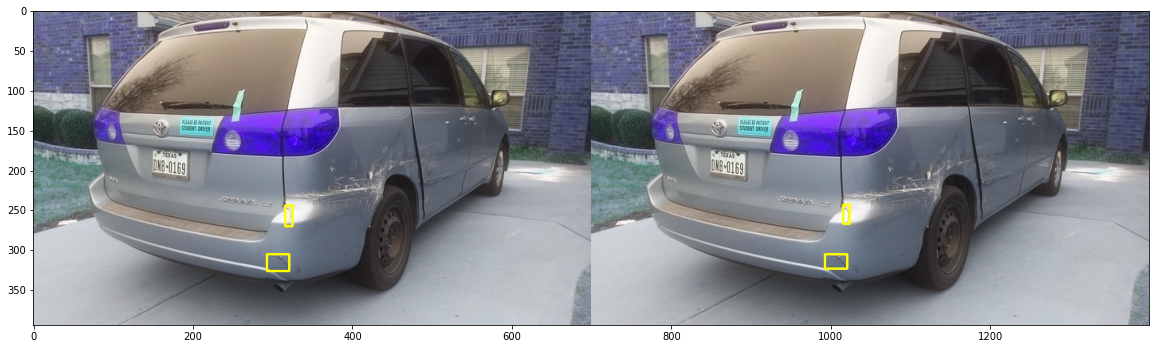

In [11]:
idx = 4950 
i = plot_fp_v2(str(idx),es[str(idx)]['boxes'])
plt.figure(figsize=(20,10))
plt.imshow(i)

In [13]:
fp_cases

OrderedDict([('https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04ffb871b8cdcf7b0177336e3129d721dc68d1ab.jpg',
              [[(366, 660), (408, 701)], [(103, 666), (536, 890)]]),
             ('https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_32d11b4eb37e65e5c875e84c63907de4cd9e712d.jpg',
              [[(681, 129), (1240, 388)]]),
             ('https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_detail_damage2_22020_medium_20190424_124819.jpg',
              [[(360, 323), (379, 343)], [(389, 316), (400, 326)]]),
             ('https:__s3.amazonaws.com_mc-imt_vehicle_2018X6701_detail_damage1_16118_medium_image.jpg',
              [[(322, 373), (404, 388)]]),
             ('https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27dffe0771475c9e949fd0a688989ce61aaca28b.jpg',
              [[(735, 713), (833, 776)], [(1089, 859), (1162, 933)]]),
             ('https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z

In [20]:
#with open('fp_crack_boxes.json', 'w', encoding='utf-8') as f:
#    json.dump(fp_cases, f, ensure_ascii=False, indent=4)

In [21]:
fp_cases = json.load(open('fp_crack_boxes.json'))
fp_cases

{'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_1_04ffb871b8cdcf7b0177336e3129d721dc68d1ab.jpg': [[[366,
    660],
   [408, 701]],
  [[103, 666], [536, 890]]],
 'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_32d11b4eb37e65e5c875e84c63907de4cd9e712d.jpg': [[[681,
    129],
   [1240, 388]]],
 'https:__s3.amazonaws.com_mc-imt_vehicle_2019Y7362_detail_damage2_22020_medium_20190424_124819.jpg': [[[360,
    323],
   [379, 343]],
  [[389, 316], [400, 326]]],
 'https:__s3.amazonaws.com_mc-imt_vehicle_2018X6701_detail_damage1_16118_medium_image.jpg': [[[322,
    373],
   [404, 388]]],
 'https:__s3.amazonaws.com_mc-ai_salvage_car_frontend_2_27dffe0771475c9e949fd0a688989ce61aaca28b.jpg': [[[735,
    713],
   [833, 776]],
  [[1089, 859], [1162, 933]]],
 'https:__s3.amazonaws.com_mc-ai_vn_car_thinh_anh_3_luu_tru_Boi%20thuong%20thang%2010_LG%2014C%20-%20247.00%20-27.10.2018_z1159210384047_f36424a0d2bce4b8ff4449276c80a9d7.jpg': [[[958,
    354],
   [983, 388]]],
 'https:__s3.amazonaws.c

In [17]:
broken = json.load(open(path.parents[0]/'broken'/'annotations'/'total.json'))
print(len(broken['images']),len(broken['annotations']))

3527 4591


In [35]:
count = 0
for name in fp_cases.keys():
    imgs = [i for i in  broken['images'] if i['file_name']==name]
    
    if len(imgs) == 0:
        continue
    
    img = imgs[0]
    annos = [a['bbox'] for a in broken['annotations'] if a['image_id']==img['id']]
    image = cv2.imread(str(path/'images'/name))
    
    for i in range(len(annos)):
        annos[i] = [(int(annos[i][0]),int(annos[i][1])),(int(annos[i][2]),int(annos[i][3]))]
    
    for box in fp_cases[name]:
        ious = [cal_iou(image,box,a) for a in annos]
        print(ious)
        #print(count)
        #count +=1
    
    #print(annos)
    #break

[0, 0, 0]
[0, 0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0.022749157438613384]
[0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0]
[0, 0.1657885748441636]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]


In [15]:
name = 'https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948723.jpg'
i = [i for i in test['images'] if i['file_name']==name][0]
print(i)

{'id': 550, 'license': 4, 'coco_url': 'coco.org', 'flickr_url': 'flickr.org', 'task_name': 'nothing', 'url': 'https://s3.amazonaws.com/mc-ai/dataset/KBC/unzipped/08/44012131907553/img2948723.jpg', 'width': 1152, 'height': 2048, 'file_name': 'https:__s3.amazonaws.com_mc-ai_dataset_KBC_unzipped_08_44012131907553_img2948723.jpg', 'date_captured': '2013-12-15 02:41:52'}


In [17]:
annos = [a for a in test['annotations'] if a['image_id']==550]
print(annos)

[]


In [13]:
eb = json.load(open('ensemble_broken.json'))
print(len(eb.keys()))

3527


In [ ]:
2249 1046 1252
2207 928  1294
# detectoRS 1903 719 1598
# yolov4    1936 589 1565


#old 2314 1225 1187
#new 2241 1045 1260

In [ ]:
#######
'''
esemble predict for all broken datasets
592 3887 3999

esemble predict for all with smaller broken datasets
122 528 779
'''

In [ ]:
'''
DENT
detectoRS

TP    FP    FN
2012 1761 1489 AP=0.53 AR=0.57

yolov4
1937 1101 1564 AP = 0.63 AR=0.55

ensemble for dent
2120 1848 1381 AP=0.53 AR=0.6
2205 1733 1296 ap=0.56 AR=0.62
'''

In [27]:
581/(581+646)

0.47351263243683783

In [28]:
588/(588+639)

0.4792176039119804

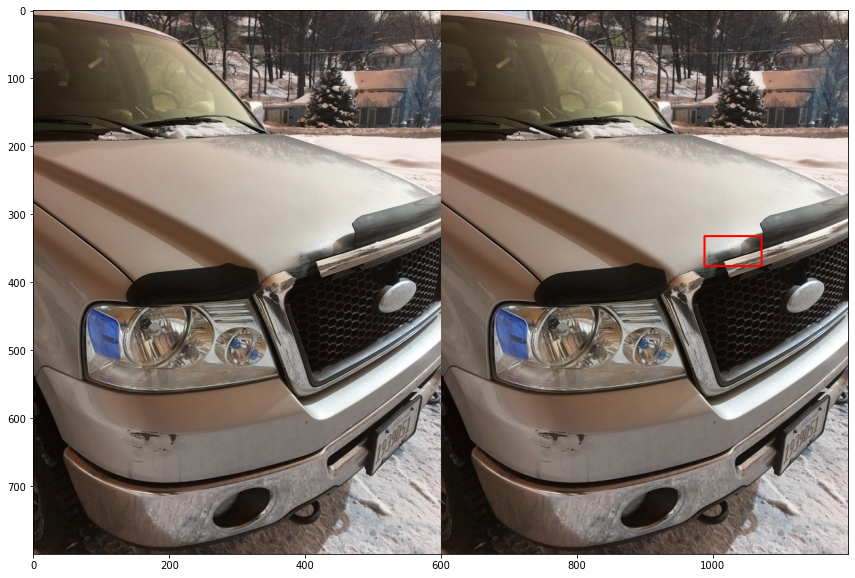

In [75]:
idx = 14999
plot(idx, es[str(idx)]['boxes'])

In [25]:
def plot_annos(image_id):
    img = [i for i in test['images'] if i['id']==image_id][0]
    image = cv2.imread(str(path/'images'/img['file_name']))
    
    annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in test['annotations'] if a['image_id']==image_id]
    cv2.drawContours(image,annos,-1,(255,255,0),2)
    
    gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==image_id]
    gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
    
    for i in range(len(gt_boxes)):
        image = cv2.rectangle(image,gt_boxes[i][0],gt_boxes[i][1],(255,255,0),2)
        
    return image
    #plt.imshow(image)

In [7]:
from PIL import Image
es = json.load(open('detector_scratch_pred_03.json'))
test_path = Path('./fp_scratch')
test_path.mkdir(parents=True, exist_ok=True)
for i in tqdm(test['images']):
    idx = i['id']
    #cv2.imwrite(str(test_path)+'/'+str(i['id'])+'.png',plot_fp_v2(idx,es[str(idx)]['boxes']))
    #out = plot_fp_v2_with_segm(idx,es[str(idx)]['boxes'],es[str(idx)]['segms'])
    out,check = plot_fp_v2(idx,es[str(idx)]['boxes'])
    #plt.figure(figsize=(20,10))
    #plt.imshow(out)
    if check : 
        img = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
        im_pil = Image.fromarray(img)
        im_pil.save(str(test_path)+'/'+str(i['id'])+'.png',optimize=True,quality=70)
    #break
    

100%|██████████| 3774/3774 [2:03:27<00:00,  1.96s/it]  


In [40]:
for i,k in enumerate(es.keys()):
    #print(i)
    print(es[k]['segms'])
    if i == 2:
        break

[[[[[501, 2]], [[500, 3]], [[488, 3]], [[487, 4]], [[481, 4]], [[480, 5]], [[479, 5]], [[478, 6]], [[477, 6]], [[474, 9]], [[474, 15]], [[475, 16]], [[475, 18]], [[476, 19]], [[476, 22]], [[477, 23]], [[477, 24]], [[478, 25]], [[478, 27]], [[481, 30]], [[481, 31]], [[485, 35]], [[485, 36]], [[486, 37]], [[486, 38]], [[487, 39]], [[487, 40]], [[488, 41]], [[488, 42]], [[489, 43]], [[489, 45]], [[490, 46]], [[490, 49]], [[491, 50]], [[491, 53]], [[492, 54]], [[492, 57]], [[493, 58]], [[493, 60]], [[494, 61]], [[494, 62]], [[495, 63]], [[495, 64]], [[496, 65]], [[496, 66]], [[504, 74]], [[504, 75]], [[506, 77]], [[506, 78]], [[507, 79]], [[507, 81]], [[508, 82]], [[508, 85]], [[509, 86]], [[509, 90]], [[510, 91]], [[510, 95]], [[511, 96]], [[511, 98]], [[512, 99]], [[512, 101]], [[513, 102]], [[513, 103]], [[514, 104]], [[514, 106]], [[516, 108]], [[516, 109]], [[517, 110]], [[517, 111]], [[524, 118]], [[524, 119]], [[526, 121]], [[526, 122]], [[527, 123]], [[527, 124]], [[528, 125]], [[5

In [52]:
len(es.keys())

584

In [26]:
test_path = Path('./meeting/totaled')
test_path.mkdir(parents=True, exist_ok=True)
for i in test['images']:
    cv2.imwrite(str(test_path)+'/'+str(i['id'])+'.png',plot_annos(i['id']))

In [20]:
test['images'][0]

{'id': 195,
 'license': 4,
 'coco_url': 'coco.org',
 'flickr_url': 'flickr.org',
 'scalabel_url': 'https://s3.amazonaws.com/mc-imt/vehicle/2019A5704/detail_damage2/31993/medium/1572626634206839735194377895140.jpg',
 'width': 700,
 'height': 525,
 'file_name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2019A5704_detail_damage2_31993_medium_1572626634206839735194377895140.jpg',
 'date_captured': '2013-12-15 02:41:52'}

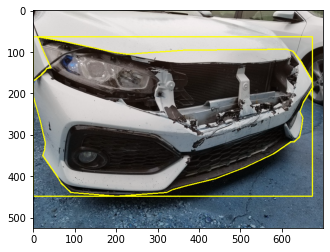

In [23]:
plot_annos(195)

In [15]:
es['2650']

{'name': 'https:__s3.amazonaws.com_mc-imt_vehicle_2018T8083_front_left_view_5502_medium_image.jpg',
 'boxes': [],
 'labels': []}

In [ ]:
## iou_thres = 0.5
# 1: 1 590 778 
# 2: 1 592 776

## iou_thres = 0.25
# 2: 1 581 695 

# iou = 0.36 weight 2 : 1 0.4
#581 646 573                      AP= 0.47 AR=0.5 crack
#567 596 587                      AP= 0.49 AR=0.49
#587 640 598 area < 800 (31 more) 
#588 639 606 area < 1000 (40 more)

In [ ]:
461 351 691
497 377 840

In [35]:
def es_objective_hypertune(params):
    print(params)
    pred_data = json.load(open('detector_pred_04.json'))
    pred_data_flip = json.load(open('yolo_pred.json'))
    
    es = OrderedDict()
    for i in test['images']:
        boxes_list = [pred_data[str(i['id'])]['boxes'], pred_data_flip[str(i['id'])]['boxes']]
        scores_list = [pred_data[str(i['id'])]['scores'], pred_data_flip[str(i['id'])]['scores']]
        labels_list = [pred_data[str(i['id'])]['labels'], pred_data_flip[str(i['id'])]['labels']]

        if len(boxes_list[0]) == 0 and len(boxes_list[1])==0:
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = []
            i_data['labels'] = []
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[0]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[1]
            i_data['labels'] = labels_list[1]
            es[str(i['id'])] = i_data
            continue

        if len(boxes_list[1]) == 0 :
            i_data = OrderedDict()
            i_data['name'] = i['file_name']
            i_data['boxes'] = boxes_list[0]
            i_data['labels'] = labels_list[0]
            es[str(i['id'])] = i_data
            continue
        # tuning here
        weights = [params['weight']+1,1]
        iou_thr = params['threshold']
        skip_box_thr = 0.0001
        sigma = 0.1

        boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr,skip_box_thr=skip_box_thr)

        i_data = OrderedDict()
        i_data['name'] = i['file_name']
        i_data['boxes'] = boxes.tolist()
        i_data['labels'] = labels.tolist()
        es[str(i['id'])] = i_data

    total_tp = 0
    total_fn = 0
    total_fp = 0
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]

        pred_boxes = copy.deepcopy(es[str(i['id'])]['boxes'])
        for j in range(len(pred_boxes)):
            pred_boxes[j][0] = int(pred_boxes[j][0]*w)
            pred_boxes[j][1] = int(pred_boxes[j][1]*h)
            pred_boxes[j][2] = int(pred_boxes[j][2]*w)
            pred_boxes[j][3] = int(pred_boxes[j][3]*h)

            pred_boxes[j] = [(pred_boxes[j][0],pred_boxes[j][1]),(pred_boxes[j][2],pred_boxes[j][3])]
        pred_labels = es[str(i['id'])]['labels']

        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
    print(total_tp,total_fp)
    return total_fp - 2*total_tp

def tuning():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'threshold' : hp.uniform('threshold',0.2,0.6),
            'weight' : hp.randint('weight',5),
            }
    result = fmin(fn=objective_hypertune, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result
    

In [ ]:
def score_oh(params):
    total_tp = 0
    total_fn = 0
    total_fp = 0
    
    for i in test['images']:
        image = cv2.imread(str(path/'images'/i['file_name']))
        h,w,_=image.shape
        gt_boxes = [a['bbox'] for a in test['annotations'] if a['image_id']==i['id']]
        gt_boxes = [[(int(b[0]),int(b[1])),(int(b[0])+int(b[2]),int(b[1])+int(b[3]))] for b in gt_boxes]
        gt_labels = [a['category_id'] for a in test['annotations'] if a['image_id']==i['id']]
        
        result = inference_detector(model, image.copy())
        img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=params['confident_score'])
        
        tp,fp,fn = cal(image,pred_boxes,pred_labels,gt_boxes,gt_labels, i['file_name'])
        total_tp += tp
        total_fp += fp
        total_fn += fn
        
    print("{} - TP : {} ,FP : {}, AP : {}".format(params['confident_score'],total_tp,total_fp,total_tp/(total_tp+total_fp)))
    
    return total_fp/(total_tp+total_fp)

def tuning_confident():
    from hyperopt import hp, tpe,Trials,fmin
    
    space = {'confident_score' : hp.uniform('confident_score',0.2,0.5),
            }
    result = fmin(fn=score_oh, space=space,algo=tpe.suggest,trials=Trials(),max_evals = 15)
    
    return result

print(tuning_confident())

0.4268592110572746 - TP : 443 ,FP : 355, AP : 0.5551378446115288
0.4789813947478013 - TP : 433 ,FP : 318, AP : 0.5765645805592543                   
 13%|█▎        | 2/15 [11:14<1:13:03, 337.22s/trial, best loss: 0.4234354194407457]

In [ ]:
#0.47680153265311676-423-332 
#0.46405537190928414 - TP : 425 ,FP : 339, AP : 0.556282722513089 

In [36]:
print(tuning())

{'threshold': 0.20186076643958806, 'weight': 1}       
569                                                   
602                                                   
{'threshold': 0.5889840584415416, 'weight': 0}                      
581                                                                 
725                                                                 
{'threshold': 0.34653284314044225, 'weight': 1}                     
579                                                                 
643                                                                 
{'threshold': 0.5142339445566273, 'weight': 2}                      
578                                                                 
695                                                                 
{'threshold': 0.5506285420334487, 'weight': 3}                      
579                                                                 
709                                                                 
{'thres

In [ ]:
# 0.3 {'threshold': 0.2003033575511911, 'weight': 0}
# 0.4 {'threshold': 0.36257411346807455, 'weight': 1}

In [ ]:
coco_js = json.load(open('new_and_ensemble_dent.json'))
out = []
for k in tqdm(coco_js.keys()):
    if len(coco_js[k]['boxes']) == 0:
        continue
    img = cv2.imread(str(path/'images'/coco_js[k]['image']))
    h,w = img.shape[:2]
    
    #print(box['bbox'])
    for i,b in enumerate(coco_js[k]['boxes']):
        box = OrderedDict()
        box['image_id'] = int(k)
        box['category_id'] = 0
        #box['bbox'] = 
        #print(b,i)
        #print(coco_js[k]['scores'][i])
        box['bbox'] = [b[0]*w,b[1]*h,(b[2]-b[0])*w,(b[3]-b[1])*h]
        box['score'] = coco_js[k]['scores'][i]
        #print(box)
        #break
        out.append(box)
    #print(box['bbox'])
    #break
    
with open('ensemble_dent_coco_eval.json', 'w') as f:
    json.dump(out, f)

In [31]:
from pycocotools.coco import COCO
from fast_eval_api import COCOeval_opt as COCOeval

In [41]:
imgIds = [i['id'] for i in test['images']]
cocoGt = COCO(str(path/'annotations'/'test.json'))
#print(cocoGt)
cocoDt = cocoGt.loadRes('ensemble_dent_coco_eval.json')
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.23s).
Accumulating evaluation results...
DONE (t=0.20s).
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.225
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.459
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDet

In [43]:
print(test['categories'])
print(len(test['images']),len(test['annotations']))

[{'supercategory': 'Carparts', 'id': 0, 'name': 'dent'}]
2252 3501


In [44]:
import random
imgs = random.sample(test['images'],10)
ids = [i['id'] for i in imgs]
annos = [a for a in test['annotations'] if a['image_id'] in ids]
print(len(imgs),len(annos))

10 12


In [45]:
tiny_test = copy.deepcopy(test)
tiny_test['images'] = imgs
tiny_test['annotations'] = annos

In [46]:
with open('tiny_dent_test.json', 'w', encoding='utf-8') as f:
    json.dump(tiny_test, f, ensure_ascii=False, indent=4)

In [48]:
demo_test = json.load(open('tiny_dent_test.json'))
print(len(demo_test['images']),len(demo_test['annotations']))

10 12


In [83]:
data = OrderedDict()

for i in tqdm(demo_test['images']):
    image = cv2.imread(str(path/'images'/i['file_name']))
    result = inference_detector(model, image)
    img_,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model, image.copy(), result,score_thr=0.25)
    data[i['id']] = get_data_box(image,i['id'],i['file_name'],pred_boxes,pred_segms,pred_labels,pred_scores)
    #break
with open('demo_test_dent_coco_eval.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

100%|██████████| 10/10 [00:04<00:00,  2.00it/s]


In [10]:
coco_js = json.load(open('demo_test_dent_coco_eval.json'))
out = []
for k in tqdm(coco_js.keys()):
    if len(coco_js[k]['boxes']) == 0:
        continue
    img = cv2.imread(str(path/'images'/coco_js[k]['image']))
    h,w = img.shape[:2]
    
    #print(box['bbox'])
    for i,b in enumerate(coco_js[k]['boxes']):
        box = OrderedDict()
        box['image_id'] = int(k)
        box['category_id'] = 0
        #box['bbox'] = 
        #print(b,i)
        #print(coco_js[k]['scores'][i])
        box['bbox'] = [b[0]*w,b[1]*h,(b[2]-b[0])*w,(b[3]-b[1])*h]
        box['score'] = coco_js[k]['scores'][i]
        #print(box)
        #break
        out.append(box)
    #print(box['bbox'])
    #break
print('number of predict :',len(out))
with open('ensemble_demo_test_dent_coco_eval.json', 'w') as f:
    json.dump(out, f)

100%|██████████| 10/10 [00:00<00:00, 46.34it/s]

number of predict : 11


In [13]:
from pycocotools.coco import COCO
from fast_eval_api import COCOeval_opt as COCOeval

imgIds = [i['id'] for i in test['images']]
cocoGt = COCO('tiny_dent_test.json')
#print(cocoGt)
cocoDt = cocoGt.loadRes('ensemble_demo_test_dent_coco_eval.json')
cocoEval = COCOeval(cocoGt,cocoDt,'bbox')
cocoEval.params.imgIds = imgIds
cocoEval.params.catIds = [0]
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=   all | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.449
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.25      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.10      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= small | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.10:0.95 | area=medium | maxDets=100 ] = 0.281
 Average Precision  (AP) @[ IoU=0.10:0.95 | area= large | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.10:0.95 | area=   all | maxDet